In [1]:
import keras
from keras.layers import Input, Conv1D,Activation,MaxPooling1D,Dense,Flatten,UpSampling1D
from keras.layers.normalization import BatchNormalization
from keras.models import Model,load_model
import tensorflow as tf
import numpy as np
from matplotlib.pyplot import plot
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
def get_sub_model(myinputs,channel=3):
    x     = Conv1D(filters =8, kernel_size=5,strides = 1, padding = 'same')(myinputs)
    #x     = BatchNormalization()(x) 
    x     = Activation('relu')(x)
    x     = MaxPooling1D(pool_size=3,strides = 2,padding='same')(x)
    #  x shape is 64X16 =3072
    x     = Conv1D(filters =12, kernel_size=3,strides = 1, padding = 'same')(x)
    #x     = BatchNormalization()(x) 
    x     = Activation('relu')(x)
    x     = MaxPooling1D(pool_size=2,strides = 2,padding='same')(x)
    #  x shape is 32X24 = 2048
    x     = Conv1D(filters =16, kernel_size=3,strides = 1, padding = 'same')(x)
    #x     = BatchNormalization()(x) 
    x     = Activation('relu')(x)
    x     = MaxPooling1D(pool_size=2,strides = 2,padding='same')(x)
    # x shape is 16*32 = 1536
    x     = Conv1D(filters =20, kernel_size=3,strides = 1, padding = 'same')(x)
    #x     = BatchNormalization()(x) 
    x     = Activation('relu')(x)
    x     = MaxPooling1D(pool_size=2,strides = 2,padding='same')(x)
    # x shape is 8*32 = 1024
    x     = Conv1D(filters =24, kernel_size=3,strides = 2, padding = 'same')(x)
    # x shape is 4*32 = 512

    latent_vector = Flatten()(x)
    # decoder x = 4*128
    x     = Conv1D(filters =24, kernel_size=3,strides = 1, padding = 'same')(x)
    #x     = BatchNormalization()(x) 
    x     = Activation('relu')(x)
    x     = UpSampling1D(2)(x)
    # x shape is 8*128
    x     = Conv1D(filters =20, kernel_size=3,strides = 1, padding = 'same')(x)
    #x     = BatchNormalization()(x) 
    x     = Activation('relu')(x)
    x     = UpSampling1D(2)(x)
    # x shape is 16*96
    x     = Conv1D(filters =16, kernel_size=3,strides = 1, padding = 'same')(x)
    #x     = BatchNormalization()(x) 
    x     = Activation('relu')(x)
    x     = UpSampling1D(2)(x)
    # x shape is 32*64
    x     = Conv1D(filters =12, kernel_size=3,strides = 1, padding = 'same')(x)
    #x     = BatchNormalization()(x) 
    x     = Activation('relu')(x)
    x     = UpSampling1D(2)(x)
    # x shape is 64*48
    x     = Conv1D(filters =8, kernel_size=3,strides = 1, padding = 'same')(x)
    #x     = BatchNormalization()(x) 
    x     = Activation('relu')(x)
    x     = UpSampling1D(2)(x)
    # x shape is 128*48
    y     = Conv1D(filters =channel, kernel_size=3,strides = 1, padding = 'same')(x)
    return latent_vector,y

In [3]:
def build_model(name="push_detect",channel=3):
    # input shape 128X26 =3382
    with tf.name_scope(name):
        myInputs = Input(shape=(128,channel))
                
        LV,Y = get_sub_model(myInputs,channel=channel)
        
        autoencoder = Model (inputs=myInputs,
                             outputs =Y)
    
    return autoencoder

In [4]:
gyroModel=build_model()
linearAccModel=build_model()
gravityModel=build_model()
gameVecModel=build_model(channel=4)
opt = keras.optimizers.SGD(lr=0.001, momentum=0.0, decay=0.0, nesterov=False)
gyroModel.compile(optimizer=opt,loss='mse',metrics=['accuracy'])
opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)
linearAccModel.compile(optimizer=opt,loss='mse',metrics=['accuracy'])
opt = keras.optimizers.SGD(lr=0.00001, momentum=0.0, decay=0.0, nesterov=False)
gravityModel.compile(optimizer=opt,loss='mse',metrics=['accuracy'])
opt = keras.optimizers.SGD(lr=0.001, momentum=0.0, decay=0.0, nesterov=False)
gameVecModel.compile(optimizer=opt,loss='mse',metrics=['accuracy'])

In [5]:
data= np.load('watch.npy')
np.random.shuffle(data)
p=0.85
train_num =int(data.shape[0]*p)
gyro_train=data[:train_num,:,13:16]
linearAcc_train=data[:train_num,:,16:19]
gravity_train=data[:train_num,:,19:22]
gameVec_train=data[:train_num,:,22:26]

gyro_test =data[train_num:,:,13:16]
linearAcc_test =data[train_num:,:,16:19]
gravity_test =data[train_num:,:,19:22]
gameVec_test =data[train_num:,:,22:26]

In [ ]:
for i in range(500):
    print('start training round '+str(i))
    print('training gyro model')
    gyroModel.fit(gyro_train,gyro_train,batch_size=256,epochs=50,validation_split=0.1)
    print('training linearAcc model')
    linearAccModel.fit(linearAcc_train,linearAcc_train,batch_size=256,epochs=50,validation_split=0.1)
    print('training gravity model')
    gravityModel.fit(gravity_train,gravity_train,batch_size=256,epochs=50,validation_split=0.1)
    print('training gameVec model')
    gameVecModel.fit(gameVec_train,gameVec_train,batch_size=256,epochs=50,validation_split=0.1)
    gyroModel.save('gyroModelFFT.h5')
    linearAccModel.save('linearAccModelFFT.h5')
    gravityModel.save('gravityModelFFT.h5')
    gameVecModel.save('gameVecModelFFT.h5')

start training round 0
training gyro model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 4s 425us/step - loss: 262.6224 - acc: 0.5658 - val_loss: 258.8750 - val_acc: 0.6581
Epoch 2/50
8564/8564 [==============================] - 2s 182us/step - loss: 259.7085 - acc: 0.6860 - val_loss: 259.6417 - val_acc: 0.7024
Epoch 3/50
8564/8564 [==============================] - 2s 195us/step - loss: 262.5016 - acc: 0.6980 - val_loss: 256.2469 - val_acc: 0.7024
Epoch 4/50
8564/8564 [==============================] - 2s 182us/step - loss: 258.8318 - acc: 0.6980 - val_loss: 252.0617 - val_acc: 0.7024
Epoch 5/50
8564/8564 [==============================] - 2s 180us/step - loss: 253.7713 - acc: 0.6980 - val_loss: 245.6269 - val_acc: 0.7024
Epoch 6/50
8564/8564 [==============================] - 2s 187us/step - loss: 245.1755 - acc: 0.6980 - val_loss: 233.8172 - val_acc: 0.7024
Epoch 7/50
8564/8564 [==============================] - 2s 189us/step 

8564/8564 [==============================] - 2s 184us/step - loss: 337.8340 - acc: 0.3994 - val_loss: 596.6538 - val_acc: 0.3872
Epoch 9/50
8564/8564 [==============================] - 2s 187us/step - loss: 347.5181 - acc: 0.3973 - val_loss: 305.7646 - val_acc: 0.3972
Epoch 10/50
8564/8564 [==============================] - 2s 184us/step - loss: 310.1515 - acc: 0.3958 - val_loss: 540.0395 - val_acc: 0.3926
Epoch 11/50
8564/8564 [==============================] - 2s 185us/step - loss: 301.5582 - acc: 0.3961 - val_loss: 543.9951 - val_acc: 0.3914
Epoch 12/50
8564/8564 [==============================] - 2s 185us/step - loss: 318.8976 - acc: 0.3954 - val_loss: 232.9984 - val_acc: 0.3972
Epoch 13/50
8564/8564 [==============================] - 2s 187us/step - loss: 304.3935 - acc: 0.3959 - val_loss: 314.6704 - val_acc: 0.3925
Epoch 14/50
8564/8564 [==============================] - 2s 183us/step - loss: 296.1623 - acc: 0.3952 - val_loss: 279.7900 - val_acc: 0.3982
Epoch 15/50
8564/8564 [===

Epoch 16/50
8564/8564 [==============================] - 2s 184us/step - loss: 529.7519 - acc: 0.3970 - val_loss: 520.8459 - val_acc: 0.3996
Epoch 17/50
8564/8564 [==============================] - 2s 186us/step - loss: 527.0604 - acc: 0.3974 - val_loss: 517.8648 - val_acc: 0.3995
Epoch 18/50
8564/8564 [==============================] - 2s 182us/step - loss: 523.2887 - acc: 0.3981 - val_loss: 513.6648 - val_acc: 0.4002
Epoch 19/50
8564/8564 [==============================] - 1s 171us/step - loss: 518.3022 - acc: 0.3989 - val_loss: 508.4081 - val_acc: 0.4005
Epoch 20/50
8564/8564 [==============================] - 1s 169us/step - loss: 512.1674 - acc: 0.3987 - val_loss: 502.0874 - val_acc: 0.4007
Epoch 21/50
8564/8564 [==============================] - 2s 183us/step - loss: 505.0565 - acc: 0.4001 - val_loss: 495.1398 - val_acc: 0.4036
Epoch 22/50
8564/8564 [==============================] - 2s 179us/step - loss: 497.4266 - acc: 0.4032 - val_loss: 487.6302 - val_acc: 0.4056
Epoch 23/50
8

8564/8564 [==============================] - 2s 198us/step - loss: 3.9946 - acc: 0.2386 - val_loss: 4.3595 - val_acc: 0.2306
Epoch 25/50
8564/8564 [==============================] - 2s 195us/step - loss: 3.9871 - acc: 0.2420 - val_loss: 4.3518 - val_acc: 0.2343
Epoch 26/50
8564/8564 [==============================] - 2s 193us/step - loss: 3.9798 - acc: 0.2457 - val_loss: 4.3444 - val_acc: 0.2379
Epoch 27/50
8564/8564 [==============================] - 2s 197us/step - loss: 3.9728 - acc: 0.2496 - val_loss: 4.3372 - val_acc: 0.2420
Epoch 28/50
8564/8564 [==============================] - 2s 191us/step - loss: 3.9661 - acc: 0.2538 - val_loss: 4.3302 - val_acc: 0.2462
Epoch 29/50
8564/8564 [==============================] - 2s 196us/step - loss: 3.9595 - acc: 0.2572 - val_loss: 4.3235 - val_acc: 0.2502
Epoch 30/50
8564/8564 [==============================] - 2s 195us/step - loss: 3.9531 - acc: 0.2604 - val_loss: 4.3169 - val_acc: 0.2537
Epoch 31/50
8564/8564 [==============================

Epoch 33/50
8564/8564 [==============================] - 2s 188us/step - loss: 45.0195 - acc: 0.6992 - val_loss: 42.0909 - val_acc: 0.7046
Epoch 34/50
8564/8564 [==============================] - 2s 185us/step - loss: 44.2839 - acc: 0.6999 - val_loss: 42.4240 - val_acc: 0.7038
Epoch 35/50
8564/8564 [==============================] - 2s 184us/step - loss: 44.5898 - acc: 0.6999 - val_loss: 44.1072 - val_acc: 0.7041
Epoch 36/50
8564/8564 [==============================] - 2s 186us/step - loss: 44.8732 - acc: 0.6998 - val_loss: 46.5504 - val_acc: 0.7013
Epoch 37/50
8564/8564 [==============================] - 2s 187us/step - loss: 44.4354 - acc: 0.7001 - val_loss: 44.1464 - val_acc: 0.7000
Epoch 38/50
8564/8564 [==============================] - 2s 185us/step - loss: 44.0983 - acc: 0.7002 - val_loss: 48.9194 - val_acc: 0.7020
Epoch 39/50
8564/8564 [==============================] - 2s 184us/step - loss: 44.5572 - acc: 0.7000 - val_loss: 42.9641 - val_acc: 0.7033
Epoch 40/50
8564/8564 [====

8564/8564 [==============================] - 2s 188us/step - loss: 214.8144 - acc: 0.4747 - val_loss: 215.5267 - val_acc: 0.4733
Epoch 41/50
8564/8564 [==============================] - 2s 189us/step - loss: 218.7476 - acc: 0.4749 - val_loss: 217.1951 - val_acc: 0.4734
Epoch 42/50
8564/8564 [==============================] - 2s 192us/step - loss: 217.7191 - acc: 0.4756 - val_loss: 210.8976 - val_acc: 0.4738
Epoch 43/50
8564/8564 [==============================] - 2s 190us/step - loss: 216.0084 - acc: 0.4762 - val_loss: 211.9449 - val_acc: 0.4752
Epoch 44/50
8564/8564 [==============================] - 2s 189us/step - loss: 220.3874 - acc: 0.4768 - val_loss: 217.7968 - val_acc: 0.4730
Epoch 45/50
8564/8564 [==============================] - 2s 193us/step - loss: 218.4417 - acc: 0.4766 - val_loss: 220.1881 - val_acc: 0.4712
Epoch 46/50
8564/8564 [==============================] - 2s 186us/step - loss: 219.1392 - acc: 0.4767 - val_loss: 210.3249 - val_acc: 0.4744
Epoch 47/50
8564/8564 [==

8564/8564 [==============================] - 2s 185us/step - loss: 125.7432 - acc: 0.3905 - val_loss: 121.9712 - val_acc: 0.3858
Epoch 48/50
8564/8564 [==============================] - 2s 190us/step - loss: 125.4468 - acc: 0.3909 - val_loss: 121.6586 - val_acc: 0.3866
Epoch 49/50
8564/8564 [==============================] - 2s 182us/step - loss: 125.1555 - acc: 0.3917 - val_loss: 121.3797 - val_acc: 0.3870
Epoch 50/50
8564/8564 [==============================] - 2s 182us/step - loss: 124.8804 - acc: 0.3920 - val_loss: 121.0400 - val_acc: 0.3886
training gameVec model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 199us/step - loss: 3.7996 - acc: 0.3074 - val_loss: 4.1494 - val_acc: 0.3103
Epoch 2/50
8564/8564 [==============================] - 2s 200us/step - loss: 3.7843 - acc: 0.3073 - val_loss: 4.1321 - val_acc: 0.3098
Epoch 3/50
8564/8564 [==============================] - 2s 193us/step - loss: 3.7666 - acc: 0.3074 - val_l

8564/8564 [==============================] - 2s 183us/step - loss: 43.6066 - acc: 0.7016 - val_loss: 44.0196 - val_acc: 0.7047
Epoch 6/50
8564/8564 [==============================] - 2s 182us/step - loss: 43.1847 - acc: 0.7016 - val_loss: 42.3730 - val_acc: 0.7071
Epoch 7/50
8564/8564 [==============================] - 2s 184us/step - loss: 42.8715 - acc: 0.7019 - val_loss: 43.6862 - val_acc: 0.7034
Epoch 8/50
8564/8564 [==============================] - 2s 181us/step - loss: 42.4690 - acc: 0.7019 - val_loss: 43.9609 - val_acc: 0.7064
Epoch 9/50
8564/8564 [==============================] - 2s 188us/step - loss: 43.9237 - acc: 0.7020 - val_loss: 41.2089 - val_acc: 0.7049
Epoch 10/50
8564/8564 [==============================] - 2s 182us/step - loss: 42.3060 - acc: 0.7023 - val_loss: 41.1890 - val_acc: 0.7053
Epoch 11/50
8564/8564 [==============================] - 2s 182us/step - loss: 42.6871 - acc: 0.7022 - val_loss: 42.0566 - val_acc: 0.7065
Epoch 12/50
8564/8564 [====================

8564/8564 [==============================] - 2s 186us/step - loss: 214.5681 - acc: 0.4865 - val_loss: 219.2441 - val_acc: 0.4848
Epoch 14/50
8564/8564 [==============================] - 2s 186us/step - loss: 214.0478 - acc: 0.4867 - val_loss: 209.8793 - val_acc: 0.4857
Epoch 15/50
8564/8564 [==============================] - 2s 185us/step - loss: 208.7263 - acc: 0.4869 - val_loss: 204.6596 - val_acc: 0.4855
Epoch 16/50
8564/8564 [==============================] - 2s 185us/step - loss: 212.0789 - acc: 0.4881 - val_loss: 205.0478 - val_acc: 0.4845
Epoch 17/50
8564/8564 [==============================] - 2s 182us/step - loss: 212.6051 - acc: 0.4883 - val_loss: 209.1841 - val_acc: 0.4859
Epoch 18/50
8564/8564 [==============================] - 2s 186us/step - loss: 212.5981 - acc: 0.4889 - val_loss: 217.8467 - val_acc: 0.4849
Epoch 19/50
8564/8564 [==============================] - 2s 188us/step - loss: 214.1235 - acc: 0.4890 - val_loss: 204.0967 - val_acc: 0.4893
Epoch 20/50
8564/8564 [==

Epoch 21/50
8564/8564 [==============================] - 2s 186us/step - loss: 120.5755 - acc: 0.3988 - val_loss: 116.5882 - val_acc: 0.3964
Epoch 22/50
8564/8564 [==============================] - 2s 184us/step - loss: 120.4307 - acc: 0.3995 - val_loss: 116.4320 - val_acc: 0.3961
Epoch 23/50
8564/8564 [==============================] - 2s 183us/step - loss: 120.2729 - acc: 0.3998 - val_loss: 116.2838 - val_acc: 0.3964
Epoch 24/50
8564/8564 [==============================] - 2s 180us/step - loss: 120.1229 - acc: 0.3998 - val_loss: 116.0995 - val_acc: 0.3966
Epoch 25/50
8564/8564 [==============================] - 2s 186us/step - loss: 119.9720 - acc: 0.4001 - val_loss: 115.9789 - val_acc: 0.3963
Epoch 26/50
8564/8564 [==============================] - 2s 184us/step - loss: 119.8240 - acc: 0.4001 - val_loss: 115.8175 - val_acc: 0.3969
Epoch 27/50
8564/8564 [==============================] - 2s 183us/step - loss: 119.6864 - acc: 0.4003 - val_loss: 115.6696 - val_acc: 0.3964
Epoch 28/50
8

8564/8564 [==============================] - 2s 187us/step - loss: 1.4402 - acc: 0.2883 - val_loss: 1.5124 - val_acc: 0.2920
Epoch 30/50
8564/8564 [==============================] - 2s 192us/step - loss: 1.4246 - acc: 0.2892 - val_loss: 1.4963 - val_acc: 0.2945
Epoch 31/50
8564/8564 [==============================] - 2s 192us/step - loss: 1.4069 - acc: 0.2896 - val_loss: 1.4770 - val_acc: 0.2918
Epoch 32/50
8564/8564 [==============================] - 2s 192us/step - loss: 1.3932 - acc: 0.2891 - val_loss: 1.4638 - val_acc: 0.2931
Epoch 33/50
8564/8564 [==============================] - 2s 189us/step - loss: 1.3765 - acc: 0.2880 - val_loss: 1.4397 - val_acc: 0.2911
Epoch 34/50
8564/8564 [==============================] - 2s 186us/step - loss: 1.3627 - acc: 0.2869 - val_loss: 1.4225 - val_acc: 0.2903
Epoch 35/50
8564/8564 [==============================] - 2s 194us/step - loss: 1.3507 - acc: 0.2867 - val_loss: 1.4179 - val_acc: 0.2899
Epoch 36/50
8564/8564 [==============================

Epoch 38/50
8564/8564 [==============================] - 2s 183us/step - loss: 39.6590 - acc: 0.7062 - val_loss: 39.6018 - val_acc: 0.7078
Epoch 39/50
8564/8564 [==============================] - 2s 179us/step - loss: 40.1284 - acc: 0.7061 - val_loss: 39.0288 - val_acc: 0.7072
Epoch 40/50
8564/8564 [==============================] - 2s 179us/step - loss: 39.7108 - acc: 0.7060 - val_loss: 38.2624 - val_acc: 0.7089
Epoch 41/50
8564/8564 [==============================] - 2s 183us/step - loss: 39.7214 - acc: 0.7065 - val_loss: 38.5521 - val_acc: 0.7111
Epoch 42/50
8564/8564 [==============================] - 2s 179us/step - loss: 39.9630 - acc: 0.7062 - val_loss: 38.1097 - val_acc: 0.7103
Epoch 43/50
8564/8564 [==============================] - 2s 181us/step - loss: 39.9091 - acc: 0.7062 - val_loss: 39.1221 - val_acc: 0.7096
Epoch 44/50
8564/8564 [==============================] - 2s 179us/step - loss: 39.5662 - acc: 0.7061 - val_loss: 37.8530 - val_acc: 0.7104
Epoch 45/50
8564/8564 [====

Epoch 46/50
8564/8564 [==============================] - 2s 188us/step - loss: 194.4758 - acc: 0.5309 - val_loss: 189.7679 - val_acc: 0.5317
Epoch 47/50
8564/8564 [==============================] - 2s 180us/step - loss: 195.3110 - acc: 0.5316 - val_loss: 190.2386 - val_acc: 0.5325
Epoch 48/50
8564/8564 [==============================] - 2s 180us/step - loss: 191.4810 - acc: 0.5302 - val_loss: 191.5613 - val_acc: 0.5298
Epoch 49/50
8564/8564 [==============================] - 2s 183us/step - loss: 195.0330 - acc: 0.5316 - val_loss: 191.0917 - val_acc: 0.5323
Epoch 50/50
8564/8564 [==============================] - 2s 184us/step - loss: 193.2319 - acc: 0.5331 - val_loss: 191.5824 - val_acc: 0.5305
training gravity model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 183us/step - loss: 116.8028 - acc: 0.4021 - val_loss: 112.6823 - val_acc: 0.3985
Epoch 2/50
8564/8564 [==============================] - 2s 185us/step - loss: 116.700

Epoch 3/50
8564/8564 [==============================] - 2s 197us/step - loss: 1.2008 - acc: 0.3288 - val_loss: 1.2462 - val_acc: 0.3319
Epoch 4/50
8564/8564 [==============================] - 2s 192us/step - loss: 1.1953 - acc: 0.3303 - val_loss: 1.2389 - val_acc: 0.3338
Epoch 5/50
8564/8564 [==============================] - 2s 192us/step - loss: 1.1902 - acc: 0.3319 - val_loss: 1.2333 - val_acc: 0.3352
Epoch 6/50
8564/8564 [==============================] - 2s 192us/step - loss: 1.1848 - acc: 0.3337 - val_loss: 1.2273 - val_acc: 0.3377
Epoch 7/50
8564/8564 [==============================] - 2s 193us/step - loss: 1.1795 - acc: 0.3355 - val_loss: 1.2219 - val_acc: 0.3388
Epoch 8/50
8564/8564 [==============================] - 2s 196us/step - loss: 1.1744 - acc: 0.3367 - val_loss: 1.2165 - val_acc: 0.3403
Epoch 9/50
8564/8564 [==============================] - 2s 190us/step - loss: 1.1696 - acc: 0.3377 - val_loss: 1.2120 - val_acc: 0.3411
Epoch 10/50
8564/8564 [=========================

8564/8564 [==============================] - 2s 191us/step - loss: 39.1062 - acc: 0.7060 - val_loss: 39.3710 - val_acc: 0.7066
Epoch 13/50
8564/8564 [==============================] - 2s 184us/step - loss: 39.2634 - acc: 0.7055 - val_loss: 39.4038 - val_acc: 0.7047
Epoch 14/50
8564/8564 [==============================] - 2s 185us/step - loss: 38.8395 - acc: 0.7056 - val_loss: 38.2427 - val_acc: 0.7106
Epoch 15/50
8564/8564 [==============================] - 2s 183us/step - loss: 39.1097 - acc: 0.7058 - val_loss: 37.7494 - val_acc: 0.7104
Epoch 16/50
8564/8564 [==============================] - 2s 185us/step - loss: 39.1411 - acc: 0.7057 - val_loss: 37.8479 - val_acc: 0.7101
Epoch 17/50
8564/8564 [==============================] - 2s 183us/step - loss: 39.5669 - acc: 0.7055 - val_loss: 37.8845 - val_acc: 0.7120
Epoch 18/50
8564/8564 [==============================] - 2s 182us/step - loss: 38.7927 - acc: 0.7054 - val_loss: 37.9513 - val_acc: 0.7123
Epoch 19/50
8564/8564 [================

8564/8564 [==============================] - 2s 184us/step - loss: 192.4426 - acc: 0.5385 - val_loss: 195.5140 - val_acc: 0.5379
Epoch 21/50
8564/8564 [==============================] - 2s 186us/step - loss: 190.4158 - acc: 0.5390 - val_loss: 187.6631 - val_acc: 0.5323
Epoch 22/50
8564/8564 [==============================] - 2s 187us/step - loss: 189.8552 - acc: 0.5391 - val_loss: 190.3866 - val_acc: 0.5396
Epoch 23/50
8564/8564 [==============================] - 2s 187us/step - loss: 191.8318 - acc: 0.5407 - val_loss: 189.7629 - val_acc: 0.5404
Epoch 24/50
8564/8564 [==============================] - 2s 187us/step - loss: 190.3766 - acc: 0.5406 - val_loss: 190.3608 - val_acc: 0.5381
Epoch 25/50
8564/8564 [==============================] - 2s 189us/step - loss: 189.4161 - acc: 0.5388 - val_loss: 193.3730 - val_acc: 0.5316
Epoch 26/50
8564/8564 [==============================] - 2s 187us/step - loss: 190.7163 - acc: 0.5400 - val_loss: 191.1923 - val_acc: 0.5408
Epoch 27/50
8564/8564 [==

8564/8564 [==============================] - 2s 184us/step - loss: 110.5823 - acc: 0.4076 - val_loss: 106.3203 - val_acc: 0.4013
Epoch 28/50
8564/8564 [==============================] - 2s 185us/step - loss: 110.5214 - acc: 0.4077 - val_loss: 106.2693 - val_acc: 0.4004
Epoch 29/50
8564/8564 [==============================] - 2s 182us/step - loss: 110.4538 - acc: 0.4076 - val_loss: 106.1981 - val_acc: 0.4006
Epoch 30/50
8564/8564 [==============================] - 2s 181us/step - loss: 110.3902 - acc: 0.4076 - val_loss: 106.1013 - val_acc: 0.4027
Epoch 31/50
8564/8564 [==============================] - 2s 185us/step - loss: 110.3314 - acc: 0.4079 - val_loss: 106.0379 - val_acc: 0.4019
Epoch 32/50
8564/8564 [==============================] - 2s 187us/step - loss: 110.2654 - acc: 0.4081 - val_loss: 105.9932 - val_acc: 0.4009
Epoch 33/50
8564/8564 [==============================] - 2s 189us/step - loss: 110.2012 - acc: 0.4078 - val_loss: 105.9186 - val_acc: 0.4016
Epoch 34/50
8564/8564 [==

Epoch 36/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.9706 - acc: 0.3840 - val_loss: 1.0048 - val_acc: 0.3758
Epoch 37/50
8564/8564 [==============================] - 2s 191us/step - loss: 0.9693 - acc: 0.3835 - val_loss: 1.0025 - val_acc: 0.3758
Epoch 38/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.9677 - acc: 0.3835 - val_loss: 1.0015 - val_acc: 0.3752
Epoch 39/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.9663 - acc: 0.3830 - val_loss: 0.9995 - val_acc: 0.3753
Epoch 40/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.9648 - acc: 0.3828 - val_loss: 0.9987 - val_acc: 0.3743
Epoch 41/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.9635 - acc: 0.3822 - val_loss: 0.9979 - val_acc: 0.3740
Epoch 42/50
8564/8564 [==============================] - 2s 191us/step - loss: 0.9622 - acc: 0.3822 - val_loss: 0.9953 - val_acc: 0.3743
Epoch 43/50
8564/8564 [==================

8564/8564 [==============================] - 2s 184us/step - loss: 38.1106 - acc: 0.7026 - val_loss: 37.6713 - val_acc: 0.7059
Epoch 45/50
8564/8564 [==============================] - 2s 182us/step - loss: 37.0951 - acc: 0.7026 - val_loss: 36.6489 - val_acc: 0.7047
Epoch 46/50
8564/8564 [==============================] - 2s 183us/step - loss: 37.9068 - acc: 0.7032 - val_loss: 36.3384 - val_acc: 0.7069
Epoch 47/50
8564/8564 [==============================] - 2s 181us/step - loss: 37.4392 - acc: 0.7029 - val_loss: 37.1137 - val_acc: 0.7083
Epoch 48/50
8564/8564 [==============================] - 2s 182us/step - loss: 37.7096 - acc: 0.7028 - val_loss: 37.7816 - val_acc: 0.7027
Epoch 49/50
8564/8564 [==============================] - 2s 182us/step - loss: 37.2815 - acc: 0.7031 - val_loss: 35.5136 - val_acc: 0.7079
Epoch 50/50
8564/8564 [==============================] - 2s 185us/step - loss: 37.1788 - acc: 0.7024 - val_loss: 36.0011 - val_acc: 0.7046
training linearAcc model
Train on 8564 

8564/8564 [==============================] - 2s 186us/step - loss: 109.1058 - acc: 0.4093 - val_loss: 104.8027 - val_acc: 0.4027
Epoch 2/50
8564/8564 [==============================] - 2s 185us/step - loss: 109.0434 - acc: 0.4091 - val_loss: 104.7464 - val_acc: 0.4022
Epoch 3/50
8564/8564 [==============================] - 2s 184us/step - loss: 108.9816 - acc: 0.4097 - val_loss: 104.6618 - val_acc: 0.4026
Epoch 4/50
8564/8564 [==============================] - 2s 181us/step - loss: 108.9258 - acc: 0.4093 - val_loss: 104.6089 - val_acc: 0.4021
Epoch 5/50
8564/8564 [==============================] - 2s 183us/step - loss: 108.8681 - acc: 0.4094 - val_loss: 104.5560 - val_acc: 0.4019
Epoch 6/50
8564/8564 [==============================] - 2s 184us/step - loss: 108.8106 - acc: 0.4093 - val_loss: 104.4878 - val_acc: 0.4023
Epoch 7/50
8564/8564 [==============================] - 2s 183us/step - loss: 108.7530 - acc: 0.4094 - val_loss: 104.4264 - val_acc: 0.4024
Epoch 8/50
8564/8564 [=========

8564/8564 [==============================] - 2s 199us/step - loss: 0.9443 - acc: 0.3829 - val_loss: 0.9764 - val_acc: 0.3753
Epoch 10/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.9435 - acc: 0.3829 - val_loss: 0.9763 - val_acc: 0.3758
Epoch 11/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.9426 - acc: 0.3830 - val_loss: 0.9748 - val_acc: 0.3755
Epoch 12/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.9418 - acc: 0.3833 - val_loss: 0.9738 - val_acc: 0.3759
Epoch 13/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.9411 - acc: 0.3833 - val_loss: 0.9736 - val_acc: 0.3756
Epoch 14/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.9402 - acc: 0.3835 - val_loss: 0.9723 - val_acc: 0.3763
Epoch 15/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.9394 - acc: 0.3836 - val_loss: 0.9715 - val_acc: 0.3760
Epoch 16/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 183us/step - loss: 37.1243 - acc: 0.7021 - val_loss: 37.4549 - val_acc: 0.7092
Epoch 19/50
8564/8564 [==============================] - 2s 185us/step - loss: 37.3126 - acc: 0.7020 - val_loss: 36.6629 - val_acc: 0.7075
Epoch 20/50
8564/8564 [==============================] - 2s 184us/step - loss: 37.0706 - acc: 0.7024 - val_loss: 36.7055 - val_acc: 0.7103
Epoch 21/50
8564/8564 [==============================] - 2s 185us/step - loss: 36.8519 - acc: 0.7020 - val_loss: 35.9947 - val_acc: 0.7101
Epoch 22/50
8564/8564 [==============================] - 2s 186us/step - loss: 36.8136 - acc: 0.7021 - val_loss: 35.7032 - val_acc: 0.7081
Epoch 23/50
8564/8564 [==============================] - 2s 185us/step - loss: 36.9692 - acc: 0.7022 - val_loss: 36.3460 - val_acc: 0.7075
Epoch 24/50
8564/8564 [==============================] - 2s 183us/step - loss: 36.4870 - acc: 0.7018 - val_loss: 36.1006 - val_acc: 0.7118
Epoch 25/50
8564/8564 [================

8564/8564 [==============================] - 2s 189us/step - loss: 180.6474 - acc: 0.5669 - val_loss: 185.0478 - val_acc: 0.5612
Epoch 27/50
8564/8564 [==============================] - 2s 184us/step - loss: 181.2899 - acc: 0.5660 - val_loss: 177.9626 - val_acc: 0.5622
Epoch 28/50
8564/8564 [==============================] - 2s 186us/step - loss: 179.8327 - acc: 0.5659 - val_loss: 185.6465 - val_acc: 0.5634
Epoch 29/50
8564/8564 [==============================] - 2s 189us/step - loss: 182.2453 - acc: 0.5664 - val_loss: 177.9349 - val_acc: 0.5604
Epoch 30/50
8564/8564 [==============================] - 2s 191us/step - loss: 178.4331 - acc: 0.5654 - val_loss: 179.7184 - val_acc: 0.5632
Epoch 31/50
8564/8564 [==============================] - 2s 187us/step - loss: 178.3465 - acc: 0.5648 - val_loss: 177.5618 - val_acc: 0.5643
Epoch 32/50
8564/8564 [==============================] - 2s 187us/step - loss: 178.6409 - acc: 0.5678 - val_loss: 178.9073 - val_acc: 0.5617
Epoch 33/50
8564/8564 [==

Epoch 34/50
8564/8564 [==============================] - 2s 183us/step - loss: 104.7490 - acc: 0.4121 - val_loss: 100.2498 - val_acc: 0.4021
Epoch 35/50
8564/8564 [==============================] - 2s 184us/step - loss: 104.6979 - acc: 0.4116 - val_loss: 100.1941 - val_acc: 0.4027
Epoch 36/50
8564/8564 [==============================] - 2s 182us/step - loss: 104.6459 - acc: 0.4120 - val_loss: 100.1482 - val_acc: 0.4024
Epoch 37/50
8564/8564 [==============================] - 2s 182us/step - loss: 104.5922 - acc: 0.4117 - val_loss: 100.0982 - val_acc: 0.4019
Epoch 38/50
8564/8564 [==============================] - 2s 178us/step - loss: 104.5407 - acc: 0.4115 - val_loss: 100.0488 - val_acc: 0.4014
Epoch 39/50
8564/8564 [==============================] - 2s 182us/step - loss: 104.4907 - acc: 0.4117 - val_loss: 99.9756 - val_acc: 0.4025
Epoch 40/50
8564/8564 [==============================] - 2s 184us/step - loss: 104.4397 - acc: 0.4116 - val_loss: 99.9249 - val_acc: 0.4021
Epoch 41/50
856

Epoch 43/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.9045 - acc: 0.3902 - val_loss: 0.9355 - val_acc: 0.3828
Epoch 44/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.9043 - acc: 0.3900 - val_loss: 0.9355 - val_acc: 0.3831
Epoch 45/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.9041 - acc: 0.3900 - val_loss: 0.9346 - val_acc: 0.3835
Epoch 46/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.9036 - acc: 0.3900 - val_loss: 0.9349 - val_acc: 0.3833
Epoch 47/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.9036 - acc: 0.3903 - val_loss: 0.9344 - val_acc: 0.3831
Epoch 48/50
8564/8564 [==============================] - 2s 202us/step - loss: 0.9032 - acc: 0.3900 - val_loss: 0.9342 - val_acc: 0.3840
Epoch 49/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.9030 - acc: 0.3902 - val_loss: 0.9337 - val_acc: 0.3841
Epoch 50/50
8564/8564 [==================

8564/8564 [==============================] - 2s 187us/step - loss: 170.7943 - acc: 0.5680 - val_loss: 180.2304 - val_acc: 0.5404
Epoch 2/50
8564/8564 [==============================] - 2s 185us/step - loss: 175.7501 - acc: 0.5671 - val_loss: 178.2372 - val_acc: 0.5643
Epoch 3/50
8564/8564 [==============================] - 2s 189us/step - loss: 180.4962 - acc: 0.5693 - val_loss: 179.3463 - val_acc: 0.5662
Epoch 4/50
8564/8564 [==============================] - 2s 188us/step - loss: 178.3455 - acc: 0.5701 - val_loss: 174.3702 - val_acc: 0.5657
Epoch 5/50
8564/8564 [==============================] - 2s 189us/step - loss: 176.3374 - acc: 0.5702 - val_loss: 173.0203 - val_acc: 0.5659
Epoch 6/50
8564/8564 [==============================] - 2s 186us/step - loss: 176.1645 - acc: 0.5700 - val_loss: 173.6706 - val_acc: 0.5652
Epoch 7/50
8564/8564 [==============================] - 2s 186us/step - loss: 179.3781 - acc: 0.5689 - val_loss: 173.0443 - val_acc: 0.5627
Epoch 8/50
8564/8564 [=========

Epoch 9/50
8564/8564 [==============================] - 2s 184us/step - loss: 103.2447 - acc: 0.4105 - val_loss: 98.6841 - val_acc: 0.3992
Epoch 10/50
8564/8564 [==============================] - 2s 184us/step - loss: 103.1625 - acc: 0.4108 - val_loss: 98.5579 - val_acc: 0.4015
Epoch 11/50
8564/8564 [==============================] - 2s 184us/step - loss: 103.0913 - acc: 0.4108 - val_loss: 98.5787 - val_acc: 0.3974
Epoch 12/50
8564/8564 [==============================] - 2s 186us/step - loss: 103.0271 - acc: 0.4105 - val_loss: 98.4876 - val_acc: 0.3982
Epoch 13/50
8564/8564 [==============================] - 2s 185us/step - loss: 102.9554 - acc: 0.4104 - val_loss: 98.3758 - val_acc: 0.4006
Epoch 14/50
8564/8564 [==============================] - 2s 186us/step - loss: 102.8879 - acc: 0.4107 - val_loss: 98.2832 - val_acc: 0.4009
Epoch 15/50
8564/8564 [==============================] - 2s 185us/step - loss: 102.8250 - acc: 0.4107 - val_loss: 98.2712 - val_acc: 0.3982
Epoch 16/50
8564/8564

8564/8564 [==============================] - 2s 196us/step - loss: 0.8981 - acc: 0.3906 - val_loss: 0.9284 - val_acc: 0.3845
Epoch 18/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.8976 - acc: 0.3907 - val_loss: 0.9289 - val_acc: 0.3847
Epoch 19/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.8977 - acc: 0.3909 - val_loss: 0.9280 - val_acc: 0.3841
Epoch 20/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.8970 - acc: 0.3906 - val_loss: 0.9284 - val_acc: 0.3849
Epoch 21/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.8971 - acc: 0.3910 - val_loss: 0.9278 - val_acc: 0.3845
Epoch 22/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.8967 - acc: 0.3909 - val_loss: 0.9276 - val_acc: 0.3839
Epoch 23/50
8564/8564 [==============================] - 2s 191us/step - loss: 0.8964 - acc: 0.3907 - val_loss: 0.9278 - val_acc: 0.3857
Epoch 24/50
8564/8564 [==============================

Epoch 26/50
8564/8564 [==============================] - 2s 185us/step - loss: 35.3335 - acc: 0.7003 - val_loss: 36.5436 - val_acc: 0.7052
Epoch 27/50
8564/8564 [==============================] - 2s 187us/step - loss: 35.1409 - acc: 0.7003 - val_loss: 36.5924 - val_acc: 0.7040
Epoch 28/50
8564/8564 [==============================] - 2s 182us/step - loss: 35.6382 - acc: 0.7009 - val_loss: 35.4021 - val_acc: 0.7040
Epoch 29/50
8564/8564 [==============================] - 2s 184us/step - loss: 34.9792 - acc: 0.7003 - val_loss: 36.1298 - val_acc: 0.7049
Epoch 30/50
8564/8564 [==============================] - 2s 188us/step - loss: 35.5339 - acc: 0.7007 - val_loss: 35.8876 - val_acc: 0.7037
Epoch 31/50
8564/8564 [==============================] - 2s 187us/step - loss: 35.0837 - acc: 0.6999 - val_loss: 34.6119 - val_acc: 0.7049
Epoch 32/50
8564/8564 [==============================] - 2s 188us/step - loss: 34.9152 - acc: 0.6996 - val_loss: 35.5788 - val_acc: 0.7041
Epoch 33/50
8564/8564 [====

8564/8564 [==============================] - 2s 187us/step - loss: 170.2141 - acc: 0.5777 - val_loss: 171.1935 - val_acc: 0.5716
Epoch 35/50
8564/8564 [==============================] - 2s 187us/step - loss: 172.1806 - acc: 0.5773 - val_loss: 174.7639 - val_acc: 0.5742
Epoch 36/50
8564/8564 [==============================] - 2s 185us/step - loss: 173.2729 - acc: 0.5778 - val_loss: 180.1593 - val_acc: 0.5749
Epoch 37/50
8564/8564 [==============================] - 2s 191us/step - loss: 173.5218 - acc: 0.5785 - val_loss: 163.8240 - val_acc: 0.5732
Epoch 38/50
8564/8564 [==============================] - 2s 185us/step - loss: 166.3016 - acc: 0.5779 - val_loss: 162.5177 - val_acc: 0.5754
Epoch 39/50
8564/8564 [==============================] - 2s 186us/step - loss: 166.4072 - acc: 0.5746 - val_loss: 164.7505 - val_acc: 0.5747
Epoch 40/50
8564/8564 [==============================] - 2s 189us/step - loss: 166.1725 - acc: 0.5759 - val_loss: 163.1586 - val_acc: 0.5764
Epoch 41/50
8564/8564 [==

8564/8564 [==============================] - 2s 186us/step - loss: 96.9532 - acc: 0.4079 - val_loss: 91.9783 - val_acc: 0.4015
Epoch 43/50
8564/8564 [==============================] - 2s 183us/step - loss: 96.8728 - acc: 0.4078 - val_loss: 91.8572 - val_acc: 0.4028
Epoch 44/50
8564/8564 [==============================] - 2s 185us/step - loss: 96.7985 - acc: 0.4076 - val_loss: 91.8158 - val_acc: 0.4005
Epoch 45/50
8564/8564 [==============================] - 2s 181us/step - loss: 96.7208 - acc: 0.4077 - val_loss: 91.7597 - val_acc: 0.4007
Epoch 46/50
8564/8564 [==============================] - 2s 184us/step - loss: 96.6366 - acc: 0.4078 - val_loss: 91.6197 - val_acc: 0.4031
Epoch 47/50
8564/8564 [==============================] - 2s 187us/step - loss: 96.5735 - acc: 0.4078 - val_loss: 91.5876 - val_acc: 0.4010
Epoch 48/50
8564/8564 [==============================] - 2s 184us/step - loss: 96.4929 - acc: 0.4077 - val_loss: 91.5126 - val_acc: 0.4011
Epoch 49/50
8564/8564 [================

8564/8564 [==============================] - 2s 190us/step - loss: 34.6073 - acc: 0.6992 - val_loss: 33.9030 - val_acc: 0.7029
Epoch 2/50
8564/8564 [==============================] - 2s 186us/step - loss: 35.0930 - acc: 0.6982 - val_loss: 33.4765 - val_acc: 0.7082
Epoch 3/50
8564/8564 [==============================] - 2s 179us/step - loss: 34.5349 - acc: 0.6996 - val_loss: 33.4143 - val_acc: 0.7039
Epoch 4/50
8564/8564 [==============================] - 2s 182us/step - loss: 34.3797 - acc: 0.6978 - val_loss: 33.8544 - val_acc: 0.7032
Epoch 5/50
8564/8564 [==============================] - 2s 191us/step - loss: 34.9892 - acc: 0.6993 - val_loss: 35.5095 - val_acc: 0.7031
Epoch 6/50
8564/8564 [==============================] - 2s 182us/step - loss: 34.2851 - acc: 0.6986 - val_loss: 34.1371 - val_acc: 0.7051
Epoch 7/50
8564/8564 [==============================] - 2s 183us/step - loss: 33.8267 - acc: 0.6982 - val_loss: 34.8576 - val_acc: 0.7085
Epoch 8/50
8564/8564 [=======================

8564/8564 [==============================] - 2s 183us/step - loss: 171.5508 - acc: 0.5787 - val_loss: 165.0271 - val_acc: 0.5730
Epoch 10/50
8564/8564 [==============================] - 2s 186us/step - loss: 166.3080 - acc: 0.5785 - val_loss: 162.1304 - val_acc: 0.5768
Epoch 11/50
8564/8564 [==============================] - 2s 190us/step - loss: 167.5306 - acc: 0.5792 - val_loss: 171.8132 - val_acc: 0.5731
Epoch 12/50
8564/8564 [==============================] - 2s 186us/step - loss: 171.1102 - acc: 0.5793 - val_loss: 166.2439 - val_acc: 0.5741
Epoch 13/50
8564/8564 [==============================] - 2s 189us/step - loss: 169.5286 - acc: 0.5799 - val_loss: 169.2968 - val_acc: 0.5767
Epoch 14/50
8564/8564 [==============================] - 2s 189us/step - loss: 167.1476 - acc: 0.5791 - val_loss: 162.7423 - val_acc: 0.5723
Epoch 15/50
8564/8564 [==============================] - 2s 187us/step - loss: 166.6654 - acc: 0.5799 - val_loss: 170.0696 - val_acc: 0.5764
Epoch 16/50
8564/8564 [==

Epoch 17/50
8564/8564 [==============================] - 2s 187us/step - loss: 95.2418 - acc: 0.4072 - val_loss: 90.0801 - val_acc: 0.4034
Epoch 18/50
8564/8564 [==============================] - 2s 187us/step - loss: 95.1897 - acc: 0.4062 - val_loss: 90.0819 - val_acc: 0.4023
Epoch 19/50
8564/8564 [==============================] - 2s 182us/step - loss: 95.1258 - acc: 0.4063 - val_loss: 90.0424 - val_acc: 0.4017
Epoch 20/50
8564/8564 [==============================] - 2s 189us/step - loss: 95.0677 - acc: 0.4062 - val_loss: 89.9410 - val_acc: 0.4022
Epoch 21/50
8564/8564 [==============================] - 2s 184us/step - loss: 95.0144 - acc: 0.4055 - val_loss: 89.8749 - val_acc: 0.4020
Epoch 22/50
8564/8564 [==============================] - 2s 183us/step - loss: 94.9534 - acc: 0.4059 - val_loss: 89.8067 - val_acc: 0.4030
Epoch 23/50
8564/8564 [==============================] - 2s 191us/step - loss: 94.9052 - acc: 0.4055 - val_loss: 89.7295 - val_acc: 0.4029
Epoch 24/50
8564/8564 [====

Epoch 26/50
8564/8564 [==============================] - 2s 199us/step - loss: 0.8781 - acc: 0.3921 - val_loss: 0.9086 - val_acc: 0.3872
Epoch 27/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.8777 - acc: 0.3925 - val_loss: 0.9078 - val_acc: 0.3866
Epoch 28/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.8774 - acc: 0.3921 - val_loss: 0.9081 - val_acc: 0.3877
Epoch 29/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.8802 - acc: 0.3924 - val_loss: 0.9076 - val_acc: 0.3868
Epoch 30/50
8564/8564 [==============================] - 2s 190us/step - loss: 0.8781 - acc: 0.3925 - val_loss: 0.9113 - val_acc: 0.3858
Epoch 31/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.8794 - acc: 0.3923 - val_loss: 0.9081 - val_acc: 0.3865
Epoch 32/50
8564/8564 [==============================] - 2s 190us/step - loss: 0.8771 - acc: 0.3923 - val_loss: 0.9075 - val_acc: 0.3865
Epoch 33/50
8564/8564 [==================

Epoch 35/50
8564/8564 [==============================] - 2s 184us/step - loss: 34.4076 - acc: 0.6962 - val_loss: 34.0484 - val_acc: 0.7007
Epoch 36/50
8564/8564 [==============================] - 2s 185us/step - loss: 34.0622 - acc: 0.6959 - val_loss: 32.8851 - val_acc: 0.7004
Epoch 37/50
8564/8564 [==============================] - 2s 187us/step - loss: 33.4361 - acc: 0.6958 - val_loss: 34.3862 - val_acc: 0.6975
Epoch 38/50
8564/8564 [==============================] - 2s 187us/step - loss: 33.4673 - acc: 0.6944 - val_loss: 31.9861 - val_acc: 0.7008
Epoch 39/50
8564/8564 [==============================] - 2s 184us/step - loss: 33.5295 - acc: 0.6952 - val_loss: 33.4914 - val_acc: 0.7013
Epoch 40/50
8564/8564 [==============================] - 2s 184us/step - loss: 33.5208 - acc: 0.6956 - val_loss: 34.2040 - val_acc: 0.7024
Epoch 41/50
8564/8564 [==============================] - 2s 184us/step - loss: 33.9215 - acc: 0.6959 - val_loss: 34.3929 - val_acc: 0.7028
Epoch 42/50
8564/8564 [====

Epoch 43/50
8564/8564 [==============================] - 2s 193us/step - loss: 169.5646 - acc: 0.5837 - val_loss: 158.5740 - val_acc: 0.5810
Epoch 44/50
8564/8564 [==============================] - 2s 189us/step - loss: 162.0933 - acc: 0.5828 - val_loss: 160.5391 - val_acc: 0.5729
Epoch 45/50
8564/8564 [==============================] - 2s 187us/step - loss: 163.0795 - acc: 0.5826 - val_loss: 168.4652 - val_acc: 0.5795
Epoch 46/50
8564/8564 [==============================] - 2s 190us/step - loss: 169.8890 - acc: 0.5839 - val_loss: 165.1489 - val_acc: 0.5780
Epoch 47/50
8564/8564 [==============================] - 2s 187us/step - loss: 166.0324 - acc: 0.5840 - val_loss: 175.8303 - val_acc: 0.5746
Epoch 48/50
8564/8564 [==============================] - 2s 193us/step - loss: 171.9543 - acc: 0.5827 - val_loss: 162.4080 - val_acc: 0.5788
Epoch 49/50
8564/8564 [==============================] - 2s 185us/step - loss: 163.3736 - acc: 0.5830 - val_loss: 161.2347 - val_acc: 0.5788
Epoch 50/50
8

8564/8564 [==============================] - 2s 201us/step - loss: 0.8750 - acc: 0.3926 - val_loss: 0.9045 - val_acc: 0.3879
Epoch 2/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.8736 - acc: 0.3922 - val_loss: 0.9060 - val_acc: 0.3886
Epoch 3/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.8746 - acc: 0.3927 - val_loss: 0.9059 - val_acc: 0.3871
Epoch 4/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.8745 - acc: 0.3926 - val_loss: 0.9166 - val_acc: 0.3897
Epoch 5/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.8756 - acc: 0.3928 - val_loss: 0.9267 - val_acc: 0.3902
Epoch 6/50
8564/8564 [==============================] - 2s 199us/step - loss: 0.8763 - acc: 0.3925 - val_loss: 0.9156 - val_acc: 0.3899
Epoch 7/50
8564/8564 [==============================] - 2s 199us/step - loss: 0.8759 - acc: 0.3925 - val_loss: 0.9034 - val_acc: 0.3879
Epoch 8/50
8564/8564 [==============================] - 2s 

8564/8564 [==============================] - 2s 182us/step - loss: 33.6192 - acc: 0.6952 - val_loss: 35.2098 - val_acc: 0.7020
Epoch 11/50
8564/8564 [==============================] - 2s 186us/step - loss: 33.2079 - acc: 0.6940 - val_loss: 32.2943 - val_acc: 0.6986
Epoch 12/50
8564/8564 [==============================] - 2s 187us/step - loss: 33.6098 - acc: 0.6940 - val_loss: 32.5054 - val_acc: 0.7036
Epoch 13/50
8564/8564 [==============================] - 2s 186us/step - loss: 32.9314 - acc: 0.6948 - val_loss: 32.8092 - val_acc: 0.6953
Epoch 14/50
8564/8564 [==============================] - 2s 184us/step - loss: 33.1161 - acc: 0.6947 - val_loss: 32.4943 - val_acc: 0.6981
Epoch 15/50
8564/8564 [==============================] - 2s 182us/step - loss: 33.3905 - acc: 0.6949 - val_loss: 32.9538 - val_acc: 0.6994
Epoch 16/50
8564/8564 [==============================] - 2s 183us/step - loss: 33.3887 - acc: 0.6950 - val_loss: 33.8715 - val_acc: 0.6954
Epoch 17/50
8564/8564 [================

8564/8564 [==============================] - 2s 186us/step - loss: 165.0746 - acc: 0.5828 - val_loss: 162.2296 - val_acc: 0.5753
Epoch 19/50
8564/8564 [==============================] - 2s 186us/step - loss: 163.6208 - acc: 0.5839 - val_loss: 164.4672 - val_acc: 0.5807
Epoch 20/50
8564/8564 [==============================] - 2s 193us/step - loss: 166.0532 - acc: 0.5846 - val_loss: 166.4095 - val_acc: 0.5761
Epoch 21/50
8564/8564 [==============================] - 2s 187us/step - loss: 165.9748 - acc: 0.5831 - val_loss: 161.6578 - val_acc: 0.5799
Epoch 22/50
8564/8564 [==============================] - 2s 192us/step - loss: 165.4056 - acc: 0.5851 - val_loss: 168.6157 - val_acc: 0.5810
Epoch 23/50
8564/8564 [==============================] - 2s 186us/step - loss: 166.7785 - acc: 0.5828 - val_loss: 161.6033 - val_acc: 0.5809
Epoch 24/50
8564/8564 [==============================] - 2s 188us/step - loss: 162.9207 - acc: 0.5828 - val_loss: 163.0743 - val_acc: 0.5727
Epoch 25/50
8564/8564 [==

8564/8564 [==============================] - 2s 184us/step - loss: 90.1678 - acc: 0.4103 - val_loss: 84.8401 - val_acc: 0.4077
Epoch 27/50
8564/8564 [==============================] - 2s 185us/step - loss: 90.1358 - acc: 0.4106 - val_loss: 84.8673 - val_acc: 0.4049
Epoch 28/50
8564/8564 [==============================] - 2s 186us/step - loss: 90.0958 - acc: 0.4102 - val_loss: 84.7197 - val_acc: 0.4087
Epoch 29/50
8564/8564 [==============================] - 2s 182us/step - loss: 90.0599 - acc: 0.4104 - val_loss: 84.7872 - val_acc: 0.4065
Epoch 30/50
8564/8564 [==============================] - 2s 187us/step - loss: 90.0445 - acc: 0.4111 - val_loss: 84.7891 - val_acc: 0.4052
Epoch 31/50
8564/8564 [==============================] - 2s 190us/step - loss: 90.0067 - acc: 0.4103 - val_loss: 84.7552 - val_acc: 0.4063
Epoch 32/50
8564/8564 [==============================] - 2s 184us/step - loss: 89.9627 - acc: 0.4107 - val_loss: 84.6318 - val_acc: 0.4091
Epoch 33/50
8564/8564 [================

8564/8564 [==============================] - 2s 198us/step - loss: 0.8648 - acc: 0.3931 - val_loss: 0.9250 - val_acc: 0.3863
Epoch 36/50
8564/8564 [==============================] - 2s 202us/step - loss: 0.8668 - acc: 0.3934 - val_loss: 0.8928 - val_acc: 0.3881
Epoch 37/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.8660 - acc: 0.3931 - val_loss: 0.8951 - val_acc: 0.3873
Epoch 38/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.8648 - acc: 0.3932 - val_loss: 0.8929 - val_acc: 0.3880
Epoch 39/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.8638 - acc: 0.3930 - val_loss: 0.9071 - val_acc: 0.3870
Epoch 40/50
8564/8564 [==============================] - 2s 200us/step - loss: 0.8708 - acc: 0.3939 - val_loss: 0.8954 - val_acc: 0.3882
Epoch 41/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.8653 - acc: 0.3935 - val_loss: 0.8942 - val_acc: 0.3891
Epoch 42/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 183us/step - loss: 33.1838 - acc: 0.6923 - val_loss: 31.7791 - val_acc: 0.6982
Epoch 44/50
8564/8564 [==============================] - 2s 187us/step - loss: 32.2720 - acc: 0.6915 - val_loss: 31.5435 - val_acc: 0.6979
Epoch 45/50
8564/8564 [==============================] - 2s 188us/step - loss: 32.5394 - acc: 0.6922 - val_loss: 34.2909 - val_acc: 0.6889
Epoch 46/50
8564/8564 [==============================] - 2s 185us/step - loss: 32.1868 - acc: 0.6915 - val_loss: 31.3275 - val_acc: 0.6999
Epoch 47/50
8564/8564 [==============================] - 2s 184us/step - loss: 32.4767 - acc: 0.6920 - val_loss: 31.6649 - val_acc: 0.6989
Epoch 48/50
8564/8564 [==============================] - 2s 186us/step - loss: 32.4828 - acc: 0.6922 - val_loss: 32.7651 - val_acc: 0.7020
Epoch 49/50
8564/8564 [==============================] - 2s 187us/step - loss: 32.6128 - acc: 0.6925 - val_loss: 34.4816 - val_acc: 0.6982
Epoch 50/50
8564/8564 [================

8564/8564 [==============================] - 2s 184us/step - loss: 161.8946 - acc: 0.5844 - val_loss: 160.4061 - val_acc: 0.5813
training gravity model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 185us/step - loss: 89.3655 - acc: 0.4125 - val_loss: 84.0562 - val_acc: 0.4085
Epoch 2/50
8564/8564 [==============================] - 2s 187us/step - loss: 89.3313 - acc: 0.4123 - val_loss: 83.9823 - val_acc: 0.4112
Epoch 3/50
8564/8564 [==============================] - 2s 185us/step - loss: 89.3049 - acc: 0.4131 - val_loss: 83.9562 - val_acc: 0.4092
Epoch 4/50
8564/8564 [==============================] - 2s 182us/step - loss: 89.2715 - acc: 0.4124 - val_loss: 83.9683 - val_acc: 0.4084
Epoch 5/50
8564/8564 [==============================] - 2s 181us/step - loss: 89.2401 - acc: 0.4124 - val_loss: 83.9585 - val_acc: 0.4102
Epoch 6/50
8564/8564 [==============================] - 2s 189us/step - loss: 89.2190 - acc: 0.4127 - val_loss:

8564/8564 [==============================] - 2s 192us/step - loss: 0.8643 - acc: 0.3930 - val_loss: 0.8904 - val_acc: 0.3885
Epoch 9/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.8632 - acc: 0.3931 - val_loss: 0.8918 - val_acc: 0.3873
Epoch 10/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.8637 - acc: 0.3932 - val_loss: 0.8924 - val_acc: 0.3875
Epoch 11/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.8657 - acc: 0.3934 - val_loss: 0.8929 - val_acc: 0.3878
Epoch 12/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.8586 - acc: 0.3925 - val_loss: 0.8933 - val_acc: 0.3873
Epoch 13/50
8564/8564 [==============================] - 2s 199us/step - loss: 0.8634 - acc: 0.3934 - val_loss: 0.8880 - val_acc: 0.3894
Epoch 14/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.8649 - acc: 0.3935 - val_loss: 0.8942 - val_acc: 0.3911
Epoch 15/50
8564/8564 [==============================]

8564/8564 [==============================] - 2s 182us/step - loss: 32.0883 - acc: 0.6921 - val_loss: 34.4632 - val_acc: 0.6937
Epoch 18/50
8564/8564 [==============================] - 2s 187us/step - loss: 32.1313 - acc: 0.6922 - val_loss: 32.4563 - val_acc: 0.7003
Epoch 19/50
8564/8564 [==============================] - 2s 188us/step - loss: 31.8637 - acc: 0.6921 - val_loss: 32.5415 - val_acc: 0.6980
Epoch 20/50
8564/8564 [==============================] - 2s 187us/step - loss: 32.7988 - acc: 0.6918 - val_loss: 30.8963 - val_acc: 0.6985
Epoch 21/50
8564/8564 [==============================] - 2s 186us/step - loss: 31.8782 - acc: 0.6912 - val_loss: 31.6906 - val_acc: 0.7038
Epoch 22/50
8564/8564 [==============================] - 2s 187us/step - loss: 32.7406 - acc: 0.6923 - val_loss: 32.7021 - val_acc: 0.7018
Epoch 23/50
8564/8564 [==============================] - 2s 182us/step - loss: 31.8300 - acc: 0.6922 - val_loss: 32.4550 - val_acc: 0.6989
Epoch 24/50
8564/8564 [================

8564/8564 [==============================] - 2s 189us/step - loss: 161.9470 - acc: 0.5849 - val_loss: 158.5992 - val_acc: 0.5823
Epoch 26/50
8564/8564 [==============================] - 2s 186us/step - loss: 161.1952 - acc: 0.5857 - val_loss: 160.7530 - val_acc: 0.5811
Epoch 27/50
8564/8564 [==============================] - 2s 190us/step - loss: 158.7506 - acc: 0.5847 - val_loss: 156.5947 - val_acc: 0.5835
Epoch 28/50
8564/8564 [==============================] - 2s 193us/step - loss: 159.1641 - acc: 0.5855 - val_loss: 154.6115 - val_acc: 0.5793
Epoch 29/50
8564/8564 [==============================] - 2s 189us/step - loss: 156.9229 - acc: 0.5827 - val_loss: 154.4500 - val_acc: 0.5775
Epoch 30/50
8564/8564 [==============================] - 2s 185us/step - loss: 159.8882 - acc: 0.5835 - val_loss: 163.4096 - val_acc: 0.5839
Epoch 31/50
8564/8564 [==============================] - 2s 187us/step - loss: 162.8651 - acc: 0.5881 - val_loss: 158.9116 - val_acc: 0.5836
Epoch 32/50
8564/8564 [==

8564/8564 [==============================] - 2s 186us/step - loss: 87.1862 - acc: 0.4161 - val_loss: 81.8098 - val_acc: 0.4111
Epoch 34/50
8564/8564 [==============================] - 2s 181us/step - loss: 87.1672 - acc: 0.4161 - val_loss: 81.9875 - val_acc: 0.4074
Epoch 35/50
8564/8564 [==============================] - 2s 185us/step - loss: 87.1401 - acc: 0.4165 - val_loss: 81.7323 - val_acc: 0.4125
Epoch 36/50
8564/8564 [==============================] - 2s 186us/step - loss: 87.1168 - acc: 0.4164 - val_loss: 81.7455 - val_acc: 0.4115
Epoch 37/50
8564/8564 [==============================] - 2s 186us/step - loss: 87.0915 - acc: 0.4161 - val_loss: 81.7908 - val_acc: 0.4115
Epoch 38/50
8564/8564 [==============================] - 2s 187us/step - loss: 87.0686 - acc: 0.4168 - val_loss: 81.7585 - val_acc: 0.4114
Epoch 39/50
8564/8564 [==============================] - 2s 185us/step - loss: 87.0541 - acc: 0.4163 - val_loss: 81.6518 - val_acc: 0.4123
Epoch 40/50
8564/8564 [================

8564/8564 [==============================] - 2s 197us/step - loss: 0.8496 - acc: 0.4018 - val_loss: 0.8782 - val_acc: 0.4140
Epoch 43/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.8474 - acc: 0.4014 - val_loss: 0.8875 - val_acc: 0.4152
Epoch 44/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.8519 - acc: 0.4020 - val_loss: 0.8749 - val_acc: 0.4126
Epoch 45/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.8471 - acc: 0.4014 - val_loss: 0.8957 - val_acc: 0.4068
Epoch 46/50
8564/8564 [==============================] - 2s 201us/step - loss: 0.8506 - acc: 0.4020 - val_loss: 0.8742 - val_acc: 0.4100
Epoch 47/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.8445 - acc: 0.4011 - val_loss: 0.8738 - val_acc: 0.4121
Epoch 48/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.8477 - acc: 0.4017 - val_loss: 0.8732 - val_acc: 0.4115
Epoch 49/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 187us/step - loss: 31.2705 - acc: 0.6923 - val_loss: 32.2976 - val_acc: 0.7001
training linearAcc model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 185us/step - loss: 161.8564 - acc: 0.5863 - val_loss: 162.7014 - val_acc: 0.5774
Epoch 2/50
8564/8564 [==============================] - 2s 188us/step - loss: 157.0625 - acc: 0.5868 - val_loss: 158.6036 - val_acc: 0.5851
Epoch 3/50
8564/8564 [==============================] - 2s 188us/step - loss: 161.7952 - acc: 0.5833 - val_loss: 169.9894 - val_acc: 0.5765
Epoch 4/50
8564/8564 [==============================] - 2s 185us/step - loss: 160.9958 - acc: 0.5857 - val_loss: 162.6866 - val_acc: 0.5805
Epoch 5/50
8564/8564 [==============================] - 2s 192us/step - loss: 160.4346 - acc: 0.5872 - val_loss: 163.2502 - val_acc: 0.5851
Epoch 6/50
8564/8564 [==============================] - 2s 190us/step - loss: 160.5327 - acc: 0.5866 

8564/8564 [==============================] - 2s 186us/step - loss: 86.6298 - acc: 0.4161 - val_loss: 81.3140 - val_acc: 0.4105
Epoch 8/50
8564/8564 [==============================] - 2s 186us/step - loss: 86.6038 - acc: 0.4164 - val_loss: 81.1928 - val_acc: 0.4148
Epoch 9/50
8564/8564 [==============================] - 2s 184us/step - loss: 86.5858 - acc: 0.4166 - val_loss: 81.3495 - val_acc: 0.4101
Epoch 10/50
8564/8564 [==============================] - 2s 185us/step - loss: 86.5677 - acc: 0.4166 - val_loss: 81.1963 - val_acc: 0.4121
Epoch 11/50
8564/8564 [==============================] - 2s 185us/step - loss: 86.5379 - acc: 0.4166 - val_loss: 81.1071 - val_acc: 0.4131
Epoch 12/50
8564/8564 [==============================] - 2s 189us/step - loss: 86.5174 - acc: 0.4164 - val_loss: 81.1751 - val_acc: 0.4127
Epoch 13/50
8564/8564 [==============================] - 2s 182us/step - loss: 86.4979 - acc: 0.4162 - val_loss: 81.0972 - val_acc: 0.4140
Epoch 14/50
8564/8564 [==================

Epoch 16/50
8564/8564 [==============================] - 2s 201us/step - loss: 0.8427 - acc: 0.4013 - val_loss: 0.8770 - val_acc: 0.4094
Epoch 17/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.8469 - acc: 0.4018 - val_loss: 0.8687 - val_acc: 0.4113
Epoch 18/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.8455 - acc: 0.4014 - val_loss: 0.8721 - val_acc: 0.4148
Epoch 19/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.8436 - acc: 0.4019 - val_loss: 0.8688 - val_acc: 0.4122
Epoch 20/50
8564/8564 [==============================] - 2s 199us/step - loss: 0.8408 - acc: 0.4008 - val_loss: 0.8707 - val_acc: 0.4134
Epoch 21/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.8435 - acc: 0.4016 - val_loss: 0.8761 - val_acc: 0.4151
Epoch 22/50
8564/8564 [==============================] - 2s 200us/step - loss: 0.8431 - acc: 0.4012 - val_loss: 0.8935 - val_acc: 0.4163
Epoch 23/50
8564/8564 [==================

Epoch 25/50
8564/8564 [==============================] - 2s 184us/step - loss: 31.5014 - acc: 0.6933 - val_loss: 32.3308 - val_acc: 0.7003
Epoch 26/50
8564/8564 [==============================] - 2s 186us/step - loss: 32.0437 - acc: 0.6934 - val_loss: 30.9979 - val_acc: 0.7005
Epoch 27/50
8564/8564 [==============================] - 2s 185us/step - loss: 31.6939 - acc: 0.6930 - val_loss: 30.7411 - val_acc: 0.7029
Epoch 28/50
8564/8564 [==============================] - 2s 184us/step - loss: 30.7291 - acc: 0.6930 - val_loss: 30.1374 - val_acc: 0.6960
Epoch 29/50
8564/8564 [==============================] - 2s 184us/step - loss: 31.5727 - acc: 0.6931 - val_loss: 31.9755 - val_acc: 0.7013
Epoch 30/50
8564/8564 [==============================] - 2s 183us/step - loss: 31.3419 - acc: 0.6931 - val_loss: 32.2644 - val_acc: 0.7015
Epoch 31/50
8564/8564 [==============================] - 2s 185us/step - loss: 31.8030 - acc: 0.6932 - val_loss: 30.1576 - val_acc: 0.6971
Epoch 32/50
8564/8564 [====

8564/8564 [==============================] - 2s 188us/step - loss: 157.7759 - acc: 0.5891 - val_loss: 155.3662 - val_acc: 0.5883
Epoch 34/50
8564/8564 [==============================] - 2s 192us/step - loss: 156.5698 - acc: 0.5905 - val_loss: 161.2249 - val_acc: 0.5858
Epoch 35/50
8564/8564 [==============================] - 2s 190us/step - loss: 156.2970 - acc: 0.5870 - val_loss: 153.2900 - val_acc: 0.5853
Epoch 36/50
8564/8564 [==============================] - 2s 190us/step - loss: 153.8526 - acc: 0.5848 - val_loss: 153.8009 - val_acc: 0.5762
Epoch 37/50
8564/8564 [==============================] - 2s 194us/step - loss: 153.6613 - acc: 0.5870 - val_loss: 157.4769 - val_acc: 0.5878
Epoch 38/50
8564/8564 [==============================] - 2s 187us/step - loss: 159.7229 - acc: 0.5896 - val_loss: 160.6145 - val_acc: 0.5835
Epoch 39/50
8564/8564 [==============================] - 2s 186us/step - loss: 158.1500 - acc: 0.5908 - val_loss: 152.5332 - val_acc: 0.5879
Epoch 40/50
8564/8564 [==

8564/8564 [==============================] - 2s 182us/step - loss: 84.7701 - acc: 0.4144 - val_loss: 79.3501 - val_acc: 0.4098
Epoch 42/50
8564/8564 [==============================] - 2s 180us/step - loss: 84.7523 - acc: 0.4147 - val_loss: 79.3373 - val_acc: 0.4097
Epoch 43/50
8564/8564 [==============================] - 2s 189us/step - loss: 84.7207 - acc: 0.4148 - val_loss: 79.2788 - val_acc: 0.4115
Epoch 44/50
8564/8564 [==============================] - 2s 190us/step - loss: 84.6971 - acc: 0.4150 - val_loss: 79.3274 - val_acc: 0.4071
Epoch 45/50
8564/8564 [==============================] - 2s 182us/step - loss: 84.6787 - acc: 0.4144 - val_loss: 79.2119 - val_acc: 0.4117
Epoch 46/50
8564/8564 [==============================] - 2s 184us/step - loss: 84.6580 - acc: 0.4149 - val_loss: 79.1556 - val_acc: 0.4124
Epoch 47/50
8564/8564 [==============================] - 2s 183us/step - loss: 84.6315 - acc: 0.4149 - val_loss: 79.1438 - val_acc: 0.4117
Epoch 48/50
8564/8564 [================

8564/8564 [==============================] - 2s 200us/step - loss: 0.8215 - acc: 0.4031 - val_loss: 0.8425 - val_acc: 0.4149
start training round 16
training gyro model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 188us/step - loss: 31.1451 - acc: 0.6937 - val_loss: 32.4056 - val_acc: 0.7000
Epoch 2/50
8564/8564 [==============================] - 2s 187us/step - loss: 31.9126 - acc: 0.6941 - val_loss: 30.8573 - val_acc: 0.6992
Epoch 3/50
8564/8564 [==============================] - 2s 185us/step - loss: 30.4496 - acc: 0.6935 - val_loss: 32.7095 - val_acc: 0.6993
Epoch 4/50
8564/8564 [==============================] - 2s 187us/step - loss: 31.5424 - acc: 0.6937 - val_loss: 34.7654 - val_acc: 0.6986
Epoch 5/50
8564/8564 [==============================] - 2s 190us/step - loss: 30.9041 - acc: 0.6931 - val_loss: 30.2895 - val_acc: 0.6971
Epoch 6/50
8564/8564 [==============================] - 2s 187us/step - loss: 30.7304 - acc: 0

Epoch 8/50
8564/8564 [==============================] - 2s 186us/step - loss: 151.2564 - acc: 0.5882 - val_loss: 156.4026 - val_acc: 0.5789
Epoch 9/50
8564/8564 [==============================] - 2s 186us/step - loss: 155.5403 - acc: 0.5883 - val_loss: 160.6546 - val_acc: 0.5776
Epoch 10/50
8564/8564 [==============================] - 2s 191us/step - loss: 158.9749 - acc: 0.5899 - val_loss: 155.6731 - val_acc: 0.5864
Epoch 11/50
8564/8564 [==============================] - 2s 186us/step - loss: 157.0138 - acc: 0.5913 - val_loss: 155.3026 - val_acc: 0.5889
Epoch 12/50
8564/8564 [==============================] - 2s 188us/step - loss: 156.3178 - acc: 0.5914 - val_loss: 155.4385 - val_acc: 0.5874
Epoch 13/50
8564/8564 [==============================] - 2s 185us/step - loss: 156.7405 - acc: 0.5906 - val_loss: 158.5701 - val_acc: 0.5772
Epoch 14/50
8564/8564 [==============================] - 2s 182us/step - loss: 155.3794 - acc: 0.5853 - val_loss: 157.3474 - val_acc: 0.5860
Epoch 15/50
856

Epoch 16/50
8564/8564 [==============================] - 2s 186us/step - loss: 84.2400 - acc: 0.4148 - val_loss: 78.8217 - val_acc: 0.4083
Epoch 17/50
8564/8564 [==============================] - 2s 183us/step - loss: 84.2158 - acc: 0.4150 - val_loss: 78.7749 - val_acc: 0.4104
Epoch 18/50
8564/8564 [==============================] - 2s 185us/step - loss: 84.1988 - acc: 0.4147 - val_loss: 78.6967 - val_acc: 0.4123
Epoch 19/50
8564/8564 [==============================] - 2s 189us/step - loss: 84.1669 - acc: 0.4147 - val_loss: 78.7422 - val_acc: 0.4108
Epoch 20/50
8564/8564 [==============================] - 2s 188us/step - loss: 84.1513 - acc: 0.4149 - val_loss: 78.6845 - val_acc: 0.4098
Epoch 21/50
8564/8564 [==============================] - 2s 192us/step - loss: 84.1250 - acc: 0.4153 - val_loss: 78.7429 - val_acc: 0.4051
Epoch 22/50
8564/8564 [==============================] - 2s 185us/step - loss: 84.1055 - acc: 0.4146 - val_loss: 78.6915 - val_acc: 0.4108
Epoch 23/50
8564/8564 [====

Epoch 25/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.8066 - acc: 0.4033 - val_loss: 0.8308 - val_acc: 0.4202
Epoch 26/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.8060 - acc: 0.4032 - val_loss: 0.8353 - val_acc: 0.4212
Epoch 27/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.8056 - acc: 0.4034 - val_loss: 0.8350 - val_acc: 0.4158
Epoch 28/50
8564/8564 [==============================] - 2s 199us/step - loss: 0.8055 - acc: 0.4033 - val_loss: 0.8258 - val_acc: 0.4186
Epoch 29/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.8024 - acc: 0.4029 - val_loss: 0.8326 - val_acc: 0.4213
Epoch 30/50
8564/8564 [==============================] - 2s 202us/step - loss: 0.8041 - acc: 0.4037 - val_loss: 0.8311 - val_acc: 0.4206
Epoch 31/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.8028 - acc: 0.4029 - val_loss: 0.8277 - val_acc: 0.4169
Epoch 32/50
8564/8564 [==================

Epoch 34/50
8564/8564 [==============================] - 2s 183us/step - loss: 30.7336 - acc: 0.6990 - val_loss: 32.3339 - val_acc: 0.7048
Epoch 35/50
8564/8564 [==============================] - 2s 186us/step - loss: 29.9298 - acc: 0.6992 - val_loss: 29.6751 - val_acc: 0.7047
Epoch 36/50
8564/8564 [==============================] - 2s 185us/step - loss: 30.8970 - acc: 0.7006 - val_loss: 29.8989 - val_acc: 0.7062
Epoch 37/50
8564/8564 [==============================] - 2s 185us/step - loss: 30.5569 - acc: 0.7003 - val_loss: 32.3706 - val_acc: 0.7068
Epoch 38/50
8564/8564 [==============================] - 2s 185us/step - loss: 31.3545 - acc: 0.7003 - val_loss: 29.8752 - val_acc: 0.7063
Epoch 39/50
8564/8564 [==============================] - 2s 187us/step - loss: 30.3228 - acc: 0.7001 - val_loss: 29.7405 - val_acc: 0.7039
Epoch 40/50
8564/8564 [==============================] - 2s 181us/step - loss: 30.5996 - acc: 0.7006 - val_loss: 30.7699 - val_acc: 0.7063
Epoch 41/50
8564/8564 [====

Epoch 42/50
8564/8564 [==============================] - 2s 190us/step - loss: 152.2688 - acc: 0.5904 - val_loss: 158.4342 - val_acc: 0.5909
Epoch 43/50
8564/8564 [==============================] - 2s 187us/step - loss: 154.1488 - acc: 0.5922 - val_loss: 169.6326 - val_acc: 0.5820
Epoch 44/50
8564/8564 [==============================] - 2s 191us/step - loss: 153.0553 - acc: 0.5890 - val_loss: 151.0900 - val_acc: 0.5813
Epoch 45/50
8564/8564 [==============================] - 2s 188us/step - loss: 149.5923 - acc: 0.5903 - val_loss: 150.2065 - val_acc: 0.5850
Epoch 46/50
8564/8564 [==============================] - 2s 187us/step - loss: 150.2946 - acc: 0.5875 - val_loss: 151.6843 - val_acc: 0.5845
Epoch 47/50
8564/8564 [==============================] - 2s 190us/step - loss: 153.2556 - acc: 0.5930 - val_loss: 162.3322 - val_acc: 0.5894
Epoch 48/50
8564/8564 [==============================] - 2s 189us/step - loss: 155.4064 - acc: 0.5938 - val_loss: 162.9285 - val_acc: 0.5895
Epoch 49/50
8

8564/8564 [==============================] - 2s 185us/step - loss: 82.4127 - acc: 0.4172 - val_loss: 76.9227 - val_acc: 0.4123
training gameVec model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.7933 - acc: 0.4037 - val_loss: 0.8156 - val_acc: 0.4177
Epoch 2/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.7930 - acc: 0.4034 - val_loss: 0.8127 - val_acc: 0.4187
Epoch 3/50
8564/8564 [==============================] - 2s 199us/step - loss: 0.7890 - acc: 0.4034 - val_loss: 0.8157 - val_acc: 0.4172
Epoch 4/50
8564/8564 [==============================] - 2s 199us/step - loss: 0.7905 - acc: 0.4034 - val_loss: 0.8112 - val_acc: 0.4198
Epoch 5/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.7889 - acc: 0.4035 - val_loss: 0.8126 - val_acc: 0.4201
Epoch 6/50
8564/8564 [==============================] - 2s 200us/step - loss: 0.7936 - acc: 0.4038 - val_loss: 0.8170 - val

Epoch 9/50
8564/8564 [==============================] - 2s 190us/step - loss: 29.7098 - acc: 0.7016 - val_loss: 30.0351 - val_acc: 0.7063
Epoch 10/50
8564/8564 [==============================] - 2s 191us/step - loss: 30.2294 - acc: 0.7011 - val_loss: 29.7307 - val_acc: 0.7075
Epoch 11/50
8564/8564 [==============================] - 2s 185us/step - loss: 30.6466 - acc: 0.7016 - val_loss: 29.8496 - val_acc: 0.7080
Epoch 12/50
8564/8564 [==============================] - 2s 189us/step - loss: 30.8832 - acc: 0.7022 - val_loss: 31.3520 - val_acc: 0.7080
Epoch 13/50
8564/8564 [==============================] - 2s 183us/step - loss: 30.4348 - acc: 0.7013 - val_loss: 29.3749 - val_acc: 0.7074
Epoch 14/50
8564/8564 [==============================] - 2s 183us/step - loss: 30.1226 - acc: 0.7022 - val_loss: 30.6961 - val_acc: 0.7081
Epoch 15/50
8564/8564 [==============================] - 2s 187us/step - loss: 30.8152 - acc: 0.7018 - val_loss: 29.6555 - val_acc: 0.7081
Epoch 16/50
8564/8564 [=====

8564/8564 [==============================] - 2s 189us/step - loss: 155.0125 - acc: 0.5927 - val_loss: 154.7229 - val_acc: 0.5859
Epoch 18/50
8564/8564 [==============================] - 2s 187us/step - loss: 155.0156 - acc: 0.5925 - val_loss: 148.7361 - val_acc: 0.5901
Epoch 19/50
8564/8564 [==============================] - 2s 187us/step - loss: 150.9103 - acc: 0.5926 - val_loss: 151.4182 - val_acc: 0.5871
Epoch 20/50
8564/8564 [==============================] - 2s 189us/step - loss: 152.8499 - acc: 0.5932 - val_loss: 153.8539 - val_acc: 0.5897
Epoch 21/50
8564/8564 [==============================] - 2s 186us/step - loss: 152.9369 - acc: 0.5935 - val_loss: 154.0452 - val_acc: 0.5878
Epoch 22/50
8564/8564 [==============================] - 2s 189us/step - loss: 153.2073 - acc: 0.5906 - val_loss: 151.6063 - val_acc: 0.5894
Epoch 23/50
8564/8564 [==============================] - ETA: 0s - loss: 153.3083 - acc: 0.592 - 2s 185us/step - loss: 153.3806 - acc: 0.5927 - val_loss: 153.1625 - v

Epoch 25/50
8564/8564 [==============================] - 2s 185us/step - loss: 81.8229 - acc: 0.4181 - val_loss: 76.2896 - val_acc: 0.4113
Epoch 26/50
8564/8564 [==============================] - 2s 189us/step - loss: 81.7878 - acc: 0.4182 - val_loss: 76.2021 - val_acc: 0.4133
Epoch 27/50
8564/8564 [==============================] - 2s 185us/step - loss: 81.7658 - acc: 0.4184 - val_loss: 76.4201 - val_acc: 0.4075
Epoch 28/50
8564/8564 [==============================] - 2s 184us/step - loss: 81.7542 - acc: 0.4183 - val_loss: 76.1459 - val_acc: 0.4119
Epoch 29/50
8564/8564 [==============================] - 2s 188us/step - loss: 81.7209 - acc: 0.4183 - val_loss: 76.1949 - val_acc: 0.4116
Epoch 30/50
8564/8564 [==============================] - 2s 184us/step - loss: 81.7043 - acc: 0.4185 - val_loss: 76.1372 - val_acc: 0.4121
Epoch 31/50
8564/8564 [==============================] - 2s 190us/step - loss: 81.6890 - acc: 0.4186 - val_loss: 76.1080 - val_acc: 0.4105
Epoch 32/50
8564/8564 [====

Epoch 34/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.7599 - acc: 0.4065 - val_loss: 0.7796 - val_acc: 0.4252
Epoch 35/50
8564/8564 [==============================] - 2s 201us/step - loss: 0.7630 - acc: 0.4072 - val_loss: 0.7790 - val_acc: 0.4247
Epoch 36/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.7580 - acc: 0.4066 - val_loss: 0.7839 - val_acc: 0.4218
Epoch 37/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.7617 - acc: 0.4067 - val_loss: 0.7878 - val_acc: 0.4231
Epoch 38/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.7614 - acc: 0.4071 - val_loss: 0.8048 - val_acc: 0.4272
Epoch 39/50
8564/8564 [==============================] - 2s 190us/step - loss: 0.7613 - acc: 0.4068 - val_loss: 0.7813 - val_acc: 0.4260
Epoch 40/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.7596 - acc: 0.4072 - val_loss: 0.7929 - val_acc: 0.4270
Epoch 41/50
8564/8564 [==================

8564/8564 [==============================] - 2s 186us/step - loss: 29.5396 - acc: 0.6999 - val_loss: 31.5979 - val_acc: 0.7065
Epoch 43/50
8564/8564 [==============================] - 2s 187us/step - loss: 30.7661 - acc: 0.7002 - val_loss: 29.7297 - val_acc: 0.7028
Epoch 44/50
8564/8564 [==============================] - 2s 191us/step - loss: 30.3516 - acc: 0.7011 - val_loss: 29.1504 - val_acc: 0.7049
Epoch 45/50
8564/8564 [==============================] - 2s 185us/step - loss: 29.1453 - acc: 0.6995 - val_loss: 29.2736 - val_acc: 0.7037
Epoch 46/50
8564/8564 [==============================] - 2s 186us/step - loss: 29.8137 - acc: 0.7006 - val_loss: 31.0606 - val_acc: 0.7049
Epoch 47/50
8564/8564 [==============================] - 2s 184us/step - loss: 30.0124 - acc: 0.7006 - val_loss: 31.0746 - val_acc: 0.7037
Epoch 48/50
8564/8564 [==============================] - 2s 186us/step - loss: 29.9596 - acc: 0.7017 - val_loss: 29.7195 - val_acc: 0.7030
Epoch 49/50
8564/8564 [================

Epoch 50/50
8564/8564 [==============================] - 2s 189us/step - loss: 150.2425 - acc: 0.5911 - val_loss: 145.6111 - val_acc: 0.5911
training gravity model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 186us/step - loss: 81.1705 - acc: 0.4191 - val_loss: 75.5110 - val_acc: 0.4142
Epoch 2/50
8564/8564 [==============================] - 2s 186us/step - loss: 81.1349 - acc: 0.4195 - val_loss: 75.4610 - val_acc: 0.4144
Epoch 3/50
8564/8564 [==============================] - 2s 187us/step - loss: 81.1149 - acc: 0.4194 - val_loss: 75.4778 - val_acc: 0.4148
Epoch 4/50
8564/8564 [==============================] - 2s 190us/step - loss: 81.0852 - acc: 0.4193 - val_loss: 75.4479 - val_acc: 0.4140
Epoch 5/50
8564/8564 [==============================] - 2s 189us/step - loss: 81.0660 - acc: 0.4190 - val_loss: 75.5877 - val_acc: 0.4106
Epoch 6/50
8564/8564 [==============================] - 2s 186us/step - loss: 81.0367 - acc: 0.4191

8564/8564 [==============================] - 2s 194us/step - loss: 0.7556 - acc: 0.4078 - val_loss: 0.7729 - val_acc: 0.4262
Epoch 9/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.7552 - acc: 0.4079 - val_loss: 0.7750 - val_acc: 0.4244
Epoch 10/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.7557 - acc: 0.4077 - val_loss: 0.7857 - val_acc: 0.4238
Epoch 11/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.7547 - acc: 0.4076 - val_loss: 0.7734 - val_acc: 0.4256
Epoch 12/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.7540 - acc: 0.4076 - val_loss: 0.7777 - val_acc: 0.4247
Epoch 13/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.7540 - acc: 0.4082 - val_loss: 0.8033 - val_acc: 0.4236
Epoch 14/50
8564/8564 [==============================] - 2s 200us/step - loss: 0.7543 - acc: 0.4082 - val_loss: 0.7725 - val_acc: 0.4269
Epoch 15/50
8564/8564 [==============================]

Epoch 17/50
8564/8564 [==============================] - 2s 184us/step - loss: 29.6608 - acc: 0.7001 - val_loss: 29.0142 - val_acc: 0.7069
Epoch 18/50
8564/8564 [==============================] - 2s 188us/step - loss: 29.4953 - acc: 0.6999 - val_loss: 29.3429 - val_acc: 0.7075
Epoch 19/50
8564/8564 [==============================] - 2s 185us/step - loss: 29.6118 - acc: 0.6995 - val_loss: 28.8881 - val_acc: 0.7070
Epoch 20/50
8564/8564 [==============================] - 2s 183us/step - loss: 29.4655 - acc: 0.7000 - val_loss: 30.7865 - val_acc: 0.7037
Epoch 21/50
8564/8564 [==============================] - 2s 190us/step - loss: 30.2369 - acc: 0.7002 - val_loss: 29.9547 - val_acc: 0.7039
Epoch 22/50
8564/8564 [==============================] - 2s 189us/step - loss: 30.4457 - acc: 0.7003 - val_loss: 28.7325 - val_acc: 0.7052
Epoch 23/50
8564/8564 [==============================] - 2s 185us/step - loss: 29.2787 - acc: 0.7003 - val_loss: 30.9541 - val_acc: 0.7002
Epoch 24/50
8564/8564 [====

8564/8564 [==============================] - 2s 191us/step - loss: 148.4802 - acc: 0.5948 - val_loss: 147.5594 - val_acc: 0.5887
Epoch 26/50
8564/8564 [==============================] - 2s 190us/step - loss: 147.5434 - acc: 0.5909 - val_loss: 146.0442 - val_acc: 0.5869
Epoch 27/50
8564/8564 [==============================] - 2s 189us/step - loss: 146.1324 - acc: 0.5932 - val_loss: 146.7365 - val_acc: 0.5866
Epoch 28/50
8564/8564 [==============================] - 2s 187us/step - loss: 148.4251 - acc: 0.5929 - val_loss: 149.2516 - val_acc: 0.5934
Epoch 29/50
8564/8564 [==============================] - 2s 190us/step - loss: 152.3059 - acc: 0.5963 - val_loss: 152.3139 - val_acc: 0.5890
Epoch 30/50
8564/8564 [==============================] - 2s 190us/step - loss: 151.2131 - acc: 0.5953 - val_loss: 151.9275 - val_acc: 0.5931
Epoch 31/50
8564/8564 [==============================] - 2s 192us/step - loss: 149.8464 - acc: 0.5940 - val_loss: 150.3742 - val_acc: 0.5903
Epoch 32/50
8564/8564 [==

8564/8564 [==============================] - 2s 186us/step - loss: 78.5086 - acc: 0.4215 - val_loss: 72.9724 - val_acc: 0.4130
Epoch 34/50
8564/8564 [==============================] - 2s 184us/step - loss: 78.4644 - acc: 0.4219 - val_loss: 72.9694 - val_acc: 0.4121
Epoch 35/50
8564/8564 [==============================] - 2s 184us/step - loss: 78.4239 - acc: 0.4215 - val_loss: 72.8497 - val_acc: 0.4118
Epoch 36/50
8564/8564 [==============================] - 2s 182us/step - loss: 78.3925 - acc: 0.4214 - val_loss: 72.8291 - val_acc: 0.4123
Epoch 37/50
8564/8564 [==============================] - 2s 182us/step - loss: 78.3373 - acc: 0.4219 - val_loss: 72.8096 - val_acc: 0.4135
Epoch 38/50
8564/8564 [==============================] - 2s 185us/step - loss: 78.3044 - acc: 0.4217 - val_loss: 72.7282 - val_acc: 0.4139
Epoch 39/50
8564/8564 [==============================] - 2s 185us/step - loss: 78.2644 - acc: 0.4212 - val_loss: 72.6971 - val_acc: 0.4136
Epoch 40/50
8564/8564 [================

8564/8564 [==============================] - 2s 194us/step - loss: 0.7385 - acc: 0.4135 - val_loss: 0.7514 - val_acc: 0.4336
Epoch 43/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.7357 - acc: 0.4138 - val_loss: 0.7569 - val_acc: 0.4337
Epoch 44/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.7356 - acc: 0.4138 - val_loss: 0.7565 - val_acc: 0.4313
Epoch 45/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.7369 - acc: 0.4134 - val_loss: 0.7520 - val_acc: 0.4326
Epoch 46/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.7340 - acc: 0.4136 - val_loss: 0.7533 - val_acc: 0.4320
Epoch 47/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.7347 - acc: 0.4139 - val_loss: 0.7508 - val_acc: 0.4329
Epoch 48/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.7350 - acc: 0.4137 - val_loss: 0.7628 - val_acc: 0.4314
Epoch 49/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 186us/step - loss: 29.3579 - acc: 0.6985 - val_loss: 29.0101 - val_acc: 0.7027
training linearAcc model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 190us/step - loss: 151.3027 - acc: 0.5951 - val_loss: 148.7005 - val_acc: 0.5913
Epoch 2/50
8564/8564 [==============================] - 2s 187us/step - loss: 149.1637 - acc: 0.5946 - val_loss: 148.5669 - val_acc: 0.5926
Epoch 3/50
8564/8564 [==============================] - 2s 190us/step - loss: 151.5497 - acc: 0.5957 - val_loss: 148.8008 - val_acc: 0.5888
Epoch 4/50
8564/8564 [==============================] - 2s 187us/step - loss: 148.8166 - acc: 0.5952 - val_loss: 148.2731 - val_acc: 0.5916
Epoch 5/50
8564/8564 [==============================] - 2s 190us/step - loss: 149.1434 - acc: 0.5922 - val_loss: 147.5932 - val_acc: 0.5913
Epoch 6/50
8564/8564 [==============================] - 2s 187us/step - loss: 150.3946 - acc: 0.5960 

8564/8564 [==============================] - 2s 198us/step - loss: 77.4486 - acc: 0.4220 - val_loss: 72.0386 - val_acc: 0.4137
Epoch 8/50
8564/8564 [==============================] - 2s 193us/step - loss: 77.3861 - acc: 0.4220 - val_loss: 71.9275 - val_acc: 0.4143
Epoch 9/50
8564/8564 [==============================] - 2s 187us/step - loss: 77.3257 - acc: 0.4223 - val_loss: 72.1167 - val_acc: 0.4127
Epoch 10/50
8564/8564 [==============================] - 2s 187us/step - loss: 77.2664 - acc: 0.4228 - val_loss: 71.9315 - val_acc: 0.4126
Epoch 11/50
8564/8564 [==============================] - 2s 187us/step - loss: 77.1842 - acc: 0.4228 - val_loss: 71.7338 - val_acc: 0.4155
Epoch 12/50
8564/8564 [==============================] - 2s 187us/step - loss: 77.1357 - acc: 0.4232 - val_loss: 71.7800 - val_acc: 0.4144
Epoch 13/50
8564/8564 [==============================] - 2s 186us/step - loss: 77.0773 - acc: 0.4230 - val_loss: 71.7988 - val_acc: 0.4152
Epoch 14/50
8564/8564 [==================

Epoch 16/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.7302 - acc: 0.4145 - val_loss: 0.7477 - val_acc: 0.4336
Epoch 17/50
8564/8564 [==============================] - 2s 201us/step - loss: 0.7302 - acc: 0.4143 - val_loss: 0.7458 - val_acc: 0.4339
Epoch 18/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.7275 - acc: 0.4144 - val_loss: 0.7471 - val_acc: 0.4355
Epoch 19/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.7298 - acc: 0.4145 - val_loss: 0.7464 - val_acc: 0.4329
Epoch 20/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.7310 - acc: 0.4146 - val_loss: 0.7462 - val_acc: 0.4356
Epoch 21/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.7270 - acc: 0.4148 - val_loss: 0.7574 - val_acc: 0.4350
Epoch 22/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.7315 - acc: 0.4149 - val_loss: 0.7597 - val_acc: 0.4355
Epoch 23/50
8564/8564 [==================

Epoch 25/50
8564/8564 [==============================] - 2s 193us/step - loss: 28.7575 - acc: 0.6970 - val_loss: 29.3809 - val_acc: 0.7026
Epoch 26/50
8564/8564 [==============================] - 2s 182us/step - loss: 28.5056 - acc: 0.6966 - val_loss: 29.0201 - val_acc: 0.7067
Epoch 27/50
8564/8564 [==============================] - 2s 185us/step - loss: 29.5885 - acc: 0.6980 - val_loss: 29.5667 - val_acc: 0.7042
Epoch 28/50
8564/8564 [==============================] - 2s 184us/step - loss: 29.3890 - acc: 0.6972 - val_loss: 30.2803 - val_acc: 0.7077
Epoch 29/50
8564/8564 [==============================] - 2s 185us/step - loss: 29.2595 - acc: 0.6976 - val_loss: 28.1199 - val_acc: 0.7055
Epoch 30/50
8564/8564 [==============================] - 2s 183us/step - loss: 28.5852 - acc: 0.6967 - val_loss: 29.0776 - val_acc: 0.7066
Epoch 31/50
8564/8564 [==============================] - 2s 184us/step - loss: 29.1812 - acc: 0.6978 - val_loss: 29.2468 - val_acc: 0.7061
Epoch 32/50
8564/8564 [====

8564/8564 [==============================] - 2s 187us/step - loss: 146.7879 - acc: 0.5943 - val_loss: 143.9819 - val_acc: 0.5940
Epoch 34/50
8564/8564 [==============================] - 2s 185us/step - loss: 146.8410 - acc: 0.5969 - val_loss: 146.6935 - val_acc: 0.5949
Epoch 35/50
8564/8564 [==============================] - 2s 189us/step - loss: 147.7434 - acc: 0.5942 - val_loss: 147.0273 - val_acc: 0.5914
Epoch 36/50
8564/8564 [==============================] - 2s 187us/step - loss: 149.8192 - acc: 0.5966 - val_loss: 147.9513 - val_acc: 0.5938
Epoch 37/50
8564/8564 [==============================] - 2s 190us/step - loss: 147.6500 - acc: 0.5964 - val_loss: 155.9890 - val_acc: 0.5885
Epoch 38/50
8564/8564 [==============================] - 2s 188us/step - loss: 150.2723 - acc: 0.5951 - val_loss: 149.9123 - val_acc: 0.5880
Epoch 39/50
8564/8564 [==============================] - 2s 184us/step - loss: 147.5008 - acc: 0.5969 - val_loss: 146.0883 - val_acc: 0.5944
Epoch 40/50
8564/8564 [==

8564/8564 [==============================] - 2s 187us/step - loss: 72.1905 - acc: 0.4270 - val_loss: 67.6599 - val_acc: 0.4178
Epoch 42/50
8564/8564 [==============================] - 2s 182us/step - loss: 72.1495 - acc: 0.4266 - val_loss: 67.6160 - val_acc: 0.4186
Epoch 43/50
8564/8564 [==============================] - 2s 182us/step - loss: 72.0854 - acc: 0.4269 - val_loss: 67.5111 - val_acc: 0.4193
Epoch 44/50
8564/8564 [==============================] - 2s 189us/step - loss: 72.0386 - acc: 0.4268 - val_loss: 67.4621 - val_acc: 0.4188
Epoch 45/50
8564/8564 [==============================] - 2s 183us/step - loss: 71.9954 - acc: 0.4266 - val_loss: 67.8735 - val_acc: 0.4157
Epoch 46/50
8564/8564 [==============================] - 2s 186us/step - loss: 71.9478 - acc: 0.4269 - val_loss: 67.4015 - val_acc: 0.4183
Epoch 47/50
8564/8564 [==============================] - 2s 183us/step - loss: 71.8924 - acc: 0.4268 - val_loss: 67.3358 - val_acc: 0.4184
Epoch 48/50
8564/8564 [================

8564/8564 [==============================] - 2s 196us/step - loss: 0.7189 - acc: 0.4168 - val_loss: 0.7384 - val_acc: 0.4348
start training round 23
training gyro model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 186us/step - loss: 29.3335 - acc: 0.6966 - val_loss: 27.9358 - val_acc: 0.7033
Epoch 2/50
8564/8564 [==============================] - 2s 182us/step - loss: 27.8236 - acc: 0.6961 - val_loss: 30.9583 - val_acc: 0.6964
Epoch 3/50
8564/8564 [==============================] - 2s 193us/step - loss: 29.0293 - acc: 0.6966 - val_loss: 30.3395 - val_acc: 0.7033
Epoch 4/50
8564/8564 [==============================] - 2s 185us/step - loss: 29.0348 - acc: 0.6968 - val_loss: 29.6530 - val_acc: 0.7001
Epoch 5/50
8564/8564 [==============================] - 2s 187us/step - loss: 28.8463 - acc: 0.6966 - val_loss: 28.5429 - val_acc: 0.7018
Epoch 6/50
8564/8564 [==============================] - 2s 185us/step - loss: 29.2764 - acc: 0

Epoch 8/50
8564/8564 [==============================] - 2s 186us/step - loss: 145.9016 - acc: 0.5951 - val_loss: 153.9666 - val_acc: 0.5946
Epoch 9/50
8564/8564 [==============================] - 2s 186us/step - loss: 148.3925 - acc: 0.5959 - val_loss: 146.6560 - val_acc: 0.5951
Epoch 10/50
8564/8564 [==============================] - 2s 191us/step - loss: 150.1001 - acc: 0.5963 - val_loss: 147.2006 - val_acc: 0.5941
Epoch 11/50
8564/8564 [==============================] - 2s 188us/step - loss: 149.2780 - acc: 0.5978 - val_loss: 150.9112 - val_acc: 0.5949
Epoch 12/50
8564/8564 [==============================] - 2s 188us/step - loss: 147.8391 - acc: 0.5974 - val_loss: 146.8675 - val_acc: 0.5927
Epoch 13/50
8564/8564 [==============================] - 2s 194us/step - loss: 147.8348 - acc: 0.5960 - val_loss: 153.2966 - val_acc: 0.5859
Epoch 14/50
8564/8564 [==============================] - 2s 188us/step - loss: 147.9382 - acc: 0.5955 - val_loss: 151.4471 - val_acc: 0.5928
Epoch 15/50
856

8564/8564 [==============================] - 2s 186us/step - loss: 71.1133 - acc: 0.4268 - val_loss: 66.8151 - val_acc: 0.4187
Epoch 16/50
8564/8564 [==============================] - 2s 187us/step - loss: 71.0648 - acc: 0.4267 - val_loss: 66.6961 - val_acc: 0.4189
Epoch 17/50
8564/8564 [==============================] - 2s 186us/step - loss: 71.0283 - acc: 0.4269 - val_loss: 66.6720 - val_acc: 0.4195
Epoch 18/50
8564/8564 [==============================] - 2s 183us/step - loss: 70.9832 - acc: 0.4270 - val_loss: 66.5994 - val_acc: 0.4208
Epoch 19/50
8564/8564 [==============================] - 2s 184us/step - loss: 70.9481 - acc: 0.4269 - val_loss: 66.5936 - val_acc: 0.4185
Epoch 20/50
8564/8564 [==============================] - 2s 183us/step - loss: 70.9153 - acc: 0.4272 - val_loss: 66.7747 - val_acc: 0.4151
Epoch 21/50
8564/8564 [==============================] - 2s 190us/step - loss: 70.8903 - acc: 0.4273 - val_loss: 66.6958 - val_acc: 0.4171
Epoch 22/50
8564/8564 [================

Epoch 24/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.7156 - acc: 0.4176 - val_loss: 0.7302 - val_acc: 0.4363
Epoch 25/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.7120 - acc: 0.4184 - val_loss: 0.7311 - val_acc: 0.4361
Epoch 26/50
8564/8564 [==============================] - 2s 201us/step - loss: 0.7137 - acc: 0.4179 - val_loss: 0.7285 - val_acc: 0.4364
Epoch 27/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.7111 - acc: 0.4182 - val_loss: 0.7328 - val_acc: 0.4361
Epoch 28/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.7119 - acc: 0.4178 - val_loss: 0.7389 - val_acc: 0.4350
Epoch 29/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.7144 - acc: 0.4178 - val_loss: 0.7277 - val_acc: 0.4376
Epoch 30/50
8564/8564 [==============================] - 2s 199us/step - loss: 0.7123 - acc: 0.4183 - val_loss: 0.7339 - val_acc: 0.4359
Epoch 31/50
8564/8564 [==================

Epoch 33/50
8564/8564 [==============================] - 2s 190us/step - loss: 27.8564 - acc: 0.6952 - val_loss: 28.2593 - val_acc: 0.7021
Epoch 34/50
8564/8564 [==============================] - 2s 185us/step - loss: 28.4155 - acc: 0.6951 - val_loss: 28.2655 - val_acc: 0.7002
Epoch 35/50
8564/8564 [==============================] - 2s 184us/step - loss: 27.3792 - acc: 0.6950 - val_loss: 27.8313 - val_acc: 0.7003
Epoch 36/50
8564/8564 [==============================] - 2s 187us/step - loss: 27.6544 - acc: 0.6947 - val_loss: 29.6701 - val_acc: 0.7053
Epoch 37/50
8564/8564 [==============================] - 2s 186us/step - loss: 29.4190 - acc: 0.6956 - val_loss: 27.7582 - val_acc: 0.7058
Epoch 38/50
8564/8564 [==============================] - 2s 186us/step - loss: 28.2787 - acc: 0.6952 - val_loss: 28.4775 - val_acc: 0.7040
Epoch 39/50
8564/8564 [==============================] - 2s 184us/step - loss: 28.4817 - acc: 0.6953 - val_loss: 28.2306 - val_acc: 0.7058
Epoch 40/50
8564/8564 [====

Epoch 41/50
8564/8564 [==============================] - 2s 187us/step - loss: 144.6301 - acc: 0.5967 - val_loss: 142.3079 - val_acc: 0.5952
Epoch 42/50
8564/8564 [==============================] - 2s 186us/step - loss: 146.2665 - acc: 0.5984 - val_loss: 153.5294 - val_acc: 0.5960
Epoch 43/50
8564/8564 [==============================] - 2s 191us/step - loss: 148.6720 - acc: 0.5987 - val_loss: 146.9643 - val_acc: 0.5945
Epoch 44/50
8564/8564 [==============================] - 2s 190us/step - loss: 148.0275 - acc: 0.5977 - val_loss: 143.8937 - val_acc: 0.5959
Epoch 45/50
8564/8564 [==============================] - 2s 188us/step - loss: 145.4137 - acc: 0.5940 - val_loss: 148.3087 - val_acc: 0.5866
Epoch 46/50
8564/8564 [==============================] - 2s 191us/step - loss: 143.6537 - acc: 0.5950 - val_loss: 143.1609 - val_acc: 0.5933
Epoch 47/50
8564/8564 [==============================] - 2s 188us/step - loss: 142.7792 - acc: 0.5960 - val_loss: 142.3233 - val_acc: 0.5926
Epoch 48/50
8

8564/8564 [==============================] - 2s 190us/step - loss: 68.6707 - acc: 0.4309 - val_loss: 64.6057 - val_acc: 0.4213
Epoch 50/50
8564/8564 [==============================] - 2s 190us/step - loss: 68.6540 - acc: 0.4306 - val_loss: 64.5836 - val_acc: 0.4217
training gameVec model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 199us/step - loss: 0.7076 - acc: 0.4189 - val_loss: 0.7270 - val_acc: 0.4372
Epoch 2/50
8564/8564 [==============================] - 2s 204us/step - loss: 0.7102 - acc: 0.4185 - val_loss: 0.7234 - val_acc: 0.4388
Epoch 3/50
8564/8564 [==============================] - 2s 199us/step - loss: 0.7075 - acc: 0.4188 - val_loss: 0.7282 - val_acc: 0.4364
Epoch 4/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.7118 - acc: 0.4182 - val_loss: 0.7232 - val_acc: 0.4393
Epoch 5/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.7050 - acc: 0.4192 - val_loss: 0.7230 - 

Epoch 8/50
8564/8564 [==============================] - 2s 184us/step - loss: 28.3257 - acc: 0.6955 - val_loss: 28.6136 - val_acc: 0.7010
Epoch 9/50
8564/8564 [==============================] - 2s 187us/step - loss: 27.7816 - acc: 0.6945 - val_loss: 27.2974 - val_acc: 0.7010
Epoch 10/50
8564/8564 [==============================] - 2s 187us/step - loss: 27.7325 - acc: 0.6946 - val_loss: 29.0050 - val_acc: 0.6975
Epoch 11/50
8564/8564 [==============================] - 2s 184us/step - loss: 28.8292 - acc: 0.6953 - val_loss: 28.6903 - val_acc: 0.7002
Epoch 12/50
8564/8564 [==============================] - 2s 184us/step - loss: 28.1640 - acc: 0.6949 - val_loss: 27.1298 - val_acc: 0.7008
Epoch 13/50
8564/8564 [==============================] - 2s 186us/step - loss: 28.1325 - acc: 0.6949 - val_loss: 29.6565 - val_acc: 0.7030
Epoch 14/50
8564/8564 [==============================] - 2s 187us/step - loss: 28.4131 - acc: 0.6955 - val_loss: 30.2368 - val_acc: 0.7024
Epoch 15/50
8564/8564 [======

8564/8564 [==============================] - 2s 190us/step - loss: 145.7007 - acc: 0.5948 - val_loss: 142.9413 - val_acc: 0.5940
Epoch 17/50
8564/8564 [==============================] - 2s 183us/step - loss: 143.9554 - acc: 0.5969 - val_loss: 145.7725 - val_acc: 0.5919
Epoch 18/50
8564/8564 [==============================] - 2s 189us/step - loss: 143.5633 - acc: 0.5967 - val_loss: 140.6214 - val_acc: 0.5947
Epoch 19/50
8564/8564 [==============================] - 2s 190us/step - loss: 143.3562 - acc: 0.5951 - val_loss: 146.2602 - val_acc: 0.5878
Epoch 20/50
8564/8564 [==============================] - 2s 188us/step - loss: 145.9642 - acc: 0.5967 - val_loss: 145.3020 - val_acc: 0.5965
Epoch 21/50
8564/8564 [==============================] - 2s 188us/step - loss: 148.0526 - acc: 0.5993 - val_loss: 148.3809 - val_acc: 0.5956
Epoch 22/50
8564/8564 [==============================] - 2s 192us/step - loss: 149.6579 - acc: 0.5988 - val_loss: 141.6984 - val_acc: 0.5947
Epoch 23/50
8564/8564 [==

8564/8564 [==============================] - 2s 188us/step - loss: 68.1504 - acc: 0.4318 - val_loss: 64.1757 - val_acc: 0.4187
Epoch 25/50
8564/8564 [==============================] - 2s 187us/step - loss: 68.1144 - acc: 0.4318 - val_loss: 64.1463 - val_acc: 0.4212
Epoch 26/50
8564/8564 [==============================] - 2s 186us/step - loss: 68.1081 - acc: 0.4319 - val_loss: 64.0741 - val_acc: 0.4216
Epoch 27/50
8564/8564 [==============================] - 2s 187us/step - loss: 68.0806 - acc: 0.4314 - val_loss: 64.0160 - val_acc: 0.4257
Epoch 28/50
8564/8564 [==============================] - 2s 186us/step - loss: 68.0472 - acc: 0.4317 - val_loss: 64.0108 - val_acc: 0.4225
Epoch 29/50
8564/8564 [==============================] - 2s 186us/step - loss: 68.0248 - acc: 0.4319 - val_loss: 63.9959 - val_acc: 0.4238
Epoch 30/50
8564/8564 [==============================] - 2s 186us/step - loss: 68.0056 - acc: 0.4320 - val_loss: 63.9401 - val_acc: 0.4259
Epoch 31/50
8564/8564 [================

8564/8564 [==============================] - 2s 200us/step - loss: 0.6959 - acc: 0.4196 - val_loss: 0.7099 - val_acc: 0.4402
Epoch 34/50
8564/8564 [==============================] - 2s 199us/step - loss: 0.6941 - acc: 0.4204 - val_loss: 0.7093 - val_acc: 0.4395
Epoch 35/50
8564/8564 [==============================] - 2s 200us/step - loss: 0.6929 - acc: 0.4205 - val_loss: 0.7113 - val_acc: 0.4404
Epoch 36/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.6930 - acc: 0.4203 - val_loss: 0.7104 - val_acc: 0.4390
Epoch 37/50
8564/8564 [==============================] - 2s 199us/step - loss: 0.6978 - acc: 0.4198 - val_loss: 0.7111 - val_acc: 0.4386
Epoch 38/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.6928 - acc: 0.4200 - val_loss: 0.7085 - val_acc: 0.4407
Epoch 39/50
8564/8564 [==============================] - 2s 199us/step - loss: 0.6947 - acc: 0.4204 - val_loss: 0.7147 - val_acc: 0.4372
Epoch 40/50
8564/8564 [==============================

Epoch 42/50
8564/8564 [==============================] - 2s 190us/step - loss: 26.9704 - acc: 0.6948 - val_loss: 26.9913 - val_acc: 0.7015
Epoch 43/50
8564/8564 [==============================] - 2s 186us/step - loss: 27.1602 - acc: 0.6939 - val_loss: 27.0090 - val_acc: 0.7013
Epoch 44/50
8564/8564 [==============================] - 2s 185us/step - loss: 28.3215 - acc: 0.6952 - val_loss: 28.2940 - val_acc: 0.7074
Epoch 45/50
8564/8564 [==============================] - 2s 191us/step - loss: 28.1584 - acc: 0.6955 - val_loss: 27.2245 - val_acc: 0.7010
Epoch 46/50
8564/8564 [==============================] - 2s 188us/step - loss: 27.3326 - acc: 0.6950 - val_loss: 28.0247 - val_acc: 0.7014
Epoch 47/50
8564/8564 [==============================] - 2s 186us/step - loss: 28.3424 - acc: 0.6948 - val_loss: 27.8549 - val_acc: 0.7053
Epoch 48/50
8564/8564 [==============================] - 2s 184us/step - loss: 27.7364 - acc: 0.6951 - val_loss: 26.6865 - val_acc: 0.7025
Epoch 49/50
8564/8564 [====

Epoch 50/50
8564/8564 [==============================] - 2s 190us/step - loss: 143.8432 - acc: 0.5985 - val_loss: 144.5695 - val_acc: 0.5919
training gravity model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 186us/step - loss: 67.5759 - acc: 0.4328 - val_loss: 63.6287 - val_acc: 0.4229
Epoch 2/50
8564/8564 [==============================] - 2s 188us/step - loss: 67.5791 - acc: 0.4327 - val_loss: 63.6711 - val_acc: 0.4226
Epoch 3/50
8564/8564 [==============================] - ETA: 0s - loss: 67.6484 - acc: 0.43 - 2s 189us/step - loss: 67.5278 - acc: 0.4331 - val_loss: 63.5203 - val_acc: 0.4263
Epoch 4/50
8564/8564 [==============================] - 2s 184us/step - loss: 67.5168 - acc: 0.4331 - val_loss: 63.5016 - val_acc: 0.4265
Epoch 5/50
8564/8564 [==============================] - 2s 185us/step - loss: 67.4943 - acc: 0.4333 - val_loss: 63.5148 - val_acc: 0.4238
Epoch 6/50
8564/8564 [==============================] - 2s 18

Epoch 8/50
8564/8564 [==============================] - 2s 200us/step - loss: 0.6914 - acc: 0.4205 - val_loss: 0.7081 - val_acc: 0.4425
Epoch 9/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.6900 - acc: 0.4202 - val_loss: 0.7044 - val_acc: 0.4404
Epoch 10/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.6884 - acc: 0.4207 - val_loss: 0.7062 - val_acc: 0.4416
Epoch 11/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.6902 - acc: 0.4205 - val_loss: 0.7107 - val_acc: 0.4409
Epoch 12/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.6885 - acc: 0.4207 - val_loss: 0.7056 - val_acc: 0.4400
Epoch 13/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.6889 - acc: 0.4207 - val_loss: 0.7043 - val_acc: 0.4392
Epoch 14/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.6893 - acc: 0.4205 - val_loss: 0.7086 - val_acc: 0.4374
Epoch 15/50
8564/8564 [====================

Epoch 17/50
8564/8564 [==============================] - 2s 182us/step - loss: 27.5065 - acc: 0.6945 - val_loss: 27.0212 - val_acc: 0.7005
Epoch 18/50
8564/8564 [==============================] - 2s 189us/step - loss: 27.6257 - acc: 0.6948 - val_loss: 27.6388 - val_acc: 0.7006
Epoch 19/50
8564/8564 [==============================] - 2s 182us/step - loss: 27.9850 - acc: 0.6947 - val_loss: 28.4997 - val_acc: 0.6993
Epoch 20/50
8564/8564 [==============================] - 2s 184us/step - loss: 27.1585 - acc: 0.6945 - val_loss: 26.8035 - val_acc: 0.6987
Epoch 21/50
8564/8564 [==============================] - 2s 184us/step - loss: 27.3305 - acc: 0.6943 - val_loss: 29.2030 - val_acc: 0.6981
Epoch 22/50
8564/8564 [==============================] - 2s 185us/step - loss: 27.5595 - acc: 0.6947 - val_loss: 27.0389 - val_acc: 0.6986
Epoch 23/50
8564/8564 [==============================] - 2s 184us/step - loss: 26.7484 - acc: 0.6939 - val_loss: 28.1889 - val_acc: 0.7021
Epoch 24/50
8564/8564 [====

Epoch 25/50
8564/8564 [==============================] - 2s 189us/step - loss: 142.1747 - acc: 0.5945 - val_loss: 143.5258 - val_acc: 0.5934
Epoch 26/50
8564/8564 [==============================] - 2s 187us/step - loss: 140.6953 - acc: 0.5986 - val_loss: 145.0372 - val_acc: 0.5943
Epoch 27/50
8564/8564 [==============================] - 2s 185us/step - loss: 146.8035 - acc: 0.5990 - val_loss: 146.3908 - val_acc: 0.5964
Epoch 28/50
8564/8564 [==============================] - 2s 190us/step - loss: 145.5175 - acc: 0.5989 - val_loss: 145.1184 - val_acc: 0.5963
Epoch 29/50
8564/8564 [==============================] - 2s 187us/step - loss: 145.3140 - acc: 0.5976 - val_loss: 146.5876 - val_acc: 0.5884
Epoch 30/50
8564/8564 [==============================] - 2s 186us/step - loss: 142.8456 - acc: 0.5939 - val_loss: 144.8449 - val_acc: 0.5885
Epoch 31/50
8564/8564 [==============================] - 2s 186us/step - loss: 143.2489 - acc: 0.5983 - val_loss: 145.8492 - val_acc: 0.5962
Epoch 32/50
8

8564/8564 [==============================] - 2s 188us/step - loss: 66.1019 - acc: 0.4354 - val_loss: 62.3176 - val_acc: 0.4210
Epoch 34/50
8564/8564 [==============================] - 2s 189us/step - loss: 66.0885 - acc: 0.4351 - val_loss: 62.5486 - val_acc: 0.4244
Epoch 35/50
8564/8564 [==============================] - 2s 186us/step - loss: 66.4357 - acc: 0.4347 - val_loss: 62.3616 - val_acc: 0.4250
Epoch 36/50
8564/8564 [==============================] - 2s 182us/step - loss: 66.0906 - acc: 0.4351 - val_loss: 62.2127 - val_acc: 0.4277
Epoch 37/50
8564/8564 [==============================] - 2s 184us/step - loss: 66.0110 - acc: 0.4358 - val_loss: 62.1801 - val_acc: 0.4253
Epoch 38/50
8564/8564 [==============================] - 2s 187us/step - loss: 66.0192 - acc: 0.4350 - val_loss: 62.1920 - val_acc: 0.4269
Epoch 39/50
8564/8564 [==============================] - 2s 183us/step - loss: 66.0005 - acc: 0.4352 - val_loss: 62.3691 - val_acc: 0.4264
Epoch 40/50
8564/8564 [================

8564/8564 [==============================] - 2s 195us/step - loss: 0.6726 - acc: 0.4198 - val_loss: 0.6876 - val_acc: 0.4390
Epoch 43/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.6761 - acc: 0.4198 - val_loss: 0.6883 - val_acc: 0.4405
Epoch 44/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.6754 - acc: 0.4201 - val_loss: 0.6896 - val_acc: 0.4397
Epoch 45/50
8564/8564 [==============================] - 2s 191us/step - loss: 0.6739 - acc: 0.4201 - val_loss: 0.6979 - val_acc: 0.4420
Epoch 46/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.6745 - acc: 0.4198 - val_loss: 0.6879 - val_acc: 0.4394
Epoch 47/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.6751 - acc: 0.4197 - val_loss: 0.6879 - val_acc: 0.4391
Epoch 48/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.6723 - acc: 0.4198 - val_loss: 0.6925 - val_acc: 0.4410
Epoch 49/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 187us/step - loss: 27.1194 - acc: 0.6947 - val_loss: 30.2799 - val_acc: 0.7014
training linearAcc model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 190us/step - loss: 144.2577 - acc: 0.5987 - val_loss: 154.3610 - val_acc: 0.5851
Epoch 2/50
8564/8564 [==============================] - 2s 193us/step - loss: 144.2518 - acc: 0.5973 - val_loss: 145.8105 - val_acc: 0.5932
Epoch 3/50
8564/8564 [==============================] - 2s 188us/step - loss: 142.8688 - acc: 0.5971 - val_loss: 143.3754 - val_acc: 0.5975
Epoch 4/50
8564/8564 [==============================] - 2s 191us/step - loss: 144.8982 - acc: 0.5993 - val_loss: 145.4113 - val_acc: 0.5977
Epoch 5/50
8564/8564 [==============================] - 2s 185us/step - loss: 144.8500 - acc: 0.5967 - val_loss: 145.0784 - val_acc: 0.5904
Epoch 6/50
8564/8564 [==============================] - 2s 189us/step - loss: 142.3102 - acc: 0.5974 

8564/8564 [==============================] - 2s 185us/step - loss: 65.8861 - acc: 0.4354 - val_loss: 61.8771 - val_acc: 0.4274
Epoch 8/50
8564/8564 [==============================] - 2s 187us/step - loss: 65.6636 - acc: 0.4356 - val_loss: 61.9893 - val_acc: 0.4247
Epoch 9/50
8564/8564 [==============================] - 2s 185us/step - loss: 65.7328 - acc: 0.4354 - val_loss: 61.9248 - val_acc: 0.4259
Epoch 10/50
8564/8564 [==============================] - 2s 189us/step - loss: 65.6262 - acc: 0.4360 - val_loss: 61.8216 - val_acc: 0.4261
Epoch 11/50
8564/8564 [==============================] - 2s 187us/step - loss: 65.7070 - acc: 0.4358 - val_loss: 61.8577 - val_acc: 0.4246
Epoch 12/50
8564/8564 [==============================] - 2s 191us/step - loss: 65.7565 - acc: 0.4359 - val_loss: 61.8409 - val_acc: 0.4240
Epoch 13/50
8564/8564 [==============================] - 2s 191us/step - loss: 65.6864 - acc: 0.4355 - val_loss: 61.8209 - val_acc: 0.4264
Epoch 14/50
8564/8564 [==================

Epoch 16/50
8564/8564 [==============================] - 2s 201us/step - loss: 0.6690 - acc: 0.4195 - val_loss: 0.6828 - val_acc: 0.4407
Epoch 17/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.6713 - acc: 0.4197 - val_loss: 0.6882 - val_acc: 0.4405
Epoch 18/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.6702 - acc: 0.4201 - val_loss: 0.6838 - val_acc: 0.4393
Epoch 19/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.6695 - acc: 0.4197 - val_loss: 0.6859 - val_acc: 0.4407
Epoch 20/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.6688 - acc: 0.4195 - val_loss: 0.6817 - val_acc: 0.4390
Epoch 21/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.6663 - acc: 0.4198 - val_loss: 0.6808 - val_acc: 0.4370
Epoch 22/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.6659 - acc: 0.4198 - val_loss: 0.6808 - val_acc: 0.4386
Epoch 23/50
8564/8564 [==================

Epoch 25/50
8564/8564 [==============================] - 2s 186us/step - loss: 27.3049 - acc: 0.6948 - val_loss: 26.9824 - val_acc: 0.7023
Epoch 26/50
8564/8564 [==============================] - 2s 187us/step - loss: 27.3753 - acc: 0.6951 - val_loss: 26.3191 - val_acc: 0.7032
Epoch 27/50
8564/8564 [==============================] - 2s 187us/step - loss: 26.5789 - acc: 0.6940 - val_loss: 27.7867 - val_acc: 0.7053
Epoch 28/50
8564/8564 [==============================] - 2s 187us/step - loss: 27.3055 - acc: 0.6958 - val_loss: 26.9794 - val_acc: 0.7038
Epoch 29/50
8564/8564 [==============================] - 2s 186us/step - loss: 27.3182 - acc: 0.6950 - val_loss: 26.1049 - val_acc: 0.7041
Epoch 30/50
8564/8564 [==============================] - 2s 183us/step - loss: 26.8876 - acc: 0.6957 - val_loss: 26.5449 - val_acc: 0.7010
Epoch 31/50
8564/8564 [==============================] - 2s 183us/step - loss: 27.0591 - acc: 0.6947 - val_loss: 27.0539 - val_acc: 0.7001
Epoch 32/50
8564/8564 [====

8564/8564 [==============================] - 2s 191us/step - loss: 143.1379 - acc: 0.5998 - val_loss: 144.5699 - val_acc: 0.5926
Epoch 34/50
8564/8564 [==============================] - 2s 186us/step - loss: 142.9517 - acc: 0.5994 - val_loss: 145.8577 - val_acc: 0.5964
Epoch 35/50
8564/8564 [==============================] - 2s 186us/step - loss: 143.4389 - acc: 0.5991 - val_loss: 141.0071 - val_acc: 0.5985
Epoch 36/50
8564/8564 [==============================] - 2s 185us/step - loss: 143.4454 - acc: 0.5992 - val_loss: 142.7360 - val_acc: 0.5967
Epoch 37/50
8564/8564 [==============================] - 2s 187us/step - loss: 142.9878 - acc: 0.6011 - val_loss: 138.7963 - val_acc: 0.5988
Epoch 38/50
8564/8564 [==============================] - 2s 189us/step - loss: 142.9892 - acc: 0.5951 - val_loss: 141.4396 - val_acc: 0.5950
Epoch 39/50
8564/8564 [==============================] - 2s 187us/step - loss: 141.2468 - acc: 0.6001 - val_loss: 146.0039 - val_acc: 0.5956
Epoch 40/50
8564/8564 [==

8564/8564 [==============================] - 2s 187us/step - loss: 64.4041 - acc: 0.4385 - val_loss: 60.8118 - val_acc: 0.4300
Epoch 42/50
8564/8564 [==============================] - 2s 183us/step - loss: 64.6166 - acc: 0.4390 - val_loss: 60.8406 - val_acc: 0.4278
Epoch 43/50
8564/8564 [==============================] - 2s 192us/step - loss: 64.4176 - acc: 0.4389 - val_loss: 61.1337 - val_acc: 0.4275
Epoch 44/50
8564/8564 [==============================] - 2s 186us/step - loss: 64.4241 - acc: 0.4389 - val_loss: 60.7512 - val_acc: 0.4285
Epoch 45/50
8564/8564 [==============================] - 2s 193us/step - loss: 64.7851 - acc: 0.4389 - val_loss: 61.0245 - val_acc: 0.4280
Epoch 46/50
8564/8564 [==============================] - 2s 190us/step - loss: 64.7087 - acc: 0.4389 - val_loss: 60.7060 - val_acc: 0.4285
Epoch 47/50
8564/8564 [==============================] - 2s 188us/step - loss: 64.5559 - acc: 0.4391 - val_loss: 60.8707 - val_acc: 0.4313
Epoch 48/50
8564/8564 [================

8564/8564 [==============================] - 2s 197us/step - loss: 0.6496 - acc: 0.4204 - val_loss: 0.6651 - val_acc: 0.4375
start training round 30
training gyro model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 191us/step - loss: 27.5887 - acc: 0.6955 - val_loss: 26.9276 - val_acc: 0.7036
Epoch 2/50
8564/8564 [==============================] - 2s 186us/step - loss: 26.2577 - acc: 0.6948 - val_loss: 26.6960 - val_acc: 0.6993
Epoch 3/50
8564/8564 [==============================] - 2s 186us/step - loss: 27.1769 - acc: 0.6948 - val_loss: 29.5379 - val_acc: 0.7028
Epoch 4/50
8564/8564 [==============================] - 2s 185us/step - loss: 27.1463 - acc: 0.6947 - val_loss: 26.3905 - val_acc: 0.7003
Epoch 5/50
8564/8564 [==============================] - 2s 184us/step - loss: 26.9255 - acc: 0.6946 - val_loss: 27.2320 - val_acc: 0.6982
Epoch 6/50
8564/8564 [==============================] - 2s 185us/step - loss: 26.4289 - acc: 0

Epoch 8/50
8564/8564 [==============================] - 2s 185us/step - loss: 142.0822 - acc: 0.6010 - val_loss: 142.4776 - val_acc: 0.5933
Epoch 9/50
8564/8564 [==============================] - 2s 185us/step - loss: 141.4831 - acc: 0.5964 - val_loss: 142.8826 - val_acc: 0.5875
Epoch 10/50
8564/8564 [==============================] - 2s 187us/step - loss: 140.0547 - acc: 0.5987 - val_loss: 140.1655 - val_acc: 0.5984
Epoch 11/50
8564/8564 [==============================] - 2s 185us/step - loss: 142.4647 - acc: 0.6009 - val_loss: 142.4422 - val_acc: 0.5950
Epoch 12/50
8564/8564 [==============================] - 2s 189us/step - loss: 141.3566 - acc: 0.5970 - val_loss: 140.3436 - val_acc: 0.5981
Epoch 13/50
8564/8564 [==============================] - 2s 187us/step - loss: 142.0545 - acc: 0.5995 - val_loss: 142.1621 - val_acc: 0.5946
Epoch 14/50
8564/8564 [==============================] - 2s 187us/step - loss: 141.6733 - acc: 0.5998 - val_loss: 144.2335 - val_acc: 0.5925
Epoch 15/50
856

8564/8564 [==============================] - 2s 187us/step - loss: 64.2649 - acc: 0.4402 - val_loss: 60.4635 - val_acc: 0.4280
Epoch 16/50
8564/8564 [==============================] - 2s 188us/step - loss: 64.0799 - acc: 0.4398 - val_loss: 60.4233 - val_acc: 0.4303
Epoch 17/50
8564/8564 [==============================] - 2s 185us/step - loss: 64.4730 - acc: 0.4402 - val_loss: 61.1696 - val_acc: 0.4250
Epoch 18/50
8564/8564 [==============================] - 2s 191us/step - loss: 64.1784 - acc: 0.4394 - val_loss: 60.4353 - val_acc: 0.4270
Epoch 19/50
8564/8564 [==============================] - 2s 187us/step - loss: 64.0002 - acc: 0.4397 - val_loss: 60.4568 - val_acc: 0.4288
Epoch 20/50
8564/8564 [==============================] - 2s 190us/step - loss: 64.0244 - acc: 0.4400 - val_loss: 60.8410 - val_acc: 0.4275
Epoch 21/50
8564/8564 [==============================] - 2s 184us/step - loss: 64.4753 - acc: 0.4395 - val_loss: 60.5519 - val_acc: 0.4276
Epoch 22/50
8564/8564 [================

Epoch 24/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.6459 - acc: 0.4217 - val_loss: 0.6663 - val_acc: 0.4386
Epoch 25/50
8564/8564 [==============================] - 2s 201us/step - loss: 0.6444 - acc: 0.4210 - val_loss: 0.6566 - val_acc: 0.4383
Epoch 26/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.6448 - acc: 0.4211 - val_loss: 0.6573 - val_acc: 0.4374
Epoch 27/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.6442 - acc: 0.4211 - val_loss: 0.6590 - val_acc: 0.4400
Epoch 28/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.6430 - acc: 0.4209 - val_loss: 0.6566 - val_acc: 0.4374
Epoch 29/50
8564/8564 [==============================] - 2s 202us/step - loss: 0.6425 - acc: 0.4212 - val_loss: 0.6566 - val_acc: 0.4384
Epoch 30/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.6436 - acc: 0.4214 - val_loss: 0.6562 - val_acc: 0.4386
Epoch 31/50
8564/8564 [==================

Epoch 33/50
8564/8564 [==============================] - 2s 187us/step - loss: 26.0949 - acc: 0.6944 - val_loss: 25.7637 - val_acc: 0.7029
Epoch 34/50
8564/8564 [==============================] - 2s 186us/step - loss: 26.2727 - acc: 0.6943 - val_loss: 28.0223 - val_acc: 0.6966
Epoch 35/50
8564/8564 [==============================] - 2s 188us/step - loss: 27.7728 - acc: 0.6947 - val_loss: 27.0579 - val_acc: 0.6979
Epoch 36/50
8564/8564 [==============================] - 2s 188us/step - loss: 26.3353 - acc: 0.6946 - val_loss: 26.4421 - val_acc: 0.6990
Epoch 37/50
8564/8564 [==============================] - 2s 185us/step - loss: 25.6448 - acc: 0.6941 - val_loss: 26.1378 - val_acc: 0.6990
Epoch 38/50
8564/8564 [==============================] - 2s 189us/step - loss: 26.5557 - acc: 0.6941 - val_loss: 27.6423 - val_acc: 0.7005
Epoch 39/50
8564/8564 [==============================] - 2s 184us/step - loss: 26.9685 - acc: 0.6946 - val_loss: 26.5760 - val_acc: 0.6966
Epoch 40/50
8564/8564 [====

Epoch 41/50
8564/8564 [==============================] - 2s 190us/step - loss: 141.1371 - acc: 0.6028 - val_loss: 142.8268 - val_acc: 0.5995
Epoch 42/50
8564/8564 [==============================] - 2s 192us/step - loss: 142.4856 - acc: 0.6002 - val_loss: 139.8105 - val_acc: 0.5993
Epoch 43/50
8564/8564 [==============================] - 2s 191us/step - loss: 141.9945 - acc: 0.6010 - val_loss: 140.4545 - val_acc: 0.5974
Epoch 44/50
8564/8564 [==============================] - 2s 187us/step - loss: 139.8522 - acc: 0.6004 - val_loss: 137.1658 - val_acc: 0.5986
Epoch 45/50
8564/8564 [==============================] - 2s 189us/step - loss: 140.8207 - acc: 0.6004 - val_loss: 143.9037 - val_acc: 0.5963
Epoch 46/50
8564/8564 [==============================] - 2s 188us/step - loss: 143.8217 - acc: 0.6012 - val_loss: 137.8799 - val_acc: 0.6004
Epoch 47/50
8564/8564 [==============================] - 2s 193us/step - loss: 140.5174 - acc: 0.5982 - val_loss: 144.4721 - val_acc: 0.5910
Epoch 48/50
8

8564/8564 [==============================] - 2s 187us/step - loss: 62.8837 - acc: 0.4415 - val_loss: 59.5100 - val_acc: 0.4285
Epoch 50/50
8564/8564 [==============================] - 2s 186us/step - loss: 62.8579 - acc: 0.4414 - val_loss: 59.3828 - val_acc: 0.4281
training gameVec model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.6393 - acc: 0.4218 - val_loss: 0.6562 - val_acc: 0.4377
Epoch 2/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.6408 - acc: 0.4224 - val_loss: 0.6555 - val_acc: 0.4385
Epoch 3/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.6392 - acc: 0.4221 - val_loss: 0.6511 - val_acc: 0.4385
Epoch 4/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.6387 - acc: 0.4221 - val_loss: 0.6511 - val_acc: 0.4386
Epoch 5/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.6377 - acc: 0.4221 - val_loss: 0.6551 - 

Epoch 8/50
8564/8564 [==============================] - 2s 184us/step - loss: 26.4730 - acc: 0.6945 - val_loss: 27.6731 - val_acc: 0.6979
Epoch 9/50
8564/8564 [==============================] - 2s 185us/step - loss: 26.9470 - acc: 0.6944 - val_loss: 26.1043 - val_acc: 0.6975
Epoch 10/50
8564/8564 [==============================] - 2s 187us/step - loss: 26.4727 - acc: 0.6943 - val_loss: 26.6613 - val_acc: 0.6974
Epoch 11/50
8564/8564 [==============================] - 2s 188us/step - loss: 25.9075 - acc: 0.6939 - val_loss: 26.2596 - val_acc: 0.7020
Epoch 12/50
8564/8564 [==============================] - 2s 187us/step - loss: 26.1463 - acc: 0.6938 - val_loss: 26.2822 - val_acc: 0.7026
Epoch 13/50
8564/8564 [==============================] - 2s 189us/step - loss: 26.8627 - acc: 0.6946 - val_loss: 27.6743 - val_acc: 0.7017
Epoch 14/50
8564/8564 [==============================] - 2s 189us/step - loss: 26.3581 - acc: 0.6940 - val_loss: 26.7487 - val_acc: 0.7021
Epoch 15/50
8564/8564 [======

8564/8564 [==============================] - 2s 188us/step - loss: 140.5596 - acc: 0.5981 - val_loss: 143.3365 - val_acc: 0.5988
Epoch 17/50
8564/8564 [==============================] - 2s 186us/step - loss: 142.4660 - acc: 0.6021 - val_loss: 141.8377 - val_acc: 0.6011
Epoch 18/50
8564/8564 [==============================] - 2s 189us/step - loss: 142.2845 - acc: 0.6025 - val_loss: 141.6277 - val_acc: 0.6002
Epoch 19/50
8564/8564 [==============================] - 2s 187us/step - loss: 140.6721 - acc: 0.5994 - val_loss: 138.7270 - val_acc: 0.5959
Epoch 20/50
8564/8564 [==============================] - 2s 186us/step - loss: 139.0837 - acc: 0.5970 - val_loss: 137.3311 - val_acc: 0.5969
Epoch 21/50
8564/8564 [==============================] - 2s 188us/step - loss: 138.6265 - acc: 0.6013 - val_loss: 137.7057 - val_acc: 0.5969
Epoch 22/50
8564/8564 [==============================] - 2s 193us/step - loss: 141.4022 - acc: 0.6008 - val_loss: 142.4701 - val_acc: 0.5977
Epoch 23/50
8564/8564 [==

8564/8564 [==============================] - 2s 192us/step - loss: 62.8698 - acc: 0.4414 - val_loss: 59.1072 - val_acc: 0.4300
Epoch 25/50
8564/8564 [==============================] - 2s 186us/step - loss: 62.6067 - acc: 0.4415 - val_loss: 59.1740 - val_acc: 0.4314
Epoch 26/50
8564/8564 [==============================] - 2s 186us/step - loss: 62.4797 - acc: 0.4416 - val_loss: 59.1586 - val_acc: 0.4308
Epoch 27/50
8564/8564 [==============================] - 2s 193us/step - loss: 62.5033 - acc: 0.4415 - val_loss: 59.0628 - val_acc: 0.4290
Epoch 28/50
8564/8564 [==============================] - 2s 183us/step - loss: 62.4386 - acc: 0.4416 - val_loss: 59.2752 - val_acc: 0.4292
Epoch 29/50
8564/8564 [==============================] - 2s 187us/step - loss: 62.5653 - acc: 0.4415 - val_loss: 59.3212 - val_acc: 0.4294
Epoch 30/50
8564/8564 [==============================] - 2s 190us/step - loss: 62.6779 - acc: 0.4416 - val_loss: 59.1837 - val_acc: 0.4314
Epoch 31/50
8564/8564 [================

8564/8564 [==============================] - 2s 199us/step - loss: 0.6246 - acc: 0.4260 - val_loss: 0.6410 - val_acc: 0.4452
Epoch 34/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.6238 - acc: 0.4267 - val_loss: 0.6379 - val_acc: 0.4429
Epoch 35/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.6251 - acc: 0.4265 - val_loss: 0.6426 - val_acc: 0.4433
Epoch 36/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.6262 - acc: 0.4265 - val_loss: 0.6359 - val_acc: 0.4430
Epoch 37/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.6237 - acc: 0.4267 - val_loss: 0.6353 - val_acc: 0.4428
Epoch 38/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.6229 - acc: 0.4265 - val_loss: 0.6366 - val_acc: 0.4423
Epoch 39/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.6232 - acc: 0.4270 - val_loss: 0.6388 - val_acc: 0.4433
Epoch 40/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 190us/step - loss: 25.9618 - acc: 0.6941 - val_loss: 25.8664 - val_acc: 0.7003
Epoch 42/50
8564/8564 [==============================] - 2s 185us/step - loss: 26.8456 - acc: 0.6941 - val_loss: 26.1522 - val_acc: 0.7022
Epoch 43/50
8564/8564 [==============================] - 2s 185us/step - loss: 26.0900 - acc: 0.6940 - val_loss: 26.6248 - val_acc: 0.7013
Epoch 44/50
8564/8564 [==============================] - 2s 185us/step - loss: 26.1540 - acc: 0.6940 - val_loss: 27.5103 - val_acc: 0.6965
Epoch 45/50
8564/8564 [==============================] - 2s 187us/step - loss: 26.8374 - acc: 0.6941 - val_loss: 27.1793 - val_acc: 0.6972
Epoch 46/50
8564/8564 [==============================] - 2s 186us/step - loss: 26.6029 - acc: 0.6941 - val_loss: 26.1050 - val_acc: 0.6968
Epoch 47/50
8564/8564 [==============================] - 2s 187us/step - loss: 25.8507 - acc: 0.6936 - val_loss: 25.8497 - val_acc: 0.7020
Epoch 48/50
8564/8564 [================

Epoch 49/50
8564/8564 [==============================] - 2s 188us/step - loss: 138.9156 - acc: 0.6038 - val_loss: 141.3603 - val_acc: 0.5989
Epoch 50/50
8564/8564 [==============================] - 2s 189us/step - loss: 141.8724 - acc: 0.6017 - val_loss: 139.0483 - val_acc: 0.5988
training gravity model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 192us/step - loss: 62.0977 - acc: 0.4419 - val_loss: 58.8736 - val_acc: 0.4282
Epoch 2/50
8564/8564 [==============================] - 2s 184us/step - loss: 62.2043 - acc: 0.4417 - val_loss: 58.7726 - val_acc: 0.4277
Epoch 3/50
8564/8564 [==============================] - 2s 184us/step - loss: 62.1548 - acc: 0.4419 - val_loss: 59.3575 - val_acc: 0.4308
Epoch 4/50
8564/8564 [==============================] - 2s 187us/step - loss: 62.1996 - acc: 0.4420 - val_loss: 58.6924 - val_acc: 0.4299
Epoch 5/50
8564/8564 [==============================] - 2s 183us/step - loss: 62.1948 - acc: 0.4

8564/8564 [==============================] - 2s 195us/step - loss: 0.6195 - acc: 0.4278 - val_loss: 0.6316 - val_acc: 0.4441
Epoch 8/50
8564/8564 [==============================] - 2s 199us/step - loss: 0.6216 - acc: 0.4274 - val_loss: 0.6323 - val_acc: 0.4428
Epoch 9/50
8564/8564 [==============================] - 2s 203us/step - loss: 0.6190 - acc: 0.4276 - val_loss: 0.6324 - val_acc: 0.4436
Epoch 10/50
8564/8564 [==============================] - 2s 207us/step - loss: 0.6195 - acc: 0.4278 - val_loss: 0.6311 - val_acc: 0.4438
Epoch 11/50
8564/8564 [==============================] - 2s 199us/step - loss: 0.6184 - acc: 0.4278 - val_loss: 0.6317 - val_acc: 0.4439
Epoch 12/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.6198 - acc: 0.4278 - val_loss: 0.6311 - val_acc: 0.4440
Epoch 13/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.6198 - acc: 0.4280 - val_loss: 0.6356 - val_acc: 0.4457
Epoch 14/50
8564/8564 [==============================] 

8564/8564 [==============================] - 2s 185us/step - loss: 27.3271 - acc: 0.6945 - val_loss: 26.8304 - val_acc: 0.6987
Epoch 17/50
8564/8564 [==============================] - 2s 188us/step - loss: 25.7970 - acc: 0.6937 - val_loss: 26.7729 - val_acc: 0.6968
Epoch 18/50
8564/8564 [==============================] - 2s 188us/step - loss: 26.4347 - acc: 0.6944 - val_loss: 25.2745 - val_acc: 0.7010
Epoch 19/50
8564/8564 [==============================] - 2s 185us/step - loss: 26.7411 - acc: 0.6938 - val_loss: 25.6669 - val_acc: 0.6993
Epoch 20/50
8564/8564 [==============================] - 2s 186us/step - loss: 25.9180 - acc: 0.6940 - val_loss: 25.4149 - val_acc: 0.6986
Epoch 21/50
8564/8564 [==============================] - 2s 184us/step - loss: 25.3365 - acc: 0.6940 - val_loss: 26.2810 - val_acc: 0.7002
Epoch 22/50
8564/8564 [==============================] - 2s 186us/step - loss: 26.5134 - acc: 0.6933 - val_loss: 28.1056 - val_acc: 0.6936
Epoch 23/50
8564/8564 [================

8564/8564 [==============================] - 2s 188us/step - loss: 137.9709 - acc: 0.5998 - val_loss: 140.5250 - val_acc: 0.5980
Epoch 25/50
8564/8564 [==============================] - 2s 188us/step - loss: 143.8870 - acc: 0.6021 - val_loss: 138.5445 - val_acc: 0.6005
Epoch 26/50
8564/8564 [==============================] - 2s 187us/step - loss: 139.6428 - acc: 0.6037 - val_loss: 136.2431 - val_acc: 0.6018
Epoch 27/50
8564/8564 [==============================] - 2s 187us/step - loss: 140.9313 - acc: 0.6025 - val_loss: 139.0144 - val_acc: 0.5999
Epoch 28/50
8564/8564 [==============================] - 2s 187us/step - loss: 140.8728 - acc: 0.6032 - val_loss: 136.9452 - val_acc: 0.5988
Epoch 29/50
8564/8564 [==============================] - 2s 189us/step - loss: 138.9325 - acc: 0.5965 - val_loss: 142.1800 - val_acc: 0.5913
Epoch 30/50
8564/8564 [==============================] - 2s 187us/step - loss: 138.3787 - acc: 0.6021 - val_loss: 137.0315 - val_acc: 0.6019
Epoch 31/50
8564/8564 [==

8564/8564 [==============================] - 2s 186us/step - loss: 61.3642 - acc: 0.4420 - val_loss: 58.1896 - val_acc: 0.4303
Epoch 33/50
8564/8564 [==============================] - 2s 189us/step - loss: 61.0342 - acc: 0.4421 - val_loss: 57.9143 - val_acc: 0.4301
Epoch 34/50
8564/8564 [==============================] - 2s 188us/step - loss: 61.1770 - acc: 0.4417 - val_loss: 57.9832 - val_acc: 0.4288
Epoch 35/50
8564/8564 [==============================] - 2s 185us/step - loss: 60.9544 - acc: 0.4421 - val_loss: 57.7860 - val_acc: 0.4294
Epoch 36/50
8564/8564 [==============================] - 2s 182us/step - loss: 60.8482 - acc: 0.4418 - val_loss: 57.6529 - val_acc: 0.4300
Epoch 37/50
8564/8564 [==============================] - 2s 187us/step - loss: 60.8724 - acc: 0.4422 - val_loss: 57.7518 - val_acc: 0.4281
Epoch 38/50
8564/8564 [==============================] - 2s 187us/step - loss: 60.8515 - acc: 0.4418 - val_loss: 57.6179 - val_acc: 0.4272
Epoch 39/50
8564/8564 [================

8564/8564 [==============================] - 2s 195us/step - loss: 0.6068 - acc: 0.4321 - val_loss: 0.6187 - val_acc: 0.4489
Epoch 42/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.6078 - acc: 0.4319 - val_loss: 0.6179 - val_acc: 0.4493
Epoch 43/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.6095 - acc: 0.4320 - val_loss: 0.6176 - val_acc: 0.4477
Epoch 44/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.6068 - acc: 0.4323 - val_loss: 0.6185 - val_acc: 0.4471
Epoch 45/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.6063 - acc: 0.4319 - val_loss: 0.6177 - val_acc: 0.4482
Epoch 46/50
8564/8564 [==============================] - 2s 199us/step - loss: 0.6062 - acc: 0.4323 - val_loss: 0.6168 - val_acc: 0.4479
Epoch 47/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.6093 - acc: 0.4319 - val_loss: 0.6234 - val_acc: 0.4487
Epoch 48/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 185us/step - loss: 25.4023 - acc: 0.6935 - val_loss: 25.3373 - val_acc: 0.6964
Epoch 50/50
8564/8564 [==============================] - 2s 188us/step - loss: 26.6821 - acc: 0.6939 - val_loss: 26.3682 - val_acc: 0.6986
training linearAcc model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 187us/step - loss: 137.1735 - acc: 0.6005 - val_loss: 134.1867 - val_acc: 0.5989
Epoch 2/50
8564/8564 [==============================] - 2s 187us/step - loss: 137.2894 - acc: 0.6004 - val_loss: 146.3542 - val_acc: 0.5922
Epoch 3/50
8564/8564 [==============================] - 2s 188us/step - loss: 143.4234 - acc: 0.6031 - val_loss: 139.0320 - val_acc: 0.6011
Epoch 4/50
8564/8564 [==============================] - 2s 191us/step - loss: 137.3898 - acc: 0.6039 - val_loss: 140.4217 - val_acc: 0.5985
Epoch 5/50
8564/8564 [==============================] - 2s 190us/step - loss: 138.7090 - acc: 0.5991 -

8564/8564 [==============================] - 2s 190us/step - loss: 60.9866 - acc: 0.4425 - val_loss: 57.4375 - val_acc: 0.4272
Epoch 7/50
8564/8564 [==============================] - 2s 184us/step - loss: 60.8071 - acc: 0.4417 - val_loss: 57.5170 - val_acc: 0.4298
Epoch 8/50
8564/8564 [==============================] - 2s 186us/step - loss: 60.6395 - acc: 0.4421 - val_loss: 57.3711 - val_acc: 0.4298
Epoch 9/50
8564/8564 [==============================] - 2s 189us/step - loss: 60.4592 - acc: 0.4421 - val_loss: 57.3450 - val_acc: 0.4295
Epoch 10/50
8564/8564 [==============================] - 2s 187us/step - loss: 60.4354 - acc: 0.4420 - val_loss: 57.3427 - val_acc: 0.4285
Epoch 11/50
8564/8564 [==============================] - 2s 190us/step - loss: 60.6203 - acc: 0.4418 - val_loss: 57.2792 - val_acc: 0.4297
Epoch 12/50
8564/8564 [==============================] - 2s 185us/step - loss: 60.4016 - acc: 0.4420 - val_loss: 57.3144 - val_acc: 0.4276
Epoch 13/50
8564/8564 [===================

8564/8564 [==============================] - 2s 198us/step - loss: 0.6042 - acc: 0.4326 - val_loss: 0.6193 - val_acc: 0.4492
Epoch 15/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.6046 - acc: 0.4326 - val_loss: 0.6172 - val_acc: 0.4498
Epoch 16/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.6042 - acc: 0.4323 - val_loss: 0.6148 - val_acc: 0.4476
Epoch 17/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.6029 - acc: 0.4328 - val_loss: 0.6143 - val_acc: 0.4481
Epoch 18/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.6042 - acc: 0.4328 - val_loss: 0.6151 - val_acc: 0.4483
Epoch 19/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.6052 - acc: 0.4326 - val_loss: 0.6237 - val_acc: 0.4450
Epoch 20/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.6082 - acc: 0.4320 - val_loss: 0.6145 - val_acc: 0.4480
Epoch 21/50
8564/8564 [==============================

Epoch 23/50
8564/8564 [==============================] - 2s 187us/step - loss: 26.1124 - acc: 0.6935 - val_loss: 26.2802 - val_acc: 0.6971
Epoch 24/50
8564/8564 [==============================] - 2s 186us/step - loss: 25.7896 - acc: 0.6940 - val_loss: 25.2742 - val_acc: 0.6962
Epoch 25/50
8564/8564 [==============================] - 2s 182us/step - loss: 25.9089 - acc: 0.6934 - val_loss: 25.0675 - val_acc: 0.6975
Epoch 26/50
8564/8564 [==============================] - 2s 181us/step - loss: 26.0427 - acc: 0.6939 - val_loss: 25.5356 - val_acc: 0.6983
Epoch 27/50
8564/8564 [==============================] - 2s 183us/step - loss: 26.4206 - acc: 0.6939 - val_loss: 26.4184 - val_acc: 0.6963
Epoch 28/50
8564/8564 [==============================] - 2s 186us/step - loss: 26.2016 - acc: 0.6934 - val_loss: 25.9692 - val_acc: 0.6988
Epoch 29/50
8564/8564 [==============================] - 2s 184us/step - loss: 25.8616 - acc: 0.6941 - val_loss: 26.0580 - val_acc: 0.6996
Epoch 30/50
8564/8564 [====

8564/8564 [==============================] - 2s 187us/step - loss: 137.2496 - acc: 0.5995 - val_loss: 139.8331 - val_acc: 0.5935
Epoch 32/50
8564/8564 [==============================] - 2s 186us/step - loss: 136.6932 - acc: 0.6032 - val_loss: 144.4457 - val_acc: 0.6024
Epoch 33/50
8564/8564 [==============================] - 2s 191us/step - loss: 140.6675 - acc: 0.6052 - val_loss: 144.2888 - val_acc: 0.5980
Epoch 34/50
8564/8564 [==============================] - 2s 188us/step - loss: 137.8596 - acc: 0.6033 - val_loss: 135.5470 - val_acc: 0.6022
Epoch 35/50
8564/8564 [==============================] - 2s 190us/step - loss: 138.5415 - acc: 0.6014 - val_loss: 137.4020 - val_acc: 0.5985
Epoch 36/50
8564/8564 [==============================] - 2s 189us/step - loss: 135.8672 - acc: 0.6026 - val_loss: 133.0890 - val_acc: 0.6025
Epoch 37/50
8564/8564 [==============================] - 2s 184us/step - loss: 138.3690 - acc: 0.6038 - val_loss: 136.4485 - val_acc: 0.6027
Epoch 38/50
8564/8564 [==

8564/8564 [==============================] - 2s 187us/step - loss: 59.2156 - acc: 0.4424 - val_loss: 56.2501 - val_acc: 0.4282
Epoch 40/50
8564/8564 [==============================] - 2s 188us/step - loss: 59.2050 - acc: 0.4422 - val_loss: 56.2727 - val_acc: 0.4298
Epoch 41/50
8564/8564 [==============================] - 2s 185us/step - loss: 59.1953 - acc: 0.4422 - val_loss: 56.2778 - val_acc: 0.4283
Epoch 42/50
8564/8564 [==============================] - 2s 189us/step - loss: 59.2811 - acc: 0.4421 - val_loss: 57.0746 - val_acc: 0.4275
Epoch 43/50
8564/8564 [==============================] - 2s 188us/step - loss: 59.3921 - acc: 0.4421 - val_loss: 56.2971 - val_acc: 0.4281
Epoch 44/50
8564/8564 [==============================] - 2s 186us/step - loss: 59.2675 - acc: 0.4421 - val_loss: 56.6086 - val_acc: 0.4290
Epoch 45/50
8564/8564 [==============================] - 2s 183us/step - loss: 59.3887 - acc: 0.4421 - val_loss: 56.2142 - val_acc: 0.4296
Epoch 46/50
8564/8564 [================

8564/8564 [==============================] - 2s 193us/step - loss: 0.5956 - acc: 0.4340 - val_loss: 0.6031 - val_acc: 0.4520
Epoch 49/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.5937 - acc: 0.4351 - val_loss: 0.6070 - val_acc: 0.4482
Epoch 50/50
8564/8564 [==============================] - 2s 200us/step - loss: 0.5944 - acc: 0.4349 - val_loss: 0.6159 - val_acc: 0.4465
start training round 37
training gyro model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 190us/step - loss: 25.6665 - acc: 0.6935 - val_loss: 25.8445 - val_acc: 0.7006
Epoch 2/50
8564/8564 [==============================] - 2s 188us/step - loss: 26.4341 - acc: 0.6941 - val_loss: 25.9484 - val_acc: 0.6975
Epoch 3/50
8564/8564 [==============================] - 2s 182us/step - loss: 25.8382 - acc: 0.6940 - val_loss: 26.1684 - val_acc: 0.7008
Epoch 4/50
8564/8564 [==============================] - 2s 187us/step - loss: 26.2199 - acc: 0.6

Epoch 6/50
8564/8564 [==============================] - 2s 197us/step - loss: 138.6999 - acc: 0.6046 - val_loss: 136.1919 - val_acc: 0.6028
Epoch 7/50
8564/8564 [==============================] - 2s 188us/step - loss: 137.8521 - acc: 0.5997 - val_loss: 134.3541 - val_acc: 0.6007
Epoch 8/50
8564/8564 [==============================] - 2s 189us/step - loss: 135.8930 - acc: 0.6036 - val_loss: 136.0615 - val_acc: 0.6005
Epoch 9/50
8564/8564 [==============================] - 2s 195us/step - loss: 138.0299 - acc: 0.6047 - val_loss: 138.4522 - val_acc: 0.5990
Epoch 10/50
8564/8564 [==============================] - 2s 189us/step - loss: 137.5588 - acc: 0.6033 - val_loss: 135.9508 - val_acc: 0.5978
Epoch 11/50
8564/8564 [==============================] - 2s 192us/step - loss: 134.4616 - acc: 0.6036 - val_loss: 133.3731 - val_acc: 0.6006
Epoch 12/50
8564/8564 [==============================] - 2s 187us/step - loss: 136.9313 - acc: 0.6026 - val_loss: 138.8109 - val_acc: 0.6002
Epoch 13/50
8564/

Epoch 14/50
8564/8564 [==============================] - 2s 187us/step - loss: 58.8944 - acc: 0.4425 - val_loss: 56.0139 - val_acc: 0.4274
Epoch 15/50
8564/8564 [==============================] - 2s 189us/step - loss: 58.8540 - acc: 0.4420 - val_loss: 55.9219 - val_acc: 0.4304
Epoch 16/50
8564/8564 [==============================] - 2s 182us/step - loss: 58.9702 - acc: 0.4422 - val_loss: 56.0343 - val_acc: 0.4291
Epoch 17/50
8564/8564 [==============================] - 2s 187us/step - loss: 58.8809 - acc: 0.4426 - val_loss: 56.1828 - val_acc: 0.4283
Epoch 18/50
8564/8564 [==============================] - 2s 188us/step - loss: 58.8443 - acc: 0.4421 - val_loss: 55.9313 - val_acc: 0.4295
Epoch 19/50
8564/8564 [==============================] - 2s 190us/step - loss: 58.8096 - acc: 0.4422 - val_loss: 56.1746 - val_acc: 0.4276
Epoch 20/50
8564/8564 [==============================] - 2s 183us/step - loss: 58.9521 - acc: 0.4421 - val_loss: 56.0758 - val_acc: 0.4287
Epoch 21/50
8564/8564 [====

Epoch 23/50
8564/8564 [==============================] - 2s 200us/step - loss: 0.5907 - acc: 0.4358 - val_loss: 0.6014 - val_acc: 0.4530
Epoch 24/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.5931 - acc: 0.4352 - val_loss: 0.5996 - val_acc: 0.4521
Epoch 25/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.5907 - acc: 0.4360 - val_loss: 0.6061 - val_acc: 0.4491
Epoch 26/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.5935 - acc: 0.4348 - val_loss: 0.5993 - val_acc: 0.4527
Epoch 27/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.5930 - acc: 0.4355 - val_loss: 0.5994 - val_acc: 0.4523
Epoch 28/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.5892 - acc: 0.4361 - val_loss: 0.5992 - val_acc: 0.4520
Epoch 29/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.5891 - acc: 0.4360 - val_loss: 0.5996 - val_acc: 0.4528
Epoch 30/50
8564/8564 [==================

8564/8564 [==============================] - 2s 185us/step - loss: 25.0755 - acc: 0.6932 - val_loss: 24.9966 - val_acc: 0.7009
Epoch 32/50
8564/8564 [==============================] - 2s 186us/step - loss: 25.5177 - acc: 0.6936 - val_loss: 27.8624 - val_acc: 0.7031
Epoch 33/50
8564/8564 [==============================] - 2s 184us/step - loss: 26.4609 - acc: 0.6935 - val_loss: 25.0792 - val_acc: 0.7026
Epoch 34/50
8564/8564 [==============================] - 2s 184us/step - loss: 25.3047 - acc: 0.6936 - val_loss: 24.7899 - val_acc: 0.7015
Epoch 35/50
8564/8564 [==============================] - 2s 182us/step - loss: 25.5302 - acc: 0.6937 - val_loss: 27.1307 - val_acc: 0.7019
Epoch 36/50
8564/8564 [==============================] - 2s 190us/step - loss: 26.1937 - acc: 0.6935 - val_loss: 25.7226 - val_acc: 0.7023
Epoch 37/50
8564/8564 [==============================] - 2s 183us/step - loss: 25.7944 - acc: 0.6938 - val_loss: 25.5934 - val_acc: 0.7031
Epoch 38/50
8564/8564 [================

8564/8564 [==============================] - 2s 189us/step - loss: 139.1862 - acc: 0.6062 - val_loss: 138.2341 - val_acc: 0.6025
Epoch 40/50
8564/8564 [==============================] - 2s 188us/step - loss: 138.1850 - acc: 0.6057 - val_loss: 135.4958 - val_acc: 0.6047
Epoch 41/50
8564/8564 [==============================] - 2s 186us/step - loss: 138.3788 - acc: 0.5996 - val_loss: 134.5503 - val_acc: 0.6032
Epoch 42/50
8564/8564 [==============================] - 2s 187us/step - loss: 136.2432 - acc: 0.6061 - val_loss: 136.6870 - val_acc: 0.6038
Epoch 43/50
8564/8564 [==============================] - 2s 186us/step - loss: 137.5643 - acc: 0.6061 - val_loss: 135.5429 - val_acc: 0.6007
Epoch 44/50
8564/8564 [==============================] - 2s 189us/step - loss: 136.1339 - acc: 0.6011 - val_loss: 133.5473 - val_acc: 0.5991
Epoch 45/50
8564/8564 [==============================] - 2s 185us/step - loss: 134.2405 - acc: 0.6037 - val_loss: 132.3583 - val_acc: 0.6024
Epoch 46/50
8564/8564 [==

8564/8564 [==============================] - 2s 188us/step - loss: 57.9334 - acc: 0.4417 - val_loss: 54.9937 - val_acc: 0.4299
Epoch 48/50
8564/8564 [==============================] - 2s 186us/step - loss: 57.8322 - acc: 0.4418 - val_loss: 55.0632 - val_acc: 0.4292
Epoch 49/50
8564/8564 [==============================] - 2s 187us/step - loss: 57.8739 - acc: 0.4416 - val_loss: 55.0334 - val_acc: 0.4283
Epoch 50/50
8564/8564 [==============================] - 2s 183us/step - loss: 57.7324 - acc: 0.4417 - val_loss: 54.9676 - val_acc: 0.4303
training gameVec model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.5873 - acc: 0.4364 - val_loss: 0.5963 - val_acc: 0.4525
Epoch 2/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.5876 - acc: 0.4363 - val_loss: 0.5985 - val_acc: 0.4508
Epoch 3/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.5914 - acc: 0.4364 - val_loss: 0.6

Epoch 6/50
8564/8564 [==============================] - 2s 186us/step - loss: 24.7684 - acc: 0.6934 - val_loss: 25.2857 - val_acc: 0.7003
Epoch 7/50
8564/8564 [==============================] - 2s 186us/step - loss: 24.7834 - acc: 0.6934 - val_loss: 25.0436 - val_acc: 0.6984
Epoch 8/50
8564/8564 [==============================] - 2s 182us/step - loss: 26.6595 - acc: 0.6935 - val_loss: 27.7371 - val_acc: 0.6962
Epoch 9/50
8564/8564 [==============================] - 2s 183us/step - loss: 26.2031 - acc: 0.6934 - val_loss: 25.2436 - val_acc: 0.6971
Epoch 10/50
8564/8564 [==============================] - 2s 187us/step - loss: 25.9590 - acc: 0.6935 - val_loss: 25.0005 - val_acc: 0.6982
Epoch 11/50
8564/8564 [==============================] - 2s 184us/step - loss: 25.0128 - acc: 0.6932 - val_loss: 25.1868 - val_acc: 0.6985
Epoch 12/50
8564/8564 [==============================] - 2s 183us/step - loss: 24.9131 - acc: 0.6933 - val_loss: 25.4643 - val_acc: 0.6999
Epoch 13/50
8564/8564 [========

8564/8564 [==============================] - 2s 188us/step - loss: 137.2777 - acc: 0.6061 - val_loss: 137.3421 - val_acc: 0.5998
Epoch 15/50
8564/8564 [==============================] - 2s 186us/step - loss: 138.0061 - acc: 0.6036 - val_loss: 136.1374 - val_acc: 0.6047
Epoch 16/50
8564/8564 [==============================] - 2s 186us/step - loss: 136.5950 - acc: 0.6052 - val_loss: 139.8847 - val_acc: 0.5951
Epoch 17/50
8564/8564 [==============================] - 2s 188us/step - loss: 135.2211 - acc: 0.6009 - val_loss: 134.8179 - val_acc: 0.5975
Epoch 18/50
8564/8564 [==============================] - 2s 184us/step - loss: 137.2990 - acc: 0.6051 - val_loss: 137.9482 - val_acc: 0.6051
Epoch 19/50
8564/8564 [==============================] - 2s 189us/step - loss: 137.9834 - acc: 0.6064 - val_loss: 138.5331 - val_acc: 0.6039
Epoch 20/50
8564/8564 [==============================] - 2s 186us/step - loss: 138.9813 - acc: 0.6073 - val_loss: 131.5459 - val_acc: 0.6051
Epoch 21/50
8564/8564 [==

8564/8564 [==============================] - 2s 186us/step - loss: 57.5931 - acc: 0.4417 - val_loss: 54.7846 - val_acc: 0.4296
Epoch 23/50
8564/8564 [==============================] - 2s 185us/step - loss: 57.4941 - acc: 0.4417 - val_loss: 54.7387 - val_acc: 0.4289
Epoch 24/50
8564/8564 [==============================] - 2s 187us/step - loss: 57.4664 - acc: 0.4413 - val_loss: 54.6966 - val_acc: 0.4295
Epoch 25/50
8564/8564 [==============================] - 2s 185us/step - loss: 57.4210 - acc: 0.4416 - val_loss: 54.6702 - val_acc: 0.4297
Epoch 26/50
8564/8564 [==============================] - 2s 184us/step - loss: 57.4211 - acc: 0.4416 - val_loss: 54.7356 - val_acc: 0.4292
Epoch 27/50
8564/8564 [==============================] - 2s 183us/step - loss: 57.4182 - acc: 0.4414 - val_loss: 54.6505 - val_acc: 0.4294
Epoch 28/50
8564/8564 [==============================] - 2s 191us/step - loss: 57.4325 - acc: 0.4416 - val_loss: 54.6546 - val_acc: 0.4286
Epoch 29/50
8564/8564 [================

8564/8564 [==============================] - 2s 198us/step - loss: 0.5786 - acc: 0.4381 - val_loss: 0.5882 - val_acc: 0.4540
Epoch 32/50
8564/8564 [==============================] - 2s 203us/step - loss: 0.5813 - acc: 0.4374 - val_loss: 0.5882 - val_acc: 0.4547
Epoch 33/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.5782 - acc: 0.4379 - val_loss: 0.5892 - val_acc: 0.4556
Epoch 34/50
8564/8564 [==============================] - 2s 189us/step - loss: 0.5809 - acc: 0.4377 - val_loss: 0.5898 - val_acc: 0.4559
Epoch 35/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.5786 - acc: 0.4381 - val_loss: 0.5877 - val_acc: 0.4545
Epoch 36/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.5797 - acc: 0.4379 - val_loss: 0.5875 - val_acc: 0.4552
Epoch 37/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.5787 - acc: 0.4379 - val_loss: 0.5916 - val_acc: 0.4523
Epoch 38/50
8564/8564 [==============================

Epoch 40/50
8564/8564 [==============================] - 2s 183us/step - loss: 24.5806 - acc: 0.6933 - val_loss: 24.5650 - val_acc: 0.6981
Epoch 41/50
8564/8564 [==============================] - 2s 185us/step - loss: 25.3808 - acc: 0.6933 - val_loss: 26.6668 - val_acc: 0.7029
Epoch 42/50
8564/8564 [==============================] - 2s 193us/step - loss: 25.7551 - acc: 0.6934 - val_loss: 28.3181 - val_acc: 0.6969
Epoch 43/50
8564/8564 [==============================] - 2s 186us/step - loss: 25.4598 - acc: 0.6931 - val_loss: 24.9569 - val_acc: 0.7040
Epoch 44/50
8564/8564 [==============================] - 2s 185us/step - loss: 25.0784 - acc: 0.6940 - val_loss: 25.5580 - val_acc: 0.7001
Epoch 45/50
8564/8564 [==============================] - 2s 184us/step - loss: 25.6273 - acc: 0.6931 - val_loss: 24.6863 - val_acc: 0.7013
Epoch 46/50
8564/8564 [==============================] - 2s 187us/step - loss: 25.1704 - acc: 0.6933 - val_loss: 24.8053 - val_acc: 0.7024
Epoch 47/50
8564/8564 [====

Epoch 48/50
8564/8564 [==============================] - 2s 190us/step - loss: 133.8718 - acc: 0.6063 - val_loss: 134.5426 - val_acc: 0.6051
Epoch 49/50
8564/8564 [==============================] - 2s 186us/step - loss: 138.6537 - acc: 0.6069 - val_loss: 141.1778 - val_acc: 0.6010
Epoch 50/50
8564/8564 [==============================] - 2s 187us/step - loss: 136.2487 - acc: 0.6059 - val_loss: 132.9486 - val_acc: 0.6079
training gravity model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 181us/step - loss: 57.1287 - acc: 0.4413 - val_loss: 54.3978 - val_acc: 0.4299
Epoch 2/50
8564/8564 [==============================] - 2s 189us/step - loss: 57.1403 - acc: 0.4414 - val_loss: 54.5714 - val_acc: 0.4296
Epoch 3/50
8564/8564 [==============================] - 2s 184us/step - loss: 57.2691 - acc: 0.4412 - val_loss: 54.4681 - val_acc: 0.4306
Epoch 4/50
8564/8564 [==============================] - 2s 183us/step - loss: 57.1470 - acc: 

Epoch 6/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.5789 - acc: 0.4382 - val_loss: 0.5878 - val_acc: 0.4536
Epoch 7/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.5807 - acc: 0.4373 - val_loss: 0.6079 - val_acc: 0.4518
Epoch 8/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.5829 - acc: 0.4378 - val_loss: 0.5857 - val_acc: 0.4557
Epoch 9/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.5765 - acc: 0.4384 - val_loss: 0.5871 - val_acc: 0.4566
Epoch 10/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.5784 - acc: 0.4385 - val_loss: 0.5882 - val_acc: 0.4554
Epoch 11/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.5756 - acc: 0.4387 - val_loss: 0.5858 - val_acc: 0.4536
Epoch 12/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.5778 - acc: 0.4384 - val_loss: 0.5866 - val_acc: 0.4542
Epoch 13/50
8564/8564 [======================

8564/8564 [==============================] - 2s 183us/step - loss: 24.9444 - acc: 0.6936 - val_loss: 27.1358 - val_acc: 0.7024
Epoch 16/50
8564/8564 [==============================] - 2s 185us/step - loss: 26.1451 - acc: 0.6934 - val_loss: 26.7349 - val_acc: 0.7027
Epoch 17/50
8564/8564 [==============================] - 2s 185us/step - loss: 26.1543 - acc: 0.6931 - val_loss: 24.9549 - val_acc: 0.7032
Epoch 18/50
8564/8564 [==============================] - 2s 181us/step - loss: 25.1537 - acc: 0.6935 - val_loss: 24.7465 - val_acc: 0.7014
Epoch 19/50
8564/8564 [==============================] - 2s 183us/step - loss: 25.4517 - acc: 0.6934 - val_loss: 25.8874 - val_acc: 0.7033
Epoch 20/50
8564/8564 [==============================] - 2s 185us/step - loss: 25.6857 - acc: 0.6931 - val_loss: 25.4513 - val_acc: 0.6973
Epoch 21/50
8564/8564 [==============================] - 2s 183us/step - loss: 24.9666 - acc: 0.6935 - val_loss: 25.8004 - val_acc: 0.6994
Epoch 22/50
8564/8564 [================

8564/8564 [==============================] - 2s 186us/step - loss: 136.2584 - acc: 0.6036 - val_loss: 137.1587 - val_acc: 0.6048
Epoch 24/50
8564/8564 [==============================] - 2s 185us/step - loss: 137.3017 - acc: 0.6073 - val_loss: 133.0339 - val_acc: 0.6063
Epoch 25/50
8564/8564 [==============================] - 2s 188us/step - loss: 135.4547 - acc: 0.6069 - val_loss: 133.2419 - val_acc: 0.6057
Epoch 26/50
8564/8564 [==============================] - 2s 185us/step - loss: 137.7506 - acc: 0.6079 - val_loss: 134.2429 - val_acc: 0.6073
Epoch 27/50
8564/8564 [==============================] - 2s 190us/step - loss: 136.3313 - acc: 0.6069 - val_loss: 131.9804 - val_acc: 0.6031
Epoch 28/50
8564/8564 [==============================] - 2s 182us/step - loss: 133.5438 - acc: 0.6030 - val_loss: 131.0763 - val_acc: 0.6054
Epoch 29/50
8564/8564 [==============================] - 2s 184us/step - loss: 132.8607 - acc: 0.6043 - val_loss: 130.1611 - val_acc: 0.6077
Epoch 30/50
8564/8564 [==

8564/8564 [==============================] - 2s 187us/step - loss: 56.3872 - acc: 0.4417 - val_loss: 53.7436 - val_acc: 0.4295
Epoch 32/50
8564/8564 [==============================] - 2s 188us/step - loss: 56.3873 - acc: 0.4413 - val_loss: 53.7586 - val_acc: 0.4295
Epoch 33/50
8564/8564 [==============================] - 2s 186us/step - loss: 56.3357 - acc: 0.4414 - val_loss: 53.7539 - val_acc: 0.4289
Epoch 34/50
8564/8564 [==============================] - 2s 182us/step - loss: 56.3185 - acc: 0.4413 - val_loss: 53.8775 - val_acc: 0.4313
Epoch 35/50
8564/8564 [==============================] - 2s 185us/step - loss: 56.3373 - acc: 0.4419 - val_loss: 53.8057 - val_acc: 0.4288
Epoch 36/50
8564/8564 [==============================] - 2s 182us/step - loss: 56.3041 - acc: 0.4410 - val_loss: 53.8698 - val_acc: 0.4310
Epoch 37/50
8564/8564 [==============================] - 2s 185us/step - loss: 56.5886 - acc: 0.4418 - val_loss: 53.8597 - val_acc: 0.4291
Epoch 38/50
8564/8564 [================

Epoch 40/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.5711 - acc: 0.4387 - val_loss: 0.5786 - val_acc: 0.4563
Epoch 41/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.5702 - acc: 0.4386 - val_loss: 0.5805 - val_acc: 0.4563
Epoch 42/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.5706 - acc: 0.4386 - val_loss: 0.5812 - val_acc: 0.4574
Epoch 43/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.5684 - acc: 0.4391 - val_loss: 0.5997 - val_acc: 0.4548
Epoch 44/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.5710 - acc: 0.4385 - val_loss: 0.5770 - val_acc: 0.4558
Epoch 45/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.5677 - acc: 0.4390 - val_loss: 0.5798 - val_acc: 0.4541
Epoch 46/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.5706 - acc: 0.4388 - val_loss: 0.5768 - val_acc: 0.4557
Epoch 47/50
8564/8564 [==================

8564/8564 [==============================] - 2s 184us/step - loss: 25.7783 - acc: 0.6935 - val_loss: 24.5836 - val_acc: 0.7018
Epoch 49/50
8564/8564 [==============================] - 2s 183us/step - loss: 24.4735 - acc: 0.6933 - val_loss: 24.6745 - val_acc: 0.7008
Epoch 50/50
8564/8564 [==============================] - 2s 185us/step - loss: 24.4535 - acc: 0.6930 - val_loss: 24.3660 - val_acc: 0.6986
training linearAcc model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 188us/step - loss: 131.8003 - acc: 0.6062 - val_loss: 132.4668 - val_acc: 0.6025
Epoch 2/50
8564/8564 [==============================] - 2s 186us/step - loss: 133.7729 - acc: 0.6050 - val_loss: 135.3653 - val_acc: 0.6072
Epoch 3/50
8564/8564 [==============================] - 2s 188us/step - loss: 136.7216 - acc: 0.6074 - val_loss: 136.6462 - val_acc: 0.6075
Epoch 4/50
8564/8564 [==============================] - 2s 187us/step - loss: 138.0072 - acc: 0.6086 - 

8564/8564 [==============================] - 2s 184us/step - loss: 56.1385 - acc: 0.4415 - val_loss: 53.6601 - val_acc: 0.4313
Epoch 6/50
8564/8564 [==============================] - 2s 183us/step - loss: 56.1532 - acc: 0.4415 - val_loss: 53.5985 - val_acc: 0.4290
Epoch 7/50
8564/8564 [==============================] - 2s 189us/step - loss: 56.1228 - acc: 0.4416 - val_loss: 53.5285 - val_acc: 0.4292
Epoch 8/50
8564/8564 [==============================] - 2s 185us/step - loss: 56.0926 - acc: 0.4413 - val_loss: 53.4729 - val_acc: 0.4293
Epoch 9/50
8564/8564 [==============================] - 2s 182us/step - loss: 56.1110 - acc: 0.4415 - val_loss: 53.6645 - val_acc: 0.4308
Epoch 10/50
8564/8564 [==============================] - 2s 187us/step - loss: 56.1187 - acc: 0.4416 - val_loss: 53.4478 - val_acc: 0.4282
Epoch 11/50
8564/8564 [==============================] - 2s 182us/step - loss: 56.0674 - acc: 0.4413 - val_loss: 53.5854 - val_acc: 0.4283
Epoch 12/50
8564/8564 [====================

8564/8564 [==============================] - 2s 195us/step - loss: 0.5695 - acc: 0.4393 - val_loss: 0.6003 - val_acc: 0.4544
Epoch 14/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.5707 - acc: 0.4385 - val_loss: 0.5757 - val_acc: 0.4566
Epoch 15/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.5665 - acc: 0.4394 - val_loss: 0.5755 - val_acc: 0.4566
Epoch 16/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.5670 - acc: 0.4393 - val_loss: 0.5803 - val_acc: 0.4570
Epoch 17/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.5696 - acc: 0.4391 - val_loss: 0.5764 - val_acc: 0.4573
Epoch 18/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.5686 - acc: 0.4386 - val_loss: 0.5919 - val_acc: 0.4558
Epoch 19/50
8564/8564 [==============================] - 2s 200us/step - loss: 0.5681 - acc: 0.4389 - val_loss: 0.5751 - val_acc: 0.4569
Epoch 20/50
8564/8564 [==============================

Epoch 22/50
8564/8564 [==============================] - 2s 181us/step - loss: 25.6024 - acc: 0.6933 - val_loss: 27.6109 - val_acc: 0.6951
Epoch 23/50
8564/8564 [==============================] - 2s 186us/step - loss: 25.0832 - acc: 0.6935 - val_loss: 25.1663 - val_acc: 0.6999
Epoch 24/50
8564/8564 [==============================] - 2s 182us/step - loss: 25.0727 - acc: 0.6933 - val_loss: 26.3022 - val_acc: 0.6955
Epoch 25/50
8564/8564 [==============================] - 2s 185us/step - loss: 25.6611 - acc: 0.6931 - val_loss: 27.5487 - val_acc: 0.6955
Epoch 26/50
8564/8564 [==============================] - 2s 184us/step - loss: 25.3045 - acc: 0.6935 - val_loss: 24.7803 - val_acc: 0.6999
Epoch 27/50
8564/8564 [==============================] - 2s 188us/step - loss: 24.4590 - acc: 0.6935 - val_loss: 25.5202 - val_acc: 0.7018
Epoch 28/50
8564/8564 [==============================] - 2s 188us/step - loss: 25.4223 - acc: 0.6938 - val_loss: 27.9701 - val_acc: 0.6982
Epoch 29/50
8564/8564 [====

8564/8564 [==============================] - 2s 187us/step - loss: 131.5735 - acc: 0.6074 - val_loss: 132.1264 - val_acc: 0.6032
Epoch 31/50
8564/8564 [==============================] - 2s 186us/step - loss: 132.4389 - acc: 0.6040 - val_loss: 131.3188 - val_acc: 0.6029
Epoch 32/50
8564/8564 [==============================] - 2s 189us/step - loss: 132.7580 - acc: 0.6075 - val_loss: 131.8418 - val_acc: 0.6081
Epoch 33/50
8564/8564 [==============================] - 2s 186us/step - loss: 134.6859 - acc: 0.6090 - val_loss: 133.9960 - val_acc: 0.6073
Epoch 34/50
8564/8564 [==============================] - 2s 187us/step - loss: 132.4320 - acc: 0.6065 - val_loss: 129.1630 - val_acc: 0.6090
Epoch 35/50
8564/8564 [==============================] - 2s 190us/step - loss: 134.0133 - acc: 0.6071 - val_loss: 130.0397 - val_acc: 0.6078
Epoch 36/50
8564/8564 [==============================] - 2s 186us/step - loss: 135.4790 - acc: 0.6087 - val_loss: 131.1427 - val_acc: 0.6090
Epoch 37/50
8564/8564 [==

8564/8564 [==============================] - 2s 183us/step - loss: 55.5366 - acc: 0.4430 - val_loss: 52.9328 - val_acc: 0.4306
Epoch 39/50
8564/8564 [==============================] - 2s 187us/step - loss: 55.4566 - acc: 0.4432 - val_loss: 52.9231 - val_acc: 0.4301
Epoch 40/50
8564/8564 [==============================] - 2s 186us/step - loss: 55.5416 - acc: 0.4433 - val_loss: 53.0216 - val_acc: 0.4316
Epoch 41/50
8564/8564 [==============================] - 2s 184us/step - loss: 55.4174 - acc: 0.4435 - val_loss: 52.8741 - val_acc: 0.4315
Epoch 42/50
8564/8564 [==============================] - 2s 184us/step - loss: 55.4059 - acc: 0.4428 - val_loss: 52.9367 - val_acc: 0.4319
Epoch 43/50
8564/8564 [==============================] - 2s 185us/step - loss: 55.4717 - acc: 0.4438 - val_loss: 52.9175 - val_acc: 0.4311
Epoch 44/50
8564/8564 [==============================] - 2s 185us/step - loss: 55.4580 - acc: 0.4435 - val_loss: 52.8741 - val_acc: 0.4303
Epoch 45/50
8564/8564 [================

8564/8564 [==============================] - 2s 199us/step - loss: 0.5640 - acc: 0.4400 - val_loss: 0.5732 - val_acc: 0.4585
Epoch 48/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.5626 - acc: 0.4405 - val_loss: 0.5708 - val_acc: 0.4582
Epoch 49/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.5618 - acc: 0.4404 - val_loss: 0.5719 - val_acc: 0.4589
Epoch 50/50
8564/8564 [==============================] - 2s 191us/step - loss: 0.5635 - acc: 0.4401 - val_loss: 0.5766 - val_acc: 0.4583
start training round 44
training gyro model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 181us/step - loss: 25.3697 - acc: 0.6939 - val_loss: 24.9486 - val_acc: 0.7003
Epoch 2/50
8564/8564 [==============================] - 2s 181us/step - loss: 25.6012 - acc: 0.6933 - val_loss: 26.0197 - val_acc: 0.6981
Epoch 3/50
8564/8564 [==============================] - 2s 183us/step - loss: 24.9672 - acc: 0.69

Epoch 5/50
8564/8564 [==============================] - 2s 184us/step - loss: 134.8233 - acc: 0.6095 - val_loss: 134.2882 - val_acc: 0.6032
Epoch 6/50
8564/8564 [==============================] - 2s 184us/step - loss: 135.2248 - acc: 0.6076 - val_loss: 134.1294 - val_acc: 0.6077
Epoch 7/50
8564/8564 [==============================] - 2s 186us/step - loss: 132.7601 - acc: 0.6051 - val_loss: 137.6438 - val_acc: 0.5965
Epoch 8/50
8564/8564 [==============================] - 2s 189us/step - loss: 130.7877 - acc: 0.6073 - val_loss: 131.6182 - val_acc: 0.6054
Epoch 9/50
8564/8564 [==============================] - 2s 184us/step - loss: 132.9502 - acc: 0.6076 - val_loss: 137.1171 - val_acc: 0.6015
Epoch 10/50
8564/8564 [==============================] - 2s 184us/step - loss: 133.7734 - acc: 0.6082 - val_loss: 133.4295 - val_acc: 0.6050
Epoch 11/50
8564/8564 [==============================] - 2s 187us/step - loss: 137.5244 - acc: 0.6089 - val_loss: 132.5916 - val_acc: 0.6080
Epoch 12/50
8564/8

Epoch 13/50
8564/8564 [==============================] - 2s 187us/step - loss: 55.3589 - acc: 0.4442 - val_loss: 52.8089 - val_acc: 0.4323
Epoch 14/50
8564/8564 [==============================] - 2s 183us/step - loss: 55.3115 - acc: 0.4438 - val_loss: 52.8969 - val_acc: 0.4317
Epoch 15/50
8564/8564 [==============================] - 2s 181us/step - loss: 55.2688 - acc: 0.4438 - val_loss: 52.8210 - val_acc: 0.4335
Epoch 16/50
8564/8564 [==============================] - 2s 188us/step - loss: 55.3197 - acc: 0.4440 - val_loss: 53.4165 - val_acc: 0.4321
Epoch 17/50
8564/8564 [==============================] - 2s 184us/step - loss: 55.4508 - acc: 0.4440 - val_loss: 52.7256 - val_acc: 0.4328
Epoch 18/50
8564/8564 [==============================] - 2s 189us/step - loss: 55.1989 - acc: 0.4444 - val_loss: 52.7291 - val_acc: 0.4308
Epoch 19/50
8564/8564 [==============================] - 2s 184us/step - loss: 55.1864 - acc: 0.4444 - val_loss: 52.7471 - val_acc: 0.4309
Epoch 20/50
8564/8564 [====

Epoch 22/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.5607 - acc: 0.4405 - val_loss: 0.5682 - val_acc: 0.4575
Epoch 23/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.5581 - acc: 0.4407 - val_loss: 0.5691 - val_acc: 0.4568
Epoch 24/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.5582 - acc: 0.4407 - val_loss: 0.5685 - val_acc: 0.4571
Epoch 25/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.5590 - acc: 0.4409 - val_loss: 0.5690 - val_acc: 0.4567
Epoch 26/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.5614 - acc: 0.4408 - val_loss: 0.5729 - val_acc: 0.4556
Epoch 27/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.5601 - acc: 0.4405 - val_loss: 0.5756 - val_acc: 0.4551
Epoch 28/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.5657 - acc: 0.4399 - val_loss: 0.5691 - val_acc: 0.4568
Epoch 29/50
8564/8564 [==================

Epoch 31/50
8564/8564 [==============================] - 2s 183us/step - loss: 25.9922 - acc: 0.6943 - val_loss: 26.2934 - val_acc: 0.7038
Epoch 32/50
8564/8564 [==============================] - 2s 182us/step - loss: 25.1375 - acc: 0.6942 - val_loss: 25.1725 - val_acc: 0.7036
Epoch 33/50
8564/8564 [==============================] - 2s 187us/step - loss: 25.0122 - acc: 0.6938 - val_loss: 28.3667 - val_acc: 0.6944
Epoch 34/50
8564/8564 [==============================] - 2s 182us/step - loss: 25.4222 - acc: 0.6939 - val_loss: 25.3694 - val_acc: 0.7015
Epoch 35/50
8564/8564 [==============================] - 2s 180us/step - loss: 25.5344 - acc: 0.6934 - val_loss: 24.6200 - val_acc: 0.7022
Epoch 36/50
8564/8564 [==============================] - 2s 184us/step - loss: 24.3466 - acc: 0.6938 - val_loss: 24.7278 - val_acc: 0.7036
Epoch 37/50
8564/8564 [==============================] - 2s 186us/step - loss: 24.4208 - acc: 0.6938 - val_loss: 25.4222 - val_acc: 0.6953
Epoch 38/50
8564/8564 [====

Epoch 39/50
8564/8564 [==============================] - 2s 185us/step - loss: 136.5304 - acc: 0.6107 - val_loss: 128.6028 - val_acc: 0.6104
Epoch 40/50
8564/8564 [==============================] - 2s 186us/step - loss: 133.3752 - acc: 0.6098 - val_loss: 133.3678 - val_acc: 0.6059
Epoch 41/50
8564/8564 [==============================] - 2s 182us/step - loss: 131.8759 - acc: 0.6049 - val_loss: 128.8828 - val_acc: 0.6080
Epoch 42/50
8564/8564 [==============================] - 2s 188us/step - loss: 130.3232 - acc: 0.6087 - val_loss: 130.7008 - val_acc: 0.6066
Epoch 43/50
8564/8564 [==============================] - 2s 188us/step - loss: 132.4864 - acc: 0.6104 - val_loss: 133.2368 - val_acc: 0.6102
Epoch 44/50
8564/8564 [==============================] - 2s 187us/step - loss: 135.6950 - acc: 0.6083 - val_loss: 130.5136 - val_acc: 0.6095
Epoch 45/50
8564/8564 [==============================] - 2s 184us/step - loss: 135.2477 - acc: 0.6104 - val_loss: 130.4797 - val_acc: 0.6108
Epoch 46/50
8

8564/8564 [==============================] - 2s 183us/step - loss: 54.6157 - acc: 0.4465 - val_loss: 52.1857 - val_acc: 0.4331
Epoch 48/50
8564/8564 [==============================] - 2s 182us/step - loss: 54.6139 - acc: 0.4470 - val_loss: 52.1568 - val_acc: 0.4338
Epoch 49/50
8564/8564 [==============================] - 2s 187us/step - loss: 54.6495 - acc: 0.4465 - val_loss: 52.3181 - val_acc: 0.4327
Epoch 50/50
8564/8564 [==============================] - 2s 189us/step - loss: 54.6170 - acc: 0.4468 - val_loss: 52.2792 - val_acc: 0.4313
training gameVec model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.5595 - acc: 0.4410 - val_loss: 0.5668 - val_acc: 0.4588
Epoch 2/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.5595 - acc: 0.4408 - val_loss: 0.5675 - val_acc: 0.4594
Epoch 3/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.5619 - acc: 0.4405 - val_loss: 0.5

Epoch 6/50
8564/8564 [==============================] - 2s 182us/step - loss: 25.0878 - acc: 0.6939 - val_loss: 25.2200 - val_acc: 0.6974
Epoch 7/50
8564/8564 [==============================] - 2s 188us/step - loss: 25.2483 - acc: 0.6943 - val_loss: 26.2153 - val_acc: 0.6960
Epoch 8/50
8564/8564 [==============================] - 2s 183us/step - loss: 25.2858 - acc: 0.6942 - val_loss: 25.9155 - val_acc: 0.6946
Epoch 9/50
8564/8564 [==============================] - 2s 183us/step - loss: 24.9792 - acc: 0.6938 - val_loss: 26.3530 - val_acc: 0.6989
Epoch 10/50
8564/8564 [==============================] - 2s 183us/step - loss: 24.7061 - acc: 0.6937 - val_loss: 24.8553 - val_acc: 0.6992
Epoch 11/50
8564/8564 [==============================] - 2s 184us/step - loss: 24.7140 - acc: 0.6939 - val_loss: 25.2495 - val_acc: 0.6972
Epoch 12/50
8564/8564 [==============================] - 2s 184us/step - loss: 24.8367 - acc: 0.6940 - val_loss: 26.0041 - val_acc: 0.7015
Epoch 13/50
8564/8564 [========

8564/8564 [==============================] - 2s 189us/step - loss: 133.5831 - acc: 0.6077 - val_loss: 131.9415 - val_acc: 0.6111
Epoch 15/50
8564/8564 [==============================] - 2s 187us/step - loss: 134.0884 - acc: 0.6115 - val_loss: 135.5082 - val_acc: 0.6083
Epoch 16/50
8564/8564 [==============================] - 2s 186us/step - loss: 133.6350 - acc: 0.6089 - val_loss: 129.2691 - val_acc: 0.6105
Epoch 17/50
8564/8564 [==============================] - 2s 185us/step - loss: 134.4209 - acc: 0.6077 - val_loss: 136.2488 - val_acc: 0.6030
Epoch 18/50
8564/8564 [==============================] - 2s 188us/step - loss: 132.9403 - acc: 0.6085 - val_loss: 130.0870 - val_acc: 0.6095
Epoch 19/50
8564/8564 [==============================] - 2s 186us/step - loss: 131.1299 - acc: 0.6051 - val_loss: 130.5003 - val_acc: 0.6074
Epoch 20/50
8564/8564 [==============================] - 2s 187us/step - loss: 130.1965 - acc: 0.6103 - val_loss: 130.3149 - val_acc: 0.6106
Epoch 21/50
8564/8564 [==

8564/8564 [==============================] - 2s 185us/step - loss: 54.4775 - acc: 0.4472 - val_loss: 52.1491 - val_acc: 0.4325
Epoch 23/50
8564/8564 [==============================] - 2s 182us/step - loss: 54.5297 - acc: 0.4476 - val_loss: 52.0041 - val_acc: 0.4335
Epoch 24/50
8564/8564 [==============================] - 2s 183us/step - loss: 54.4102 - acc: 0.4476 - val_loss: 51.9919 - val_acc: 0.4330
Epoch 25/50
8564/8564 [==============================] - 2s 181us/step - loss: 54.4099 - acc: 0.4474 - val_loss: 52.0087 - val_acc: 0.4339
Epoch 26/50
8564/8564 [==============================] - 2s 186us/step - loss: 54.4633 - acc: 0.4471 - val_loss: 51.9773 - val_acc: 0.4330
Epoch 27/50
8564/8564 [==============================] - 2s 184us/step - loss: 54.4876 - acc: 0.4469 - val_loss: 52.0263 - val_acc: 0.4340
Epoch 28/50
8564/8564 [==============================] - 2s 185us/step - loss: 54.3863 - acc: 0.4476 - val_loss: 52.0161 - val_acc: 0.4335
Epoch 29/50
8564/8564 [================

8564/8564 [==============================] - 2s 191us/step - loss: 0.5603 - acc: 0.4408 - val_loss: 0.5644 - val_acc: 0.4608
Epoch 32/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.5551 - acc: 0.4415 - val_loss: 0.5632 - val_acc: 0.4598
Epoch 33/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.5532 - acc: 0.4418 - val_loss: 0.5651 - val_acc: 0.4608
Epoch 34/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.5543 - acc: 0.4418 - val_loss: 0.5624 - val_acc: 0.4599
Epoch 35/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.5521 - acc: 0.4419 - val_loss: 0.5629 - val_acc: 0.4588
Epoch 36/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.5567 - acc: 0.4417 - val_loss: 0.5635 - val_acc: 0.4584
Epoch 37/50
8564/8564 [==============================] - 2s 199us/step - loss: 0.5543 - acc: 0.4416 - val_loss: 0.5647 - val_acc: 0.4576
Epoch 38/50
8564/8564 [==============================

Epoch 40/50
8564/8564 [==============================] - 2s 182us/step - loss: 24.4789 - acc: 0.6951 - val_loss: 25.5861 - val_acc: 0.7008
Epoch 41/50
8564/8564 [==============================] - 2s 179us/step - loss: 24.5685 - acc: 0.6941 - val_loss: 26.3669 - val_acc: 0.6981
Epoch 42/50
8564/8564 [==============================] - 2s 182us/step - loss: 25.0272 - acc: 0.6948 - val_loss: 24.9327 - val_acc: 0.7002
Epoch 43/50
8564/8564 [==============================] - 2s 183us/step - loss: 25.0787 - acc: 0.6945 - val_loss: 25.0871 - val_acc: 0.6969
Epoch 44/50
8564/8564 [==============================] - 2s 183us/step - loss: 24.7032 - acc: 0.6943 - val_loss: 24.4886 - val_acc: 0.7011
Epoch 45/50
8564/8564 [==============================] - 2s 183us/step - loss: 24.4059 - acc: 0.6945 - val_loss: 24.7156 - val_acc: 0.7013
Epoch 46/50
8564/8564 [==============================] - 2s 182us/step - loss: 24.4876 - acc: 0.6942 - val_loss: 26.5871 - val_acc: 0.7040
Epoch 47/50
8564/8564 [====

Epoch 48/50
8564/8564 [==============================] - 2s 188us/step - loss: 131.5519 - acc: 0.6096 - val_loss: 128.1568 - val_acc: 0.6112
Epoch 49/50
8564/8564 [==============================] - 2s 184us/step - loss: 129.9348 - acc: 0.6123 - val_loss: 134.2974 - val_acc: 0.6078
Epoch 50/50
8564/8564 [==============================] - 2s 185us/step - loss: 133.1948 - acc: 0.6083 - val_loss: 131.9585 - val_acc: 0.6118
training gravity model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 186us/step - loss: 54.2435 - acc: 0.4481 - val_loss: 51.8711 - val_acc: 0.4348
Epoch 2/50
8564/8564 [==============================] - 2s 179us/step - loss: 54.2624 - acc: 0.4483 - val_loss: 51.8461 - val_acc: 0.4325
Epoch 3/50
8564/8564 [==============================] - 2s 184us/step - loss: 54.2094 - acc: 0.4481 - val_loss: 51.8014 - val_acc: 0.4340
Epoch 4/50
8564/8564 [==============================] - 2s 181us/step - loss: 54.2078 - acc: 

8564/8564 [==============================] - 2s 194us/step - loss: 0.5540 - acc: 0.4416 - val_loss: 0.5629 - val_acc: 0.4583
Epoch 7/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.5540 - acc: 0.4418 - val_loss: 0.5615 - val_acc: 0.4595
Epoch 8/50
8564/8564 [==============================] - 2s 190us/step - loss: 0.5539 - acc: 0.4412 - val_loss: 0.5680 - val_acc: 0.4567
Epoch 9/50
8564/8564 [==============================] - 2s 199us/step - loss: 0.5576 - acc: 0.4408 - val_loss: 0.5616 - val_acc: 0.4588
Epoch 10/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.5515 - acc: 0.4418 - val_loss: 0.5659 - val_acc: 0.4608
Epoch 11/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.5540 - acc: 0.4411 - val_loss: 0.5669 - val_acc: 0.4608
Epoch 12/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.5540 - acc: 0.4417 - val_loss: 0.5614 - val_acc: 0.4606
Epoch 13/50
8564/8564 [==============================] -

8564/8564 [==============================] - 2s 180us/step - loss: 24.7151 - acc: 0.6945 - val_loss: 24.7553 - val_acc: 0.6985
Epoch 16/50
8564/8564 [==============================] - 2s 182us/step - loss: 24.1376 - acc: 0.6948 - val_loss: 25.1141 - val_acc: 0.7040
Epoch 17/50
8564/8564 [==============================] - 2s 184us/step - loss: 24.9882 - acc: 0.6943 - val_loss: 25.9823 - val_acc: 0.7007
Epoch 18/50
8564/8564 [==============================] - 2s 182us/step - loss: 24.8581 - acc: 0.6946 - val_loss: 26.9432 - val_acc: 0.7007
Epoch 19/50
8564/8564 [==============================] - 2s 184us/step - loss: 25.2165 - acc: 0.6940 - val_loss: 25.1166 - val_acc: 0.6961
Epoch 20/50
8564/8564 [==============================] - 2s 182us/step - loss: 24.7444 - acc: 0.6940 - val_loss: 25.2195 - val_acc: 0.7007
Epoch 21/50
8564/8564 [==============================] - 2s 184us/step - loss: 24.7248 - acc: 0.6942 - val_loss: 25.3891 - val_acc: 0.6995
Epoch 22/50
8564/8564 [================

8564/8564 [==============================] - 2s 184us/step - loss: 128.9969 - acc: 0.6101 - val_loss: 129.3676 - val_acc: 0.6009
Epoch 24/50
8564/8564 [==============================] - 2s 186us/step - loss: 130.1499 - acc: 0.6066 - val_loss: 129.6551 - val_acc: 0.6042
Epoch 25/50
8564/8564 [==============================] - 2s 184us/step - loss: 129.0136 - acc: 0.6089 - val_loss: 126.3818 - val_acc: 0.6122
Epoch 26/50
8564/8564 [==============================] - 2s 185us/step - loss: 130.0303 - acc: 0.6100 - val_loss: 127.3730 - val_acc: 0.6123
Epoch 27/50
8564/8564 [==============================] - 2s 184us/step - loss: 130.3767 - acc: 0.6091 - val_loss: 130.6931 - val_acc: 0.6010
Epoch 28/50
8564/8564 [==============================] - 2s 187us/step - loss: 129.7542 - acc: 0.6098 - val_loss: 132.8415 - val_acc: 0.6071
Epoch 29/50
8564/8564 [==============================] - 2s 187us/step - loss: 132.6768 - acc: 0.6109 - val_loss: 143.6504 - val_acc: 0.6126
Epoch 30/50
8564/8564 [==

Epoch 31/50
8564/8564 [==============================] - 2s 191us/step - loss: 53.6469 - acc: 0.4516 - val_loss: 51.2596 - val_acc: 0.4372
Epoch 32/50
8564/8564 [==============================] - 2s 183us/step - loss: 53.6279 - acc: 0.4517 - val_loss: 51.2796 - val_acc: 0.4369
Epoch 33/50
8564/8564 [==============================] - 2s 181us/step - loss: 53.6326 - acc: 0.4515 - val_loss: 51.2696 - val_acc: 0.4366
Epoch 34/50
8564/8564 [==============================] - 2s 182us/step - loss: 53.6675 - acc: 0.4510 - val_loss: 51.2640 - val_acc: 0.4383
Epoch 35/50
8564/8564 [==============================] - 2s 183us/step - loss: 53.6101 - acc: 0.4520 - val_loss: 51.3073 - val_acc: 0.4383
Epoch 36/50
8564/8564 [==============================] - 2s 183us/step - loss: 53.6114 - acc: 0.4516 - val_loss: 51.3013 - val_acc: 0.4380
Epoch 37/50
8564/8564 [==============================] - 2s 186us/step - loss: 53.5935 - acc: 0.4514 - val_loss: 51.2780 - val_acc: 0.4370
Epoch 38/50
8564/8564 [====

8564/8564 [==============================] - 2s 194us/step - loss: 0.5499 - acc: 0.4423 - val_loss: 0.5626 - val_acc: 0.4621
Epoch 41/50
8564/8564 [==============================] - 2s 190us/step - loss: 0.5493 - acc: 0.4420 - val_loss: 0.5678 - val_acc: 0.4609
Epoch 42/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.5537 - acc: 0.4417 - val_loss: 0.5604 - val_acc: 0.4613
Epoch 43/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.5499 - acc: 0.4418 - val_loss: 0.5631 - val_acc: 0.4616
Epoch 44/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.5493 - acc: 0.4422 - val_loss: 0.5714 - val_acc: 0.4609
Epoch 45/50
8564/8564 [==============================] - 2s 191us/step - loss: 0.5506 - acc: 0.4418 - val_loss: 0.5611 - val_acc: 0.4610
Epoch 46/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.5474 - acc: 0.4421 - val_loss: 0.5632 - val_acc: 0.4617
Epoch 47/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 184us/step - loss: 24.5014 - acc: 0.6948 - val_loss: 24.1468 - val_acc: 0.7013
Epoch 49/50
8564/8564 [==============================] - 2s 184us/step - loss: 25.0293 - acc: 0.6944 - val_loss: 27.7554 - val_acc: 0.7041
Epoch 50/50
8564/8564 [==============================] - 2s 184us/step - loss: 25.3660 - acc: 0.6948 - val_loss: 24.6051 - val_acc: 0.7005
training linearAcc model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 186us/step - loss: 133.6130 - acc: 0.6103 - val_loss: 129.4138 - val_acc: 0.6069
Epoch 2/50
8564/8564 [==============================] - 2s 186us/step - loss: 130.8058 - acc: 0.6069 - val_loss: 126.2329 - val_acc: 0.6134
Epoch 3/50
8564/8564 [==============================] - 2s 183us/step - loss: 129.1522 - acc: 0.6113 - val_loss: 133.2022 - val_acc: 0.6066
Epoch 4/50
8564/8564 [==============================] - 2s 186us/step - loss: 130.0812 - acc: 0.6102 - 

8564/8564 [==============================] - 2s 185us/step - loss: 53.4658 - acc: 0.4520 - val_loss: 51.1702 - val_acc: 0.4364
Epoch 6/50
8564/8564 [==============================] - 2s 182us/step - loss: 53.5475 - acc: 0.4524 - val_loss: 51.1773 - val_acc: 0.4372
Epoch 7/50
8564/8564 [==============================] - 2s 181us/step - loss: 53.4521 - acc: 0.4517 - val_loss: 51.1448 - val_acc: 0.4381
Epoch 8/50
8564/8564 [==============================] - 2s 186us/step - loss: 53.4490 - acc: 0.4521 - val_loss: 51.2732 - val_acc: 0.4358
Epoch 9/50
8564/8564 [==============================] - 2s 182us/step - loss: 53.4415 - acc: 0.4524 - val_loss: 51.1926 - val_acc: 0.4367
Epoch 10/50
8564/8564 [==============================] - 2s 184us/step - loss: 53.5105 - acc: 0.4520 - val_loss: 51.2726 - val_acc: 0.4372
Epoch 11/50
8564/8564 [==============================] - 2s 183us/step - loss: 53.4271 - acc: 0.4522 - val_loss: 51.0888 - val_acc: 0.4367
Epoch 12/50
8564/8564 [====================

Epoch 14/50
8564/8564 [==============================] - 2s 191us/step - loss: 0.5460 - acc: 0.4423 - val_loss: 0.5572 - val_acc: 0.4593
Epoch 15/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.5487 - acc: 0.4412 - val_loss: 0.5562 - val_acc: 0.4608
Epoch 16/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.5477 - acc: 0.4420 - val_loss: 0.5626 - val_acc: 0.4576
Epoch 17/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.5520 - acc: 0.4415 - val_loss: 0.5628 - val_acc: 0.4574
Epoch 18/50
8564/8564 [==============================] - 2s 200us/step - loss: 0.5462 - acc: 0.4423 - val_loss: 0.5560 - val_acc: 0.4603
Epoch 19/50
8564/8564 [==============================] - 2s 208us/step - loss: 0.5460 - acc: 0.4423 - val_loss: 0.5574 - val_acc: 0.4615
Epoch 20/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.5511 - acc: 0.4420 - val_loss: 0.5574 - val_acc: 0.4612
Epoch 21/50
8564/8564 [==================

Epoch 23/50
8564/8564 [==============================] - 2s 184us/step - loss: 25.3753 - acc: 0.6946 - val_loss: 24.8767 - val_acc: 0.7001
Epoch 24/50
8564/8564 [==============================] - 2s 184us/step - loss: 25.1507 - acc: 0.6951 - val_loss: 25.6198 - val_acc: 0.6964
Epoch 25/50
8564/8564 [==============================] - 2s 181us/step - loss: 24.2280 - acc: 0.6944 - val_loss: 25.2866 - val_acc: 0.7016
Epoch 26/50
8564/8564 [==============================] - 2s 184us/step - loss: 24.2623 - acc: 0.6947 - val_loss: 25.1946 - val_acc: 0.6993
Epoch 27/50
8564/8564 [==============================] - 2s 187us/step - loss: 24.1263 - acc: 0.6945 - val_loss: 24.6223 - val_acc: 0.7004
Epoch 28/50
8564/8564 [==============================] - 2s 189us/step - loss: 24.9922 - acc: 0.6948 - val_loss: 26.2388 - val_acc: 0.6993
Epoch 29/50
8564/8564 [==============================] - 2s 182us/step - loss: 24.7453 - acc: 0.6944 - val_loss: 24.7008 - val_acc: 0.7009
Epoch 30/50
8564/8564 [====

8564/8564 [==============================] - 2s 182us/step - loss: 133.0799 - acc: 0.6091 - val_loss: 132.1349 - val_acc: 0.6032
Epoch 32/50
8564/8564 [==============================] - 2s 187us/step - loss: 131.1244 - acc: 0.6104 - val_loss: 135.0519 - val_acc: 0.6070
Epoch 33/50
8564/8564 [==============================] - 2s 189us/step - loss: 129.5128 - acc: 0.6118 - val_loss: 129.4841 - val_acc: 0.6068
Epoch 34/50
8564/8564 [==============================] - 2s 185us/step - loss: 129.5962 - acc: 0.6076 - val_loss: 127.3343 - val_acc: 0.6068
Epoch 35/50
8564/8564 [==============================] - 2s 184us/step - loss: 128.9785 - acc: 0.6108 - val_loss: 127.0097 - val_acc: 0.6126
Epoch 36/50
8564/8564 [==============================] - 2s 186us/step - loss: 129.2715 - acc: 0.6122 - val_loss: 128.6473 - val_acc: 0.6099
Epoch 37/50
8564/8564 [==============================] - 2s 184us/step - loss: 128.8002 - acc: 0.6095 - val_loss: 133.2408 - val_acc: 0.6085
Epoch 38/50
8564/8564 [==

8564/8564 [==============================] - 2s 181us/step - loss: 52.9071 - acc: 0.4547 - val_loss: 50.6284 - val_acc: 0.4395
Epoch 40/50
8564/8564 [==============================] - 2s 184us/step - loss: 52.9021 - acc: 0.4546 - val_loss: 50.6599 - val_acc: 0.4415
Epoch 41/50
8564/8564 [==============================] - 2s 182us/step - loss: 52.8675 - acc: 0.4547 - val_loss: 50.5826 - val_acc: 0.4388
Epoch 42/50
8564/8564 [==============================] - 2s 182us/step - loss: 52.8636 - acc: 0.4545 - val_loss: 50.6091 - val_acc: 0.4395
Epoch 43/50
8564/8564 [==============================] - 2s 183us/step - loss: 52.8436 - acc: 0.4551 - val_loss: 50.5659 - val_acc: 0.4412
Epoch 44/50
8564/8564 [==============================] - 2s 185us/step - loss: 52.9050 - acc: 0.4551 - val_loss: 50.5771 - val_acc: 0.4412
Epoch 45/50
8564/8564 [==============================] - 2s 184us/step - loss: 52.8411 - acc: 0.4553 - val_loss: 50.5629 - val_acc: 0.4417
Epoch 46/50
8564/8564 [================

8564/8564 [==============================] - 2s 191us/step - loss: 0.5457 - acc: 0.4426 - val_loss: 0.5539 - val_acc: 0.4611
Epoch 49/50
8564/8564 [==============================] - 2s 191us/step - loss: 0.5449 - acc: 0.4418 - val_loss: 0.5540 - val_acc: 0.4615
Epoch 50/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.5444 - acc: 0.4422 - val_loss: 0.5530 - val_acc: 0.4612
start training round 51
training gyro model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 184us/step - loss: 24.4456 - acc: 0.6952 - val_loss: 24.4309 - val_acc: 0.7037
Epoch 2/50
8564/8564 [==============================] - 2s 185us/step - loss: 24.1339 - acc: 0.6948 - val_loss: 25.4005 - val_acc: 0.7025
Epoch 3/50
8564/8564 [==============================] - 2s 186us/step - loss: 25.0649 - acc: 0.6949 - val_loss: 25.2679 - val_acc: 0.7033
Epoch 4/50
8564/8564 [==============================] - 2s 186us/step - loss: 24.9435 - acc: 0.6

Epoch 6/50
8564/8564 [==============================] - 2s 188us/step - loss: 135.5356 - acc: 0.6114 - val_loss: 138.3498 - val_acc: 0.5953
Epoch 7/50
8564/8564 [==============================] - 2s 191us/step - loss: 132.5842 - acc: 0.6086 - val_loss: 127.4661 - val_acc: 0.6117
Epoch 8/50
8564/8564 [==============================] - 2s 186us/step - loss: 128.9438 - acc: 0.6125 - val_loss: 127.9005 - val_acc: 0.6108
Epoch 9/50
8564/8564 [==============================] - 2s 182us/step - loss: 128.9802 - acc: 0.6085 - val_loss: 131.6060 - val_acc: 0.5969
Epoch 10/50
8564/8564 [==============================] - 2s 187us/step - loss: 127.8524 - acc: 0.6108 - val_loss: 125.4003 - val_acc: 0.6133
Epoch 11/50
8564/8564 [==============================] - 2s 180us/step - loss: 127.3379 - acc: 0.6147 - val_loss: 133.2139 - val_acc: 0.6104
Epoch 12/50
8564/8564 [==============================] - 2s 187us/step - loss: 131.7926 - acc: 0.6122 - val_loss: 133.9535 - val_acc: 0.6123
Epoch 13/50
8564/

Epoch 14/50
8564/8564 [==============================] - 2s 181us/step - loss: 52.7482 - acc: 0.4558 - val_loss: 50.5047 - val_acc: 0.4415
Epoch 15/50
8564/8564 [==============================] - 2s 182us/step - loss: 52.7066 - acc: 0.4557 - val_loss: 50.4694 - val_acc: 0.4409
Epoch 16/50
8564/8564 [==============================] - 2s 180us/step - loss: 52.6927 - acc: 0.4560 - val_loss: 50.4262 - val_acc: 0.4410
Epoch 17/50
8564/8564 [==============================] - 2s 184us/step - loss: 52.6858 - acc: 0.4563 - val_loss: 50.4076 - val_acc: 0.4412
Epoch 18/50
8564/8564 [==============================] - 2s 191us/step - loss: 52.6706 - acc: 0.4561 - val_loss: 50.4514 - val_acc: 0.4419
Epoch 19/50
8564/8564 [==============================] - 2s 187us/step - loss: 52.7099 - acc: 0.4559 - val_loss: 50.4034 - val_acc: 0.4423
Epoch 20/50
8564/8564 [==============================] - 2s 180us/step - loss: 52.6923 - acc: 0.4564 - val_loss: 50.3898 - val_acc: 0.4421
Epoch 21/50
8564/8564 [====

8564/8564 [==============================] - 2s 191us/step - loss: 0.5424 - acc: 0.4422 - val_loss: 0.5560 - val_acc: 0.4620
Epoch 23/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.5441 - acc: 0.4424 - val_loss: 0.5553 - val_acc: 0.4613
Epoch 24/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.5435 - acc: 0.4427 - val_loss: 0.5540 - val_acc: 0.4616
Epoch 25/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.5423 - acc: 0.4423 - val_loss: 0.5517 - val_acc: 0.4601
Epoch 26/50
8564/8564 [==============================] - 2s 199us/step - loss: 0.5428 - acc: 0.4422 - val_loss: 0.5516 - val_acc: 0.4605
Epoch 27/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.5417 - acc: 0.4423 - val_loss: 0.5519 - val_acc: 0.4599
Epoch 28/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.5444 - acc: 0.4415 - val_loss: 0.5521 - val_acc: 0.4610
Epoch 29/50
8564/8564 [==============================

Epoch 31/50
8564/8564 [==============================] - 2s 182us/step - loss: 24.3708 - acc: 0.6950 - val_loss: 25.6808 - val_acc: 0.7050
Epoch 32/50
8564/8564 [==============================] - 2s 185us/step - loss: 24.3038 - acc: 0.6943 - val_loss: 23.7190 - val_acc: 0.6995
Epoch 33/50
8564/8564 [==============================] - 2s 183us/step - loss: 23.8025 - acc: 0.6947 - val_loss: 24.5123 - val_acc: 0.7027
Epoch 34/50
8564/8564 [==============================] - 2s 184us/step - loss: 25.1009 - acc: 0.6948 - val_loss: 24.3722 - val_acc: 0.7053
Epoch 35/50
8564/8564 [==============================] - 2s 183us/step - loss: 24.7363 - acc: 0.6953 - val_loss: 24.3364 - val_acc: 0.7011
Epoch 36/50
8564/8564 [==============================] - 2s 185us/step - loss: 23.9746 - acc: 0.6945 - val_loss: 24.3653 - val_acc: 0.7004
Epoch 37/50
8564/8564 [==============================] - 2s 185us/step - loss: 23.4728 - acc: 0.6945 - val_loss: 24.3890 - val_acc: 0.7032
Epoch 38/50
8564/8564 [====

Epoch 39/50
8564/8564 [==============================] - 2s 183us/step - loss: 129.0156 - acc: 0.6141 - val_loss: 132.7824 - val_acc: 0.6135
Epoch 40/50
8564/8564 [==============================] - 2s 187us/step - loss: 133.6565 - acc: 0.6141 - val_loss: 137.5422 - val_acc: 0.6140
Epoch 41/50
8564/8564 [==============================] - 2s 184us/step - loss: 133.3864 - acc: 0.6112 - val_loss: 127.9040 - val_acc: 0.6054
Epoch 42/50
8564/8564 [==============================] - 2s 186us/step - loss: 127.8310 - acc: 0.6103 - val_loss: 128.9856 - val_acc: 0.6129
Epoch 43/50
8564/8564 [==============================] - 2s 186us/step - loss: 127.8643 - acc: 0.6132 - val_loss: 126.4095 - val_acc: 0.6138
Epoch 44/50
8564/8564 [==============================] - 2s 187us/step - loss: 128.5823 - acc: 0.6132 - val_loss: 132.0881 - val_acc: 0.6095
Epoch 45/50
8564/8564 [==============================] - 2s 185us/step - loss: 129.4596 - acc: 0.6089 - val_loss: 126.0820 - val_acc: 0.6091
Epoch 46/50
8

8564/8564 [==============================] - 2s 183us/step - loss: 52.2373 - acc: 0.4581 - val_loss: 50.0560 - val_acc: 0.4432
Epoch 48/50
8564/8564 [==============================] - 2s 186us/step - loss: 52.1761 - acc: 0.4587 - val_loss: 49.9301 - val_acc: 0.4441
Epoch 49/50
8564/8564 [==============================] - 2s 187us/step - loss: 52.1666 - acc: 0.4584 - val_loss: 50.0113 - val_acc: 0.4460
Epoch 50/50
8564/8564 [==============================] - 2s 184us/step - loss: 52.1869 - acc: 0.4587 - val_loss: 49.9963 - val_acc: 0.4461
training gameVec model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.5452 - acc: 0.4421 - val_loss: 0.5515 - val_acc: 0.4601
Epoch 2/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.5404 - acc: 0.4425 - val_loss: 0.5520 - val_acc: 0.4599
Epoch 3/50
8564/8564 [==============================] - 2s 191us/step - loss: 0.5407 - acc: 0.4426 - val_loss: 0.5

Epoch 6/50
8564/8564 [==============================] - 2s 188us/step - loss: 24.4552 - acc: 0.6948 - val_loss: 23.9282 - val_acc: 0.7009
Epoch 7/50
8564/8564 [==============================] - 2s 184us/step - loss: 24.4576 - acc: 0.6944 - val_loss: 24.2369 - val_acc: 0.7035
Epoch 8/50
8564/8564 [==============================] - 2s 186us/step - loss: 24.2740 - acc: 0.6948 - val_loss: 23.9955 - val_acc: 0.7031
Epoch 9/50
8564/8564 [==============================] - 2s 184us/step - loss: 23.9241 - acc: 0.6948 - val_loss: 24.5219 - val_acc: 0.7039
Epoch 10/50
8564/8564 [==============================] - 2s 186us/step - loss: 24.6696 - acc: 0.6950 - val_loss: 25.0241 - val_acc: 0.7041
Epoch 11/50
8564/8564 [==============================] - 2s 185us/step - loss: 23.7612 - acc: 0.6944 - val_loss: 25.4121 - val_acc: 0.7059
Epoch 12/50
8564/8564 [==============================] - 2s 183us/step - loss: 24.6446 - acc: 0.6945 - val_loss: 25.7385 - val_acc: 0.6996
Epoch 13/50
8564/8564 [========

8564/8564 [==============================] - 2s 182us/step - loss: 133.3852 - acc: 0.6149 - val_loss: 131.3218 - val_acc: 0.6141
Epoch 15/50
8564/8564 [==============================] - 2s 185us/step - loss: 133.0687 - acc: 0.6116 - val_loss: 127.6248 - val_acc: 0.6131
Epoch 16/50
8564/8564 [==============================] - 2s 183us/step - loss: 128.2012 - acc: 0.6141 - val_loss: 127.4795 - val_acc: 0.6117
Epoch 17/50
8564/8564 [==============================] - 2s 185us/step - loss: 130.8468 - acc: 0.6087 - val_loss: 126.8808 - val_acc: 0.6148
Epoch 18/50
8564/8564 [==============================] - 2s 186us/step - loss: 130.3298 - acc: 0.6118 - val_loss: 129.0482 - val_acc: 0.6148
Epoch 19/50
8564/8564 [==============================] - 2s 185us/step - loss: 130.9990 - acc: 0.6158 - val_loss: 130.7795 - val_acc: 0.6152
Epoch 20/50
8564/8564 [==============================] - 2s 185us/step - loss: 131.6852 - acc: 0.6142 - val_loss: 128.8186 - val_acc: 0.6133
Epoch 21/50
8564/8564 [==

8564/8564 [==============================] - 2s 182us/step - loss: 52.0404 - acc: 0.4591 - val_loss: 49.8093 - val_acc: 0.4482
Epoch 23/50
8564/8564 [==============================] - 2s 182us/step - loss: 52.0771 - acc: 0.4595 - val_loss: 49.8997 - val_acc: 0.4452
Epoch 24/50
8564/8564 [==============================] - 2s 181us/step - loss: 52.0347 - acc: 0.4589 - val_loss: 49.7958 - val_acc: 0.4434
Epoch 25/50
8564/8564 [==============================] - 2s 184us/step - loss: 52.0123 - acc: 0.4594 - val_loss: 49.8072 - val_acc: 0.4430
Epoch 26/50
8564/8564 [==============================] - 2s 184us/step - loss: 52.0086 - acc: 0.4591 - val_loss: 49.8190 - val_acc: 0.4426
Epoch 27/50
8564/8564 [==============================] - 2s 186us/step - loss: 52.0310 - acc: 0.4592 - val_loss: 49.8725 - val_acc: 0.4440
Epoch 28/50
8564/8564 [==============================] - 2s 184us/step - loss: 52.0087 - acc: 0.4589 - val_loss: 49.7792 - val_acc: 0.4440
Epoch 29/50
8564/8564 [================

Epoch 31/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.5446 - acc: 0.4420 - val_loss: 0.5495 - val_acc: 0.4617
Epoch 32/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.5410 - acc: 0.4424 - val_loss: 0.5502 - val_acc: 0.4622
Epoch 33/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.5383 - acc: 0.4428 - val_loss: 0.5476 - val_acc: 0.4609
Epoch 34/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.5392 - acc: 0.4429 - val_loss: 0.5528 - val_acc: 0.4623
Epoch 35/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.5398 - acc: 0.4429 - val_loss: 0.5505 - val_acc: 0.4623
Epoch 36/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.5411 - acc: 0.4429 - val_loss: 0.5538 - val_acc: 0.4616
Epoch 37/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.5407 - acc: 0.4419 - val_loss: 0.5481 - val_acc: 0.4616
Epoch 38/50
8564/8564 [==================

8564/8564 [==============================] - 2s 186us/step - loss: 24.9832 - acc: 0.6943 - val_loss: 24.2219 - val_acc: 0.7020
Epoch 40/50
8564/8564 [==============================] - 2s 181us/step - loss: 24.3305 - acc: 0.6943 - val_loss: 24.3398 - val_acc: 0.6972
Epoch 41/50
8564/8564 [==============================] - 2s 181us/step - loss: 23.5679 - acc: 0.6937 - val_loss: 24.4526 - val_acc: 0.6989
Epoch 42/50
8564/8564 [==============================] - 2s 185us/step - loss: 24.4989 - acc: 0.6936 - val_loss: 24.0950 - val_acc: 0.7017
Epoch 43/50
8564/8564 [==============================] - 2s 183us/step - loss: 24.5218 - acc: 0.6942 - val_loss: 24.5046 - val_acc: 0.7021
Epoch 44/50
8564/8564 [==============================] - 2s 183us/step - loss: 23.8903 - acc: 0.6941 - val_loss: 24.2675 - val_acc: 0.7065
Epoch 45/50
8564/8564 [==============================] - 2s 183us/step - loss: 24.4078 - acc: 0.6941 - val_loss: 25.2244 - val_acc: 0.6999
Epoch 46/50
8564/8564 [================

Epoch 47/50
8564/8564 [==============================] - 2s 188us/step - loss: 130.0943 - acc: 0.6118 - val_loss: 126.8767 - val_acc: 0.6148
Epoch 48/50
8564/8564 [==============================] - 2s 185us/step - loss: 128.3533 - acc: 0.6125 - val_loss: 126.9869 - val_acc: 0.6112
Epoch 49/50
8564/8564 [==============================] - 2s 186us/step - loss: 127.8329 - acc: 0.6094 - val_loss: 126.2173 - val_acc: 0.6101
Epoch 50/50
8564/8564 [==============================] - 2s 186us/step - loss: 127.3049 - acc: 0.6125 - val_loss: 127.0202 - val_acc: 0.6088
training gravity model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 181us/step - loss: 51.9386 - acc: 0.4594 - val_loss: 49.6648 - val_acc: 0.4420
Epoch 2/50
8564/8564 [==============================] - 2s 184us/step - loss: 51.9091 - acc: 0.4590 - val_loss: 49.6961 - val_acc: 0.4463
Epoch 3/50
8564/8564 [==============================] - 2s 185us/step - loss: 51.8553 - ac

8564/8564 [==============================] - 2s 193us/step - loss: 0.5397 - acc: 0.4427 - val_loss: 0.5650 - val_acc: 0.4539
Epoch 6/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.5415 - acc: 0.4415 - val_loss: 0.5470 - val_acc: 0.4610
Epoch 7/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.5367 - acc: 0.4430 - val_loss: 0.5467 - val_acc: 0.4614
Epoch 8/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.5363 - acc: 0.4432 - val_loss: 0.5472 - val_acc: 0.4604
Epoch 9/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.5366 - acc: 0.4432 - val_loss: 0.5500 - val_acc: 0.4601
Epoch 10/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.5426 - acc: 0.4419 - val_loss: 0.5481 - val_acc: 0.4607
Epoch 11/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.5403 - acc: 0.4416 - val_loss: 0.5530 - val_acc: 0.4583
Epoch 12/50
8564/8564 [==============================] - 

8564/8564 [==============================] - 2s 184us/step - loss: 24.4112 - acc: 0.6942 - val_loss: 25.6485 - val_acc: 0.6986
Epoch 15/50
8564/8564 [==============================] - 2s 180us/step - loss: 24.3936 - acc: 0.6939 - val_loss: 24.9022 - val_acc: 0.6967
Epoch 16/50
8564/8564 [==============================] - 2s 186us/step - loss: 24.4687 - acc: 0.6941 - val_loss: 23.8473 - val_acc: 0.6988
Epoch 17/50
8564/8564 [==============================] - 2s 182us/step - loss: 24.1379 - acc: 0.6936 - val_loss: 24.3538 - val_acc: 0.6988
Epoch 18/50
8564/8564 [==============================] - 2s 182us/step - loss: 24.0698 - acc: 0.6942 - val_loss: 24.9851 - val_acc: 0.6983
Epoch 19/50
8564/8564 [==============================] - 2s 179us/step - loss: 24.6208 - acc: 0.6939 - val_loss: 24.3784 - val_acc: 0.7002
Epoch 20/50
8564/8564 [==============================] - 2s 182us/step - loss: 24.3536 - acc: 0.6937 - val_loss: 26.8592 - val_acc: 0.6989
Epoch 21/50
8564/8564 [================

8564/8564 [==============================] - 2s 182us/step - loss: 130.7103 - acc: 0.6127 - val_loss: 134.5046 - val_acc: 0.6135
Epoch 23/50
8564/8564 [==============================] - 2s 183us/step - loss: 132.8421 - acc: 0.6152 - val_loss: 130.9942 - val_acc: 0.6143
Epoch 24/50
8564/8564 [==============================] - 2s 184us/step - loss: 128.8861 - acc: 0.6141 - val_loss: 132.8264 - val_acc: 0.6022
Epoch 25/50
8564/8564 [==============================] - 2s 184us/step - loss: 128.8920 - acc: 0.6091 - val_loss: 131.0166 - val_acc: 0.6117
Epoch 26/50
8564/8564 [==============================] - 2s 185us/step - loss: 127.7164 - acc: 0.6132 - val_loss: 127.0550 - val_acc: 0.6144
Epoch 27/50
8564/8564 [==============================] - 2s 191us/step - loss: 126.6312 - acc: 0.6130 - val_loss: 126.7813 - val_acc: 0.6071
Epoch 28/50
8564/8564 [==============================] - 2s 185us/step - loss: 127.3380 - acc: 0.6098 - val_loss: 126.1443 - val_acc: 0.6128
Epoch 29/50
8564/8564 [==

8564/8564 [==============================] - 2s 184us/step - loss: 51.4375 - acc: 0.4614 - val_loss: 49.2574 - val_acc: 0.4460
Epoch 31/50
8564/8564 [==============================] - 2s 182us/step - loss: 51.4246 - acc: 0.4614 - val_loss: 49.4265 - val_acc: 0.4447
Epoch 32/50
8564/8564 [==============================] - 2s 180us/step - loss: 51.4712 - acc: 0.4611 - val_loss: 49.2125 - val_acc: 0.4488
Epoch 33/50
8564/8564 [==============================] - 2s 182us/step - loss: 51.4152 - acc: 0.4615 - val_loss: 49.2907 - val_acc: 0.4424
Epoch 34/50
8564/8564 [==============================] - 2s 182us/step - loss: 51.4383 - acc: 0.4609 - val_loss: 49.2301 - val_acc: 0.4443
Epoch 35/50
8564/8564 [==============================] - 2s 182us/step - loss: 51.4213 - acc: 0.4612 - val_loss: 49.2592 - val_acc: 0.4477
Epoch 36/50
8564/8564 [==============================] - 2s 181us/step - loss: 51.4000 - acc: 0.4615 - val_loss: 49.2550 - val_acc: 0.4457
Epoch 37/50
8564/8564 [================

8564/8564 [==============================] - 2s 192us/step - loss: 0.5351 - acc: 0.4435 - val_loss: 0.5445 - val_acc: 0.4623
Epoch 40/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.5357 - acc: 0.4435 - val_loss: 0.5484 - val_acc: 0.4630
Epoch 41/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.5356 - acc: 0.4431 - val_loss: 0.5521 - val_acc: 0.4580
Epoch 42/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.5376 - acc: 0.4422 - val_loss: 0.5442 - val_acc: 0.4617
Epoch 43/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.5340 - acc: 0.4437 - val_loss: 0.5460 - val_acc: 0.4625
Epoch 44/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.5354 - acc: 0.4433 - val_loss: 0.5453 - val_acc: 0.4628
Epoch 45/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.5343 - acc: 0.4437 - val_loss: 0.5474 - val_acc: 0.4627
Epoch 46/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 184us/step - loss: 24.0852 - acc: 0.6934 - val_loss: 23.8619 - val_acc: 0.6976
Epoch 48/50
8564/8564 [==============================] - 2s 182us/step - loss: 24.5775 - acc: 0.6937 - val_loss: 23.9569 - val_acc: 0.6984
Epoch 49/50
8564/8564 [==============================] - 2s 181us/step - loss: 24.2477 - acc: 0.6937 - val_loss: 24.2494 - val_acc: 0.6988
Epoch 50/50
8564/8564 [==============================] - 2s 184us/step - loss: 24.2693 - acc: 0.6935 - val_loss: 23.9315 - val_acc: 0.6985
training linearAcc model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 188us/step - loss: 130.2948 - acc: 0.6143 - val_loss: 131.3830 - val_acc: 0.6136
Epoch 2/50
8564/8564 [==============================] - 2s 187us/step - loss: 130.3501 - acc: 0.6116 - val_loss: 127.8356 - val_acc: 0.6101
Epoch 3/50
8564/8564 [==============================] - 2s 187us/step - loss: 127.7238 - acc: 0.6135 - v

8564/8564 [==============================] - 2s 185us/step - loss: 51.3138 - acc: 0.4618 - val_loss: 49.1211 - val_acc: 0.4476
Epoch 5/50
8564/8564 [==============================] - 2s 180us/step - loss: 51.3624 - acc: 0.4622 - val_loss: 49.1952 - val_acc: 0.4512
Epoch 6/50
8564/8564 [==============================] - 2s 182us/step - loss: 51.3265 - acc: 0.4617 - val_loss: 49.1141 - val_acc: 0.4464
Epoch 7/50
8564/8564 [==============================] - 2s 189us/step - loss: 51.2968 - acc: 0.4615 - val_loss: 49.1031 - val_acc: 0.4471
Epoch 8/50
8564/8564 [==============================] - 2s 182us/step - loss: 51.3314 - acc: 0.4622 - val_loss: 49.1154 - val_acc: 0.4498
Epoch 9/50
8564/8564 [==============================] - 2s 181us/step - loss: 51.2832 - acc: 0.4621 - val_loss: 49.0770 - val_acc: 0.4463
Epoch 10/50
8564/8564 [==============================] - 2s 181us/step - loss: 51.2957 - acc: 0.4622 - val_loss: 49.0996 - val_acc: 0.4464
Epoch 11/50
8564/8564 [=====================

Epoch 13/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.5366 - acc: 0.4430 - val_loss: 0.5512 - val_acc: 0.4626
Epoch 14/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.5372 - acc: 0.4425 - val_loss: 0.5460 - val_acc: 0.4628
Epoch 15/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.5360 - acc: 0.4435 - val_loss: 0.5517 - val_acc: 0.4610
Epoch 16/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.5369 - acc: 0.4422 - val_loss: 0.5436 - val_acc: 0.4621
Epoch 17/50
8564/8564 [==============================] - 2s 204us/step - loss: 0.5333 - acc: 0.4443 - val_loss: 0.5449 - val_acc: 0.4601
Epoch 18/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.5347 - acc: 0.4433 - val_loss: 0.5474 - val_acc: 0.4600
Epoch 19/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.5375 - acc: 0.4432 - val_loss: 0.5475 - val_acc: 0.4594
Epoch 20/50
8564/8564 [==================

8564/8564 [==============================] - 2s 189us/step - loss: 24.0019 - acc: 0.6929 - val_loss: 24.0123 - val_acc: 0.6994
Epoch 22/50
8564/8564 [==============================] - 2s 188us/step - loss: 23.8676 - acc: 0.6927 - val_loss: 24.9390 - val_acc: 0.6986
Epoch 23/50
8564/8564 [==============================] - 2s 182us/step - loss: 24.3234 - acc: 0.6932 - val_loss: 24.0855 - val_acc: 0.7007
Epoch 24/50
8564/8564 [==============================] - 2s 184us/step - loss: 24.3265 - acc: 0.6932 - val_loss: 26.7343 - val_acc: 0.6941
Epoch 25/50
8564/8564 [==============================] - 2s 181us/step - loss: 24.5570 - acc: 0.6931 - val_loss: 25.6109 - val_acc: 0.6953
Epoch 26/50
8564/8564 [==============================] - 2s 186us/step - loss: 24.0632 - acc: 0.6928 - val_loss: 24.6675 - val_acc: 0.6995
Epoch 27/50
8564/8564 [==============================] - 2s 184us/step - loss: 24.3512 - acc: 0.6935 - val_loss: 25.3932 - val_acc: 0.6963
Epoch 28/50
8564/8564 [================

8564/8564 [==============================] - 2s 187us/step - loss: 127.8692 - acc: 0.6153 - val_loss: 129.2845 - val_acc: 0.6149
Epoch 30/50
8564/8564 [==============================] - 2s 186us/step - loss: 129.3911 - acc: 0.6164 - val_loss: 134.8362 - val_acc: 0.6127
Epoch 31/50
8564/8564 [==============================] - 2s 186us/step - loss: 129.9128 - acc: 0.6123 - val_loss: 127.3616 - val_acc: 0.6131
Epoch 32/50
8564/8564 [==============================] - 2s 185us/step - loss: 125.9351 - acc: 0.6152 - val_loss: 125.5185 - val_acc: 0.6130
Epoch 33/50
8564/8564 [==============================] - 2s 183us/step - loss: 128.1156 - acc: 0.6087 - val_loss: 123.6574 - val_acc: 0.6148
Epoch 34/50
8564/8564 [==============================] - 2s 185us/step - loss: 124.5265 - acc: 0.6147 - val_loss: 123.1993 - val_acc: 0.6153
Epoch 35/50
8564/8564 [==============================] - 2s 188us/step - loss: 126.6134 - acc: 0.6118 - val_loss: 126.5901 - val_acc: 0.6044
Epoch 36/50
8564/8564 [==

8564/8564 [==============================] - 2s 186us/step - loss: 50.8961 - acc: 0.4631 - val_loss: 48.8386 - val_acc: 0.4490
Epoch 38/50
8564/8564 [==============================] - 2s 182us/step - loss: 50.9082 - acc: 0.4633 - val_loss: 48.7892 - val_acc: 0.4483
Epoch 39/50
8564/8564 [==============================] - 2s 185us/step - loss: 50.9267 - acc: 0.4635 - val_loss: 48.6864 - val_acc: 0.4485
Epoch 40/50
8564/8564 [==============================] - 2s 183us/step - loss: 50.8702 - acc: 0.4635 - val_loss: 48.7471 - val_acc: 0.4475
Epoch 41/50
8564/8564 [==============================] - 2s 179us/step - loss: 50.8889 - acc: 0.4633 - val_loss: 48.8334 - val_acc: 0.4448
Epoch 42/50
8564/8564 [==============================] - 2s 184us/step - loss: 50.8847 - acc: 0.4630 - val_loss: 48.6943 - val_acc: 0.4500
Epoch 43/50
8564/8564 [==============================] - 2s 183us/step - loss: 50.8673 - acc: 0.4636 - val_loss: 48.7098 - val_acc: 0.4476
Epoch 44/50
8564/8564 [================

8564/8564 [==============================] - 2s 203us/step - loss: 0.5331 - acc: 0.4435 - val_loss: 0.5449 - val_acc: 0.4600
Epoch 47/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.5311 - acc: 0.4444 - val_loss: 0.5474 - val_acc: 0.4632
Epoch 48/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.5317 - acc: 0.4433 - val_loss: 0.5450 - val_acc: 0.4600
Epoch 49/50
8564/8564 [==============================] - 2s 200us/step - loss: 0.5339 - acc: 0.4429 - val_loss: 0.5408 - val_acc: 0.4616
Epoch 50/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.5301 - acc: 0.4443 - val_loss: 0.5433 - val_acc: 0.4626
start training round 58
training gyro model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 187us/step - loss: 23.7673 - acc: 0.6933 - val_loss: 25.9177 - val_acc: 0.6994
Epoch 2/50
8564/8564 [==============================] - 2s 183us/step - loss: 23.5897 - acc: 0.693

Epoch 4/50
8564/8564 [==============================] - 2s 186us/step - loss: 129.1309 - acc: 0.6148 - val_loss: 125.6841 - val_acc: 0.6161
Epoch 5/50
8564/8564 [==============================] - 2s 180us/step - loss: 130.3270 - acc: 0.6137 - val_loss: 127.8984 - val_acc: 0.6056
Epoch 6/50
8564/8564 [==============================] - 2s 187us/step - loss: 128.0513 - acc: 0.6109 - val_loss: 125.1153 - val_acc: 0.6155
Epoch 7/50
8564/8564 [==============================] - 2s 184us/step - loss: 127.4590 - acc: 0.6147 - val_loss: 127.3763 - val_acc: 0.6134
Epoch 8/50
8564/8564 [==============================] - 2s 187us/step - loss: 128.6178 - acc: 0.6145 - val_loss: 128.5064 - val_acc: 0.6169
Epoch 9/50
8564/8564 [==============================] - 2s 186us/step - loss: 128.5385 - acc: 0.6168 - val_loss: 126.1899 - val_acc: 0.6145
Epoch 10/50
8564/8564 [==============================] - 2s 186us/step - loss: 130.2655 - acc: 0.6117 - val_loss: 125.3369 - val_acc: 0.6172
Epoch 11/50
8564/85

Epoch 12/50
8564/8564 [==============================] - 2s 183us/step - loss: 50.7755 - acc: 0.4640 - val_loss: 48.5904 - val_acc: 0.4478
Epoch 13/50
8564/8564 [==============================] - 2s 183us/step - loss: 50.7989 - acc: 0.4637 - val_loss: 48.5873 - val_acc: 0.4478
Epoch 14/50
8564/8564 [==============================] - 2s 184us/step - loss: 50.7671 - acc: 0.4634 - val_loss: 48.5904 - val_acc: 0.4501
Epoch 15/50
8564/8564 [==============================] - 2s 181us/step - loss: 50.7773 - acc: 0.4639 - val_loss: 48.5637 - val_acc: 0.4499
Epoch 16/50
8564/8564 [==============================] - 2s 183us/step - loss: 50.7628 - acc: 0.4638 - val_loss: 48.5579 - val_acc: 0.4485
Epoch 17/50
8564/8564 [==============================] - 2s 190us/step - loss: 50.7506 - acc: 0.4634 - val_loss: 48.6114 - val_acc: 0.4510
Epoch 18/50
8564/8564 [==============================] - 2s 185us/step - loss: 50.7747 - acc: 0.4637 - val_loss: 48.6816 - val_acc: 0.4450
Epoch 19/50
8564/8564 [====

8564/8564 [==============================] - 2s 193us/step - loss: 0.5294 - acc: 0.4445 - val_loss: 0.5396 - val_acc: 0.4620
Epoch 21/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.5295 - acc: 0.4443 - val_loss: 0.5398 - val_acc: 0.4621
Epoch 22/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.5316 - acc: 0.4440 - val_loss: 0.5425 - val_acc: 0.4627
Epoch 23/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.5332 - acc: 0.4434 - val_loss: 0.5415 - val_acc: 0.4625
Epoch 24/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.5346 - acc: 0.4429 - val_loss: 0.5397 - val_acc: 0.4622
Epoch 25/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.5313 - acc: 0.4438 - val_loss: 0.5428 - val_acc: 0.4616
Epoch 26/50
8564/8564 [==============================] - 2s 201us/step - loss: 0.5312 - acc: 0.4438 - val_loss: 0.5403 - val_acc: 0.4620
Epoch 27/50
8564/8564 [==============================

Epoch 29/50
8564/8564 [==============================] - 2s 182us/step - loss: 23.5655 - acc: 0.6926 - val_loss: 23.6312 - val_acc: 0.7003
Epoch 30/50
8564/8564 [==============================] - 2s 184us/step - loss: 24.5725 - acc: 0.6928 - val_loss: 24.1344 - val_acc: 0.6977
Epoch 31/50
8564/8564 [==============================] - 2s 182us/step - loss: 23.6368 - acc: 0.6926 - val_loss: 24.0972 - val_acc: 0.6965
Epoch 32/50
8564/8564 [==============================] - 2s 181us/step - loss: 24.7458 - acc: 0.6926 - val_loss: 24.1943 - val_acc: 0.6985
Epoch 33/50
8564/8564 [==============================] - 2s 185us/step - loss: 23.5786 - acc: 0.6922 - val_loss: 30.0578 - val_acc: 0.6889
Epoch 34/50
8564/8564 [==============================] - 2s 187us/step - loss: 24.2695 - acc: 0.6923 - val_loss: 24.5572 - val_acc: 0.6954
Epoch 35/50
8564/8564 [==============================] - 2s 184us/step - loss: 24.2234 - acc: 0.6924 - val_loss: 24.8276 - val_acc: 0.6944
Epoch 36/50
8564/8564 [====

Epoch 37/50
8564/8564 [==============================] - 2s 185us/step - loss: 125.0714 - acc: 0.6133 - val_loss: 125.2316 - val_acc: 0.6098
Epoch 38/50
8564/8564 [==============================] - 2s 187us/step - loss: 127.3670 - acc: 0.6128 - val_loss: 125.8776 - val_acc: 0.6157
Epoch 39/50
8564/8564 [==============================] - 2s 186us/step - loss: 128.7399 - acc: 0.6156 - val_loss: 133.8628 - val_acc: 0.6134
Epoch 40/50
8564/8564 [==============================] - 2s 189us/step - loss: 131.8785 - acc: 0.6139 - val_loss: 129.0781 - val_acc: 0.6127
Epoch 41/50
8564/8564 [==============================] - 2s 187us/step - loss: 128.4705 - acc: 0.6165 - val_loss: 126.6973 - val_acc: 0.6156
Epoch 42/50
8564/8564 [==============================] - 2s 185us/step - loss: 129.1004 - acc: 0.6148 - val_loss: 126.7431 - val_acc: 0.6142
Epoch 43/50
8564/8564 [==============================] - 2s 187us/step - loss: 127.6867 - acc: 0.6156 - val_loss: 126.4422 - val_acc: 0.6087
Epoch 44/50
8

8564/8564 [==============================] - 2s 182us/step - loss: 50.3962 - acc: 0.4640 - val_loss: 48.2047 - val_acc: 0.4504
Epoch 46/50
8564/8564 [==============================] - 2s 181us/step - loss: 50.3898 - acc: 0.4646 - val_loss: 48.2414 - val_acc: 0.4472
Epoch 47/50
8564/8564 [==============================] - 2s 188us/step - loss: 50.3715 - acc: 0.4643 - val_loss: 48.2028 - val_acc: 0.4505
Epoch 48/50
8564/8564 [==============================] - 2s 186us/step - loss: 50.4430 - acc: 0.4642 - val_loss: 48.3664 - val_acc: 0.4495
Epoch 49/50
8564/8564 [==============================] - 2s 183us/step - loss: 50.4642 - acc: 0.4641 - val_loss: 48.3339 - val_acc: 0.4514
Epoch 50/50
8564/8564 [==============================] - 2s 185us/step - loss: 50.4203 - acc: 0.4646 - val_loss: 48.1822 - val_acc: 0.4503
training gameVec model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.5301 - acc: 0.4439 - val_los

8564/8564 [==============================] - 2s 185us/step - loss: 23.8601 - acc: 0.6927 - val_loss: 24.2196 - val_acc: 0.6979
Epoch 4/50
8564/8564 [==============================] - 2s 182us/step - loss: 23.5265 - acc: 0.6924 - val_loss: 24.0254 - val_acc: 0.6988
Epoch 5/50
8564/8564 [==============================] - 2s 186us/step - loss: 24.0515 - acc: 0.6928 - val_loss: 24.2711 - val_acc: 0.6988
Epoch 6/50
8564/8564 [==============================] - 2s 185us/step - loss: 24.0358 - acc: 0.6925 - val_loss: 24.4117 - val_acc: 0.6927
Epoch 7/50
8564/8564 [==============================] - 2s 182us/step - loss: 24.7486 - acc: 0.6925 - val_loss: 23.7092 - val_acc: 0.7004
Epoch 8/50
8564/8564 [==============================] - 2s 182us/step - loss: 23.4231 - acc: 0.6924 - val_loss: 25.3023 - val_acc: 0.7043
Epoch 9/50
8564/8564 [==============================] - 2s 183us/step - loss: 24.2562 - acc: 0.6928 - val_loss: 24.2112 - val_acc: 0.7033
Epoch 10/50
8564/8564 [======================

8564/8564 [==============================] - 2s 187us/step - loss: 130.8761 - acc: 0.6143 - val_loss: 127.3964 - val_acc: 0.6127
Epoch 12/50
8564/8564 [==============================] - 2s 182us/step - loss: 128.0129 - acc: 0.6110 - val_loss: 123.0195 - val_acc: 0.6152
Epoch 13/50
8564/8564 [==============================] - 2s 184us/step - loss: 124.9977 - acc: 0.6144 - val_loss: 126.3808 - val_acc: 0.6137
Epoch 14/50
8564/8564 [==============================] - 2s 188us/step - loss: 128.5518 - acc: 0.6159 - val_loss: 127.9021 - val_acc: 0.6158
Epoch 15/50
8564/8564 [==============================] - 2s 186us/step - loss: 128.5898 - acc: 0.6166 - val_loss: 132.2054 - val_acc: 0.6172
Epoch 16/50
8564/8564 [==============================] - 2s 188us/step - loss: 129.7849 - acc: 0.6107 - val_loss: 126.3656 - val_acc: 0.6141
Epoch 17/50
8564/8564 [==============================] - 2s 186us/step - loss: 125.8156 - acc: 0.6126 - val_loss: 126.6942 - val_acc: 0.6121
Epoch 18/50
8564/8564 [==

8564/8564 [==============================] - 2s 183us/step - loss: 50.3260 - acc: 0.4641 - val_loss: 48.1139 - val_acc: 0.4518
Epoch 20/50
8564/8564 [==============================] - 2s 187us/step - loss: 50.3144 - acc: 0.4647 - val_loss: 48.1134 - val_acc: 0.4499
Epoch 21/50
8564/8564 [==============================] - 2s 184us/step - loss: 50.2687 - acc: 0.4641 - val_loss: 48.1563 - val_acc: 0.4479
Epoch 22/50
8564/8564 [==============================] - 2s 183us/step - loss: 50.2591 - acc: 0.4645 - val_loss: 48.0780 - val_acc: 0.4494
Epoch 23/50
8564/8564 [==============================] - 2s 183us/step - loss: 50.2716 - acc: 0.4642 - val_loss: 48.0754 - val_acc: 0.4503
Epoch 24/50
8564/8564 [==============================] - 2s 184us/step - loss: 50.2646 - acc: 0.4645 - val_loss: 48.1846 - val_acc: 0.4482
Epoch 25/50
8564/8564 [==============================] - 2s 186us/step - loss: 50.2734 - acc: 0.4644 - val_loss: 48.0541 - val_acc: 0.4498
Epoch 26/50
8564/8564 [================

Epoch 28/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.5282 - acc: 0.4442 - val_loss: 0.5367 - val_acc: 0.4622
Epoch 29/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.5271 - acc: 0.4449 - val_loss: 0.5378 - val_acc: 0.4620
Epoch 30/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.5279 - acc: 0.4439 - val_loss: 0.5388 - val_acc: 0.4619
Epoch 31/50
8564/8564 [==============================] - 2s 207us/step - loss: 0.5296 - acc: 0.4438 - val_loss: 0.5370 - val_acc: 0.4621
Epoch 32/50
8564/8564 [==============================] - 2s 202us/step - loss: 0.5269 - acc: 0.4446 - val_loss: 0.5370 - val_acc: 0.4618
Epoch 33/50
8564/8564 [==============================] - 2s 206us/step - loss: 0.5291 - acc: 0.4446 - val_loss: 0.5366 - val_acc: 0.4620
Epoch 34/50
8564/8564 [==============================] - 2s 201us/step - loss: 0.5265 - acc: 0.4450 - val_loss: 0.5378 - val_acc: 0.4616
Epoch 35/50
8564/8564 [==================

Epoch 37/50
8564/8564 [==============================] - 2s 183us/step - loss: 24.0922 - acc: 0.6926 - val_loss: 26.8637 - val_acc: 0.6989
Epoch 38/50
8564/8564 [==============================] - 2s 180us/step - loss: 24.2417 - acc: 0.6927 - val_loss: 25.7747 - val_acc: 0.6973
Epoch 39/50
8564/8564 [==============================] - 2s 184us/step - loss: 23.6918 - acc: 0.6928 - val_loss: 26.7202 - val_acc: 0.6934
Epoch 40/50
8564/8564 [==============================] - 2s 184us/step - loss: 24.3749 - acc: 0.6927 - val_loss: 25.2220 - val_acc: 0.6946
Epoch 41/50
8564/8564 [==============================] - 2s 185us/step - loss: 23.6930 - acc: 0.6923 - val_loss: 23.4643 - val_acc: 0.6952
Epoch 42/50
8564/8564 [==============================] - 2s 186us/step - loss: 23.2220 - acc: 0.6926 - val_loss: 23.1165 - val_acc: 0.7008
Epoch 43/50
8564/8564 [==============================] - 2s 185us/step - loss: 24.2897 - acc: 0.6932 - val_loss: 24.4110 - val_acc: 0.7073
Epoch 44/50
8564/8564 [====

Epoch 45/50
8564/8564 [==============================] - ETA: 0s - loss: 127.3038 - acc: 0.617 - 2s 191us/step - loss: 127.1354 - acc: 0.6172 - val_loss: 128.1972 - val_acc: 0.6155
Epoch 46/50
8564/8564 [==============================] - 2s 183us/step - loss: 129.0859 - acc: 0.6162 - val_loss: 129.5674 - val_acc: 0.6126
Epoch 47/50
8564/8564 [==============================] - 2s 181us/step - loss: 127.4486 - acc: 0.6149 - val_loss: 130.4543 - val_acc: 0.6108
Epoch 48/50
8564/8564 [==============================] - 2s 184us/step - loss: 128.5778 - acc: 0.6143 - val_loss: 128.6078 - val_acc: 0.6141
Epoch 49/50
8564/8564 [==============================] - 2s 186us/step - loss: 127.8541 - acc: 0.6116 - val_loss: 129.1125 - val_acc: 0.6066
Epoch 50/50
8564/8564 [==============================] - 2s 187us/step - loss: 126.2225 - acc: 0.6160 - val_loss: 129.1600 - val_acc: 0.6157
training gravity model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [======================

8564/8564 [==============================] - 2s 192us/step - loss: 0.5268 - acc: 0.4444 - val_loss: 0.5438 - val_acc: 0.4603
Epoch 3/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.5274 - acc: 0.4445 - val_loss: 0.5696 - val_acc: 0.4465
Epoch 4/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.5303 - acc: 0.4434 - val_loss: 0.5389 - val_acc: 0.4608
Epoch 5/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.5293 - acc: 0.4433 - val_loss: 0.5362 - val_acc: 0.4618
Epoch 6/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.5287 - acc: 0.4440 - val_loss: 0.5373 - val_acc: 0.4612
Epoch 7/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.5278 - acc: 0.4445 - val_loss: 0.5357 - val_acc: 0.4620
Epoch 8/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.5256 - acc: 0.4451 - val_loss: 0.5363 - val_acc: 0.4617
Epoch 9/50
8564/8564 [==============================] - 2s 

8564/8564 [==============================] - 2s 181us/step - loss: 24.3759 - acc: 0.6928 - val_loss: 25.1247 - val_acc: 0.6988
Epoch 12/50
8564/8564 [==============================] - 2s 184us/step - loss: 24.0011 - acc: 0.6930 - val_loss: 23.6115 - val_acc: 0.6967
Epoch 13/50
8564/8564 [==============================] - 2s 186us/step - loss: 23.0414 - acc: 0.6933 - val_loss: 23.3904 - val_acc: 0.6995
Epoch 14/50
8564/8564 [==============================] - 2s 189us/step - loss: 23.8065 - acc: 0.6926 - val_loss: 23.4851 - val_acc: 0.7018
Epoch 15/50
8564/8564 [==============================] - 2s 185us/step - loss: 23.7101 - acc: 0.6932 - val_loss: 23.7264 - val_acc: 0.6955
Epoch 16/50
8564/8564 [==============================] - 2s 183us/step - loss: 24.3542 - acc: 0.6930 - val_loss: 24.7869 - val_acc: 0.6945
Epoch 17/50
8564/8564 [==============================] - 2s 184us/step - loss: 23.8570 - acc: 0.6925 - val_loss: 24.1686 - val_acc: 0.7002
Epoch 18/50
8564/8564 [================

8564/8564 [==============================] - 2s 187us/step - loss: 129.5459 - acc: 0.6173 - val_loss: 133.1087 - val_acc: 0.6103
Epoch 20/50
8564/8564 [==============================] - 2s 183us/step - loss: 129.3989 - acc: 0.6146 - val_loss: 125.4371 - val_acc: 0.6173
Epoch 21/50
8564/8564 [==============================] - 2s 188us/step - loss: 127.6340 - acc: 0.6151 - val_loss: 126.4500 - val_acc: 0.6163
Epoch 22/50
8564/8564 [==============================] - 2s 187us/step - loss: 126.5946 - acc: 0.6168 - val_loss: 128.6342 - val_acc: 0.6108
Epoch 23/50
8564/8564 [==============================] - 2s 184us/step - loss: 128.7853 - acc: 0.6123 - val_loss: 124.1800 - val_acc: 0.6145
Epoch 24/50
8564/8564 [==============================] - 2s 187us/step - loss: 125.7582 - acc: 0.6117 - val_loss: 128.7081 - val_acc: 0.6053
Epoch 25/50
8564/8564 [==============================] - 2s 186us/step - loss: 126.3629 - acc: 0.6154 - val_loss: 129.5312 - val_acc: 0.6137
Epoch 26/50
8564/8564 [==

8564/8564 [==============================] - 2s 183us/step - loss: 49.8239 - acc: 0.4640 - val_loss: 47.7176 - val_acc: 0.4500
Epoch 28/50
8564/8564 [==============================] - 2s 182us/step - loss: 49.8093 - acc: 0.4645 - val_loss: 47.7777 - val_acc: 0.4484
Epoch 29/50
8564/8564 [==============================] - 2s 181us/step - loss: 49.8092 - acc: 0.4647 - val_loss: 47.6705 - val_acc: 0.4502
Epoch 30/50
8564/8564 [==============================] - 2s 183us/step - loss: 49.7936 - acc: 0.4645 - val_loss: 47.6657 - val_acc: 0.4495
Epoch 31/50
8564/8564 [==============================] - 2s 183us/step - loss: 49.8981 - acc: 0.4642 - val_loss: 47.7389 - val_acc: 0.4483
Epoch 32/50
8564/8564 [==============================] - 2s 181us/step - loss: 49.8043 - acc: 0.4643 - val_loss: 47.6627 - val_acc: 0.4493
Epoch 33/50
8564/8564 [==============================] - 2s 185us/step - loss: 49.7932 - acc: 0.4645 - val_loss: 47.6949 - val_acc: 0.4494
Epoch 34/50
8564/8564 [================

8564/8564 [==============================] - 2s 197us/step - loss: 0.5267 - acc: 0.4437 - val_loss: 0.5382 - val_acc: 0.4604
Epoch 37/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.5288 - acc: 0.4424 - val_loss: 0.5425 - val_acc: 0.4581
Epoch 38/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.5278 - acc: 0.4433 - val_loss: 0.5415 - val_acc: 0.4609
Epoch 39/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.5265 - acc: 0.4442 - val_loss: 0.5340 - val_acc: 0.4617
Epoch 40/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.5257 - acc: 0.4435 - val_loss: 0.5337 - val_acc: 0.4612
Epoch 41/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.5279 - acc: 0.4434 - val_loss: 0.5333 - val_acc: 0.4618
Epoch 42/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.5261 - acc: 0.4441 - val_loss: 0.5342 - val_acc: 0.4616
Epoch 43/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 186us/step - loss: 23.0074 - acc: 0.6934 - val_loss: 26.5165 - val_acc: 0.6932
Epoch 45/50
8564/8564 [==============================] - 2s 185us/step - loss: 24.2980 - acc: 0.6933 - val_loss: 28.3925 - val_acc: 0.6949
Epoch 46/50
8564/8564 [==============================] - 2s 179us/step - loss: 24.6094 - acc: 0.6931 - val_loss: 23.9846 - val_acc: 0.7009
Epoch 47/50
8564/8564 [==============================] - 2s 184us/step - loss: 23.4785 - acc: 0.6929 - val_loss: 26.9515 - val_acc: 0.6984
Epoch 48/50
8564/8564 [==============================] - 2s 185us/step - loss: 24.1214 - acc: 0.6930 - val_loss: 23.3450 - val_acc: 0.6945
Epoch 49/50
8564/8564 [==============================] - 2s 180us/step - loss: 22.9603 - acc: 0.6931 - val_loss: 23.3659 - val_acc: 0.7015
Epoch 50/50
8564/8564 [==============================] - 2s 182us/step - loss: 23.4802 - acc: 0.6937 - val_loss: 25.5360 - val_acc: 0.7053
training linearAcc model
Train on 8564 

8564/8564 [==============================] - 2s 185us/step - loss: 49.7626 - acc: 0.4639 - val_loss: 47.6302 - val_acc: 0.4509
Epoch 2/50
8564/8564 [==============================] - 2s 180us/step - loss: 49.7495 - acc: 0.4643 - val_loss: 47.6248 - val_acc: 0.4503
Epoch 3/50
8564/8564 [==============================] - 2s 183us/step - loss: 49.7390 - acc: 0.4639 - val_loss: 47.6362 - val_acc: 0.4501
Epoch 4/50
8564/8564 [==============================] - 2s 183us/step - loss: 49.7038 - acc: 0.4645 - val_loss: 47.6245 - val_acc: 0.4497
Epoch 5/50
8564/8564 [==============================] - 2s 186us/step - loss: 49.7290 - acc: 0.4638 - val_loss: 47.5694 - val_acc: 0.4493
Epoch 6/50
8564/8564 [==============================] - 2s 182us/step - loss: 49.7109 - acc: 0.4641 - val_loss: 47.5552 - val_acc: 0.4515
Epoch 7/50
8564/8564 [==============================] - 2s 184us/step - loss: 49.6890 - acc: 0.4640 - val_loss: 47.8360 - val_acc: 0.4488
Epoch 8/50
8564/8564 [=======================

Epoch 10/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.5229 - acc: 0.4450 - val_loss: 0.5329 - val_acc: 0.4621
Epoch 11/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.5253 - acc: 0.4433 - val_loss: 0.5341 - val_acc: 0.4621
Epoch 12/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.5253 - acc: 0.4441 - val_loss: 0.5333 - val_acc: 0.4623
Epoch 13/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.5228 - acc: 0.4452 - val_loss: 0.5326 - val_acc: 0.4616
Epoch 14/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.5232 - acc: 0.4450 - val_loss: 0.5409 - val_acc: 0.4591
Epoch 15/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.5273 - acc: 0.4430 - val_loss: 0.5350 - val_acc: 0.4612
Epoch 16/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.5256 - acc: 0.4436 - val_loss: 0.5339 - val_acc: 0.4613
Epoch 17/50
8564/8564 [==================

Epoch 19/50
8564/8564 [==============================] - 2s 185us/step - loss: 22.9948 - acc: 0.6933 - val_loss: 23.5161 - val_acc: 0.6999
Epoch 20/50
8564/8564 [==============================] - 2s 184us/step - loss: 23.7600 - acc: 0.6926 - val_loss: 23.4522 - val_acc: 0.7007
Epoch 21/50
8564/8564 [==============================] - 2s 183us/step - loss: 23.7817 - acc: 0.6937 - val_loss: 23.9088 - val_acc: 0.6994
Epoch 22/50
8564/8564 [==============================] - 2s 184us/step - loss: 23.3268 - acc: 0.6936 - val_loss: 23.4723 - val_acc: 0.6998
Epoch 23/50
8564/8564 [==============================] - 2s 182us/step - loss: 23.8255 - acc: 0.6938 - val_loss: 24.1199 - val_acc: 0.6934
Epoch 24/50
8564/8564 [==============================] - 2s 191us/step - loss: 23.9375 - acc: 0.6937 - val_loss: 24.9526 - val_acc: 0.6927
Epoch 25/50
8564/8564 [==============================] - 2s 184us/step - loss: 24.1284 - acc: 0.6934 - val_loss: 24.3843 - val_acc: 0.7029
Epoch 26/50
8564/8564 [====

8564/8564 [==============================] - 2s 186us/step - loss: 126.4635 - acc: 0.6159 - val_loss: 130.5792 - val_acc: 0.6052
Epoch 28/50
8564/8564 [==============================] - 2s 190us/step - loss: 127.2236 - acc: 0.6138 - val_loss: 127.3426 - val_acc: 0.6133
Epoch 29/50
8564/8564 [==============================] - 2s 187us/step - loss: 128.6455 - acc: 0.6160 - val_loss: 128.2400 - val_acc: 0.6135
Epoch 30/50
8564/8564 [==============================] - 2s 188us/step - loss: 126.6613 - acc: 0.6167 - val_loss: 127.3408 - val_acc: 0.6123
Epoch 31/50
8564/8564 [==============================] - 2s 186us/step - loss: 126.5375 - acc: 0.6124 - val_loss: 123.1933 - val_acc: 0.6147
Epoch 32/50
8564/8564 [==============================] - 2s 187us/step - loss: 125.5384 - acc: 0.6152 - val_loss: 124.5869 - val_acc: 0.6136
Epoch 33/50
8564/8564 [==============================] - 2s 185us/step - loss: 124.3169 - acc: 0.6160 - val_loss: 124.3594 - val_acc: 0.6134
Epoch 34/50
8564/8564 [==

8564/8564 [==============================] - 2s 183us/step - loss: 49.4256 - acc: 0.4644 - val_loss: 47.2633 - val_acc: 0.4505
Epoch 36/50
8564/8564 [==============================] - 2s 185us/step - loss: 49.3972 - acc: 0.4641 - val_loss: 47.3787 - val_acc: 0.4501
Epoch 37/50
8564/8564 [==============================] - 2s 182us/step - loss: 49.4169 - acc: 0.4641 - val_loss: 47.3230 - val_acc: 0.4509
Epoch 38/50
8564/8564 [==============================] - 2s 185us/step - loss: 49.5371 - acc: 0.4638 - val_loss: 47.5879 - val_acc: 0.4510
Epoch 39/50
8564/8564 [==============================] - 2s 185us/step - loss: 49.5105 - acc: 0.4637 - val_loss: 47.3443 - val_acc: 0.4515
Epoch 40/50
8564/8564 [==============================] - 2s 184us/step - loss: 49.3957 - acc: 0.4640 - val_loss: 47.2831 - val_acc: 0.4508
Epoch 41/50
8564/8564 [==============================] - 2s 185us/step - loss: 49.4113 - acc: 0.4643 - val_loss: 47.2682 - val_acc: 0.4499
Epoch 42/50
8564/8564 [================

8564/8564 [==============================] - 2s 201us/step - loss: 0.5224 - acc: 0.4448 - val_loss: 0.5411 - val_acc: 0.4590
Epoch 45/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.5239 - acc: 0.4433 - val_loss: 0.5350 - val_acc: 0.4620
Epoch 46/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.5247 - acc: 0.4427 - val_loss: 0.5330 - val_acc: 0.4624
Epoch 47/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.5273 - acc: 0.4419 - val_loss: 0.5351 - val_acc: 0.4611
Epoch 48/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.5273 - acc: 0.4427 - val_loss: 0.5307 - val_acc: 0.4623
Epoch 49/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.5222 - acc: 0.4445 - val_loss: 0.5351 - val_acc: 0.4615
Epoch 50/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.5257 - acc: 0.4432 - val_loss: 0.5311 - val_acc: 0.4617
start training round 65
training gyro model
Train on 

8564/8564 [==============================] - 2s 188us/step - loss: 125.4873 - acc: 0.6134 - val_loss: 125.1725 - val_acc: 0.6138
Epoch 2/50
8564/8564 [==============================] - 2s 186us/step - loss: 124.9230 - acc: 0.6174 - val_loss: 128.5257 - val_acc: 0.6093
Epoch 3/50
8564/8564 [==============================] - 2s 187us/step - loss: 128.6274 - acc: 0.6141 - val_loss: 127.1361 - val_acc: 0.6172
Epoch 4/50
8564/8564 [==============================] - 2s 187us/step - loss: 126.1788 - acc: 0.6151 - val_loss: 123.8331 - val_acc: 0.6145
Epoch 5/50
8564/8564 [==============================] - 2s 183us/step - loss: 125.3055 - acc: 0.6170 - val_loss: 128.3937 - val_acc: 0.6178
Epoch 6/50
8564/8564 [==============================] - 2s 183us/step - loss: 129.8842 - acc: 0.6135 - val_loss: 130.5030 - val_acc: 0.6116
Epoch 7/50
8564/8564 [==============================] - 2s 184us/step - loss: 130.6677 - acc: 0.6169 - val_loss: 124.2350 - val_acc: 0.6175
Epoch 8/50
8564/8564 [=========

Epoch 9/50
8564/8564 [==============================] - 2s 182us/step - loss: 49.3277 - acc: 0.4646 - val_loss: 47.2307 - val_acc: 0.4503
Epoch 10/50
8564/8564 [==============================] - 2s 183us/step - loss: 49.3171 - acc: 0.4646 - val_loss: 47.1928 - val_acc: 0.4504
Epoch 11/50
8564/8564 [==============================] - 2s 180us/step - loss: 49.3292 - acc: 0.4645 - val_loss: 47.2066 - val_acc: 0.4497
Epoch 12/50
8564/8564 [==============================] - 2s 182us/step - loss: 49.3387 - acc: 0.4639 - val_loss: 47.5032 - val_acc: 0.4466
Epoch 13/50
8564/8564 [==============================] - 2s 182us/step - loss: 49.3799 - acc: 0.4645 - val_loss: 47.2361 - val_acc: 0.4513
Epoch 14/50
8564/8564 [==============================] - 2s 183us/step - loss: 49.3173 - acc: 0.4644 - val_loss: 47.2936 - val_acc: 0.4507
Epoch 15/50
8564/8564 [==============================] - 2s 183us/step - loss: 49.4232 - acc: 0.4639 - val_loss: 47.2602 - val_acc: 0.4502
Epoch 16/50
8564/8564 [=====

Epoch 18/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.5206 - acc: 0.4450 - val_loss: 0.5304 - val_acc: 0.4620
Epoch 19/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.5207 - acc: 0.4450 - val_loss: 0.5310 - val_acc: 0.4614
Epoch 20/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.5213 - acc: 0.4452 - val_loss: 0.5307 - val_acc: 0.4618
Epoch 21/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.5209 - acc: 0.4452 - val_loss: 0.5309 - val_acc: 0.4618
Epoch 22/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.5205 - acc: 0.4454 - val_loss: 0.5319 - val_acc: 0.4619
Epoch 23/50
8564/8564 [==============================] - 2s 199us/step - loss: 0.5217 - acc: 0.4449 - val_loss: 0.5316 - val_acc: 0.4613
Epoch 24/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.5233 - acc: 0.4427 - val_loss: 0.5607 - val_acc: 0.4488
Epoch 25/50
8564/8564 [==================

Epoch 27/50
8564/8564 [==============================] - 2s 182us/step - loss: 23.6645 - acc: 0.6935 - val_loss: 23.9074 - val_acc: 0.6983
Epoch 28/50
8564/8564 [==============================] - 2s 184us/step - loss: 23.9085 - acc: 0.6938 - val_loss: 24.6467 - val_acc: 0.7001
Epoch 29/50
8564/8564 [==============================] - 2s 185us/step - loss: 23.3528 - acc: 0.6939 - val_loss: 24.9050 - val_acc: 0.7032
Epoch 30/50
8564/8564 [==============================] - 2s 182us/step - loss: 23.5013 - acc: 0.6941 - val_loss: 23.6393 - val_acc: 0.7006
Epoch 31/50
8564/8564 [==============================] - 2s 187us/step - loss: 23.6296 - acc: 0.6937 - val_loss: 23.1183 - val_acc: 0.6990
Epoch 32/50
8564/8564 [==============================] - 2s 188us/step - loss: 22.9715 - acc: 0.6942 - val_loss: 24.0467 - val_acc: 0.7031
Epoch 33/50
8564/8564 [==============================] - 2s 186us/step - loss: 24.0025 - acc: 0.6937 - val_loss: 24.8061 - val_acc: 0.7057
Epoch 34/50
8564/8564 [====

Epoch 35/50
8564/8564 [==============================] - 2s 185us/step - loss: 126.9786 - acc: 0.6182 - val_loss: 129.6709 - val_acc: 0.6180
Epoch 36/50
8564/8564 [==============================] - 2s 190us/step - loss: 130.3215 - acc: 0.6144 - val_loss: 124.0086 - val_acc: 0.6153
Epoch 37/50
8564/8564 [==============================] - 2s 186us/step - loss: 126.7856 - acc: 0.6180 - val_loss: 129.8920 - val_acc: 0.6110
Epoch 38/50
8564/8564 [==============================] - 2s 186us/step - loss: 128.0829 - acc: 0.6149 - val_loss: 123.8742 - val_acc: 0.6159
Epoch 39/50
8564/8564 [==============================] - 2s 187us/step - loss: 127.7985 - acc: 0.6153 - val_loss: 125.6503 - val_acc: 0.6165
Epoch 40/50
8564/8564 [==============================] - 2s 187us/step - loss: 126.8743 - acc: 0.6168 - val_loss: 125.4247 - val_acc: 0.6175
Epoch 41/50
8564/8564 [==============================] - 2s 191us/step - loss: 127.1177 - acc: 0.6158 - val_loss: 126.0581 - val_acc: 0.6138
Epoch 42/50
8

8564/8564 [==============================] - 2s 185us/step - loss: 49.0384 - acc: 0.4640 - val_loss: 46.9499 - val_acc: 0.4517
Epoch 44/50
8564/8564 [==============================] - 2s 186us/step - loss: 49.0202 - acc: 0.4644 - val_loss: 46.9705 - val_acc: 0.4512
Epoch 45/50
8564/8564 [==============================] - 2s 183us/step - loss: 49.0546 - acc: 0.4643 - val_loss: 46.9111 - val_acc: 0.4521
Epoch 46/50
8564/8564 [==============================] - 2s 186us/step - loss: 49.0789 - acc: 0.4646 - val_loss: 46.8958 - val_acc: 0.4523
Epoch 47/50
8564/8564 [==============================] - 2s 181us/step - loss: 49.0046 - acc: 0.4648 - val_loss: 46.8877 - val_acc: 0.4502
Epoch 48/50
8564/8564 [==============================] - 2s 182us/step - loss: 49.0590 - acc: 0.4640 - val_loss: 47.0632 - val_acc: 0.4519
Epoch 49/50
8564/8564 [==============================] - 2s 183us/step - loss: 49.0292 - acc: 0.4648 - val_loss: 46.9035 - val_acc: 0.4503
Epoch 50/50
8564/8564 [================

8564/8564 [==============================] - 2s 186us/step - loss: 23.0192 - acc: 0.6939 - val_loss: 23.4906 - val_acc: 0.7013
Epoch 2/50
8564/8564 [==============================] - 2s 184us/step - loss: 23.9090 - acc: 0.6941 - val_loss: 24.2823 - val_acc: 0.7019
Epoch 3/50
8564/8564 [==============================] - 2s 184us/step - loss: 24.0491 - acc: 0.6936 - val_loss: 23.5959 - val_acc: 0.7011
Epoch 4/50
8564/8564 [==============================] - 2s 185us/step - loss: 23.8417 - acc: 0.6939 - val_loss: 23.9535 - val_acc: 0.6996
Epoch 5/50
8564/8564 [==============================] - 2s 187us/step - loss: 23.5160 - acc: 0.6933 - val_loss: 23.3691 - val_acc: 0.7024
Epoch 6/50
8564/8564 [==============================] - 2s 184us/step - loss: 23.8032 - acc: 0.6937 - val_loss: 23.5276 - val_acc: 0.7054
Epoch 7/50
8564/8564 [==============================] - 2s 187us/step - loss: 22.8060 - acc: 0.6937 - val_loss: 23.2945 - val_acc: 0.6983
Epoch 8/50
8564/8564 [=======================

8564/8564 [==============================] - 2s 187us/step - loss: 125.5291 - acc: 0.6148 - val_loss: 124.3398 - val_acc: 0.6088
Epoch 10/50
8564/8564 [==============================] - 2s 185us/step - loss: 124.8013 - acc: 0.6129 - val_loss: 122.3232 - val_acc: 0.6142
Epoch 11/50
8564/8564 [==============================] - 2s 188us/step - loss: 123.7692 - acc: 0.6169 - val_loss: 124.3775 - val_acc: 0.6173
Epoch 12/50
8564/8564 [==============================] - 2s 187us/step - loss: 127.1430 - acc: 0.6191 - val_loss: 132.4600 - val_acc: 0.6175
Epoch 13/50
8564/8564 [==============================] - 2s 185us/step - loss: 130.9663 - acc: 0.6168 - val_loss: 125.4974 - val_acc: 0.6174
Epoch 14/50
8564/8564 [==============================] - 2s 188us/step - loss: 125.7881 - acc: 0.6180 - val_loss: 126.5749 - val_acc: 0.6143
Epoch 15/50
8564/8564 [==============================] - 2s 186us/step - loss: 125.8511 - acc: 0.6165 - val_loss: 125.1589 - val_acc: 0.6155
Epoch 16/50
8564/8564 [==

Epoch 17/50
8564/8564 [==============================] - 2s 182us/step - loss: 48.9685 - acc: 0.4642 - val_loss: 46.8224 - val_acc: 0.4521
Epoch 18/50
8564/8564 [==============================] - 2s 188us/step - loss: 48.9428 - acc: 0.4646 - val_loss: 46.8822 - val_acc: 0.4508
Epoch 19/50
8564/8564 [==============================] - 2s 182us/step - loss: 48.9223 - acc: 0.4642 - val_loss: 46.8647 - val_acc: 0.4504
Epoch 20/50
8564/8564 [==============================] - 2s 186us/step - loss: 48.9310 - acc: 0.4646 - val_loss: 46.8248 - val_acc: 0.4500
Epoch 21/50
8564/8564 [==============================] - 2s 189us/step - loss: 48.9303 - acc: 0.4643 - val_loss: 46.8700 - val_acc: 0.4502
Epoch 22/50
8564/8564 [==============================] - 2s 187us/step - loss: 48.9553 - acc: 0.4644 - val_loss: 46.8291 - val_acc: 0.4507
Epoch 23/50
8564/8564 [==============================] - 2s 184us/step - loss: 48.9317 - acc: 0.4640 - val_loss: 46.8281 - val_acc: 0.4510
Epoch 24/50
8564/8564 [====

Epoch 26/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.5174 - acc: 0.4458 - val_loss: 0.5273 - val_acc: 0.4621
Epoch 27/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.5174 - acc: 0.4460 - val_loss: 0.5284 - val_acc: 0.4613
Epoch 28/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.5204 - acc: 0.4440 - val_loss: 0.5275 - val_acc: 0.4626
Epoch 29/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.5197 - acc: 0.4449 - val_loss: 0.5353 - val_acc: 0.4580
Epoch 30/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.5281 - acc: 0.4390 - val_loss: 0.5275 - val_acc: 0.4626
Epoch 31/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.5172 - acc: 0.4462 - val_loss: 0.5276 - val_acc: 0.4624
Epoch 32/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.5181 - acc: 0.4456 - val_loss: 0.5282 - val_acc: 0.4628
Epoch 33/50
8564/8564 [==================

8564/8564 [==============================] - 2s 181us/step - loss: 23.5533 - acc: 0.6940 - val_loss: 27.4016 - val_acc: 0.7035
Epoch 35/50
8564/8564 [==============================] - 2s 187us/step - loss: 23.4166 - acc: 0.6942 - val_loss: 23.5643 - val_acc: 0.7028
Epoch 36/50
8564/8564 [==============================] - 2s 184us/step - loss: 23.0901 - acc: 0.6940 - val_loss: 23.0593 - val_acc: 0.7028
Epoch 37/50
8564/8564 [==============================] - 2s 181us/step - loss: 24.0011 - acc: 0.6948 - val_loss: 23.9253 - val_acc: 0.7010
Epoch 38/50
8564/8564 [==============================] - 2s 181us/step - loss: 23.6903 - acc: 0.6943 - val_loss: 23.9158 - val_acc: 0.6956
Epoch 39/50
8564/8564 [==============================] - 2s 181us/step - loss: 23.9144 - acc: 0.6943 - val_loss: 23.5744 - val_acc: 0.6972
Epoch 40/50
8564/8564 [==============================] - 2s 184us/step - loss: 22.9941 - acc: 0.6937 - val_loss: 23.4178 - val_acc: 0.7011
Epoch 41/50
8564/8564 [================

Epoch 42/50
8564/8564 [==============================] - 2s 183us/step - loss: 126.6497 - acc: 0.6154 - val_loss: 124.5759 - val_acc: 0.6167
Epoch 43/50
8564/8564 [==============================] - 2s 187us/step - loss: 127.5710 - acc: 0.6186 - val_loss: 129.1772 - val_acc: 0.6172
Epoch 44/50
8564/8564 [==============================] - 2s 186us/step - loss: 126.0586 - acc: 0.6173 - val_loss: 126.4135 - val_acc: 0.6133
Epoch 45/50
8564/8564 [==============================] - 2s 187us/step - loss: 124.5582 - acc: 0.6133 - val_loss: 121.8941 - val_acc: 0.6142
Epoch 46/50
8564/8564 [==============================] - 2s 186us/step - loss: 124.1920 - acc: 0.6139 - val_loss: 127.7499 - val_acc: 0.6039
Epoch 47/50
8564/8564 [==============================] - 2s 181us/step - loss: 125.4319 - acc: 0.6156 - val_loss: 126.1342 - val_acc: 0.6176
Epoch 48/50
8564/8564 [==============================] - 2s 189us/step - loss: 128.6857 - acc: 0.6177 - val_loss: 124.4659 - val_acc: 0.6150
Epoch 49/50
8

8564/8564 [==============================] - 2s 181us/step - loss: 48.6527 - acc: 0.4638 - val_loss: 46.6062 - val_acc: 0.4492
training gameVec model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 200us/step - loss: 0.5231 - acc: 0.4424 - val_loss: 0.5299 - val_acc: 0.4601
Epoch 2/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.5181 - acc: 0.4457 - val_loss: 0.5273 - val_acc: 0.4623
Epoch 3/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.5168 - acc: 0.4460 - val_loss: 0.5271 - val_acc: 0.4624
Epoch 4/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.5167 - acc: 0.4457 - val_loss: 0.5265 - val_acc: 0.4622
Epoch 5/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.5171 - acc: 0.4457 - val_loss: 0.5396 - val_acc: 0.4549
Epoch 6/50
8564/8564 [==============================] - 2s 189us/step - loss: 0.5268 - acc: 0.4419 - val_loss: 0.5267 - val

Epoch 9/50
8564/8564 [==============================] - 2s 190us/step - loss: 23.4365 - acc: 0.6944 - val_loss: 23.6550 - val_acc: 0.7019
Epoch 10/50
8564/8564 [==============================] - 2s 188us/step - loss: 23.4870 - acc: 0.6941 - val_loss: 25.2741 - val_acc: 0.6968
Epoch 11/50
8564/8564 [==============================] - 2s 188us/step - loss: 23.8656 - acc: 0.6946 - val_loss: 23.7695 - val_acc: 0.6962
Epoch 12/50
8564/8564 [==============================] - 2s 186us/step - loss: 23.7255 - acc: 0.6942 - val_loss: 24.3518 - val_acc: 0.6966
Epoch 13/50
8564/8564 [==============================] - 2s 185us/step - loss: 23.6436 - acc: 0.6933 - val_loss: 24.0713 - val_acc: 0.6967
Epoch 14/50
8564/8564 [==============================] - 2s 187us/step - loss: 22.8312 - acc: 0.6939 - val_loss: 23.4262 - val_acc: 0.6967
Epoch 15/50
8564/8564 [==============================] - 2s 189us/step - loss: 23.4255 - acc: 0.6945 - val_loss: 23.4655 - val_acc: 0.7009
Epoch 16/50
8564/8564 [=====

8564/8564 [==============================] - 2s 183us/step - loss: 128.2952 - acc: 0.6184 - val_loss: 125.5607 - val_acc: 0.6173
Epoch 18/50
8564/8564 [==============================] - 2s 186us/step - loss: 126.6658 - acc: 0.6173 - val_loss: 124.5775 - val_acc: 0.6151
Epoch 19/50
8564/8564 [==============================] - 2s 185us/step - loss: 126.3305 - acc: 0.6118 - val_loss: 123.5320 - val_acc: 0.6131
Epoch 20/50
8564/8564 [==============================] - 2s 185us/step - loss: 123.5949 - acc: 0.6156 - val_loss: 125.7902 - val_acc: 0.6125
Epoch 21/50
8564/8564 [==============================] - 2s 189us/step - loss: 125.5472 - acc: 0.6162 - val_loss: 123.2768 - val_acc: 0.6168
Epoch 22/50
8564/8564 [==============================] - 2s 185us/step - loss: 125.1281 - acc: 0.6188 - val_loss: 126.2695 - val_acc: 0.6174
Epoch 23/50
8564/8564 [==============================] - 2s 187us/step - loss: 124.9563 - acc: 0.6163 - val_loss: 130.2200 - val_acc: 0.5974
Epoch 24/50
8564/8564 [==

8564/8564 [==============================] - 2s 181us/step - loss: 48.6869 - acc: 0.4638 - val_loss: 46.4586 - val_acc: 0.4533
Epoch 26/50
8564/8564 [==============================] - 2s 182us/step - loss: 48.5647 - acc: 0.4642 - val_loss: 46.4870 - val_acc: 0.4525
Epoch 27/50
8564/8564 [==============================] - 2s 181us/step - loss: 48.6025 - acc: 0.4637 - val_loss: 46.5698 - val_acc: 0.4488
Epoch 28/50
8564/8564 [==============================] - 2s 185us/step - loss: 48.5573 - acc: 0.4636 - val_loss: 46.5621 - val_acc: 0.4511
Epoch 29/50
8564/8564 [==============================] - 2s 182us/step - loss: 48.5591 - acc: 0.4638 - val_loss: 46.5554 - val_acc: 0.4501
Epoch 30/50
8564/8564 [==============================] - 2s 188us/step - loss: 48.7006 - acc: 0.4633 - val_loss: 46.5791 - val_acc: 0.4518
Epoch 31/50
8564/8564 [==============================] - 2s 186us/step - loss: 48.5668 - acc: 0.4637 - val_loss: 46.4772 - val_acc: 0.4515
Epoch 32/50
8564/8564 [================

Epoch 34/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.5156 - acc: 0.4459 - val_loss: 0.5250 - val_acc: 0.4630
Epoch 35/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.5158 - acc: 0.4460 - val_loss: 0.5253 - val_acc: 0.4631
Epoch 36/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.5185 - acc: 0.4446 - val_loss: 0.5247 - val_acc: 0.4626
Epoch 37/50
8564/8564 [==============================] - 2s 199us/step - loss: 0.5155 - acc: 0.4465 - val_loss: 0.5258 - val_acc: 0.4626
Epoch 38/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.5174 - acc: 0.4450 - val_loss: 0.5298 - val_acc: 0.4602
Epoch 39/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.5162 - acc: 0.4467 - val_loss: 0.5250 - val_acc: 0.4630
Epoch 40/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.5150 - acc: 0.4469 - val_loss: 0.5252 - val_acc: 0.4627
Epoch 41/50
8564/8564 [==================

8564/8564 [==============================] - 2s 184us/step - loss: 22.9863 - acc: 0.6935 - val_loss: 23.1904 - val_acc: 0.6977
Epoch 43/50
8564/8564 [==============================] - 2s 186us/step - loss: 22.7958 - acc: 0.6942 - val_loss: 23.5285 - val_acc: 0.7049
Epoch 44/50
8564/8564 [==============================] - 2s 183us/step - loss: 23.9711 - acc: 0.6947 - val_loss: 22.9830 - val_acc: 0.7005
Epoch 45/50
8564/8564 [==============================] - 2s 180us/step - loss: 23.2393 - acc: 0.6940 - val_loss: 23.4867 - val_acc: 0.7023
Epoch 46/50
8564/8564 [==============================] - 2s 188us/step - loss: 23.4511 - acc: 0.6949 - val_loss: 23.3045 - val_acc: 0.7022
Epoch 47/50
8564/8564 [==============================] - 2s 184us/step - loss: 23.6252 - acc: 0.6945 - val_loss: 23.3620 - val_acc: 0.7015
Epoch 48/50
8564/8564 [==============================] - 2s 186us/step - loss: 23.4105 - acc: 0.6945 - val_loss: 23.5909 - val_acc: 0.7015
Epoch 49/50
8564/8564 [================

Epoch 50/50
8564/8564 [==============================] - 2s 184us/step - loss: 125.3180 - acc: 0.6156 - val_loss: 124.1832 - val_acc: 0.6173
training gravity model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 180us/step - loss: 48.4901 - acc: 0.4636 - val_loss: 46.4229 - val_acc: 0.4499
Epoch 2/50
8564/8564 [==============================] - 2s 186us/step - loss: 48.4859 - acc: 0.4637 - val_loss: 46.4055 - val_acc: 0.4505
Epoch 3/50
8564/8564 [==============================] - 2s 186us/step - loss: 48.4740 - acc: 0.4634 - val_loss: 46.5503 - val_acc: 0.4534
Epoch 4/50
8564/8564 [==============================] - 2s 185us/step - loss: 48.7607 - acc: 0.4634 - val_loss: 46.5110 - val_acc: 0.4481
Epoch 5/50
8564/8564 [==============================] - 2s 181us/step - loss: 48.4904 - acc: 0.4637 - val_loss: 46.3892 - val_acc: 0.4520
Epoch 6/50
8564/8564 [==============================] - 2s 182us/step - loss: 48.5568 - acc: 0.4642

8564/8564 [==============================] - 2s 194us/step - loss: 0.5145 - acc: 0.4465 - val_loss: 0.5242 - val_acc: 0.4631
Epoch 9/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.5145 - acc: 0.4465 - val_loss: 0.5305 - val_acc: 0.4598
Epoch 10/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.5163 - acc: 0.4451 - val_loss: 0.5292 - val_acc: 0.4594
Epoch 11/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.5199 - acc: 0.4442 - val_loss: 0.5265 - val_acc: 0.4614
Epoch 12/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.5154 - acc: 0.4468 - val_loss: 0.5246 - val_acc: 0.4621
Epoch 13/50
8564/8564 [==============================] - 2s 190us/step - loss: 0.5146 - acc: 0.4462 - val_loss: 0.5237 - val_acc: 0.4626
Epoch 14/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.5142 - acc: 0.4468 - val_loss: 0.5240 - val_acc: 0.4632
Epoch 15/50
8564/8564 [==============================]

Epoch 17/50
8564/8564 [==============================] - 2s 191us/step - loss: 23.8057 - acc: 0.6941 - val_loss: 24.6276 - val_acc: 0.6977
Epoch 18/50
8564/8564 [==============================] - 2s 184us/step - loss: 23.8706 - acc: 0.6944 - val_loss: 23.7223 - val_acc: 0.6993
Epoch 19/50
8564/8564 [==============================] - 2s 194us/step - loss: 23.5616 - acc: 0.6943 - val_loss: 25.3406 - val_acc: 0.6935
Epoch 20/50
8564/8564 [==============================] - 2s 187us/step - loss: 23.5234 - acc: 0.6944 - val_loss: 24.0147 - val_acc: 0.6985
Epoch 21/50
8564/8564 [==============================] - 2s 188us/step - loss: 23.1418 - acc: 0.6944 - val_loss: 22.7084 - val_acc: 0.7004
Epoch 22/50
8564/8564 [==============================] - 2s 184us/step - loss: 22.6953 - acc: 0.6943 - val_loss: 23.6042 - val_acc: 0.6969
Epoch 23/50
8564/8564 [==============================] - 2s 184us/step - loss: 23.4012 - acc: 0.6942 - val_loss: 23.3272 - val_acc: 0.6987
Epoch 24/50
8564/8564 [====

8564/8564 [==============================] - 2s 189us/step - loss: 124.4828 - acc: 0.6167 - val_loss: 120.4314 - val_acc: 0.6191
Epoch 26/50
8564/8564 [==============================] - 2s 187us/step - loss: 124.7111 - acc: 0.6144 - val_loss: 123.7315 - val_acc: 0.6137
Epoch 27/50
8564/8564 [==============================] - 2s 192us/step - loss: 123.7862 - acc: 0.6159 - val_loss: 126.9033 - val_acc: 0.6070
Epoch 28/50
8564/8564 [==============================] - 2s 188us/step - loss: 123.3409 - acc: 0.6150 - val_loss: 122.6030 - val_acc: 0.6146
Epoch 29/50
8564/8564 [==============================] - 2s 191us/step - loss: 123.6947 - acc: 0.6130 - val_loss: 122.3376 - val_acc: 0.6133
Epoch 30/50
8564/8564 [==============================] - 2s 191us/step - loss: 125.0051 - acc: 0.6162 - val_loss: 126.7418 - val_acc: 0.6144
Epoch 31/50
8564/8564 [==============================] - 2s 190us/step - loss: 127.8209 - acc: 0.6194 - val_loss: 132.4829 - val_acc: 0.6142
Epoch 32/50
8564/8564 [==

8564/8564 [==============================] - 2s 185us/step - loss: 48.2740 - acc: 0.4636 - val_loss: 46.1720 - val_acc: 0.4527
Epoch 34/50
8564/8564 [==============================] - 2s 186us/step - loss: 48.2113 - acc: 0.4641 - val_loss: 46.1724 - val_acc: 0.4501
Epoch 35/50
8564/8564 [==============================] - 2s 187us/step - loss: 48.2058 - acc: 0.4637 - val_loss: 46.1798 - val_acc: 0.4495
Epoch 36/50
8564/8564 [==============================] - 2s 181us/step - loss: 48.1904 - acc: 0.4637 - val_loss: 46.2402 - val_acc: 0.4493
Epoch 37/50
8564/8564 [==============================] - 2s 186us/step - loss: 48.1909 - acc: 0.4638 - val_loss: 46.2170 - val_acc: 0.4492
Epoch 38/50
8564/8564 [==============================] - 2s 185us/step - loss: 48.2053 - acc: 0.4642 - val_loss: 46.1158 - val_acc: 0.4534
Epoch 39/50
8564/8564 [==============================] - 2s 186us/step - loss: 48.2351 - acc: 0.4635 - val_loss: 46.2122 - val_acc: 0.4492
Epoch 40/50
8564/8564 [================

8564/8564 [==============================] - 2s 193us/step - loss: 0.5145 - acc: 0.4470 - val_loss: 0.5222 - val_acc: 0.4639
Epoch 43/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.5142 - acc: 0.4467 - val_loss: 0.5240 - val_acc: 0.4627
Epoch 44/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.5169 - acc: 0.4447 - val_loss: 0.5224 - val_acc: 0.4632
Epoch 45/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.5130 - acc: 0.4470 - val_loss: 0.5224 - val_acc: 0.4637
Epoch 46/50
8564/8564 [==============================] - 2s 200us/step - loss: 0.5124 - acc: 0.4476 - val_loss: 0.5217 - val_acc: 0.4636
Epoch 47/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.5129 - acc: 0.4466 - val_loss: 0.5255 - val_acc: 0.4642
Epoch 48/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.5166 - acc: 0.4449 - val_loss: 0.5245 - val_acc: 0.4628
Epoch 49/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 190us/step - loss: 23.3476 - acc: 0.6947 - val_loss: 25.4268 - val_acc: 0.6979
training linearAcc model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 186us/step - loss: 127.0896 - acc: 0.6180 - val_loss: 123.4473 - val_acc: 0.6160
Epoch 2/50
8564/8564 [==============================] - 2s 186us/step - loss: 124.0463 - acc: 0.6184 - val_loss: 123.3655 - val_acc: 0.6172
Epoch 3/50
8564/8564 [==============================] - 2s 183us/step - loss: 125.9712 - acc: 0.6166 - val_loss: 125.7446 - val_acc: 0.6150
Epoch 4/50
8564/8564 [==============================] - 2s 187us/step - loss: 127.4981 - acc: 0.6171 - val_loss: 127.2126 - val_acc: 0.6151
Epoch 5/50
8564/8564 [==============================] - 2s 189us/step - loss: 124.2272 - acc: 0.6190 - val_loss: 124.0230 - val_acc: 0.6170
Epoch 6/50
8564/8564 [==============================] - 2s 186us/step - loss: 126.8058 - acc: 0.6162 

8564/8564 [==============================] - 2s 181us/step - loss: 48.1391 - acc: 0.4636 - val_loss: 46.1032 - val_acc: 0.4526
Epoch 8/50
8564/8564 [==============================] - 2s 183us/step - loss: 48.1275 - acc: 0.4638 - val_loss: 46.0649 - val_acc: 0.4536
Epoch 9/50
8564/8564 [==============================] - 2s 184us/step - loss: 48.1377 - acc: 0.4641 - val_loss: 46.0814 - val_acc: 0.4498
Epoch 10/50
8564/8564 [==============================] - 2s 180us/step - loss: 48.1151 - acc: 0.4632 - val_loss: 46.0598 - val_acc: 0.4523
Epoch 11/50
8564/8564 [==============================] - 2s 183us/step - loss: 48.1142 - acc: 0.4640 - val_loss: 46.0424 - val_acc: 0.4515
Epoch 12/50
8564/8564 [==============================] - 2s 186us/step - loss: 48.1385 - acc: 0.4634 - val_loss: 46.1667 - val_acc: 0.4493
Epoch 13/50
8564/8564 [==============================] - 2s 184us/step - loss: 48.1671 - acc: 0.4640 - val_loss: 46.0493 - val_acc: 0.4510
Epoch 14/50
8564/8564 [==================

Epoch 16/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.5121 - acc: 0.4474 - val_loss: 0.5213 - val_acc: 0.4645
Epoch 17/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.5121 - acc: 0.4479 - val_loss: 0.5236 - val_acc: 0.4634
Epoch 18/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.5120 - acc: 0.4478 - val_loss: 0.5233 - val_acc: 0.4624
Epoch 19/50
8564/8564 [==============================] - 2s 190us/step - loss: 0.5141 - acc: 0.4461 - val_loss: 0.5242 - val_acc: 0.4619
Epoch 20/50
8564/8564 [==============================] - 2s 191us/step - loss: 0.5160 - acc: 0.4463 - val_loss: 0.5213 - val_acc: 0.4636
Epoch 21/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.5125 - acc: 0.4473 - val_loss: 0.5283 - val_acc: 0.4599
Epoch 22/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.5150 - acc: 0.4451 - val_loss: 0.5257 - val_acc: 0.4626
Epoch 23/50
8564/8564 [==================

Epoch 25/50
8564/8564 [==============================] - 2s 188us/step - loss: 23.0605 - acc: 0.6940 - val_loss: 23.5050 - val_acc: 0.7024
Epoch 26/50
8564/8564 [==============================] - 2s 189us/step - loss: 23.4155 - acc: 0.6947 - val_loss: 24.1101 - val_acc: 0.7029
Epoch 27/50
8564/8564 [==============================] - 2s 186us/step - loss: 22.7896 - acc: 0.6951 - val_loss: 24.6735 - val_acc: 0.6982
Epoch 28/50
8564/8564 [==============================] - 2s 186us/step - loss: 23.5336 - acc: 0.6943 - val_loss: 24.5385 - val_acc: 0.6947
Epoch 29/50
8564/8564 [==============================] - 2s 188us/step - loss: 23.4249 - acc: 0.6941 - val_loss: 23.0380 - val_acc: 0.6986
Epoch 30/50
8564/8564 [==============================] - 2s 186us/step - loss: 22.1347 - acc: 0.6947 - val_loss: 22.9787 - val_acc: 0.7022
Epoch 31/50
8564/8564 [==============================] - 2s 184us/step - loss: 23.7012 - acc: 0.6941 - val_loss: 24.4068 - val_acc: 0.7057
Epoch 32/50
8564/8564 [====

8564/8564 [==============================] - 2s 189us/step - loss: 124.5586 - acc: 0.6155 - val_loss: 125.2641 - val_acc: 0.6118
Epoch 34/50
8564/8564 [==============================] - 2s 186us/step - loss: 126.8685 - acc: 0.6183 - val_loss: 124.4571 - val_acc: 0.6179
Epoch 35/50
8564/8564 [==============================] - 2s 186us/step - loss: 125.6657 - acc: 0.6184 - val_loss: 121.8595 - val_acc: 0.6185
Epoch 36/50
8564/8564 [==============================] - 2s 188us/step - loss: 126.1300 - acc: 0.6148 - val_loss: 123.3180 - val_acc: 0.6164
Epoch 37/50
8564/8564 [==============================] - 2s 186us/step - loss: 125.4939 - acc: 0.6172 - val_loss: 124.7601 - val_acc: 0.6148
Epoch 38/50
8564/8564 [==============================] - 2s 185us/step - loss: 126.2182 - acc: 0.6174 - val_loss: 128.5185 - val_acc: 0.6180
Epoch 39/50
8564/8564 [==============================] - 2s 188us/step - loss: 128.9185 - acc: 0.6168 - val_loss: 126.4512 - val_acc: 0.6101
Epoch 40/50
8564/8564 [==

8564/8564 [==============================] - 2s 180us/step - loss: 47.9611 - acc: 0.4634 - val_loss: 45.8763 - val_acc: 0.4518
Epoch 42/50
8564/8564 [==============================] - 2s 183us/step - loss: 47.9003 - acc: 0.4628 - val_loss: 45.9132 - val_acc: 0.4528
Epoch 43/50
8564/8564 [==============================] - 2s 187us/step - loss: 47.8920 - acc: 0.4632 - val_loss: 45.8819 - val_acc: 0.4508
Epoch 44/50
8564/8564 [==============================] - 2s 187us/step - loss: 47.8549 - acc: 0.4630 - val_loss: 45.9090 - val_acc: 0.4464
Epoch 45/50
8564/8564 [==============================] - 2s 182us/step - loss: 47.8866 - acc: 0.4626 - val_loss: 45.7506 - val_acc: 0.4520
Epoch 46/50
8564/8564 [==============================] - 2s 181us/step - loss: 47.8394 - acc: 0.4632 - val_loss: 45.7535 - val_acc: 0.4526
Epoch 47/50
8564/8564 [==============================] - 2s 183us/step - loss: 47.8498 - acc: 0.4626 - val_loss: 45.7752 - val_acc: 0.4500
Epoch 48/50
8564/8564 [================

8564/8564 [==============================] - 2s 197us/step - loss: 0.5120 - acc: 0.4473 - val_loss: 0.5242 - val_acc: 0.4621
start training round 74
training gyro model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 183us/step - loss: 23.0544 - acc: 0.6941 - val_loss: 24.7285 - val_acc: 0.7064
Epoch 2/50
8564/8564 [==============================] - 2s 189us/step - loss: 23.4902 - acc: 0.6950 - val_loss: 24.0798 - val_acc: 0.6994
Epoch 3/50
8564/8564 [==============================] - 2s 186us/step - loss: 22.8275 - acc: 0.6946 - val_loss: 22.4990 - val_acc: 0.7046
Epoch 4/50
8564/8564 [==============================] - 2s 186us/step - loss: 23.2327 - acc: 0.6944 - val_loss: 24.3203 - val_acc: 0.7031
Epoch 5/50
8564/8564 [==============================] - 2s 184us/step - loss: 23.3920 - acc: 0.6942 - val_loss: 24.3089 - val_acc: 0.7045
Epoch 6/50
8564/8564 [==============================] - 2s 187us/step - loss: 23.8615 - acc: 0

8564/8564 [==============================] - 2s 186us/step - loss: 127.4018 - acc: 0.6173 - val_loss: 123.6029 - val_acc: 0.6166
Epoch 8/50
8564/8564 [==============================] - 2s 188us/step - loss: 126.0961 - acc: 0.6176 - val_loss: 124.1230 - val_acc: 0.6162
Epoch 9/50
8564/8564 [==============================] - 2s 186us/step - loss: 126.4365 - acc: 0.6165 - val_loss: 125.4564 - val_acc: 0.6087
Epoch 10/50
8564/8564 [==============================] - 2s 189us/step - loss: 124.8838 - acc: 0.6162 - val_loss: 124.7766 - val_acc: 0.6164
Epoch 11/50
8564/8564 [==============================] - 2s 183us/step - loss: 125.9838 - acc: 0.6189 - val_loss: 124.3938 - val_acc: 0.6175
Epoch 12/50
8564/8564 [==============================] - 2s 191us/step - loss: 124.1234 - acc: 0.6179 - val_loss: 123.2353 - val_acc: 0.6157
Epoch 13/50
8564/8564 [==============================] - 2s 188us/step - loss: 123.9108 - acc: 0.6146 - val_loss: 123.1346 - val_acc: 0.6106
Epoch 14/50
8564/8564 [====

Epoch 15/50
8564/8564 [==============================] - 2s 184us/step - loss: 47.7800 - acc: 0.4629 - val_loss: 45.6960 - val_acc: 0.4515
Epoch 16/50
8564/8564 [==============================] - 2s 185us/step - loss: 47.7822 - acc: 0.4626 - val_loss: 45.8351 - val_acc: 0.4525
Epoch 17/50
8564/8564 [==============================] - 2s 181us/step - loss: 47.8532 - acc: 0.4629 - val_loss: 45.7623 - val_acc: 0.4477
Epoch 18/50
8564/8564 [==============================] - 2s 183us/step - loss: 47.7639 - acc: 0.4626 - val_loss: 45.7038 - val_acc: 0.4527
Epoch 19/50
8564/8564 [==============================] - 2s 185us/step - loss: 47.7845 - acc: 0.4628 - val_loss: 45.8135 - val_acc: 0.4474
Epoch 20/50
8564/8564 [==============================] - 2s 185us/step - loss: 47.7684 - acc: 0.4630 - val_loss: 45.7169 - val_acc: 0.4484
Epoch 21/50
8564/8564 [==============================] - 2s 185us/step - loss: 47.8033 - acc: 0.4631 - val_loss: 45.7584 - val_acc: 0.4510
Epoch 22/50
8564/8564 [====

Epoch 24/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.5104 - acc: 0.4484 - val_loss: 0.5191 - val_acc: 0.4646
Epoch 25/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.5105 - acc: 0.4483 - val_loss: 0.5219 - val_acc: 0.4636
Epoch 26/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.5099 - acc: 0.4488 - val_loss: 0.5188 - val_acc: 0.4648
Epoch 27/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.5093 - acc: 0.4492 - val_loss: 0.5193 - val_acc: 0.4647
Epoch 28/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.5120 - acc: 0.4479 - val_loss: 0.5330 - val_acc: 0.4577
Epoch 29/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.5257 - acc: 0.4412 - val_loss: 0.5196 - val_acc: 0.4642
Epoch 30/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.5105 - acc: 0.4486 - val_loss: 0.5190 - val_acc: 0.4642
Epoch 31/50
8564/8564 [==================

8564/8564 [==============================] - 2s 187us/step - loss: 23.3035 - acc: 0.6942 - val_loss: 23.5262 - val_acc: 0.6953
Epoch 33/50
8564/8564 [==============================] - 2s 180us/step - loss: 22.2823 - acc: 0.6946 - val_loss: 23.4891 - val_acc: 0.6977
Epoch 34/50
8564/8564 [==============================] - 2s 185us/step - loss: 22.8886 - acc: 0.6939 - val_loss: 23.0203 - val_acc: 0.7002
Epoch 35/50
8564/8564 [==============================] - 2s 185us/step - loss: 22.7122 - acc: 0.6945 - val_loss: 23.3629 - val_acc: 0.6990
Epoch 36/50
8564/8564 [==============================] - 2s 182us/step - loss: 23.8415 - acc: 0.6946 - val_loss: 24.0109 - val_acc: 0.7025
Epoch 37/50
8564/8564 [==============================] - 2s 184us/step - loss: 22.9465 - acc: 0.6944 - val_loss: 23.3857 - val_acc: 0.6968
Epoch 38/50
8564/8564 [==============================] - 2s 185us/step - loss: 23.5183 - acc: 0.6944 - val_loss: 25.9647 - val_acc: 0.6979
Epoch 39/50
8564/8564 [================

8564/8564 [==============================] - 2s 189us/step - loss: 127.0656 - acc: 0.6170 - val_loss: 124.9543 - val_acc: 0.6178
Epoch 41/50
8564/8564 [==============================] - 2s 190us/step - loss: 126.0876 - acc: 0.6201 - val_loss: 122.8111 - val_acc: 0.6188
Epoch 42/50
8564/8564 [==============================] - 2s 190us/step - loss: 124.2604 - acc: 0.6195 - val_loss: 123.9852 - val_acc: 0.6164
Epoch 43/50
8564/8564 [==============================] - 2s 190us/step - loss: 125.2292 - acc: 0.6142 - val_loss: 128.0420 - val_acc: 0.6055
Epoch 44/50
8564/8564 [==============================] - 2s 187us/step - loss: 125.1084 - acc: 0.6165 - val_loss: 122.1583 - val_acc: 0.6158
Epoch 45/50
8564/8564 [==============================] - 2s 191us/step - loss: 124.4661 - acc: 0.6180 - val_loss: 123.8045 - val_acc: 0.6178
Epoch 46/50
8564/8564 [==============================] - 2s 187us/step - loss: 122.8607 - acc: 0.6185 - val_loss: 124.0986 - val_acc: 0.6128
Epoch 47/50
8564/8564 [==

8564/8564 [==============================] - 2s 186us/step - loss: 47.5246 - acc: 0.4621 - val_loss: 46.0688 - val_acc: 0.4449
Epoch 49/50
8564/8564 [==============================] - 2s 186us/step - loss: 47.5760 - acc: 0.4622 - val_loss: 45.7171 - val_acc: 0.4484
Epoch 50/50
8564/8564 [==============================] - 2s 187us/step - loss: 47.5229 - acc: 0.4622 - val_loss: 45.4655 - val_acc: 0.4526
training gameVec model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 208us/step - loss: 0.5094 - acc: 0.4487 - val_loss: 0.5183 - val_acc: 0.4646
Epoch 2/50
8564/8564 [==============================] - 2s 201us/step - loss: 0.5089 - acc: 0.4490 - val_loss: 0.5185 - val_acc: 0.4647
Epoch 3/50
8564/8564 [==============================] - 2s 203us/step - loss: 0.5092 - acc: 0.4488 - val_loss: 0.5194 - val_acc: 0.4647
Epoch 4/50
8564/8564 [==============================] - 2s 201us/step - loss: 0.5128 - acc: 0.4459 - val_loss: 0.5204

Epoch 7/50
8564/8564 [==============================] - 2s 190us/step - loss: 23.2120 - acc: 0.6941 - val_loss: 24.7762 - val_acc: 0.7004
Epoch 8/50
8564/8564 [==============================] - 2s 187us/step - loss: 22.9481 - acc: 0.6938 - val_loss: 22.8090 - val_acc: 0.6971
Epoch 9/50
8564/8564 [==============================] - 2s 183us/step - loss: 23.4467 - acc: 0.6947 - val_loss: 25.8704 - val_acc: 0.6954
Epoch 10/50
8564/8564 [==============================] - 2s 186us/step - loss: 23.1051 - acc: 0.6941 - val_loss: 25.2087 - val_acc: 0.6934
Epoch 11/50
8564/8564 [==============================] - 2s 188us/step - loss: 22.3145 - acc: 0.6945 - val_loss: 22.5610 - val_acc: 0.7006
Epoch 12/50
8564/8564 [==============================] - 2s 189us/step - loss: 22.7680 - acc: 0.6945 - val_loss: 25.1676 - val_acc: 0.7050
Epoch 13/50
8564/8564 [==============================] - 2s 190us/step - loss: 23.6621 - acc: 0.6946 - val_loss: 23.6725 - val_acc: 0.7027
Epoch 14/50
8564/8564 [=======

8564/8564 [==============================] - 2s 183us/step - loss: 128.2286 - acc: 0.6160 - val_loss: 122.9770 - val_acc: 0.6164
Epoch 16/50
8564/8564 [==============================] - 2s 192us/step - loss: 122.6963 - acc: 0.6190 - val_loss: 122.4412 - val_acc: 0.6148
Epoch 17/50
8564/8564 [==============================] - 2s 188us/step - loss: 125.6394 - acc: 0.6175 - val_loss: 123.2585 - val_acc: 0.6178
Epoch 18/50
8564/8564 [==============================] - 2s 189us/step - loss: 125.8222 - acc: 0.6179 - val_loss: 128.3252 - val_acc: 0.6133
Epoch 19/50
8564/8564 [==============================] - 2s 189us/step - loss: 126.3760 - acc: 0.6194 - val_loss: 122.7425 - val_acc: 0.6176
Epoch 20/50
8564/8564 [==============================] - 2s 188us/step - loss: 125.7881 - acc: 0.6192 - val_loss: 121.8343 - val_acc: 0.6191
Epoch 21/50
8564/8564 [==============================] - 2s 188us/step - loss: 124.8172 - acc: 0.6198 - val_loss: 122.6428 - val_acc: 0.6152
Epoch 22/50
8564/8564 [==

8564/8564 [==============================] - 2s 186us/step - loss: 47.4220 - acc: 0.4619 - val_loss: 45.3459 - val_acc: 0.4521
Epoch 24/50
8564/8564 [==============================] - 2s 183us/step - loss: 47.4127 - acc: 0.4624 - val_loss: 45.5114 - val_acc: 0.4498
Epoch 25/50
8564/8564 [==============================] - 2s 184us/step - loss: 47.4494 - acc: 0.4624 - val_loss: 45.4652 - val_acc: 0.4487
Epoch 26/50
8564/8564 [==============================] - 2s 188us/step - loss: 47.4988 - acc: 0.4622 - val_loss: 45.3382 - val_acc: 0.4517
Epoch 27/50
8564/8564 [==============================] - 2s 186us/step - loss: 47.4349 - acc: 0.4624 - val_loss: 45.3493 - val_acc: 0.4521
Epoch 28/50
8564/8564 [==============================] - 2s 188us/step - loss: 47.4049 - acc: 0.4617 - val_loss: 45.3443 - val_acc: 0.4500
Epoch 29/50
8564/8564 [==============================] - 2s 182us/step - loss: 47.5069 - acc: 0.4618 - val_loss: 45.7059 - val_acc: 0.4538
Epoch 30/50
8564/8564 [================

8564/8564 [==============================] - 2s 194us/step - loss: 0.5078 - acc: 0.4488 - val_loss: 0.5167 - val_acc: 0.4647
Epoch 33/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.5077 - acc: 0.4489 - val_loss: 0.5170 - val_acc: 0.4647
Epoch 34/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.5079 - acc: 0.4494 - val_loss: 0.5192 - val_acc: 0.4625
Epoch 35/50
8564/8564 [==============================] - 2s 191us/step - loss: 0.5078 - acc: 0.4497 - val_loss: 0.5168 - val_acc: 0.4647
Epoch 36/50
8564/8564 [==============================] - 2s 200us/step - loss: 0.5098 - acc: 0.4473 - val_loss: 0.5225 - val_acc: 0.4629
Epoch 37/50
8564/8564 [==============================] - 2s 199us/step - loss: 0.5140 - acc: 0.4458 - val_loss: 0.5171 - val_acc: 0.4651
Epoch 38/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.5071 - acc: 0.4495 - val_loss: 0.5168 - val_acc: 0.4650
Epoch 39/50
8564/8564 [==============================

Epoch 41/50
8564/8564 [==============================] - 2s 184us/step - loss: 23.1146 - acc: 0.6944 - val_loss: 22.8471 - val_acc: 0.6985
Epoch 42/50
8564/8564 [==============================] - 2s 182us/step - loss: 22.7352 - acc: 0.6944 - val_loss: 22.9568 - val_acc: 0.6962
Epoch 43/50
8564/8564 [==============================] - 2s 184us/step - loss: 22.3876 - acc: 0.6939 - val_loss: 22.5326 - val_acc: 0.7000
Epoch 44/50
8564/8564 [==============================] - 2s 185us/step - loss: 22.7933 - acc: 0.6941 - val_loss: 23.3786 - val_acc: 0.7061
Epoch 45/50
8564/8564 [==============================] - 2s 183us/step - loss: 23.1018 - acc: 0.6941 - val_loss: 23.2467 - val_acc: 0.7041
Epoch 46/50
8564/8564 [==============================] - 2s 184us/step - loss: 23.4644 - acc: 0.6949 - val_loss: 24.6757 - val_acc: 0.7020
Epoch 47/50
8564/8564 [==============================] - 2s 183us/step - loss: 23.1519 - acc: 0.6942 - val_loss: 23.1999 - val_acc: 0.7023
Epoch 48/50
8564/8564 [====

Epoch 49/50
8564/8564 [==============================] - 2s 189us/step - loss: 122.3109 - acc: 0.6182 - val_loss: 121.2753 - val_acc: 0.6170
Epoch 50/50
8564/8564 [==============================] - 2s 189us/step - loss: 123.5584 - acc: 0.6202 - val_loss: 127.8586 - val_acc: 0.6180
training gravity model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 184us/step - loss: 47.3516 - acc: 0.4621 - val_loss: 45.2843 - val_acc: 0.4505
Epoch 2/50
8564/8564 [==============================] - 2s 190us/step - loss: 47.3255 - acc: 0.4620 - val_loss: 45.2491 - val_acc: 0.4495
Epoch 3/50
8564/8564 [==============================] - 2s 183us/step - loss: 47.3499 - acc: 0.4621 - val_loss: 45.2936 - val_acc: 0.4519
Epoch 4/50
8564/8564 [==============================] - 2s 185us/step - loss: 47.2981 - acc: 0.4619 - val_loss: 45.2524 - val_acc: 0.4510
Epoch 5/50
8564/8564 [==============================] - 2s 182us/step - loss: 47.3341 - acc: 0.4

8564/8564 [==============================] - 2s 196us/step - loss: 0.5092 - acc: 0.4492 - val_loss: 0.5242 - val_acc: 0.4588
Epoch 8/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.5141 - acc: 0.4468 - val_loss: 0.5188 - val_acc: 0.4647
Epoch 9/50
8564/8564 [==============================] - 2s 191us/step - loss: 0.5081 - acc: 0.4493 - val_loss: 0.5180 - val_acc: 0.4650
Epoch 10/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.5092 - acc: 0.4490 - val_loss: 0.5240 - val_acc: 0.4605
Epoch 11/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.5151 - acc: 0.4446 - val_loss: 0.5170 - val_acc: 0.4655
Epoch 12/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.5093 - acc: 0.4489 - val_loss: 0.5174 - val_acc: 0.4651
Epoch 13/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.5112 - acc: 0.4487 - val_loss: 0.5166 - val_acc: 0.4654
Epoch 14/50
8564/8564 [==============================] 

8564/8564 [==============================] - 2s 184us/step - loss: 22.9216 - acc: 0.6947 - val_loss: 23.2961 - val_acc: 0.7026
Epoch 17/50
8564/8564 [==============================] - 2s 181us/step - loss: 22.3650 - acc: 0.6943 - val_loss: 23.8320 - val_acc: 0.6972
Epoch 18/50
8564/8564 [==============================] - 2s 187us/step - loss: 23.5381 - acc: 0.6941 - val_loss: 24.3804 - val_acc: 0.6947
Epoch 19/50
8564/8564 [==============================] - 2s 185us/step - loss: 23.6146 - acc: 0.6944 - val_loss: 22.8149 - val_acc: 0.6967
Epoch 20/50
8564/8564 [==============================] - 2s 185us/step - loss: 22.3029 - acc: 0.6944 - val_loss: 22.6923 - val_acc: 0.7050
Epoch 21/50
8564/8564 [==============================] - 2s 185us/step - loss: 22.5796 - acc: 0.6945 - val_loss: 23.7579 - val_acc: 0.6999
Epoch 22/50
8564/8564 [==============================] - 2s 185us/step - loss: 23.6546 - acc: 0.6942 - val_loss: 25.8442 - val_acc: 0.7013
Epoch 23/50
8564/8564 [================

8564/8564 [==============================] - 2s 188us/step - loss: 121.6582 - acc: 0.6191 - val_loss: 122.1441 - val_acc: 0.6158
Epoch 25/50
8564/8564 [==============================] - 2s 187us/step - loss: 123.5144 - acc: 0.6193 - val_loss: 126.3988 - val_acc: 0.6173
Epoch 26/50
8564/8564 [==============================] - 2s 188us/step - loss: 127.3579 - acc: 0.6167 - val_loss: 124.8478 - val_acc: 0.6161
Epoch 27/50
8564/8564 [==============================] - 2s 185us/step - loss: 126.3870 - acc: 0.6194 - val_loss: 130.2519 - val_acc: 0.6181
Epoch 28/50
8564/8564 [==============================] - 2s 186us/step - loss: 125.0027 - acc: 0.6196 - val_loss: 125.0685 - val_acc: 0.6173
Epoch 29/50
8564/8564 [==============================] - 2s 186us/step - loss: 123.8376 - acc: 0.6136 - val_loss: 121.2587 - val_acc: 0.6144
Epoch 30/50
8564/8564 [==============================] - 2s 186us/step - loss: 122.4492 - acc: 0.6180 - val_loss: 121.9603 - val_acc: 0.6167
Epoch 31/50
8564/8564 [==

8564/8564 [==============================] - 2s 186us/step - loss: 47.1117 - acc: 0.4621 - val_loss: 45.1633 - val_acc: 0.4480
Epoch 33/50
8564/8564 [==============================] - 2s 182us/step - loss: 47.0456 - acc: 0.4618 - val_loss: 44.9844 - val_acc: 0.4527
Epoch 34/50
8564/8564 [==============================] - 2s 186us/step - loss: 47.0326 - acc: 0.4620 - val_loss: 45.0661 - val_acc: 0.4485
Epoch 35/50
8564/8564 [==============================] - 2s 183us/step - loss: 47.0420 - acc: 0.4621 - val_loss: 45.0509 - val_acc: 0.4513
Epoch 36/50
8564/8564 [==============================] - 2s 187us/step - loss: 47.0511 - acc: 0.4618 - val_loss: 45.0153 - val_acc: 0.4529
Epoch 37/50
8564/8564 [==============================] - 2s 185us/step - loss: 47.0637 - acc: 0.4621 - val_loss: 45.1168 - val_acc: 0.4532
Epoch 38/50
8564/8564 [==============================] - 2s 186us/step - loss: 47.1612 - acc: 0.4621 - val_loss: 45.1582 - val_acc: 0.4530
Epoch 39/50
8564/8564 [================

8564/8564 [==============================] - 2s 197us/step - loss: 0.5052 - acc: 0.4504 - val_loss: 0.5153 - val_acc: 0.4651
Epoch 42/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.5051 - acc: 0.4505 - val_loss: 0.5150 - val_acc: 0.4645
Epoch 43/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.5057 - acc: 0.4497 - val_loss: 0.5148 - val_acc: 0.4649
Epoch 44/50
8564/8564 [==============================] - 2s 200us/step - loss: 0.5084 - acc: 0.4481 - val_loss: 0.5156 - val_acc: 0.4650
Epoch 45/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.5074 - acc: 0.4497 - val_loss: 0.5146 - val_acc: 0.4648
Epoch 46/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.5055 - acc: 0.4507 - val_loss: 0.5185 - val_acc: 0.4616
Epoch 47/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.5069 - acc: 0.4490 - val_loss: 0.5290 - val_acc: 0.4572
Epoch 48/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 187us/step - loss: 23.3299 - acc: 0.6944 - val_loss: 22.9535 - val_acc: 0.7065
Epoch 50/50
8564/8564 [==============================] - 2s 182us/step - loss: 22.6865 - acc: 0.6941 - val_loss: 22.9873 - val_acc: 0.7023
training linearAcc model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 189us/step - loss: 123.4820 - acc: 0.6142 - val_loss: 121.9909 - val_acc: 0.6105
Epoch 2/50
8564/8564 [==============================] - 2s 186us/step - loss: 123.0952 - acc: 0.6172 - val_loss: 123.5179 - val_acc: 0.6186
Epoch 3/50
8564/8564 [==============================] - 2s 189us/step - loss: 129.2130 - acc: 0.6194 - val_loss: 121.7923 - val_acc: 0.6183
Epoch 4/50
8564/8564 [==============================] - 2s 187us/step - loss: 125.0839 - acc: 0.6195 - val_loss: 122.6827 - val_acc: 0.6183
Epoch 5/50
8564/8564 [==============================] - 2s 186us/step - loss: 126.0878 - acc: 0.6206 -

8564/8564 [==============================] - 2s 186us/step - loss: 46.9807 - acc: 0.4616 - val_loss: 45.0325 - val_acc: 0.4524
Epoch 7/50
8564/8564 [==============================] - 2s 182us/step - loss: 47.0921 - acc: 0.4612 - val_loss: 45.0196 - val_acc: 0.4524
Epoch 8/50
8564/8564 [==============================] - 2s 182us/step - loss: 47.0046 - acc: 0.4618 - val_loss: 44.8981 - val_acc: 0.4515
Epoch 9/50
8564/8564 [==============================] - 2s 182us/step - loss: 46.9394 - acc: 0.4619 - val_loss: 44.9092 - val_acc: 0.4491
Epoch 10/50
8564/8564 [==============================] - 2s 185us/step - loss: 46.9442 - acc: 0.4621 - val_loss: 44.9231 - val_acc: 0.4504
Epoch 11/50
8564/8564 [==============================] - 2s 185us/step - loss: 46.9309 - acc: 0.4619 - val_loss: 44.9410 - val_acc: 0.4504
Epoch 12/50
8564/8564 [==============================] - 2s 187us/step - loss: 47.1271 - acc: 0.4619 - val_loss: 44.8878 - val_acc: 0.4507
Epoch 13/50
8564/8564 [===================

Epoch 15/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.5069 - acc: 0.4506 - val_loss: 0.5241 - val_acc: 0.4590
Epoch 16/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.5094 - acc: 0.4489 - val_loss: 0.5151 - val_acc: 0.4649
Epoch 17/50
8564/8564 [==============================] - 2s 191us/step - loss: 0.5062 - acc: 0.4502 - val_loss: 0.5140 - val_acc: 0.4647
Epoch 18/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.5053 - acc: 0.4498 - val_loss: 0.5150 - val_acc: 0.4639
Epoch 19/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.5065 - acc: 0.4491 - val_loss: 0.5148 - val_acc: 0.4630
Epoch 20/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.5076 - acc: 0.4482 - val_loss: 0.5149 - val_acc: 0.4631
Epoch 21/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.5073 - acc: 0.4494 - val_loss: 0.5173 - val_acc: 0.4618
Epoch 22/50
8564/8564 [==================

Epoch 24/50
8564/8564 [==============================] - 2s 182us/step - loss: 22.4704 - acc: 0.6939 - val_loss: 23.2567 - val_acc: 0.7024
Epoch 25/50
8564/8564 [==============================] - 2s 186us/step - loss: 22.3182 - acc: 0.6943 - val_loss: 22.3005 - val_acc: 0.7024
Epoch 26/50
8564/8564 [==============================] - 2s 185us/step - loss: 22.5418 - acc: 0.6935 - val_loss: 24.2972 - val_acc: 0.6976
Epoch 27/50
8564/8564 [==============================] - 2s 188us/step - loss: 23.5993 - acc: 0.6943 - val_loss: 25.9033 - val_acc: 0.6976
Epoch 28/50
8564/8564 [==============================] - 2s 186us/step - loss: 23.2247 - acc: 0.6941 - val_loss: 23.6802 - val_acc: 0.6978
Epoch 29/50
8564/8564 [==============================] - 2s 184us/step - loss: 22.1925 - acc: 0.6941 - val_loss: 22.6658 - val_acc: 0.7036
Epoch 30/50
8564/8564 [==============================] - 2s 187us/step - loss: 22.7957 - acc: 0.6941 - val_loss: 23.4351 - val_acc: 0.7071
Epoch 31/50
8564/8564 [====

8564/8564 [==============================] - 2s 185us/step - loss: 122.3370 - acc: 0.6198 - val_loss: 121.8148 - val_acc: 0.6154
Epoch 33/50
8564/8564 [==============================] - 2s 186us/step - loss: 123.9217 - acc: 0.6172 - val_loss: 123.9671 - val_acc: 0.6076
Epoch 34/50
8564/8564 [==============================] - 2s 188us/step - loss: 124.1282 - acc: 0.6147 - val_loss: 120.3729 - val_acc: 0.6193
Epoch 35/50
8564/8564 [==============================] - 2s 189us/step - loss: 123.2955 - acc: 0.6200 - val_loss: 120.8231 - val_acc: 0.6191
Epoch 36/50
8564/8564 [==============================] - 2s 186us/step - loss: 125.9260 - acc: 0.6193 - val_loss: 122.9389 - val_acc: 0.6170
Epoch 37/50
8564/8564 [==============================] - 2s 187us/step - loss: 125.3030 - acc: 0.6181 - val_loss: 125.6586 - val_acc: 0.6133
Epoch 38/50
8564/8564 [==============================] - 2s 185us/step - loss: 125.1660 - acc: 0.6172 - val_loss: 124.0691 - val_acc: 0.6175
Epoch 39/50
8564/8564 [==

Epoch 40/50
8564/8564 [==============================] - 2s 182us/step - loss: 46.7181 - acc: 0.4611 - val_loss: 44.8429 - val_acc: 0.4461
Epoch 41/50
8564/8564 [==============================] - 2s 189us/step - loss: 46.8080 - acc: 0.4616 - val_loss: 44.5902 - val_acc: 0.4515
Epoch 42/50
8564/8564 [==============================] - 2s 186us/step - loss: 46.6571 - acc: 0.4612 - val_loss: 44.6171 - val_acc: 0.4497
Epoch 43/50
8564/8564 [==============================] - 2s 189us/step - loss: 46.6820 - acc: 0.4611 - val_loss: 44.7691 - val_acc: 0.4470
Epoch 44/50
8564/8564 [==============================] - 2s 182us/step - loss: 46.7331 - acc: 0.4611 - val_loss: 44.6327 - val_acc: 0.4477
Epoch 45/50
8564/8564 [==============================] - 2s 184us/step - loss: 46.6903 - acc: 0.4613 - val_loss: 44.5893 - val_acc: 0.4519
Epoch 46/50
8564/8564 [==============================] - 2s 183us/step - loss: 46.6169 - acc: 0.4616 - val_loss: 44.6283 - val_acc: 0.4495
Epoch 47/50
8564/8564 [====

8564/8564 [==============================] - 2s 199us/step - loss: 0.5049 - acc: 0.4506 - val_loss: 0.5126 - val_acc: 0.4648
Epoch 50/50
8564/8564 [==============================] - 2s 201us/step - loss: 0.5057 - acc: 0.4499 - val_loss: 0.5184 - val_acc: 0.4617
start training round 81
training gyro model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 186us/step - loss: 22.5343 - acc: 0.6942 - val_loss: 24.0605 - val_acc: 0.7004
Epoch 2/50
8564/8564 [==============================] - 2s 187us/step - loss: 23.3503 - acc: 0.6942 - val_loss: 24.1700 - val_acc: 0.6983
Epoch 3/50
8564/8564 [==============================] - 2s 189us/step - loss: 23.3494 - acc: 0.6939 - val_loss: 25.3168 - val_acc: 0.6977
Epoch 4/50
8564/8564 [==============================] - 2s 186us/step - loss: 22.7282 - acc: 0.6936 - val_loss: 22.9597 - val_acc: 0.6990
Epoch 5/50
8564/8564 [==============================] - 2s 187us/step - loss: 22.2009 - acc: 0.

Epoch 7/50
8564/8564 [==============================] - 2s 197us/step - loss: 128.0806 - acc: 0.6202 - val_loss: 128.0698 - val_acc: 0.6158
Epoch 8/50
8564/8564 [==============================] - 2s 188us/step - loss: 126.4542 - acc: 0.6201 - val_loss: 123.9952 - val_acc: 0.6188
Epoch 9/50
8564/8564 [==============================] - 2s 189us/step - loss: 126.3809 - acc: 0.6150 - val_loss: 122.2794 - val_acc: 0.6114
Epoch 10/50
8564/8564 [==============================] - 2s 186us/step - loss: 122.4132 - acc: 0.6174 - val_loss: 121.2210 - val_acc: 0.6134
Epoch 11/50
8564/8564 [==============================] - 2s 188us/step - loss: 122.4214 - acc: 0.6169 - val_loss: 119.5167 - val_acc: 0.6203
Epoch 12/50
8564/8564 [==============================] - 2s 184us/step - loss: 124.2440 - acc: 0.6195 - val_loss: 123.9789 - val_acc: 0.6180
Epoch 13/50
8564/8564 [==============================] - 2s 190us/step - loss: 124.1385 - acc: 0.6203 - val_loss: 129.0850 - val_acc: 0.6119
Epoch 14/50
8564

Epoch 15/50
8564/8564 [==============================] - 2s 188us/step - loss: 46.5722 - acc: 0.4611 - val_loss: 44.5097 - val_acc: 0.4487
Epoch 16/50
8564/8564 [==============================] - 2s 186us/step - loss: 46.5936 - acc: 0.4609 - val_loss: 44.6053 - val_acc: 0.4460
Epoch 17/50
8564/8564 [==============================] - 2s 189us/step - loss: 46.5592 - acc: 0.4608 - val_loss: 44.7284 - val_acc: 0.4469
Epoch 18/50
8564/8564 [==============================] - 2s 185us/step - loss: 46.5845 - acc: 0.4612 - val_loss: 44.5176 - val_acc: 0.4502
Epoch 19/50
8564/8564 [==============================] - 2s 184us/step - loss: 46.5255 - acc: 0.4612 - val_loss: 44.4833 - val_acc: 0.4508
Epoch 20/50
8564/8564 [==============================] - 2s 187us/step - loss: 46.5260 - acc: 0.4610 - val_loss: 44.5613 - val_acc: 0.4506
Epoch 21/50
8564/8564 [==============================] - 2s 185us/step - loss: 46.5684 - acc: 0.4611 - val_loss: 44.5827 - val_acc: 0.4466
Epoch 22/50
8564/8564 [====

Epoch 24/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.5066 - acc: 0.4427 - val_loss: 0.5129 - val_acc: 0.4466
Epoch 25/50
8564/8564 [==============================] - 2s 199us/step - loss: 0.5052 - acc: 0.4434 - val_loss: 0.5413 - val_acc: 0.4393
Epoch 26/50
8564/8564 [==============================] - 2s 190us/step - loss: 0.5178 - acc: 0.4367 - val_loss: 0.5127 - val_acc: 0.4466
Epoch 27/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.5047 - acc: 0.4447 - val_loss: 0.5119 - val_acc: 0.4465
Epoch 28/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.5043 - acc: 0.4456 - val_loss: 0.5305 - val_acc: 0.4443
Epoch 29/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.5081 - acc: 0.4422 - val_loss: 0.5125 - val_acc: 0.4471
Epoch 30/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.5026 - acc: 0.4451 - val_loss: 0.5117 - val_acc: 0.4462
Epoch 31/50
8564/8564 [==================

Epoch 33/50
8564/8564 [==============================] - 2s 186us/step - loss: 22.8103 - acc: 0.6939 - val_loss: 23.0681 - val_acc: 0.7045
Epoch 34/50
8564/8564 [==============================] - 2s 196us/step - loss: 22.7010 - acc: 0.6939 - val_loss: 23.0433 - val_acc: 0.7007
Epoch 35/50
8564/8564 [==============================] - 2s 185us/step - loss: 23.0478 - acc: 0.6938 - val_loss: 24.3256 - val_acc: 0.7059
Epoch 36/50
8564/8564 [==============================] - 2s 188us/step - loss: 22.5578 - acc: 0.6942 - val_loss: 23.2904 - val_acc: 0.6989
Epoch 37/50
8564/8564 [==============================] - 2s 186us/step - loss: 22.2093 - acc: 0.6940 - val_loss: 23.5377 - val_acc: 0.6994
Epoch 38/50
8564/8564 [==============================] - 2s 183us/step - loss: 22.7651 - acc: 0.6941 - val_loss: 22.9426 - val_acc: 0.7025
Epoch 39/50
8564/8564 [==============================] - 2s 186us/step - loss: 22.9969 - acc: 0.6941 - val_loss: 22.9598 - val_acc: 0.7019
Epoch 40/50
8564/8564 [====

Epoch 41/50
8564/8564 [==============================] - 2s 189us/step - loss: 124.3085 - acc: 0.6191 - val_loss: 122.2322 - val_acc: 0.6125
Epoch 42/50
8564/8564 [==============================] - 2s 189us/step - loss: 122.1077 - acc: 0.6163 - val_loss: 125.8333 - val_acc: 0.6040
Epoch 43/50
8564/8564 [==============================] - 2s 187us/step - loss: 124.2252 - acc: 0.6159 - val_loss: 121.7145 - val_acc: 0.6169
Epoch 44/50
8564/8564 [==============================] - 2s 189us/step - loss: 122.4149 - acc: 0.6167 - val_loss: 125.4591 - val_acc: 0.6121
Epoch 45/50
8564/8564 [==============================] - 2s 186us/step - loss: 124.2167 - acc: 0.6189 - val_loss: 128.4670 - val_acc: 0.6186
Epoch 46/50
8564/8564 [==============================] - 2s 186us/step - loss: 127.2658 - acc: 0.6201 - val_loss: 124.5026 - val_acc: 0.6177
Epoch 47/50
8564/8564 [==============================] - 2s 190us/step - loss: 124.6374 - acc: 0.6183 - val_loss: 121.6922 - val_acc: 0.6180
Epoch 48/50
8

8564/8564 [==============================] - 2s 183us/step - loss: 46.2372 - acc: 0.4607 - val_loss: 44.2071 - val_acc: 0.4496
Epoch 50/50
8564/8564 [==============================] - 2s 183us/step - loss: 46.2355 - acc: 0.4614 - val_loss: 44.1639 - val_acc: 0.4497
training gameVec model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.5025 - acc: 0.4448 - val_loss: 0.5138 - val_acc: 0.4472
Epoch 2/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.5106 - acc: 0.4414 - val_loss: 0.5121 - val_acc: 0.4470
Epoch 3/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.5041 - acc: 0.4438 - val_loss: 0.5205 - val_acc: 0.4463
Epoch 4/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.5084 - acc: 0.4434 - val_loss: 0.5230 - val_acc: 0.4463
Epoch 5/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.5092 - acc: 0.4410 - val_loss: 0.5192 - 

Epoch 8/50
8564/8564 [==============================] - 2s 183us/step - loss: 23.2528 - acc: 0.6941 - val_loss: 22.6310 - val_acc: 0.7059
Epoch 9/50
8564/8564 [==============================] - 2s 184us/step - loss: 22.3762 - acc: 0.6942 - val_loss: 23.2436 - val_acc: 0.7042
Epoch 10/50
8564/8564 [==============================] - 2s 184us/step - loss: 22.7534 - acc: 0.6938 - val_loss: 22.2683 - val_acc: 0.7009
Epoch 11/50
8564/8564 [==============================] - 2s 183us/step - loss: 22.4689 - acc: 0.6940 - val_loss: 24.3635 - val_acc: 0.7071
Epoch 12/50
8564/8564 [==============================] - 2s 187us/step - loss: 23.0632 - acc: 0.6941 - val_loss: 22.5022 - val_acc: 0.7029
Epoch 13/50
8564/8564 [==============================] - 2s 187us/step - loss: 22.3480 - acc: 0.6943 - val_loss: 22.5185 - val_acc: 0.6996
Epoch 14/50
8564/8564 [==============================] - 2s 186us/step - loss: 23.1764 - acc: 0.6939 - val_loss: 22.0294 - val_acc: 0.7030
Epoch 15/50
8564/8564 [======

8564/8564 [==============================] - 2s 186us/step - loss: 124.6847 - acc: 0.6208 - val_loss: 123.1911 - val_acc: 0.6205
Epoch 17/50
8564/8564 [==============================] - 2s 190us/step - loss: 124.6490 - acc: 0.6201 - val_loss: 126.0404 - val_acc: 0.6157
Epoch 18/50
8564/8564 [==============================] - 2s 189us/step - loss: 126.5963 - acc: 0.6179 - val_loss: 121.4936 - val_acc: 0.6164
Epoch 19/50
8564/8564 [==============================] - 2s 189us/step - loss: 122.7764 - acc: 0.6197 - val_loss: 121.7228 - val_acc: 0.6168
Epoch 20/50
8564/8564 [==============================] - 2s 184us/step - loss: 121.8073 - acc: 0.6187 - val_loss: 121.2541 - val_acc: 0.6132
Epoch 21/50
8564/8564 [==============================] - 2s 186us/step - loss: 122.3518 - acc: 0.6148 - val_loss: 120.3696 - val_acc: 0.6181
Epoch 22/50
8564/8564 [==============================] - 2s 193us/step - loss: 123.1883 - acc: 0.6199 - val_loss: 122.2892 - val_acc: 0.6182
Epoch 23/50
8564/8564 [==

8564/8564 [==============================] - 2s 185us/step - loss: 46.1674 - acc: 0.4610 - val_loss: 44.1725 - val_acc: 0.4511
Epoch 25/50
8564/8564 [==============================] - 2s 187us/step - loss: 46.1185 - acc: 0.4606 - val_loss: 44.2350 - val_acc: 0.4508
Epoch 26/50
8564/8564 [==============================] - 2s 189us/step - loss: 46.2213 - acc: 0.4605 - val_loss: 44.1659 - val_acc: 0.4489
Epoch 27/50
8564/8564 [==============================] - 2s 186us/step - loss: 46.1500 - acc: 0.4609 - val_loss: 44.0907 - val_acc: 0.4490
Epoch 28/50
8564/8564 [==============================] - 2s 184us/step - loss: 46.1289 - acc: 0.4604 - val_loss: 44.2108 - val_acc: 0.4483
Epoch 29/50
8564/8564 [==============================] - 2s 188us/step - loss: 46.1633 - acc: 0.4609 - val_loss: 44.1926 - val_acc: 0.4469
Epoch 30/50
8564/8564 [==============================] - 2s 190us/step - loss: 46.1238 - acc: 0.4608 - val_loss: 44.1644 - val_acc: 0.4505
Epoch 31/50
8564/8564 [================

Epoch 33/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.5006 - acc: 0.4462 - val_loss: 0.5099 - val_acc: 0.4465
Epoch 34/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.5004 - acc: 0.4464 - val_loss: 0.5099 - val_acc: 0.4465
Epoch 35/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.5018 - acc: 0.4455 - val_loss: 0.5132 - val_acc: 0.4472
Epoch 36/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.5048 - acc: 0.4447 - val_loss: 0.5111 - val_acc: 0.4473
Epoch 37/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.5011 - acc: 0.4456 - val_loss: 0.5100 - val_acc: 0.4464
Epoch 38/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.5004 - acc: 0.4459 - val_loss: 0.5134 - val_acc: 0.4466
Epoch 39/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.5035 - acc: 0.4433 - val_loss: 0.5119 - val_acc: 0.4471
Epoch 40/50
8564/8564 [==================

8564/8564 [==============================] - 2s 188us/step - loss: 22.2306 - acc: 0.6937 - val_loss: 22.4926 - val_acc: 0.6974
Epoch 42/50
8564/8564 [==============================] - 2s 183us/step - loss: 23.1361 - acc: 0.6944 - val_loss: 24.6772 - val_acc: 0.7042
Epoch 43/50
8564/8564 [==============================] - 2s 186us/step - loss: 23.2479 - acc: 0.6945 - val_loss: 25.4642 - val_acc: 0.6988
Epoch 44/50
8564/8564 [==============================] - 2s 186us/step - loss: 22.7162 - acc: 0.6935 - val_loss: 23.8482 - val_acc: 0.7031
Epoch 45/50
8564/8564 [==============================] - 2s 188us/step - loss: 21.9257 - acc: 0.6942 - val_loss: 23.0045 - val_acc: 0.7041
Epoch 46/50
8564/8564 [==============================] - 2s 184us/step - loss: 23.3010 - acc: 0.6940 - val_loss: 23.1038 - val_acc: 0.7040
Epoch 47/50
8564/8564 [==============================] - 2s 182us/step - loss: 22.9243 - acc: 0.6939 - val_loss: 23.7518 - val_acc: 0.7056
Epoch 48/50
8564/8564 [================

Epoch 49/50
8564/8564 [==============================] - 2s 186us/step - loss: 122.3912 - acc: 0.6158 - val_loss: 122.8861 - val_acc: 0.6084
Epoch 50/50
8564/8564 [==============================] - 2s 188us/step - loss: 122.2825 - acc: 0.6158 - val_loss: 122.4249 - val_acc: 0.6167
training gravity model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 183us/step - loss: 46.0564 - acc: 0.4607 - val_loss: 44.0804 - val_acc: 0.4504
Epoch 2/50
8564/8564 [==============================] - 2s 184us/step - loss: 46.1533 - acc: 0.4605 - val_loss: 43.9495 - val_acc: 0.4492
Epoch 3/50
8564/8564 [==============================] - 2s 184us/step - loss: 45.9929 - acc: 0.4605 - val_loss: 43.9581 - val_acc: 0.4493
Epoch 4/50
8564/8564 [==============================] - 2s 182us/step - loss: 46.0412 - acc: 0.4609 - val_loss: 44.1329 - val_acc: 0.4504
Epoch 5/50
8564/8564 [==============================] - 2s 181us/step - loss: 46.1845 - acc: 0.4

8564/8564 [==============================] - 2s 195us/step - loss: 0.5003 - acc: 0.4460 - val_loss: 0.5105 - val_acc: 0.4467
Epoch 8/50
8564/8564 [==============================] - 2s 199us/step - loss: 0.5009 - acc: 0.4460 - val_loss: 0.5110 - val_acc: 0.4466
Epoch 9/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.5021 - acc: 0.4448 - val_loss: 0.5097 - val_acc: 0.4463
Epoch 10/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.5045 - acc: 0.4444 - val_loss: 0.5104 - val_acc: 0.4469
Epoch 11/50
8564/8564 [==============================] - 2s 201us/step - loss: 0.5018 - acc: 0.4454 - val_loss: 0.5102 - val_acc: 0.4466
Epoch 12/50
8564/8564 [==============================] - 2s 191us/step - loss: 0.5001 - acc: 0.4462 - val_loss: 0.5098 - val_acc: 0.4455
Epoch 13/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.5008 - acc: 0.4460 - val_loss: 0.5118 - val_acc: 0.4448
Epoch 14/50
8564/8564 [==============================] 

8564/8564 [==============================] - 2s 188us/step - loss: 22.5366 - acc: 0.6937 - val_loss: 22.8391 - val_acc: 0.7047
Epoch 17/50
8564/8564 [==============================] - 2s 187us/step - loss: 22.6624 - acc: 0.6944 - val_loss: 26.0676 - val_acc: 0.7025
Epoch 18/50
8564/8564 [==============================] - 2s 191us/step - loss: 23.0814 - acc: 0.6940 - val_loss: 23.2292 - val_acc: 0.7048
Epoch 19/50
8564/8564 [==============================] - 2s 193us/step - loss: 22.4864 - acc: 0.6938 - val_loss: 23.2353 - val_acc: 0.6998
Epoch 20/50
8564/8564 [==============================] - 2s 190us/step - loss: 21.9695 - acc: 0.6936 - val_loss: 22.5091 - val_acc: 0.7005
Epoch 21/50
8564/8564 [==============================] - 2s 186us/step - loss: 22.2808 - acc: 0.6937 - val_loss: 22.6799 - val_acc: 0.7056
Epoch 22/50
8564/8564 [==============================] - 2s 190us/step - loss: 23.2723 - acc: 0.6941 - val_loss: 22.7705 - val_acc: 0.7064
Epoch 23/50
8564/8564 [================

8564/8564 [==============================] - 2s 188us/step - loss: 122.3833 - acc: 0.6165 - val_loss: 122.0246 - val_acc: 0.6165
Epoch 25/50
8564/8564 [==============================] - 2s 187us/step - loss: 125.3652 - acc: 0.6202 - val_loss: 130.1062 - val_acc: 0.6184
Epoch 26/50
8564/8564 [==============================] - 2s 190us/step - loss: 127.9302 - acc: 0.6203 - val_loss: 124.2328 - val_acc: 0.6183
Epoch 27/50
8564/8564 [==============================] - 2s 189us/step - loss: 124.8526 - acc: 0.6180 - val_loss: 122.1808 - val_acc: 0.6159
Epoch 28/50
8564/8564 [==============================] - 2s 190us/step - loss: 122.1889 - acc: 0.6194 - val_loss: 120.7874 - val_acc: 0.6191
Epoch 29/50
8564/8564 [==============================] - 2s 191us/step - loss: 122.8133 - acc: 0.6145 - val_loss: 124.3766 - val_acc: 0.6040
Epoch 30/50
8564/8564 [==============================] - 2s 188us/step - loss: 121.3804 - acc: 0.6181 - val_loss: 120.6315 - val_acc: 0.6173
Epoch 31/50
8564/8564 [==

8564/8564 [==============================] - 2s 186us/step - loss: 45.6563 - acc: 0.4608 - val_loss: 43.6144 - val_acc: 0.4491
Epoch 33/50
8564/8564 [==============================] - 2s 186us/step - loss: 45.6989 - acc: 0.4608 - val_loss: 43.6263 - val_acc: 0.4475
Epoch 34/50
8564/8564 [==============================] - 2s 184us/step - loss: 45.6355 - acc: 0.4610 - val_loss: 43.6228 - val_acc: 0.4482
Epoch 35/50
8564/8564 [==============================] - 2s 183us/step - loss: 45.7193 - acc: 0.4603 - val_loss: 43.9085 - val_acc: 0.4468
Epoch 36/50
8564/8564 [==============================] - 2s 186us/step - loss: 45.7975 - acc: 0.4607 - val_loss: 43.9122 - val_acc: 0.4475
Epoch 37/50
8564/8564 [==============================] - 2s 190us/step - loss: 45.7149 - acc: 0.4605 - val_loss: 43.5610 - val_acc: 0.4515
Epoch 38/50
8564/8564 [==============================] - 2s 190us/step - loss: 45.6265 - acc: 0.4606 - val_loss: 43.6104 - val_acc: 0.4490
Epoch 39/50
8564/8564 [================

8564/8564 [==============================] - 2s 195us/step - loss: 0.5010 - acc: 0.4452 - val_loss: 0.5176 - val_acc: 0.4384
Epoch 42/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.5017 - acc: 0.4459 - val_loss: 0.5207 - val_acc: 0.4354
Epoch 43/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.5049 - acc: 0.4428 - val_loss: 0.5277 - val_acc: 0.4319
Epoch 44/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.5024 - acc: 0.4458 - val_loss: 0.5167 - val_acc: 0.4399
Epoch 45/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.5024 - acc: 0.4462 - val_loss: 0.5102 - val_acc: 0.4453
Epoch 46/50
8564/8564 [==============================] - 2s 201us/step - loss: 0.5019 - acc: 0.4457 - val_loss: 0.5085 - val_acc: 0.4447
Epoch 47/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.4992 - acc: 0.4462 - val_loss: 0.5113 - val_acc: 0.4422
Epoch 48/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 187us/step - loss: 22.5665 - acc: 0.6937 - val_loss: 24.7840 - val_acc: 0.6999
Epoch 50/50
8564/8564 [==============================] - 2s 191us/step - loss: 23.2898 - acc: 0.6936 - val_loss: 23.0488 - val_acc: 0.6964
training linearAcc model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 188us/step - loss: 123.3580 - acc: 0.6206 - val_loss: 126.2913 - val_acc: 0.6187
Epoch 2/50
8564/8564 [==============================] - 2s 188us/step - loss: 125.4819 - acc: 0.6197 - val_loss: 120.0723 - val_acc: 0.6178
Epoch 3/50
8564/8564 [==============================] - 2s 187us/step - loss: 123.3947 - acc: 0.6190 - val_loss: 130.0186 - val_acc: 0.6138
Epoch 4/50
8564/8564 [==============================] - 2s 190us/step - loss: 125.7755 - acc: 0.6184 - val_loss: 121.9229 - val_acc: 0.6140
Epoch 5/50
8564/8564 [==============================] - 2s 189us/step - loss: 121.6248 - acc: 0.6142 -

8564/8564 [==============================] - 2s 187us/step - loss: 45.5576 - acc: 0.4599 - val_loss: 43.5436 - val_acc: 0.4505
Epoch 7/50
8564/8564 [==============================] - 2s 191us/step - loss: 45.5996 - acc: 0.4609 - val_loss: 43.7617 - val_acc: 0.4478
Epoch 8/50
8564/8564 [==============================] - 2s 183us/step - loss: 45.7566 - acc: 0.4607 - val_loss: 43.5486 - val_acc: 0.4487
Epoch 9/50
8564/8564 [==============================] - 2s 185us/step - loss: 45.6380 - acc: 0.4602 - val_loss: 43.4838 - val_acc: 0.4489
Epoch 10/50
8564/8564 [==============================] - 2s 184us/step - loss: 45.6685 - acc: 0.4596 - val_loss: 43.5058 - val_acc: 0.4477
Epoch 11/50
8564/8564 [==============================] - 2s 186us/step - loss: 45.5338 - acc: 0.4609 - val_loss: 43.4795 - val_acc: 0.4483
Epoch 12/50
8564/8564 [==============================] - 2s 188us/step - loss: 45.5264 - acc: 0.4604 - val_loss: 43.5702 - val_acc: 0.4518
Epoch 13/50
8564/8564 [===================

Epoch 15/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.5027 - acc: 0.4438 - val_loss: 0.5080 - val_acc: 0.4465
Epoch 16/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.4981 - acc: 0.4470 - val_loss: 0.5076 - val_acc: 0.4463
Epoch 17/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.4985 - acc: 0.4471 - val_loss: 0.5085 - val_acc: 0.4468
Epoch 18/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.4986 - acc: 0.4469 - val_loss: 0.5096 - val_acc: 0.4449
Epoch 19/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.4993 - acc: 0.4455 - val_loss: 0.5076 - val_acc: 0.4461
Epoch 20/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.4979 - acc: 0.4469 - val_loss: 0.5078 - val_acc: 0.4454
Epoch 21/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.4985 - acc: 0.4461 - val_loss: 0.5079 - val_acc: 0.4452
Epoch 22/50
8564/8564 [==================

Epoch 24/50
8564/8564 [==============================] - 2s 182us/step - loss: 22.3887 - acc: 0.6933 - val_loss: 23.7301 - val_acc: 0.6918
Epoch 25/50
8564/8564 [==============================] - 2s 182us/step - loss: 22.2677 - acc: 0.6935 - val_loss: 22.4017 - val_acc: 0.6986
Epoch 26/50
8564/8564 [==============================] - 2s 186us/step - loss: 22.7061 - acc: 0.6939 - val_loss: 22.9417 - val_acc: 0.7030
Epoch 27/50
8564/8564 [==============================] - 2s 186us/step - loss: 22.5697 - acc: 0.6938 - val_loss: 25.1553 - val_acc: 0.7006
Epoch 28/50
8564/8564 [==============================] - 2s 184us/step - loss: 22.9133 - acc: 0.6937 - val_loss: 25.1728 - val_acc: 0.6983
Epoch 29/50
8564/8564 [==============================] - 2s 187us/step - loss: 23.3067 - acc: 0.6930 - val_loss: 23.2935 - val_acc: 0.6974
Epoch 30/50
8564/8564 [==============================] - 2s 184us/step - loss: 22.9060 - acc: 0.6936 - val_loss: 22.4912 - val_acc: 0.6985
Epoch 31/50
8564/8564 [====

8564/8564 [==============================] - 2s 187us/step - loss: 121.0851 - acc: 0.6193 - val_loss: 120.6104 - val_acc: 0.6167
Epoch 33/50
8564/8564 [==============================] - 2s 190us/step - loss: 121.9166 - acc: 0.6194 - val_loss: 119.8720 - val_acc: 0.6191
Epoch 34/50
8564/8564 [==============================] - 2s 186us/step - loss: 125.2590 - acc: 0.6207 - val_loss: 123.8530 - val_acc: 0.6193
Epoch 35/50
8564/8564 [==============================] - 2s 185us/step - loss: 126.0405 - acc: 0.6205 - val_loss: 124.0203 - val_acc: 0.6177
Epoch 36/50
8564/8564 [==============================] - 2s 190us/step - loss: 125.1824 - acc: 0.6182 - val_loss: 128.7634 - val_acc: 0.6143
Epoch 37/50
8564/8564 [==============================] - 2s 185us/step - loss: 123.5273 - acc: 0.6201 - val_loss: 120.7949 - val_acc: 0.6177
Epoch 38/50
8564/8564 [==============================] - 2s 186us/step - loss: 122.2691 - acc: 0.6188 - val_loss: 122.5496 - val_acc: 0.6163
Epoch 39/50
8564/8564 [==

8564/8564 [==============================] - 2s 186us/step - loss: 45.1611 - acc: 0.4601 - val_loss: 43.1662 - val_acc: 0.4518
Epoch 41/50
8564/8564 [==============================] - 2s 182us/step - loss: 45.1478 - acc: 0.4603 - val_loss: 43.0814 - val_acc: 0.4491
Epoch 42/50
8564/8564 [==============================] - 2s 185us/step - loss: 45.1582 - acc: 0.4600 - val_loss: 43.1558 - val_acc: 0.4489
Epoch 43/50
8564/8564 [==============================] - 2s 186us/step - loss: 45.1564 - acc: 0.4600 - val_loss: 43.1693 - val_acc: 0.4487
Epoch 44/50
8564/8564 [==============================] - 2s 186us/step - loss: 45.1421 - acc: 0.4608 - val_loss: 43.3113 - val_acc: 0.4518
Epoch 45/50
8564/8564 [==============================] - 2s 183us/step - loss: 45.2994 - acc: 0.4605 - val_loss: 43.0626 - val_acc: 0.4483
Epoch 46/50
8564/8564 [==============================] - 2s 185us/step - loss: 45.1364 - acc: 0.4602 - val_loss: 43.0755 - val_acc: 0.4486
Epoch 47/50
8564/8564 [================

8564/8564 [==============================] - 2s 192us/step - loss: 0.4965 - acc: 0.4481 - val_loss: 0.5062 - val_acc: 0.4466
Epoch 50/50
8564/8564 [==============================] - 2s 190us/step - loss: 0.4967 - acc: 0.4481 - val_loss: 0.5060 - val_acc: 0.4465
start training round 88
training gyro model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 184us/step - loss: 23.1412 - acc: 0.6936 - val_loss: 22.7535 - val_acc: 0.6969
Epoch 2/50
8564/8564 [==============================] - 2s 185us/step - loss: 22.3775 - acc: 0.6939 - val_loss: 22.9378 - val_acc: 0.6988
Epoch 3/50
8564/8564 [==============================] - 2s 187us/step - loss: 22.1376 - acc: 0.6934 - val_loss: 22.8581 - val_acc: 0.6955
Epoch 4/50
8564/8564 [==============================] - 2s 190us/step - loss: 22.9010 - acc: 0.6944 - val_loss: 23.6352 - val_acc: 0.7020
Epoch 5/50
8564/8564 [==============================] - 2s 183us/step - loss: 23.1307 - acc: 0.

Epoch 7/50
8564/8564 [==============================] - 2s 187us/step - loss: 120.2455 - acc: 0.6184 - val_loss: 119.2808 - val_acc: 0.6180
Epoch 8/50
8564/8564 [==============================] - 2s 182us/step - loss: 121.1970 - acc: 0.6175 - val_loss: 122.3730 - val_acc: 0.6103
Epoch 9/50
8564/8564 [==============================] - 2s 184us/step - loss: 123.7017 - acc: 0.6163 - val_loss: 122.5407 - val_acc: 0.6195
Epoch 10/50
8564/8564 [==============================] - 2s 186us/step - loss: 128.0792 - acc: 0.6206 - val_loss: 123.8175 - val_acc: 0.6184
Epoch 11/50
8564/8564 [==============================] - 2s 183us/step - loss: 125.9260 - acc: 0.6214 - val_loss: 122.5610 - val_acc: 0.6208
Epoch 12/50
8564/8564 [==============================] - 2s 191us/step - loss: 124.8888 - acc: 0.6208 - val_loss: 123.1661 - val_acc: 0.6187
Epoch 13/50
8564/8564 [==============================] - 2s 186us/step - loss: 123.5480 - acc: 0.6176 - val_loss: 121.4588 - val_acc: 0.6162
Epoch 14/50
8564

Epoch 15/50
8564/8564 [==============================] - 2s 185us/step - loss: 45.0706 - acc: 0.4595 - val_loss: 43.0091 - val_acc: 0.4500
Epoch 16/50
8564/8564 [==============================] - 2s 185us/step - loss: 45.1433 - acc: 0.4597 - val_loss: 43.2156 - val_acc: 0.4461
Epoch 17/50
8564/8564 [==============================] - 2s 183us/step - loss: 45.0781 - acc: 0.4598 - val_loss: 43.0129 - val_acc: 0.4512
Epoch 18/50
8564/8564 [==============================] - 2s 183us/step - loss: 45.0368 - acc: 0.4601 - val_loss: 43.2245 - val_acc: 0.4482
Epoch 19/50
8564/8564 [==============================] - 2s 184us/step - loss: 45.0373 - acc: 0.4600 - val_loss: 42.9387 - val_acc: 0.4496
Epoch 20/50
8564/8564 [==============================] - 2s 184us/step - loss: 45.0871 - acc: 0.4597 - val_loss: 43.0436 - val_acc: 0.4474
Epoch 21/50
8564/8564 [==============================] - 2s 183us/step - loss: 45.0190 - acc: 0.4603 - val_loss: 42.9876 - val_acc: 0.4494
Epoch 22/50
8564/8564 [====

Epoch 24/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.5024 - acc: 0.4442 - val_loss: 0.5058 - val_acc: 0.4464
Epoch 25/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.4975 - acc: 0.4477 - val_loss: 0.5062 - val_acc: 0.4466
Epoch 26/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.4991 - acc: 0.4473 - val_loss: 0.5478 - val_acc: 0.4111
Epoch 27/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.5069 - acc: 0.4407 - val_loss: 0.5059 - val_acc: 0.4466
Epoch 28/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.4965 - acc: 0.4476 - val_loss: 0.5064 - val_acc: 0.4469
Epoch 29/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.4963 - acc: 0.4483 - val_loss: 0.5058 - val_acc: 0.4471
Epoch 30/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.4960 - acc: 0.4485 - val_loss: 0.5070 - val_acc: 0.4469
Epoch 31/50
8564/8564 [==================

Epoch 33/50
8564/8564 [==============================] - 2s 185us/step - loss: 22.3306 - acc: 0.6935 - val_loss: 22.0016 - val_acc: 0.6999
Epoch 34/50
8564/8564 [==============================] - 2s 184us/step - loss: 22.6483 - acc: 0.6940 - val_loss: 24.4924 - val_acc: 0.6963
Epoch 35/50
8564/8564 [==============================] - 2s 188us/step - loss: 22.7656 - acc: 0.6941 - val_loss: 23.6944 - val_acc: 0.7027
Epoch 36/50
8564/8564 [==============================] - 2s 187us/step - loss: 22.6912 - acc: 0.6938 - val_loss: 25.4792 - val_acc: 0.6938
Epoch 37/50
8564/8564 [==============================] - 2s 182us/step - loss: 22.8952 - acc: 0.6931 - val_loss: 22.8606 - val_acc: 0.7024
Epoch 38/50
8564/8564 [==============================] - 2s 186us/step - loss: 22.5483 - acc: 0.6936 - val_loss: 22.5369 - val_acc: 0.7014
Epoch 39/50
8564/8564 [==============================] - 2s 187us/step - loss: 22.5089 - acc: 0.6942 - val_loss: 25.4778 - val_acc: 0.6977
Epoch 40/50
8564/8564 [====

Epoch 41/50
8564/8564 [==============================] - 2s 185us/step - loss: 121.4779 - acc: 0.6205 - val_loss: 128.7329 - val_acc: 0.6054
Epoch 42/50
8564/8564 [==============================] - 2s 188us/step - loss: 123.0566 - acc: 0.6164 - val_loss: 129.2261 - val_acc: 0.6166
Epoch 43/50
8564/8564 [==============================] - ETA: 0s - loss: 124.6357 - acc: 0.621 - 2s 185us/step - loss: 124.7119 - acc: 0.6215 - val_loss: 126.2293 - val_acc: 0.6206
Epoch 44/50
8564/8564 [==============================] - 2s 183us/step - loss: 127.0506 - acc: 0.6214 - val_loss: 121.5231 - val_acc: 0.6187
Epoch 45/50
8564/8564 [==============================] - 2s 186us/step - loss: 124.1142 - acc: 0.6211 - val_loss: 125.7266 - val_acc: 0.6165
Epoch 46/50
8564/8564 [==============================] - 2s 189us/step - loss: 123.9656 - acc: 0.6184 - val_loss: 121.2288 - val_acc: 0.6159
Epoch 47/50
8564/8564 [==============================] - 2s 187us/step - loss: 122.1887 - acc: 0.6198 - val_loss: 

8564/8564 [==============================] - 2s 182us/step - loss: 44.7948 - acc: 0.4597 - val_loss: 42.8799 - val_acc: 0.4507
Epoch 50/50
8564/8564 [==============================] - 2s 182us/step - loss: 44.7171 - acc: 0.4596 - val_loss: 42.5686 - val_acc: 0.4499
training gameVec model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.4992 - acc: 0.4463 - val_loss: 0.5217 - val_acc: 0.4447
Epoch 2/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.4991 - acc: 0.4461 - val_loss: 0.5402 - val_acc: 0.4393
Epoch 3/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.5041 - acc: 0.4433 - val_loss: 0.5075 - val_acc: 0.4474
Epoch 4/50
8564/8564 [==============================] - 2s 190us/step - loss: 0.4995 - acc: 0.4462 - val_loss: 0.5052 - val_acc: 0.4470
Epoch 5/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.4965 - acc: 0.4477 - val_loss: 0.5094 - 

Epoch 8/50
8564/8564 [==============================] - 2s 182us/step - loss: 22.6363 - acc: 0.6946 - val_loss: 23.2179 - val_acc: 0.7049
Epoch 9/50
8564/8564 [==============================] - 2s 187us/step - loss: 22.6109 - acc: 0.6940 - val_loss: 23.3541 - val_acc: 0.7030
Epoch 10/50
8564/8564 [==============================] - 2s 188us/step - loss: 22.4417 - acc: 0.6946 - val_loss: 22.5912 - val_acc: 0.7028
Epoch 11/50
8564/8564 [==============================] - 2s 187us/step - loss: 22.3628 - acc: 0.6938 - val_loss: 22.6600 - val_acc: 0.7050
Epoch 12/50
8564/8564 [==============================] - 2s 184us/step - loss: 22.0934 - acc: 0.6941 - val_loss: 22.8979 - val_acc: 0.7016
Epoch 13/50
8564/8564 [==============================] - 2s 183us/step - loss: 21.8015 - acc: 0.6939 - val_loss: 24.3714 - val_acc: 0.7007
Epoch 14/50
8564/8564 [==============================] - 2s 182us/step - loss: 22.0976 - acc: 0.6937 - val_loss: 22.4555 - val_acc: 0.7047
Epoch 15/50
8564/8564 [======

8564/8564 [==============================] - 2s 186us/step - loss: 123.6625 - acc: 0.6198 - val_loss: 121.9410 - val_acc: 0.6189
Epoch 17/50
8564/8564 [==============================] - 2s 185us/step - loss: 122.5606 - acc: 0.6164 - val_loss: 128.5967 - val_acc: 0.5993
Epoch 18/50
8564/8564 [==============================] - 2s 181us/step - loss: 124.9312 - acc: 0.6179 - val_loss: 123.7404 - val_acc: 0.6183
Epoch 19/50
8564/8564 [==============================] - 2s 185us/step - loss: 123.4473 - acc: 0.6205 - val_loss: 125.5118 - val_acc: 0.6192
Epoch 20/50
8564/8564 [==============================] - 2s 185us/step - loss: 123.4849 - acc: 0.6201 - val_loss: 119.8976 - val_acc: 0.6201
Epoch 21/50
8564/8564 [==============================] - 2s 192us/step - loss: 121.2664 - acc: 0.6210 - val_loss: 119.1607 - val_acc: 0.6188
Epoch 22/50
8564/8564 [==============================] - 2s 188us/step - loss: 120.5284 - acc: 0.6201 - val_loss: 122.2388 - val_acc: 0.6114
Epoch 23/50
8564/8564 [==

8564/8564 [==============================] - 2s 182us/step - loss: 44.7448 - acc: 0.4591 - val_loss: 42.5169 - val_acc: 0.4493
Epoch 25/50
8564/8564 [==============================] - 2s 184us/step - loss: 44.5949 - acc: 0.4599 - val_loss: 42.3952 - val_acc: 0.4504
Epoch 26/50
8564/8564 [==============================] - 2s 186us/step - loss: 44.5119 - acc: 0.4600 - val_loss: 42.6567 - val_acc: 0.4468
Epoch 27/50
8564/8564 [==============================] - 2s 186us/step - loss: 44.5260 - acc: 0.4598 - val_loss: 42.4510 - val_acc: 0.4494
Epoch 28/50
8564/8564 [==============================] - 2s 183us/step - loss: 44.5923 - acc: 0.4600 - val_loss: 42.4373 - val_acc: 0.4496
Epoch 29/50
8564/8564 [==============================] - 2s 182us/step - loss: 44.4642 - acc: 0.4599 - val_loss: 42.6289 - val_acc: 0.4497
Epoch 30/50
8564/8564 [==============================] - 2s 188us/step - loss: 44.5109 - acc: 0.4601 - val_loss: 42.3909 - val_acc: 0.4493
Epoch 31/50
8564/8564 [================

8564/8564 [==============================] - 2s 196us/step - loss: 0.4949 - acc: 0.4490 - val_loss: 0.5061 - val_acc: 0.4476
Epoch 34/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.5053 - acc: 0.4420 - val_loss: 0.5039 - val_acc: 0.4477
Epoch 35/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.4944 - acc: 0.4489 - val_loss: 0.5048 - val_acc: 0.4470
Epoch 36/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.4953 - acc: 0.4479 - val_loss: 0.5066 - val_acc: 0.4474
Epoch 37/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.5001 - acc: 0.4448 - val_loss: 0.5086 - val_acc: 0.4476
Epoch 38/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.4987 - acc: 0.4466 - val_loss: 0.5038 - val_acc: 0.4480
Epoch 39/50
8564/8564 [==============================] - 2s 191us/step - loss: 0.4945 - acc: 0.4490 - val_loss: 0.5043 - val_acc: 0.4471
Epoch 40/50
8564/8564 [==============================

Epoch 42/50
8564/8564 [==============================] - 2s 183us/step - loss: 22.0229 - acc: 0.6938 - val_loss: 22.0666 - val_acc: 0.7075
Epoch 43/50
8564/8564 [==============================] - 2s 188us/step - loss: 21.7570 - acc: 0.6946 - val_loss: 22.6219 - val_acc: 0.7014
Epoch 44/50
8564/8564 [==============================] - 2s 184us/step - loss: 22.6538 - acc: 0.6935 - val_loss: 23.5501 - val_acc: 0.7012
Epoch 45/50
8564/8564 [==============================] - 2s 184us/step - loss: 23.1642 - acc: 0.6947 - val_loss: 23.4133 - val_acc: 0.7010
Epoch 46/50
8564/8564 [==============================] - 2s 185us/step - loss: 22.6327 - acc: 0.6943 - val_loss: 22.8650 - val_acc: 0.7004
Epoch 47/50
8564/8564 [==============================] - 2s 183us/step - loss: 22.2130 - acc: 0.6941 - val_loss: 22.6415 - val_acc: 0.7026
Epoch 48/50
8564/8564 [==============================] - 2s 183us/step - loss: 22.4803 - acc: 0.6941 - val_loss: 24.7120 - val_acc: 0.6996
Epoch 49/50
8564/8564 [====

Epoch 50/50
8564/8564 [==============================] - 2s 186us/step - loss: 121.4198 - acc: 0.6209 - val_loss: 120.9821 - val_acc: 0.6185
training gravity model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 181us/step - loss: 44.3885 - acc: 0.4600 - val_loss: 42.5094 - val_acc: 0.4514
Epoch 2/50
8564/8564 [==============================] - 2s 181us/step - loss: 44.5047 - acc: 0.4596 - val_loss: 42.2989 - val_acc: 0.4504
Epoch 3/50
8564/8564 [==============================] - 2s 183us/step - loss: 44.4380 - acc: 0.4601 - val_loss: 42.3033 - val_acc: 0.4504
Epoch 4/50
8564/8564 [==============================] - 2s 183us/step - loss: 44.4001 - acc: 0.4600 - val_loss: 42.2996 - val_acc: 0.4502
Epoch 5/50
8564/8564 [==============================] - 2s 183us/step - loss: 44.3319 - acc: 0.4601 - val_loss: 42.2653 - val_acc: 0.4475
Epoch 6/50
8564/8564 [==============================] - 2s 183us/step - loss: 44.3533 - acc: 0.4594

8564/8564 [==============================] - 2s 194us/step - loss: 0.4973 - acc: 0.4469 - val_loss: 0.5052 - val_acc: 0.4482
Epoch 9/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.4977 - acc: 0.4469 - val_loss: 0.5041 - val_acc: 0.4478
Epoch 10/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.4944 - acc: 0.4492 - val_loss: 0.5053 - val_acc: 0.4476
Epoch 11/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.5000 - acc: 0.4454 - val_loss: 0.5037 - val_acc: 0.4478
Epoch 12/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.4940 - acc: 0.4492 - val_loss: 0.5035 - val_acc: 0.4468
Epoch 13/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.4945 - acc: 0.4490 - val_loss: 0.5042 - val_acc: 0.4477
Epoch 14/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.4944 - acc: 0.4485 - val_loss: 0.5035 - val_acc: 0.4473
Epoch 15/50
8564/8564 [==============================]

8564/8564 [==============================] - 2s 183us/step - loss: 22.0260 - acc: 0.6944 - val_loss: 23.8557 - val_acc: 0.6973
Epoch 18/50
8564/8564 [==============================] - 2s 184us/step - loss: 22.2815 - acc: 0.6942 - val_loss: 23.6968 - val_acc: 0.6989
Epoch 19/50
8564/8564 [==============================] - 2s 184us/step - loss: 22.6222 - acc: 0.6944 - val_loss: 24.3867 - val_acc: 0.6995
Epoch 20/50
8564/8564 [==============================] - 2s 186us/step - loss: 22.3276 - acc: 0.6943 - val_loss: 21.9684 - val_acc: 0.7012
Epoch 21/50
8564/8564 [==============================] - 2s 186us/step - loss: 21.8098 - acc: 0.6944 - val_loss: 24.7677 - val_acc: 0.6994
Epoch 22/50
8564/8564 [==============================] - 2s 187us/step - loss: 23.0031 - acc: 0.6942 - val_loss: 24.7580 - val_acc: 0.6968
Epoch 23/50
8564/8564 [==============================] - 2s 185us/step - loss: 22.2611 - acc: 0.6937 - val_loss: 23.0873 - val_acc: 0.7016
Epoch 24/50
8564/8564 [================

8564/8564 [==============================] - 2s 188us/step - loss: 123.1838 - acc: 0.6189 - val_loss: 124.7422 - val_acc: 0.6124
Epoch 26/50
8564/8564 [==============================] - 2s 185us/step - loss: 124.0903 - acc: 0.6194 - val_loss: 121.4831 - val_acc: 0.6163
Epoch 27/50
8564/8564 [==============================] - 2s 187us/step - loss: 122.5315 - acc: 0.6210 - val_loss: 121.0107 - val_acc: 0.6193
Epoch 28/50
8564/8564 [==============================] - 2s 189us/step - loss: 122.7811 - acc: 0.6190 - val_loss: 118.8469 - val_acc: 0.6201
Epoch 29/50
8564/8564 [==============================] - 2s 183us/step - loss: 123.8257 - acc: 0.6211 - val_loss: 123.7157 - val_acc: 0.6173
Epoch 30/50
8564/8564 [==============================] - 2s 191us/step - loss: 123.1835 - acc: 0.6206 - val_loss: 123.4870 - val_acc: 0.6177
Epoch 31/50
8564/8564 [==============================] - 2s 184us/step - loss: 122.3868 - acc: 0.6190 - val_loss: 120.6540 - val_acc: 0.6177
Epoch 32/50
8564/8564 [==

8564/8564 [==============================] - 2s 182us/step - loss: 43.9831 - acc: 0.4602 - val_loss: 42.0668 - val_acc: 0.4522
Epoch 34/50
8564/8564 [==============================] - 2s 189us/step - loss: 43.9658 - acc: 0.4602 - val_loss: 41.9103 - val_acc: 0.4486
Epoch 35/50
8564/8564 [==============================] - 2s 187us/step - loss: 44.0326 - acc: 0.4598 - val_loss: 42.8299 - val_acc: 0.4443
Epoch 36/50
8564/8564 [==============================] - 2s 187us/step - loss: 43.9876 - acc: 0.4601 - val_loss: 41.8999 - val_acc: 0.4492
Epoch 37/50
8564/8564 [==============================] - 2s 185us/step - loss: 43.9132 - acc: 0.4601 - val_loss: 41.8037 - val_acc: 0.4513
Epoch 38/50
8564/8564 [==============================] - 2s 184us/step - loss: 43.8974 - acc: 0.4604 - val_loss: 41.8320 - val_acc: 0.4509
Epoch 39/50
8564/8564 [==============================] - 2s 186us/step - loss: 44.0169 - acc: 0.4598 - val_loss: 42.3623 - val_acc: 0.4535
Epoch 40/50
8564/8564 [================

8564/8564 [==============================] - 2s 193us/step - loss: 0.4936 - acc: 0.4492 - val_loss: 0.5022 - val_acc: 0.4476
Epoch 43/50
8564/8564 [==============================] - 2s 191us/step - loss: 0.4932 - acc: 0.4495 - val_loss: 0.5065 - val_acc: 0.4465
Epoch 44/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.4945 - acc: 0.4494 - val_loss: 0.5026 - val_acc: 0.4478
Epoch 45/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.4944 - acc: 0.4479 - val_loss: 0.5027 - val_acc: 0.4479
Epoch 46/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.4949 - acc: 0.4488 - val_loss: 0.5155 - val_acc: 0.4451
Epoch 47/50
8564/8564 [==============================] - 2s 191us/step - loss: 0.5081 - acc: 0.4392 - val_loss: 0.5028 - val_acc: 0.4481
Epoch 48/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.4945 - acc: 0.4486 - val_loss: 0.5067 - val_acc: 0.4468
Epoch 49/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 188us/step - loss: 22.1441 - acc: 0.6937 - val_loss: 23.2988 - val_acc: 0.7092
training linearAcc model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 189us/step - loss: 122.7676 - acc: 0.6179 - val_loss: 123.0814 - val_acc: 0.6175
Epoch 2/50
8564/8564 [==============================] - 2s 187us/step - loss: 122.7923 - acc: 0.6206 - val_loss: 123.9640 - val_acc: 0.6144
Epoch 3/50
8564/8564 [==============================] - 2s 189us/step - loss: 121.2460 - acc: 0.6212 - val_loss: 121.1885 - val_acc: 0.6198
Epoch 4/50
8564/8564 [==============================] - 2s 188us/step - loss: 124.7366 - acc: 0.6204 - val_loss: 121.7185 - val_acc: 0.6196
Epoch 5/50
8564/8564 [==============================] - 2s 189us/step - loss: 123.3176 - acc: 0.6195 - val_loss: 121.4460 - val_acc: 0.6170
Epoch 6/50
8564/8564 [==============================] - 2s 191us/step - loss: 120.7332 - acc: 0.6210 

8564/8564 [==============================] - 2s 189us/step - loss: 43.9533 - acc: 0.4600 - val_loss: 41.8424 - val_acc: 0.4497
Epoch 8/50
8564/8564 [==============================] - 2s 185us/step - loss: 43.9433 - acc: 0.4601 - val_loss: 41.9156 - val_acc: 0.4496
Epoch 9/50
8564/8564 [==============================] - 2s 185us/step - loss: 43.8240 - acc: 0.4600 - val_loss: 41.6864 - val_acc: 0.4497
Epoch 10/50
8564/8564 [==============================] - 2s 182us/step - loss: 43.7944 - acc: 0.4597 - val_loss: 41.6786 - val_acc: 0.4499
Epoch 11/50
8564/8564 [==============================] - 2s 184us/step - loss: 43.8463 - acc: 0.4605 - val_loss: 41.6944 - val_acc: 0.4491
Epoch 12/50
8564/8564 [==============================] - 2s 180us/step - loss: 43.9360 - acc: 0.4604 - val_loss: 41.8542 - val_acc: 0.4496
Epoch 13/50
8564/8564 [==============================] - 2s 185us/step - loss: 43.8052 - acc: 0.4597 - val_loss: 41.6444 - val_acc: 0.4511
Epoch 14/50
8564/8564 [==================

8564/8564 [==============================] - 2s 198us/step - loss: 0.4945 - acc: 0.4493 - val_loss: 0.5022 - val_acc: 0.4477
Epoch 16/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.4937 - acc: 0.4490 - val_loss: 0.5061 - val_acc: 0.4461
Epoch 17/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.4935 - acc: 0.4491 - val_loss: 0.5020 - val_acc: 0.4478
Epoch 18/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.4939 - acc: 0.4489 - val_loss: 0.5033 - val_acc: 0.4476
Epoch 19/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.4965 - acc: 0.4471 - val_loss: 0.5179 - val_acc: 0.4433
Epoch 20/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.5018 - acc: 0.4436 - val_loss: 0.5093 - val_acc: 0.4456
Epoch 21/50
8564/8564 [==============================] - 2s 199us/step - loss: 0.4983 - acc: 0.4464 - val_loss: 0.5105 - val_acc: 0.4455
Epoch 22/50
8564/8564 [==============================

Epoch 24/50
8564/8564 [==============================] - 2s 188us/step - loss: 22.2775 - acc: 0.6946 - val_loss: 22.3891 - val_acc: 0.7045
Epoch 25/50
8564/8564 [==============================] - 2s 186us/step - loss: 22.4466 - acc: 0.6938 - val_loss: 22.7625 - val_acc: 0.7045
Epoch 26/50
8564/8564 [==============================] - 2s 187us/step - loss: 21.9989 - acc: 0.6940 - val_loss: 24.5093 - val_acc: 0.7055
Epoch 27/50
8564/8564 [==============================] - 2s 190us/step - loss: 22.9173 - acc: 0.6943 - val_loss: 22.5288 - val_acc: 0.7046
Epoch 28/50
8564/8564 [==============================] - 2s 183us/step - loss: 22.7816 - acc: 0.6947 - val_loss: 23.8496 - val_acc: 0.7080
Epoch 29/50
8564/8564 [==============================] - 2s 187us/step - loss: 22.9728 - acc: 0.6948 - val_loss: 23.7754 - val_acc: 0.7046
Epoch 30/50
8564/8564 [==============================] - 2s 185us/step - loss: 22.0768 - acc: 0.6942 - val_loss: 22.0590 - val_acc: 0.7048
Epoch 31/50
8564/8564 [====

8564/8564 [==============================] - 2s 183us/step - loss: 120.6913 - acc: 0.6182 - val_loss: 120.7997 - val_acc: 0.6162
Epoch 33/50
8564/8564 [==============================] - 2s 185us/step - loss: 121.2280 - acc: 0.6207 - val_loss: 119.5262 - val_acc: 0.6199
Epoch 34/50
8564/8564 [==============================] - 2s 188us/step - loss: 122.4965 - acc: 0.6206 - val_loss: 121.2913 - val_acc: 0.6184
Epoch 35/50
8564/8564 [==============================] - 2s 186us/step - loss: 122.6672 - acc: 0.6191 - val_loss: 121.5981 - val_acc: 0.6204
Epoch 36/50
8564/8564 [==============================] - 2s 187us/step - loss: 123.6873 - acc: 0.6210 - val_loss: 121.7110 - val_acc: 0.6199
Epoch 37/50
8564/8564 [==============================] - 2s 189us/step - loss: 124.4998 - acc: 0.6219 - val_loss: 124.8438 - val_acc: 0.6180
Epoch 38/50
8564/8564 [==============================] - 2s 186us/step - loss: 125.1894 - acc: 0.6201 - val_loss: 120.5505 - val_acc: 0.6185
Epoch 39/50
8564/8564 [==

8564/8564 [==============================] - 2s 181us/step - loss: 43.4142 - acc: 0.4607 - val_loss: 41.2477 - val_acc: 0.4547
Epoch 41/50
8564/8564 [==============================] - 2s 179us/step - loss: 43.3995 - acc: 0.4611 - val_loss: 41.2079 - val_acc: 0.4515
Epoch 42/50
8564/8564 [==============================] - 2s 184us/step - loss: 43.3449 - acc: 0.4608 - val_loss: 41.2238 - val_acc: 0.4530
Epoch 43/50
8564/8564 [==============================] - 2s 181us/step - loss: 43.4125 - acc: 0.4605 - val_loss: 41.6135 - val_acc: 0.4562
Epoch 44/50
8564/8564 [==============================] - 2s 183us/step - loss: 43.6663 - acc: 0.4607 - val_loss: 41.4132 - val_acc: 0.4536
Epoch 45/50
8564/8564 [==============================] - 2s 182us/step - loss: 43.4858 - acc: 0.4613 - val_loss: 41.2143 - val_acc: 0.4509
Epoch 46/50
8564/8564 [==============================] - 2s 186us/step - loss: 43.2918 - acc: 0.4610 - val_loss: 41.1635 - val_acc: 0.4534
Epoch 47/50
8564/8564 [================

8564/8564 [==============================] - 2s 194us/step - loss: 0.4917 - acc: 0.4497 - val_loss: 0.5013 - val_acc: 0.4476
Epoch 50/50
8564/8564 [==============================] - 2s 191us/step - loss: 0.4938 - acc: 0.4483 - val_loss: 0.5164 - val_acc: 0.4440
start training round 95
training gyro model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 185us/step - loss: 23.0457 - acc: 0.6942 - val_loss: 22.8329 - val_acc: 0.7050
Epoch 2/50
8564/8564 [==============================] - 2s 184us/step - loss: 21.8329 - acc: 0.6947 - val_loss: 22.3079 - val_acc: 0.7043
Epoch 3/50
8564/8564 [==============================] - 2s 185us/step - loss: 22.1273 - acc: 0.6940 - val_loss: 22.4854 - val_acc: 0.7051
Epoch 4/50
8564/8564 [==============================] - 2s 186us/step - loss: 22.0498 - acc: 0.6949 - val_loss: 23.5908 - val_acc: 0.7021
Epoch 5/50
8564/8564 [==============================] - 2s 182us/step - loss: 22.9896 - acc: 0.

Epoch 7/50
8564/8564 [==============================] - 2s 192us/step - loss: 121.7154 - acc: 0.6181 - val_loss: 120.6561 - val_acc: 0.6202
Epoch 8/50
8564/8564 [==============================] - 2s 187us/step - loss: 123.4213 - acc: 0.6202 - val_loss: 123.0602 - val_acc: 0.6206
Epoch 9/50
8564/8564 [==============================] - 2s 185us/step - loss: 126.0555 - acc: 0.6221 - val_loss: 121.9170 - val_acc: 0.6190
Epoch 10/50
8564/8564 [==============================] - 2s 191us/step - loss: 123.7462 - acc: 0.6178 - val_loss: 120.1394 - val_acc: 0.6169
Epoch 11/50
8564/8564 [==============================] - 2s 187us/step - loss: 120.7839 - acc: 0.6164 - val_loss: 122.6217 - val_acc: 0.6075
Epoch 12/50
8564/8564 [==============================] - 2s 192us/step - loss: 120.0268 - acc: 0.6196 - val_loss: 120.9981 - val_acc: 0.6196
Epoch 13/50
8564/8564 [==============================] - 2s 187us/step - loss: 123.0341 - acc: 0.6207 - val_loss: 118.3843 - val_acc: 0.6207
Epoch 14/50
8564

Epoch 15/50
8564/8564 [==============================] - 2s 184us/step - loss: 43.3134 - acc: 0.4621 - val_loss: 41.7215 - val_acc: 0.4482
Epoch 16/50
8564/8564 [==============================] - 2s 189us/step - loss: 43.4566 - acc: 0.4612 - val_loss: 41.6165 - val_acc: 0.4490
Epoch 17/50
8564/8564 [==============================] - 2s 184us/step - loss: 43.2258 - acc: 0.4619 - val_loss: 41.0754 - val_acc: 0.4535
Epoch 18/50
8564/8564 [==============================] - 2s 183us/step - loss: 43.2155 - acc: 0.4615 - val_loss: 41.2394 - val_acc: 0.4503
Epoch 19/50
8564/8564 [==============================] - 2s 183us/step - loss: 43.2331 - acc: 0.4615 - val_loss: 41.0826 - val_acc: 0.4514
Epoch 20/50
8564/8564 [==============================] - 2s 183us/step - loss: 43.3362 - acc: 0.4620 - val_loss: 41.3825 - val_acc: 0.4545
Epoch 21/50
8564/8564 [==============================] - 2s 181us/step - loss: 43.3125 - acc: 0.4618 - val_loss: 41.0200 - val_acc: 0.4539
Epoch 22/50
8564/8564 [====

Epoch 24/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.4922 - acc: 0.4492 - val_loss: 0.5007 - val_acc: 0.4476
Epoch 25/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.4916 - acc: 0.4499 - val_loss: 0.5012 - val_acc: 0.4476
Epoch 26/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.4938 - acc: 0.4490 - val_loss: 0.5018 - val_acc: 0.4464
Epoch 27/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.4928 - acc: 0.4493 - val_loss: 0.5166 - val_acc: 0.4340
Epoch 28/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.4978 - acc: 0.4467 - val_loss: 0.5801 - val_acc: 0.3971
Epoch 29/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.5036 - acc: 0.4421 - val_loss: 0.5014 - val_acc: 0.4478
Epoch 30/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.4920 - acc: 0.4497 - val_loss: 0.5024 - val_acc: 0.4475
Epoch 31/50
8564/8564 [==================

Epoch 33/50
8564/8564 [==============================] - 2s 188us/step - loss: 22.6109 - acc: 0.6954 - val_loss: 22.8229 - val_acc: 0.7033
Epoch 34/50
8564/8564 [==============================] - 2s 186us/step - loss: 22.2505 - acc: 0.6952 - val_loss: 22.3026 - val_acc: 0.7043
Epoch 35/50
8564/8564 [==============================] - 2s 191us/step - loss: 22.2867 - acc: 0.6951 - val_loss: 23.5685 - val_acc: 0.6989
Epoch 36/50
8564/8564 [==============================] - 2s 187us/step - loss: 22.3328 - acc: 0.6959 - val_loss: 22.9682 - val_acc: 0.7026
Epoch 37/50
8564/8564 [==============================] - 2s 188us/step - loss: 22.2552 - acc: 0.6952 - val_loss: 25.1354 - val_acc: 0.6979
Epoch 38/50
8564/8564 [==============================] - 2s 190us/step - loss: 22.9256 - acc: 0.6960 - val_loss: 22.5944 - val_acc: 0.7004
Epoch 39/50
8564/8564 [==============================] - 2s 185us/step - loss: 22.1838 - acc: 0.6952 - val_loss: 21.9811 - val_acc: 0.7039
Epoch 40/50
8564/8564 [====

Epoch 41/50
8564/8564 [==============================] - 2s 183us/step - loss: 122.8027 - acc: 0.6179 - val_loss: 122.8428 - val_acc: 0.6209
Epoch 42/50
8564/8564 [==============================] - 2s 183us/step - loss: 122.0128 - acc: 0.6218 - val_loss: 124.9288 - val_acc: 0.6206
Epoch 43/50
8564/8564 [==============================] - 2s 185us/step - loss: 124.5845 - acc: 0.6215 - val_loss: 123.5944 - val_acc: 0.6152
Epoch 44/50
8564/8564 [==============================] - 2s 186us/step - loss: 123.3591 - acc: 0.6191 - val_loss: 122.5891 - val_acc: 0.6201
Epoch 45/50
8564/8564 [==============================] - 2s 187us/step - loss: 123.9914 - acc: 0.6209 - val_loss: 123.2966 - val_acc: 0.6203
Epoch 46/50
8564/8564 [==============================] - 2s 184us/step - loss: 121.7013 - acc: 0.6214 - val_loss: 125.5563 - val_acc: 0.6179
Epoch 47/50
8564/8564 [==============================] - 2s 186us/step - loss: 122.5052 - acc: 0.6215 - val_loss: 118.9888 - val_acc: 0.6212
Epoch 48/50
8

8564/8564 [==============================] - 2s 184us/step - loss: 42.8973 - acc: 0.4658 - val_loss: 40.7169 - val_acc: 0.4566
Epoch 50/50
8564/8564 [==============================] - 2s 186us/step - loss: 42.7319 - acc: 0.4659 - val_loss: 40.7718 - val_acc: 0.4577
training gameVec model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.4953 - acc: 0.4478 - val_loss: 0.5010 - val_acc: 0.4467
Epoch 2/50
8564/8564 [==============================] - 2s 191us/step - loss: 0.4919 - acc: 0.4494 - val_loss: 0.5111 - val_acc: 0.4420
Epoch 3/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.4958 - acc: 0.4486 - val_loss: 0.5101 - val_acc: 0.4429
Epoch 4/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.5006 - acc: 0.4460 - val_loss: 0.5010 - val_acc: 0.4475
Epoch 5/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.4910 - acc: 0.4499 - val_loss: 0.5026 - 

Epoch 8/50
8564/8564 [==============================] - 2s 183us/step - loss: 21.6562 - acc: 0.6950 - val_loss: 23.9172 - val_acc: 0.7015
Epoch 9/50
8564/8564 [==============================] - 2s 184us/step - loss: 22.3028 - acc: 0.6959 - val_loss: 22.4816 - val_acc: 0.7004
Epoch 10/50
8564/8564 [==============================] - 2s 185us/step - loss: 22.8828 - acc: 0.6961 - val_loss: 23.6342 - val_acc: 0.7006
Epoch 11/50
8564/8564 [==============================] - 2s 183us/step - loss: 22.4193 - acc: 0.6952 - val_loss: 23.6266 - val_acc: 0.7035
Epoch 12/50
8564/8564 [==============================] - 2s 182us/step - loss: 22.3383 - acc: 0.6962 - val_loss: 24.8625 - val_acc: 0.7067
Epoch 13/50
8564/8564 [==============================] - 2s 185us/step - loss: 22.2531 - acc: 0.6954 - val_loss: 23.8482 - val_acc: 0.7033
Epoch 14/50
8564/8564 [==============================] - 2s 187us/step - loss: 22.6565 - acc: 0.6958 - val_loss: 23.0026 - val_acc: 0.7007
Epoch 15/50
8564/8564 [======

8564/8564 [==============================] - 2s 188us/step - loss: 122.5610 - acc: 0.6191 - val_loss: 125.2462 - val_acc: 0.6155
Epoch 17/50
8564/8564 [==============================] - 2s 188us/step - loss: 121.1278 - acc: 0.6190 - val_loss: 121.4346 - val_acc: 0.6140
Epoch 18/50
8564/8564 [==============================] - 2s 190us/step - loss: 120.6629 - acc: 0.6201 - val_loss: 120.3509 - val_acc: 0.6209
Epoch 19/50
8564/8564 [==============================] - 2s 185us/step - loss: 124.1108 - acc: 0.6213 - val_loss: 127.2004 - val_acc: 0.6188
Epoch 20/50
8564/8564 [==============================] - 2s 188us/step - loss: 125.3817 - acc: 0.6203 - val_loss: 121.6018 - val_acc: 0.6178
Epoch 21/50
8564/8564 [==============================] - 2s 188us/step - loss: 120.3698 - acc: 0.6195 - val_loss: 126.7065 - val_acc: 0.6017
Epoch 22/50
8564/8564 [==============================] - 2s 189us/step - loss: 121.2130 - acc: 0.6161 - val_loss: 120.5066 - val_acc: 0.6174
Epoch 23/50
8564/8564 [==

8564/8564 [==============================] - 2s 180us/step - loss: 42.6651 - acc: 0.4670 - val_loss: 40.4023 - val_acc: 0.4604
Epoch 25/50
8564/8564 [==============================] - 2s 186us/step - loss: 42.5982 - acc: 0.4671 - val_loss: 40.7552 - val_acc: 0.4589
Epoch 26/50
8564/8564 [==============================] - 2s 186us/step - loss: 42.9216 - acc: 0.4669 - val_loss: 40.6298 - val_acc: 0.4608
Epoch 27/50
8564/8564 [==============================] - 2s 181us/step - loss: 42.7507 - acc: 0.4675 - val_loss: 40.5340 - val_acc: 0.4624
Epoch 28/50
8564/8564 [==============================] - 2s 181us/step - loss: 42.8326 - acc: 0.4669 - val_loss: 40.5751 - val_acc: 0.4628
Epoch 29/50
8564/8564 [==============================] - 2s 181us/step - loss: 42.6982 - acc: 0.4672 - val_loss: 40.4166 - val_acc: 0.4596
Epoch 30/50
8564/8564 [==============================] - 2s 186us/step - loss: 42.6345 - acc: 0.4670 - val_loss: 40.5433 - val_acc: 0.4634
Epoch 31/50
8564/8564 [================

8564/8564 [==============================] - 2s 195us/step - loss: 0.4901 - acc: 0.4507 - val_loss: 0.5001 - val_acc: 0.4480
Epoch 34/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.4901 - acc: 0.4509 - val_loss: 0.4996 - val_acc: 0.4486
Epoch 35/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.4900 - acc: 0.4507 - val_loss: 0.5028 - val_acc: 0.4480
Epoch 36/50
8564/8564 [==============================] - 2s 191us/step - loss: 0.4927 - acc: 0.4489 - val_loss: 0.4997 - val_acc: 0.4489
Epoch 37/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.4915 - acc: 0.4489 - val_loss: 0.4998 - val_acc: 0.4488
Epoch 38/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.4907 - acc: 0.4502 - val_loss: 0.4997 - val_acc: 0.4483
Epoch 39/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.4900 - acc: 0.4509 - val_loss: 0.5012 - val_acc: 0.4460
Epoch 40/50
8564/8564 [==============================

Epoch 42/50
8564/8564 [==============================] - 2s 182us/step - loss: 22.0830 - acc: 0.6958 - val_loss: 22.2608 - val_acc: 0.7025
Epoch 43/50
8564/8564 [==============================] - 2s 187us/step - loss: 22.3654 - acc: 0.6956 - val_loss: 24.0999 - val_acc: 0.6978
Epoch 44/50
8564/8564 [==============================] - 2s 184us/step - loss: 22.0562 - acc: 0.6964 - val_loss: 22.7417 - val_acc: 0.6972
Epoch 45/50
8564/8564 [==============================] - 2s 186us/step - loss: 21.7822 - acc: 0.6961 - val_loss: 22.3991 - val_acc: 0.7043
Epoch 46/50
8564/8564 [==============================] - 2s 185us/step - loss: 22.2009 - acc: 0.6961 - val_loss: 23.1521 - val_acc: 0.7056
Epoch 47/50
8564/8564 [==============================] - 2s 187us/step - loss: 22.4990 - acc: 0.6963 - val_loss: 23.9243 - val_acc: 0.7004
Epoch 48/50
8564/8564 [==============================] - 2s 184us/step - loss: 22.7053 - acc: 0.6959 - val_loss: 23.1596 - val_acc: 0.7061
Epoch 49/50
8564/8564 [====

8564/8564 [==============================] - 2s 185us/step - loss: 123.9634 - acc: 0.6215 - val_loss: 119.7070 - val_acc: 0.6179
Epoch 50/50
8564/8564 [==============================] - 2s 183us/step - loss: 121.5293 - acc: 0.6215 - val_loss: 120.5205 - val_acc: 0.6196
training gravity model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 179us/step - loss: 42.8508 - acc: 0.4675 - val_loss: 40.4043 - val_acc: 0.4565
Epoch 2/50
8564/8564 [==============================] - 2s 184us/step - loss: 42.4325 - acc: 0.4681 - val_loss: 40.2683 - val_acc: 0.4609
Epoch 3/50
8564/8564 [==============================] - 2s 184us/step - loss: 42.4328 - acc: 0.4682 - val_loss: 40.4233 - val_acc: 0.4642
Epoch 4/50
8564/8564 [==============================] - 2s 182us/step - loss: 42.4947 - acc: 0.4676 - val_loss: 40.3521 - val_acc: 0.4620
Epoch 5/50
8564/8564 [==============================] - 2s 185us/step - loss: 42.5373 - acc: 0.4682 - val_lo

8564/8564 [==============================] - 2s 191us/step - loss: 0.4983 - acc: 0.4465 - val_loss: 0.4997 - val_acc: 0.4495
Epoch 8/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.4897 - acc: 0.4506 - val_loss: 0.4999 - val_acc: 0.4478
Epoch 9/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.4902 - acc: 0.4503 - val_loss: 0.4996 - val_acc: 0.4490
Epoch 10/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.4897 - acc: 0.4509 - val_loss: 0.4998 - val_acc: 0.4489
Epoch 11/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.4903 - acc: 0.4501 - val_loss: 0.5032 - val_acc: 0.4447
Epoch 12/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.4920 - acc: 0.4490 - val_loss: 0.5057 - val_acc: 0.4430
Epoch 13/50
8564/8564 [==============================] - 2s 190us/step - loss: 0.4977 - acc: 0.4469 - val_loss: 0.4999 - val_acc: 0.4473
Epoch 14/50
8564/8564 [==============================] 

8564/8564 [==============================] - 2s 188us/step - loss: 22.0091 - acc: 0.6957 - val_loss: 22.7312 - val_acc: 0.7031
Epoch 17/50
8564/8564 [==============================] - 2s 186us/step - loss: 22.4943 - acc: 0.6964 - val_loss: 24.4165 - val_acc: 0.7026
Epoch 18/50
8564/8564 [==============================] - 2s 182us/step - loss: 21.9383 - acc: 0.6956 - val_loss: 22.4547 - val_acc: 0.7020
Epoch 19/50
8564/8564 [==============================] - 2s 184us/step - loss: 21.7147 - acc: 0.6958 - val_loss: 24.1415 - val_acc: 0.6998
Epoch 20/50
8564/8564 [==============================] - 2s 184us/step - loss: 23.0782 - acc: 0.6963 - val_loss: 23.2453 - val_acc: 0.7055
Epoch 21/50
8564/8564 [==============================] - 2s 183us/step - loss: 22.7182 - acc: 0.6961 - val_loss: 23.7633 - val_acc: 0.7018
Epoch 22/50
8564/8564 [==============================] - 2s 186us/step - loss: 22.2741 - acc: 0.6958 - val_loss: 23.6452 - val_acc: 0.7000
Epoch 23/50
8564/8564 [================

8564/8564 [==============================] - 2s 188us/step - loss: 121.1528 - acc: 0.6225 - val_loss: 125.0512 - val_acc: 0.6212
Epoch 25/50
8564/8564 [==============================] - 2s 186us/step - loss: 123.8188 - acc: 0.6223 - val_loss: 137.0147 - val_acc: 0.6148
Epoch 26/50
8564/8564 [==============================] - 2s 187us/step - loss: 125.4541 - acc: 0.6212 - val_loss: 120.0982 - val_acc: 0.6208
Epoch 27/50
8564/8564 [==============================] - 2s 183us/step - loss: 122.6603 - acc: 0.6204 - val_loss: 119.3714 - val_acc: 0.6183
Epoch 28/50
8564/8564 [==============================] - 2s 185us/step - loss: 119.4445 - acc: 0.6198 - val_loss: 120.7133 - val_acc: 0.6175
Epoch 29/50
8564/8564 [==============================] - 2s 182us/step - loss: 120.2121 - acc: 0.6180 - val_loss: 118.2569 - val_acc: 0.6191
Epoch 30/50
8564/8564 [==============================] - 2s 184us/step - loss: 119.5314 - acc: 0.6204 - val_loss: 118.9449 - val_acc: 0.6198
Epoch 31/50
8564/8564 [==

8564/8564 [==============================] - 2s 177us/step - loss: 42.2492 - acc: 0.4705 - val_loss: 39.8372 - val_acc: 0.4635
Epoch 33/50
8564/8564 [==============================] - 2s 184us/step - loss: 41.9784 - acc: 0.4711 - val_loss: 40.0577 - val_acc: 0.4591
Epoch 34/50
8564/8564 [==============================] - 2s 187us/step - loss: 42.1839 - acc: 0.4703 - val_loss: 40.3085 - val_acc: 0.4577
Epoch 35/50
8564/8564 [==============================] - 2s 184us/step - loss: 42.1183 - acc: 0.4709 - val_loss: 39.8875 - val_acc: 0.4614
Epoch 36/50
8564/8564 [==============================] - 2s 184us/step - loss: 42.1313 - acc: 0.4714 - val_loss: 40.0673 - val_acc: 0.4581
Epoch 37/50
8564/8564 [==============================] - 2s 182us/step - loss: 42.0735 - acc: 0.4705 - val_loss: 40.0363 - val_acc: 0.4593
Epoch 38/50
8564/8564 [==============================] - 2s 181us/step - loss: 42.5314 - acc: 0.4693 - val_loss: 39.8315 - val_acc: 0.4612
Epoch 39/50
8564/8564 [================

8564/8564 [==============================] - 2s 194us/step - loss: 0.4905 - acc: 0.4497 - val_loss: 0.5029 - val_acc: 0.4442
Epoch 42/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.4932 - acc: 0.4491 - val_loss: 0.4987 - val_acc: 0.4480
Epoch 43/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.4913 - acc: 0.4496 - val_loss: 0.5058 - val_acc: 0.4417
Epoch 44/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.4934 - acc: 0.4483 - val_loss: 0.5049 - val_acc: 0.4418
Epoch 45/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.4944 - acc: 0.4475 - val_loss: 0.4986 - val_acc: 0.4486
Epoch 46/50
8564/8564 [==============================] - 2s 199us/step - loss: 0.4906 - acc: 0.4499 - val_loss: 0.5024 - val_acc: 0.4468
Epoch 47/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.4917 - acc: 0.4491 - val_loss: 0.5006 - val_acc: 0.4485
Epoch 48/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 185us/step - loss: 21.6925 - acc: 0.6968 - val_loss: 22.7506 - val_acc: 0.7041
Epoch 50/50
8564/8564 [==============================] - 2s 184us/step - loss: 22.5527 - acc: 0.6968 - val_loss: 24.5946 - val_acc: 0.7033
training linearAcc model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 199us/step - loss: 123.3644 - acc: 0.6210 - val_loss: 122.7919 - val_acc: 0.6194
Epoch 2/50
8564/8564 [==============================] - 2s 195us/step - loss: 122.9666 - acc: 0.6199 - val_loss: 121.3521 - val_acc: 0.6185
Epoch 3/50
8564/8564 [==============================] - 2s 188us/step - loss: 121.8702 - acc: 0.6217 - val_loss: 118.2949 - val_acc: 0.6219
Epoch 4/50
8564/8564 [==============================] - 2s 184us/step - loss: 121.3435 - acc: 0.6203 - val_loss: 118.0763 - val_acc: 0.6217
Epoch 5/50
8564/8564 [==============================] - 2s 188us/step - loss: 119.9965 - acc: 0.6208 -

8564/8564 [==============================] - 2s 184us/step - loss: 42.0014 - acc: 0.4714 - val_loss: 39.6182 - val_acc: 0.4639
Epoch 7/50
8564/8564 [==============================] - 2s 183us/step - loss: 41.8358 - acc: 0.4717 - val_loss: 39.6244 - val_acc: 0.4620
Epoch 8/50
8564/8564 [==============================] - 2s 183us/step - loss: 41.9709 - acc: 0.4711 - val_loss: 39.8132 - val_acc: 0.4602
Epoch 9/50
8564/8564 [==============================] - 2s 181us/step - loss: 41.9328 - acc: 0.4713 - val_loss: 40.0255 - val_acc: 0.4582
Epoch 10/50
8564/8564 [==============================] - 2s 182us/step - loss: 42.2480 - acc: 0.4709 - val_loss: 39.7088 - val_acc: 0.4628
Epoch 11/50
8564/8564 [==============================] - 2s 179us/step - loss: 41.7815 - acc: 0.4718 - val_loss: 39.5971 - val_acc: 0.4630
Epoch 12/50
8564/8564 [==============================] - 2s 181us/step - loss: 41.8535 - acc: 0.4716 - val_loss: 39.9535 - val_acc: 0.4586
Epoch 13/50
8564/8564 [===================

Epoch 15/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.4918 - acc: 0.4484 - val_loss: 0.5021 - val_acc: 0.4472
Epoch 16/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.4943 - acc: 0.4487 - val_loss: 0.4991 - val_acc: 0.4489
Epoch 17/50
8564/8564 [==============================] - 2s 191us/step - loss: 0.4887 - acc: 0.4511 - val_loss: 0.4988 - val_acc: 0.4485
Epoch 18/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.4887 - acc: 0.4505 - val_loss: 0.4996 - val_acc: 0.4472
Epoch 19/50
8564/8564 [==============================] - 2s 189us/step - loss: 0.4894 - acc: 0.4510 - val_loss: 0.4983 - val_acc: 0.4478
Epoch 20/50
8564/8564 [==============================] - 2s 191us/step - loss: 0.4886 - acc: 0.4503 - val_loss: 0.4984 - val_acc: 0.4477
Epoch 21/50
8564/8564 [==============================] - 2s 191us/step - loss: 0.4884 - acc: 0.4509 - val_loss: 0.4984 - val_acc: 0.4486
Epoch 22/50
8564/8564 [==================

Epoch 24/50
8564/8564 [==============================] - 2s 183us/step - loss: 22.0879 - acc: 0.6965 - val_loss: 22.0423 - val_acc: 0.7035
Epoch 25/50
8564/8564 [==============================] - 2s 189us/step - loss: 21.9621 - acc: 0.6963 - val_loss: 22.6721 - val_acc: 0.6993
Epoch 26/50
8564/8564 [==============================] - 2s 185us/step - loss: 22.1879 - acc: 0.6965 - val_loss: 23.7806 - val_acc: 0.6985
Epoch 27/50
8564/8564 [==============================] - 2s 184us/step - loss: 23.3337 - acc: 0.6971 - val_loss: 22.0049 - val_acc: 0.7033
Epoch 28/50
8564/8564 [==============================] - 2s 188us/step - loss: 22.0278 - acc: 0.6967 - val_loss: 22.5937 - val_acc: 0.6993
Epoch 29/50
8564/8564 [==============================] - 2s 184us/step - loss: 21.9585 - acc: 0.6957 - val_loss: 22.4151 - val_acc: 0.7034
Epoch 30/50
8564/8564 [==============================] - 2s 183us/step - loss: 22.6208 - acc: 0.6966 - val_loss: 23.8744 - val_acc: 0.6993
Epoch 31/50
8564/8564 [====

8564/8564 [==============================] - 2s 186us/step - loss: 120.9840 - acc: 0.6163 - val_loss: 116.9717 - val_acc: 0.6204
Epoch 33/50
8564/8564 [==============================] - 2s 183us/step - loss: 118.7846 - acc: 0.6216 - val_loss: 117.7810 - val_acc: 0.6185
Epoch 34/50
8564/8564 [==============================] - 2s 184us/step - loss: 118.8315 - acc: 0.6204 - val_loss: 117.9937 - val_acc: 0.6179
Epoch 35/50
8564/8564 [==============================] - 2s 189us/step - loss: 118.9160 - acc: 0.6208 - val_loss: 121.6459 - val_acc: 0.6154
Epoch 36/50
8564/8564 [==============================] - 2s 182us/step - loss: 122.8452 - acc: 0.6181 - val_loss: 119.3625 - val_acc: 0.6207
Epoch 37/50
8564/8564 [==============================] - 2s 183us/step - loss: 122.3300 - acc: 0.6217 - val_loss: 126.9656 - val_acc: 0.6209
Epoch 38/50
8564/8564 [==============================] - 2s 185us/step - loss: 125.4319 - acc: 0.6219 - val_loss: 125.6169 - val_acc: 0.6161
Epoch 39/50
8564/8564 [==

8564/8564 [==============================] - 2s 182us/step - loss: 41.3515 - acc: 0.4728 - val_loss: 39.2013 - val_acc: 0.4646
Epoch 41/50
8564/8564 [==============================] - 2s 184us/step - loss: 41.3780 - acc: 0.4723 - val_loss: 39.4389 - val_acc: 0.4601
Epoch 42/50
8564/8564 [==============================] - 2s 181us/step - loss: 41.8939 - acc: 0.4716 - val_loss: 39.2095 - val_acc: 0.4641
Epoch 43/50
8564/8564 [==============================] - 2s 182us/step - loss: 41.3361 - acc: 0.4728 - val_loss: 39.1492 - val_acc: 0.4630
Epoch 44/50
8564/8564 [==============================] - 2s 180us/step - loss: 41.3015 - acc: 0.4723 - val_loss: 39.1823 - val_acc: 0.4657
Epoch 45/50
8564/8564 [==============================] - 2s 181us/step - loss: 41.5385 - acc: 0.4717 - val_loss: 39.3392 - val_acc: 0.4670
Epoch 46/50
8564/8564 [==============================] - 2s 183us/step - loss: 41.6266 - acc: 0.4720 - val_loss: 39.5765 - val_acc: 0.4676
Epoch 47/50
8564/8564 [================

8564/8564 [==============================] - 2s 192us/step - loss: 0.4878 - acc: 0.4514 - val_loss: 0.4977 - val_acc: 0.4486
Epoch 50/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.4875 - acc: 0.4514 - val_loss: 0.4980 - val_acc: 0.4495
start training round 102
training gyro model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 183us/step - loss: 22.7155 - acc: 0.6973 - val_loss: 24.4305 - val_acc: 0.7079
Epoch 2/50
8564/8564 [==============================] - 2s 184us/step - loss: 22.6285 - acc: 0.6960 - val_loss: 22.7057 - val_acc: 0.7049
Epoch 3/50
8564/8564 [==============================] - 2s 180us/step - loss: 22.5977 - acc: 0.6967 - val_loss: 24.6899 - val_acc: 0.7007
Epoch 4/50
8564/8564 [==============================] - 2s 180us/step - loss: 22.3562 - acc: 0.6966 - val_loss: 22.1544 - val_acc: 0.7014
Epoch 5/50
8564/8564 [==============================] - 2s 187us/step - loss: 21.7785 - acc: 0

8564/8564 [==============================] - 2s 191us/step - loss: 122.1737 - acc: 0.6208 - val_loss: 125.0744 - val_acc: 0.6137
Epoch 7/50
8564/8564 [==============================] - 2s 188us/step - loss: 120.4118 - acc: 0.6206 - val_loss: 118.8143 - val_acc: 0.6197
Epoch 8/50
8564/8564 [==============================] - 2s 184us/step - loss: 119.4232 - acc: 0.6198 - val_loss: 118.0594 - val_acc: 0.6202
Epoch 9/50
8564/8564 [==============================] - 2s 186us/step - loss: 119.8881 - acc: 0.6203 - val_loss: 119.4737 - val_acc: 0.6189
Epoch 10/50
8564/8564 [==============================] - 2s 186us/step - loss: 122.5310 - acc: 0.6214 - val_loss: 122.3783 - val_acc: 0.6194
Epoch 11/50
8564/8564 [==============================] - 2s 188us/step - loss: 122.5347 - acc: 0.6217 - val_loss: 126.3837 - val_acc: 0.6185
Epoch 12/50
8564/8564 [==============================] - 2s 186us/step - loss: 123.7105 - acc: 0.6220 - val_loss: 120.5411 - val_acc: 0.6194
Epoch 13/50
8564/8564 [=====

Epoch 14/50
8564/8564 [==============================] - 2s 184us/step - loss: 41.4721 - acc: 0.4719 - val_loss: 39.2745 - val_acc: 0.4668
Epoch 15/50
8564/8564 [==============================] - 2s 185us/step - loss: 41.4141 - acc: 0.4723 - val_loss: 39.1189 - val_acc: 0.4667
Epoch 16/50
8564/8564 [==============================] - 2s 183us/step - loss: 41.3150 - acc: 0.4729 - val_loss: 39.5023 - val_acc: 0.4663
Epoch 17/50
8564/8564 [==============================] - 2s 182us/step - loss: 41.7060 - acc: 0.4723 - val_loss: 39.2783 - val_acc: 0.4674
Epoch 18/50
8564/8564 [==============================] - 2s 179us/step - loss: 41.1789 - acc: 0.4731 - val_loss: 39.0211 - val_acc: 0.4642
Epoch 19/50
8564/8564 [==============================] - 2s 184us/step - loss: 41.2686 - acc: 0.4727 - val_loss: 39.1083 - val_acc: 0.4657
Epoch 20/50
8564/8564 [==============================] - 2s 181us/step - loss: 41.2966 - acc: 0.4725 - val_loss: 39.2177 - val_acc: 0.4677
Epoch 21/50
8564/8564 [====

8564/8564 [==============================] - 2s 190us/step - loss: 0.4872 - acc: 0.4519 - val_loss: 0.4972 - val_acc: 0.4491
Epoch 23/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.4874 - acc: 0.4516 - val_loss: 0.4975 - val_acc: 0.4494
Epoch 24/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.4877 - acc: 0.4521 - val_loss: 0.4978 - val_acc: 0.4492
Epoch 25/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.4927 - acc: 0.4495 - val_loss: 0.4993 - val_acc: 0.4487
Epoch 26/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.4884 - acc: 0.4508 - val_loss: 0.4974 - val_acc: 0.4491
Epoch 27/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.4873 - acc: 0.4515 - val_loss: 0.4974 - val_acc: 0.4483
Epoch 28/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.4882 - acc: 0.4518 - val_loss: 0.4977 - val_acc: 0.4477
Epoch 29/50
8564/8564 [==============================

Epoch 31/50
8564/8564 [==============================] - 2s 182us/step - loss: 22.2025 - acc: 0.6966 - val_loss: 23.0009 - val_acc: 0.7026
Epoch 32/50
8564/8564 [==============================] - 2s 181us/step - loss: 22.0841 - acc: 0.6966 - val_loss: 21.8911 - val_acc: 0.7058
Epoch 33/50
8564/8564 [==============================] - 2s 183us/step - loss: 21.6310 - acc: 0.6965 - val_loss: 22.1065 - val_acc: 0.7058
Epoch 34/50
8564/8564 [==============================] - 2s 191us/step - loss: 22.0720 - acc: 0.6962 - val_loss: 22.6051 - val_acc: 0.6962
Epoch 35/50
8564/8564 [==============================] - 2s 190us/step - loss: 23.0866 - acc: 0.6967 - val_loss: 22.6827 - val_acc: 0.7042
Epoch 36/50
8564/8564 [==============================] - 2s 184us/step - loss: 21.7886 - acc: 0.6968 - val_loss: 24.0472 - val_acc: 0.7038
Epoch 37/50
8564/8564 [==============================] - 2s 187us/step - loss: 22.5670 - acc: 0.6968 - val_loss: 23.3464 - val_acc: 0.7040
Epoch 38/50
8564/8564 [====

Epoch 39/50
8564/8564 [==============================] - 2s 186us/step - loss: 121.2873 - acc: 0.6211 - val_loss: 122.8694 - val_acc: 0.6183
Epoch 40/50
8564/8564 [==============================] - 2s 182us/step - loss: 121.9412 - acc: 0.6196 - val_loss: 118.8261 - val_acc: 0.6195
Epoch 41/50
8564/8564 [==============================] - 2s 185us/step - loss: 119.1820 - acc: 0.6189 - val_loss: 120.7428 - val_acc: 0.6116
Epoch 42/50
8564/8564 [==============================] - 2s 186us/step - loss: 120.1784 - acc: 0.6193 - val_loss: 121.9079 - val_acc: 0.6219
Epoch 43/50
8564/8564 [==============================] - 2s 182us/step - loss: 122.7592 - acc: 0.6222 - val_loss: 126.1685 - val_acc: 0.6171
Epoch 44/50
8564/8564 [==============================] - 2s 183us/step - loss: 123.7379 - acc: 0.6222 - val_loss: 124.7419 - val_acc: 0.6211
Epoch 45/50
8564/8564 [==============================] - 2s 187us/step - loss: 124.8785 - acc: 0.6222 - val_loss: 123.5060 - val_acc: 0.6166
Epoch 46/50
8

8564/8564 [==============================] - 2s 181us/step - loss: 40.9846 - acc: 0.4738 - val_loss: 39.0038 - val_acc: 0.4605
Epoch 48/50
8564/8564 [==============================] - 2s 185us/step - loss: 41.0152 - acc: 0.4734 - val_loss: 38.6742 - val_acc: 0.4647
Epoch 49/50
8564/8564 [==============================] - 2s 184us/step - loss: 40.8777 - acc: 0.4732 - val_loss: 38.7655 - val_acc: 0.4625
Epoch 50/50
8564/8564 [==============================] - 2s 181us/step - loss: 40.8541 - acc: 0.4739 - val_loss: 38.6180 - val_acc: 0.4636
training gameVec model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 190us/step - loss: 0.4906 - acc: 0.4496 - val_loss: 0.4990 - val_acc: 0.4467
Epoch 2/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.4875 - acc: 0.4512 - val_loss: 0.4970 - val_acc: 0.4490
Epoch 3/50
8564/8564 [==============================] - 2s 190us/step - loss: 0.4884 - acc: 0.4506 - val_loss: 0.5

Epoch 6/50
8564/8564 [==============================] - 2s 185us/step - loss: 22.0575 - acc: 0.6967 - val_loss: 22.8248 - val_acc: 0.7000
Epoch 7/50
8564/8564 [==============================] - 2s 186us/step - loss: 22.3044 - acc: 0.6961 - val_loss: 22.4875 - val_acc: 0.7009
Epoch 8/50
8564/8564 [==============================] - 2s 184us/step - loss: 22.1266 - acc: 0.6968 - val_loss: 24.7808 - val_acc: 0.7042
Epoch 9/50
8564/8564 [==============================] - 2s 183us/step - loss: 22.1686 - acc: 0.6976 - val_loss: 23.2816 - val_acc: 0.7033
Epoch 10/50
8564/8564 [==============================] - 2s 186us/step - loss: 22.0727 - acc: 0.6963 - val_loss: 22.2434 - val_acc: 0.7016
Epoch 11/50
8564/8564 [==============================] - 2s 187us/step - loss: 21.5460 - acc: 0.6965 - val_loss: 21.8354 - val_acc: 0.7046
Epoch 12/50
8564/8564 [==============================] - 2s 182us/step - loss: 22.8856 - acc: 0.6966 - val_loss: 24.2467 - val_acc: 0.7107
Epoch 13/50
8564/8564 [========

8564/8564 [==============================] - 2s 188us/step - loss: 121.8955 - acc: 0.6216 - val_loss: 119.3027 - val_acc: 0.6204
Epoch 15/50
8564/8564 [==============================] - 2s 189us/step - loss: 119.9063 - acc: 0.6189 - val_loss: 118.5094 - val_acc: 0.6173
Epoch 16/50
8564/8564 [==============================] - 2s 186us/step - loss: 118.9769 - acc: 0.6202 - val_loss: 117.3134 - val_acc: 0.6207
Epoch 17/50
8564/8564 [==============================] - 2s 188us/step - loss: 120.1901 - acc: 0.6176 - val_loss: 123.3983 - val_acc: 0.6144
Epoch 18/50
8564/8564 [==============================] - 2s 184us/step - loss: 121.2812 - acc: 0.6217 - val_loss: 119.1501 - val_acc: 0.6222
Epoch 19/50
8564/8564 [==============================] - 2s 185us/step - loss: 122.1384 - acc: 0.6215 - val_loss: 121.2064 - val_acc: 0.6207
Epoch 20/50
8564/8564 [==============================] - 2s 185us/step - loss: 122.8170 - acc: 0.6220 - val_loss: 123.4909 - val_acc: 0.6180
Epoch 21/50
8564/8564 [==

8564/8564 [==============================] - 2s 181us/step - loss: 40.8177 - acc: 0.4738 - val_loss: 38.5971 - val_acc: 0.4649
Epoch 23/50
8564/8564 [==============================] - 2s 182us/step - loss: 40.8255 - acc: 0.4738 - val_loss: 38.5619 - val_acc: 0.4631
Epoch 24/50
8564/8564 [==============================] - 2s 179us/step - loss: 40.6730 - acc: 0.4738 - val_loss: 38.5683 - val_acc: 0.4623
Epoch 25/50
8564/8564 [==============================] - 2s 181us/step - loss: 41.0659 - acc: 0.4735 - val_loss: 39.2531 - val_acc: 0.4592
Epoch 26/50
8564/8564 [==============================] - 2s 181us/step - loss: 40.9808 - acc: 0.4735 - val_loss: 38.6051 - val_acc: 0.4644
Epoch 27/50
8564/8564 [==============================] - 2s 178us/step - loss: 41.0979 - acc: 0.4736 - val_loss: 38.4843 - val_acc: 0.4661
Epoch 28/50
8564/8564 [==============================] - 2s 183us/step - loss: 40.6360 - acc: 0.4739 - val_loss: 38.4753 - val_acc: 0.4644
Epoch 29/50
8564/8564 [================

8564/8564 [==============================] - 2s 196us/step - loss: 0.4885 - acc: 0.4514 - val_loss: 0.4963 - val_acc: 0.4482
Epoch 32/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.4864 - acc: 0.4519 - val_loss: 0.4958 - val_acc: 0.4499
Epoch 33/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.4868 - acc: 0.4516 - val_loss: 0.5005 - val_acc: 0.4479
Epoch 34/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.4883 - acc: 0.4513 - val_loss: 0.4956 - val_acc: 0.4494
Epoch 35/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.4859 - acc: 0.4521 - val_loss: 0.4958 - val_acc: 0.4490
Epoch 36/50
8564/8564 [==============================] - 2s 191us/step - loss: 0.4884 - acc: 0.4516 - val_loss: 0.5234 - val_acc: 0.4405
Epoch 37/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.4947 - acc: 0.4480 - val_loss: 0.4977 - val_acc: 0.4475
Epoch 38/50
8564/8564 [==============================

Epoch 40/50
8564/8564 [==============================] - 2s 184us/step - loss: 21.6869 - acc: 0.6970 - val_loss: 22.6388 - val_acc: 0.6994
Epoch 41/50
8564/8564 [==============================] - 2s 184us/step - loss: 21.8303 - acc: 0.6967 - val_loss: 22.5282 - val_acc: 0.7049
Epoch 42/50
8564/8564 [==============================] - 2s 187us/step - loss: 21.5927 - acc: 0.6967 - val_loss: 22.0711 - val_acc: 0.7047
Epoch 43/50
8564/8564 [==============================] - 2s 185us/step - loss: 22.6876 - acc: 0.6971 - val_loss: 22.8267 - val_acc: 0.7050
Epoch 44/50
8564/8564 [==============================] - 2s 186us/step - loss: 22.6195 - acc: 0.6969 - val_loss: 23.1189 - val_acc: 0.7060
Epoch 45/50
8564/8564 [==============================] - 2s 185us/step - loss: 22.2834 - acc: 0.6969 - val_loss: 24.1271 - val_acc: 0.7002
Epoch 46/50
8564/8564 [==============================] - 2s 185us/step - loss: 22.0555 - acc: 0.6966 - val_loss: 21.6952 - val_acc: 0.7076
Epoch 47/50
8564/8564 [====

Epoch 48/50
8564/8564 [==============================] - 2s 186us/step - loss: 121.9941 - acc: 0.6223 - val_loss: 122.5503 - val_acc: 0.6188
Epoch 49/50
8564/8564 [==============================] - 2s 184us/step - loss: 120.0515 - acc: 0.6208 - val_loss: 117.9206 - val_acc: 0.6207
Epoch 50/50
8564/8564 [==============================] - 2s 186us/step - loss: 119.8865 - acc: 0.6195 - val_loss: 118.6311 - val_acc: 0.6155
training gravity model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 181us/step - loss: 40.5275 - acc: 0.4740 - val_loss: 38.2997 - val_acc: 0.4662
Epoch 2/50
8564/8564 [==============================] - 2s 183us/step - loss: 40.5061 - acc: 0.4739 - val_loss: 38.4899 - val_acc: 0.4679
Epoch 3/50
8564/8564 [==============================] - 2s 183us/step - loss: 40.9512 - acc: 0.4735 - val_loss: 38.8221 - val_acc: 0.4709
Epoch 4/50
8564/8564 [==============================] - 2s 180us/step - loss: 40.8594 - acc: 

8564/8564 [==============================] - 2s 192us/step - loss: 0.4875 - acc: 0.4514 - val_loss: 0.4961 - val_acc: 0.4495
Epoch 7/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.4882 - acc: 0.4515 - val_loss: 0.4974 - val_acc: 0.4491
Epoch 8/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.4870 - acc: 0.4521 - val_loss: 0.4964 - val_acc: 0.4498
Epoch 9/50
8564/8564 [==============================] - 2s 201us/step - loss: 0.4894 - acc: 0.4496 - val_loss: 0.4974 - val_acc: 0.4493
Epoch 10/50
8564/8564 [==============================] - 2s 190us/step - loss: 0.4858 - acc: 0.4523 - val_loss: 0.4956 - val_acc: 0.4495
Epoch 11/50
8564/8564 [==============================] - 2s 190us/step - loss: 0.4859 - acc: 0.4524 - val_loss: 0.4954 - val_acc: 0.4493
Epoch 12/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.4858 - acc: 0.4521 - val_loss: 0.4956 - val_acc: 0.4491
Epoch 13/50
8564/8564 [==============================] -

8564/8564 [==============================] - 2s 179us/step - loss: 22.4599 - acc: 0.6965 - val_loss: 21.9899 - val_acc: 0.7046
Epoch 16/50
8564/8564 [==============================] - 2s 182us/step - loss: 21.5095 - acc: 0.6966 - val_loss: 23.4783 - val_acc: 0.7062
Epoch 17/50
8564/8564 [==============================] - 2s 187us/step - loss: 21.9707 - acc: 0.6974 - val_loss: 22.5349 - val_acc: 0.7063
Epoch 18/50
8564/8564 [==============================] - 2s 188us/step - loss: 22.5907 - acc: 0.6968 - val_loss: 22.6794 - val_acc: 0.7050
Epoch 19/50
8564/8564 [==============================] - 2s 183us/step - loss: 21.4615 - acc: 0.6966 - val_loss: 22.1026 - val_acc: 0.7071
Epoch 20/50
8564/8564 [==============================] - 2s 181us/step - loss: 21.4348 - acc: 0.6970 - val_loss: 23.0053 - val_acc: 0.7073
Epoch 21/50
8564/8564 [==============================] - 2s 182us/step - loss: 23.0157 - acc: 0.6978 - val_loss: 23.3798 - val_acc: 0.7071
Epoch 22/50
8564/8564 [================

8564/8564 [==============================] - 2s 186us/step - loss: 118.6658 - acc: 0.6214 - val_loss: 123.5732 - val_acc: 0.6048
Epoch 24/50
8564/8564 [==============================] - 2s 186us/step - loss: 120.2385 - acc: 0.6155 - val_loss: 119.2907 - val_acc: 0.6206
Epoch 25/50
8564/8564 [==============================] - 2s 185us/step - loss: 121.0230 - acc: 0.6191 - val_loss: 120.2441 - val_acc: 0.6177
Epoch 26/50
8564/8564 [==============================] - 2s 185us/step - loss: 122.1797 - acc: 0.6216 - val_loss: 117.3246 - val_acc: 0.6214
Epoch 27/50
8564/8564 [==============================] - 2s 189us/step - loss: 119.5673 - acc: 0.6220 - val_loss: 117.3337 - val_acc: 0.6220
Epoch 28/50
8564/8564 [==============================] - 2s 188us/step - loss: 120.5123 - acc: 0.6180 - val_loss: 117.3607 - val_acc: 0.6206
Epoch 29/50
8564/8564 [==============================] - 2s 186us/step - loss: 119.9967 - acc: 0.6213 - val_loss: 116.8728 - val_acc: 0.6213
Epoch 30/50
8564/8564 [==

8564/8564 [==============================] - 2s 181us/step - loss: 40.2116 - acc: 0.4734 - val_loss: 38.3428 - val_acc: 0.4642
Epoch 32/50
8564/8564 [==============================] - 2s 180us/step - loss: 40.3966 - acc: 0.4729 - val_loss: 38.1091 - val_acc: 0.4648
Epoch 33/50
8564/8564 [==============================] - 2s 181us/step - loss: 40.8559 - acc: 0.4731 - val_loss: 39.2945 - val_acc: 0.4609
Epoch 34/50
8564/8564 [==============================] - 2s 182us/step - loss: 40.5386 - acc: 0.4733 - val_loss: 38.2579 - val_acc: 0.4635
Epoch 35/50
8564/8564 [==============================] - 2s 182us/step - loss: 40.3170 - acc: 0.4729 - val_loss: 37.9651 - val_acc: 0.4661
Epoch 36/50
8564/8564 [==============================] - 2s 180us/step - loss: 40.2147 - acc: 0.4738 - val_loss: 38.2575 - val_acc: 0.4699
Epoch 37/50
8564/8564 [==============================] - 2s 180us/step - loss: 40.3324 - acc: 0.4732 - val_loss: 38.1260 - val_acc: 0.4676
Epoch 38/50
8564/8564 [================

8564/8564 [==============================] - 2s 189us/step - loss: 0.4871 - acc: 0.4508 - val_loss: 0.4948 - val_acc: 0.4497
Epoch 41/50
8564/8564 [==============================] - 2s 191us/step - loss: 0.4852 - acc: 0.4518 - val_loss: 0.4960 - val_acc: 0.4495
Epoch 42/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.4854 - acc: 0.4526 - val_loss: 0.4959 - val_acc: 0.4484
Epoch 43/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.4885 - acc: 0.4512 - val_loss: 0.4973 - val_acc: 0.4494
Epoch 44/50
8564/8564 [==============================] - 2s 191us/step - loss: 0.4890 - acc: 0.4501 - val_loss: 0.4961 - val_acc: 0.4495
Epoch 45/50
8564/8564 [==============================] - 2s 190us/step - loss: 0.4858 - acc: 0.4523 - val_loss: 0.4956 - val_acc: 0.4500
Epoch 46/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.4877 - acc: 0.4507 - val_loss: 0.4971 - val_acc: 0.4496
Epoch 47/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 184us/step - loss: 21.5691 - acc: 0.6971 - val_loss: 23.1232 - val_acc: 0.7087
Epoch 49/50
8564/8564 [==============================] - 2s 182us/step - loss: 23.0807 - acc: 0.6975 - val_loss: 23.0793 - val_acc: 0.7071
Epoch 50/50
8564/8564 [==============================] - 2s 183us/step - loss: 22.4661 - acc: 0.6973 - val_loss: 22.1145 - val_acc: 0.7046
training linearAcc model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 183us/step - loss: 119.5322 - acc: 0.6220 - val_loss: 118.0751 - val_acc: 0.6230
Epoch 2/50
8564/8564 [==============================] - 2s 182us/step - loss: 121.4358 - acc: 0.6231 - val_loss: 123.3631 - val_acc: 0.6231
Epoch 3/50
8564/8564 [==============================] - 2s 188us/step - loss: 122.3322 - acc: 0.6231 - val_loss: 123.6643 - val_acc: 0.6223
Epoch 4/50
8564/8564 [==============================] - 2s 184us/step - loss: 121.9006 - acc: 0.6219 - 

8564/8564 [==============================] - 2s 180us/step - loss: 40.2697 - acc: 0.4738 - val_loss: 38.0196 - val_acc: 0.4686
Epoch 6/50
8564/8564 [==============================] - 2s 179us/step - loss: 40.0935 - acc: 0.4740 - val_loss: 37.9343 - val_acc: 0.4674
Epoch 7/50
8564/8564 [==============================] - 2s 178us/step - loss: 40.1012 - acc: 0.4736 - val_loss: 38.0757 - val_acc: 0.4680
Epoch 8/50
8564/8564 [==============================] - 2s 180us/step - loss: 40.1395 - acc: 0.4731 - val_loss: 38.3968 - val_acc: 0.4684
Epoch 9/50
8564/8564 [==============================] - 2s 187us/step - loss: 40.7098 - acc: 0.4727 - val_loss: 38.3624 - val_acc: 0.4703
Epoch 10/50
8564/8564 [==============================] - 2s 181us/step - loss: 40.5256 - acc: 0.4737 - val_loss: 38.7402 - val_acc: 0.4709
Epoch 11/50
8564/8564 [==============================] - 2s 180us/step - loss: 40.6500 - acc: 0.4729 - val_loss: 38.2758 - val_acc: 0.4678
Epoch 12/50
8564/8564 [====================

Epoch 14/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.4873 - acc: 0.4520 - val_loss: 0.4962 - val_acc: 0.4500
Epoch 15/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.4856 - acc: 0.4519 - val_loss: 0.4949 - val_acc: 0.4498
Epoch 16/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.4855 - acc: 0.4522 - val_loss: 0.4956 - val_acc: 0.4494
Epoch 17/50
8564/8564 [==============================] - 2s 189us/step - loss: 0.4870 - acc: 0.4517 - val_loss: 0.4950 - val_acc: 0.4499
Epoch 18/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.4912 - acc: 0.4490 - val_loss: 0.4972 - val_acc: 0.4495
Epoch 19/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.4857 - acc: 0.4520 - val_loss: 0.4966 - val_acc: 0.4475
Epoch 20/50
8564/8564 [==============================] - 2s 191us/step - loss: 0.4855 - acc: 0.4532 - val_loss: 0.4944 - val_acc: 0.4495
Epoch 21/50
8564/8564 [==================

Epoch 23/50
8564/8564 [==============================] - 2s 182us/step - loss: 21.5513 - acc: 0.6972 - val_loss: 22.4759 - val_acc: 0.7033
Epoch 24/50
8564/8564 [==============================] - 2s 183us/step - loss: 22.1946 - acc: 0.6964 - val_loss: 23.9485 - val_acc: 0.7011
Epoch 25/50
8564/8564 [==============================] - 2s 185us/step - loss: 22.8310 - acc: 0.6972 - val_loss: 23.5715 - val_acc: 0.7032
Epoch 26/50
8564/8564 [==============================] - 2s 183us/step - loss: 22.2015 - acc: 0.6976 - val_loss: 24.4438 - val_acc: 0.6993
Epoch 27/50
8564/8564 [==============================] - 2s 185us/step - loss: 22.1390 - acc: 0.6972 - val_loss: 23.1924 - val_acc: 0.7013
Epoch 28/50
8564/8564 [==============================] - 2s 186us/step - loss: 21.9065 - acc: 0.6968 - val_loss: 22.4827 - val_acc: 0.7034
Epoch 29/50
8564/8564 [==============================] - 2s 185us/step - loss: 21.7840 - acc: 0.6972 - val_loss: 21.8988 - val_acc: 0.7041
Epoch 30/50
8564/8564 [====

8564/8564 [==============================] - 2s 185us/step - loss: 123.2315 - acc: 0.6228 - val_loss: 122.2855 - val_acc: 0.6226
Epoch 32/50
8564/8564 [==============================] - 2s 187us/step - loss: 121.6528 - acc: 0.6223 - val_loss: 124.1775 - val_acc: 0.6194
Epoch 33/50
8564/8564 [==============================] - 2s 187us/step - loss: 121.2729 - acc: 0.6227 - val_loss: 126.6975 - val_acc: 0.6201
Epoch 34/50
8564/8564 [==============================] - 2s 185us/step - loss: 121.9488 - acc: 0.6214 - val_loss: 119.3912 - val_acc: 0.6206
Epoch 35/50
8564/8564 [==============================] - 2s 184us/step - loss: 121.3946 - acc: 0.6191 - val_loss: 118.7723 - val_acc: 0.6214
Epoch 36/50
8564/8564 [==============================] - 2s 185us/step - loss: 120.4535 - acc: 0.6218 - val_loss: 121.7079 - val_acc: 0.6179
Epoch 37/50
8564/8564 [==============================] - 2s 189us/step - loss: 120.0076 - acc: 0.6213 - val_loss: 119.2141 - val_acc: 0.6214
Epoch 38/50
8564/8564 [==

8564/8564 [==============================] - 2s 182us/step - loss: 40.0266 - acc: 0.4731 - val_loss: 38.8795 - val_acc: 0.4600
Epoch 40/50
8564/8564 [==============================] - 2s 184us/step - loss: 40.0075 - acc: 0.4731 - val_loss: 37.7233 - val_acc: 0.4653
Epoch 41/50
8564/8564 [==============================] - 2s 185us/step - loss: 40.2218 - acc: 0.4725 - val_loss: 38.2268 - val_acc: 0.4630
Epoch 42/50
8564/8564 [==============================] - 2s 179us/step - loss: 40.3366 - acc: 0.4722 - val_loss: 37.8051 - val_acc: 0.4670
Epoch 43/50
8564/8564 [==============================] - 2s 182us/step - loss: 39.8839 - acc: 0.4734 - val_loss: 38.3033 - val_acc: 0.4695
Epoch 44/50
8564/8564 [==============================] - 2s 183us/step - loss: 40.1499 - acc: 0.4734 - val_loss: 37.8412 - val_acc: 0.4700
Epoch 45/50
8564/8564 [==============================] - 2s 186us/step - loss: 40.2332 - acc: 0.4730 - val_loss: 37.8126 - val_acc: 0.4681
Epoch 46/50
8564/8564 [================

8564/8564 [==============================] - 2s 196us/step - loss: 0.4845 - acc: 0.4530 - val_loss: 0.4942 - val_acc: 0.4505
Epoch 49/50
8564/8564 [==============================] - 2s 190us/step - loss: 0.4859 - acc: 0.4523 - val_loss: 0.4986 - val_acc: 0.4494
Epoch 50/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.4852 - acc: 0.4527 - val_loss: 0.4933 - val_acc: 0.4500
start training round 109
training gyro model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 182us/step - loss: 22.7171 - acc: 0.6976 - val_loss: 23.3621 - val_acc: 0.7028
Epoch 2/50
8564/8564 [==============================] - 2s 180us/step - loss: 22.1405 - acc: 0.6972 - val_loss: 22.2038 - val_acc: 0.7040
Epoch 3/50
8564/8564 [==============================] - 2s 188us/step - loss: 21.7749 - acc: 0.6971 - val_loss: 22.7682 - val_acc: 0.7051
Epoch 4/50
8564/8564 [==============================] - 2s 182us/step - loss: 22.4318 - acc: 0.

Epoch 6/50
8564/8564 [==============================] - 2s 190us/step - loss: 120.0789 - acc: 0.6209 - val_loss: 118.4134 - val_acc: 0.6226
Epoch 7/50
8564/8564 [==============================] - 2s 184us/step - loss: 120.5029 - acc: 0.6231 - val_loss: 119.0236 - val_acc: 0.6235
Epoch 8/50
8564/8564 [==============================] - 2s 186us/step - loss: 119.6963 - acc: 0.6218 - val_loss: 124.0191 - val_acc: 0.6128
Epoch 9/50
8564/8564 [==============================] - 2s 190us/step - loss: 122.4859 - acc: 0.6209 - val_loss: 121.6383 - val_acc: 0.6220
Epoch 10/50
8564/8564 [==============================] - ETA: 0s - loss: 122.9499 - acc: 0.619 - 2s 183us/step - loss: 122.7961 - acc: 0.6193 - val_loss: 116.7951 - val_acc: 0.6233
Epoch 11/50
8564/8564 [==============================] - 2s 187us/step - loss: 119.1262 - acc: 0.6219 - val_loss: 118.5776 - val_acc: 0.6198
Epoch 12/50
8564/8564 [==============================] - 2s 187us/step - loss: 117.8647 - acc: 0.6222 - val_loss: 117.

8564/8564 [==============================] - 2s 183us/step - loss: 39.7786 - acc: 0.4725 - val_loss: 37.5792 - val_acc: 0.4666
Epoch 14/50
8564/8564 [==============================] - 2s 182us/step - loss: 39.7879 - acc: 0.4732 - val_loss: 38.1485 - val_acc: 0.4616
Epoch 15/50
8564/8564 [==============================] - 2s 183us/step - loss: 40.6661 - acc: 0.4717 - val_loss: 38.0622 - val_acc: 0.4638
Epoch 16/50
8564/8564 [==============================] - 2s 178us/step - loss: 40.0946 - acc: 0.4728 - val_loss: 37.6802 - val_acc: 0.4643
Epoch 17/50
8564/8564 [==============================] - 2s 180us/step - loss: 39.8232 - acc: 0.4729 - val_loss: 37.5841 - val_acc: 0.4640
Epoch 18/50
8564/8564 [==============================] - 2s 179us/step - loss: 39.8038 - acc: 0.4728 - val_loss: 37.7953 - val_acc: 0.4640
Epoch 19/50
8564/8564 [==============================] - 2s 182us/step - loss: 39.8034 - acc: 0.4728 - val_loss: 37.7328 - val_acc: 0.4627
Epoch 20/50
8564/8564 [================

Epoch 22/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.4839 - acc: 0.4532 - val_loss: 0.4938 - val_acc: 0.4501
Epoch 23/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.4838 - acc: 0.4533 - val_loss: 0.4935 - val_acc: 0.4499
Epoch 24/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.4838 - acc: 0.4529 - val_loss: 0.4934 - val_acc: 0.4497
Epoch 25/50
8564/8564 [==============================] - 2s 189us/step - loss: 0.4836 - acc: 0.4532 - val_loss: 0.4943 - val_acc: 0.4498
Epoch 26/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.4837 - acc: 0.4530 - val_loss: 0.4938 - val_acc: 0.4501
Epoch 27/50
8564/8564 [==============================] - 2s 191us/step - loss: 0.4853 - acc: 0.4533 - val_loss: 0.4961 - val_acc: 0.4493
Epoch 28/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.4899 - acc: 0.4491 - val_loss: 0.4947 - val_acc: 0.4504
Epoch 29/50
8564/8564 [==================

Epoch 31/50
8564/8564 [==============================] - 2s 185us/step - loss: 21.9565 - acc: 0.6977 - val_loss: 22.4560 - val_acc: 0.7084
Epoch 32/50
8564/8564 [==============================] - 2s 185us/step - loss: 21.8349 - acc: 0.6969 - val_loss: 22.0028 - val_acc: 0.7081
Epoch 33/50
8564/8564 [==============================] - 2s 182us/step - loss: 22.1257 - acc: 0.6972 - val_loss: 22.8892 - val_acc: 0.7062
Epoch 34/50
8564/8564 [==============================] - 2s 185us/step - loss: 22.4513 - acc: 0.6978 - val_loss: 22.8437 - val_acc: 0.7069
Epoch 35/50
8564/8564 [==============================] - 2s 186us/step - loss: 21.8961 - acc: 0.6966 - val_loss: 21.9282 - val_acc: 0.7070
Epoch 36/50
8564/8564 [==============================] - 2s 184us/step - loss: 21.3343 - acc: 0.6972 - val_loss: 23.2833 - val_acc: 0.7026
Epoch 37/50
8564/8564 [==============================] - 2s 184us/step - loss: 22.6991 - acc: 0.6974 - val_loss: 23.9660 - val_acc: 0.7028
Epoch 38/50
8564/8564 [====

Epoch 39/50
8564/8564 [==============================] - 2s 186us/step - loss: 120.3874 - acc: 0.6220 - val_loss: 120.9458 - val_acc: 0.6203
Epoch 40/50
8564/8564 [==============================] - 2s 188us/step - loss: 121.1974 - acc: 0.6184 - val_loss: 117.4001 - val_acc: 0.6230
Epoch 41/50
8564/8564 [==============================] - 2s 187us/step - loss: 118.4643 - acc: 0.6233 - val_loss: 120.0680 - val_acc: 0.6190
Epoch 42/50
8564/8564 [==============================] - 2s 187us/step - loss: 117.9838 - acc: 0.6227 - val_loss: 116.7278 - val_acc: 0.6219
Epoch 43/50
8564/8564 [==============================] - 2s 189us/step - loss: 120.0388 - acc: 0.6182 - val_loss: 119.1614 - val_acc: 0.6141
Epoch 44/50
8564/8564 [==============================] - 2s 185us/step - loss: 118.7250 - acc: 0.6184 - val_loss: 120.7589 - val_acc: 0.6200
Epoch 45/50
8564/8564 [==============================] - 2s 186us/step - loss: 119.2028 - acc: 0.6215 - val_loss: 117.9264 - val_acc: 0.6205
Epoch 46/50
8

8564/8564 [==============================] - 2s 181us/step - loss: 39.4429 - acc: 0.4719 - val_loss: 37.3076 - val_acc: 0.4646
Epoch 48/50
8564/8564 [==============================] - 2s 181us/step - loss: 39.4857 - acc: 0.4716 - val_loss: 37.6667 - val_acc: 0.4686
Epoch 49/50
8564/8564 [==============================] - 2s 183us/step - loss: 40.0739 - acc: 0.4711 - val_loss: 37.5119 - val_acc: 0.4684
Epoch 50/50
8564/8564 [==============================] - 2s 181us/step - loss: 39.9515 - acc: 0.4715 - val_loss: 37.6590 - val_acc: 0.4697
training gameVec model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 191us/step - loss: 0.4834 - acc: 0.4533 - val_loss: 0.4930 - val_acc: 0.4499
Epoch 2/50
8564/8564 [==============================] - 2s 191us/step - loss: 0.4842 - acc: 0.4534 - val_loss: 0.4943 - val_acc: 0.4500
Epoch 3/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.4834 - acc: 0.4532 - val_loss: 0.4

Epoch 6/50
8564/8564 [==============================] - 2s 185us/step - loss: 22.1802 - acc: 0.6968 - val_loss: 23.4051 - val_acc: 0.7111
Epoch 7/50
8564/8564 [==============================] - 2s 181us/step - loss: 22.9807 - acc: 0.6975 - val_loss: 21.9398 - val_acc: 0.7061
Epoch 8/50
8564/8564 [==============================] - 2s 183us/step - loss: 21.8853 - acc: 0.6972 - val_loss: 22.9644 - val_acc: 0.7074
Epoch 9/50
8564/8564 [==============================] - 2s 183us/step - loss: 21.6639 - acc: 0.6970 - val_loss: 22.1847 - val_acc: 0.7078
Epoch 10/50
8564/8564 [==============================] - 2s 192us/step - loss: 21.7512 - acc: 0.6972 - val_loss: 22.1529 - val_acc: 0.7032
Epoch 11/50
8564/8564 [==============================] - 2s 182us/step - loss: 22.2459 - acc: 0.6969 - val_loss: 22.5306 - val_acc: 0.7083
Epoch 12/50
8564/8564 [==============================] - 2s 187us/step - loss: 22.1495 - acc: 0.6975 - val_loss: 21.8468 - val_acc: 0.7016
Epoch 13/50
8564/8564 [========

8564/8564 [==============================] - 2s 187us/step - loss: 119.5672 - acc: 0.6168 - val_loss: 117.4159 - val_acc: 0.6222
Epoch 15/50
8564/8564 [==============================] - 2s 186us/step - loss: 120.4479 - acc: 0.6235 - val_loss: 118.1027 - val_acc: 0.6236
Epoch 16/50
8564/8564 [==============================] - 2s 191us/step - loss: 121.2325 - acc: 0.6228 - val_loss: 118.6452 - val_acc: 0.6220
Epoch 17/50
8564/8564 [==============================] - 2s 188us/step - loss: 120.2602 - acc: 0.6203 - val_loss: 120.3503 - val_acc: 0.6199
Epoch 18/50
8564/8564 [==============================] - 2s 189us/step - loss: 121.2123 - acc: 0.6223 - val_loss: 119.2716 - val_acc: 0.6211
Epoch 19/50
8564/8564 [==============================] - 2s 197us/step - loss: 120.9549 - acc: 0.6203 - val_loss: 123.0052 - val_acc: 0.6128
Epoch 20/50
8564/8564 [==============================] - 2s 192us/step - loss: 118.2643 - acc: 0.6212 - val_loss: 117.3040 - val_acc: 0.6199
Epoch 21/50
8564/8564 [==

8564/8564 [==============================] - 2s 186us/step - loss: 39.5424 - acc: 0.4718 - val_loss: 37.2337 - val_acc: 0.4671
Epoch 23/50
8564/8564 [==============================] - 2s 186us/step - loss: 39.4986 - acc: 0.4716 - val_loss: 37.3884 - val_acc: 0.4679
Epoch 24/50
8564/8564 [==============================] - 2s 183us/step - loss: 39.5327 - acc: 0.4715 - val_loss: 37.3536 - val_acc: 0.4670
Epoch 25/50
8564/8564 [==============================] - 2s 182us/step - loss: 39.5894 - acc: 0.4716 - val_loss: 37.4384 - val_acc: 0.4680
Epoch 26/50
8564/8564 [==============================] - 2s 184us/step - loss: 39.6221 - acc: 0.4715 - val_loss: 37.8161 - val_acc: 0.4689
Epoch 27/50
8564/8564 [==============================] - 2s 185us/step - loss: 39.8028 - acc: 0.4717 - val_loss: 37.3157 - val_acc: 0.4684
Epoch 28/50
8564/8564 [==============================] - 2s 189us/step - loss: 39.4975 - acc: 0.4716 - val_loss: 37.4297 - val_acc: 0.4678
Epoch 29/50
8564/8564 [================

8564/8564 [==============================] - 2s 189us/step - loss: 0.4833 - acc: 0.4536 - val_loss: 0.4923 - val_acc: 0.4502
Epoch 32/50
8564/8564 [==============================] - 2s 205us/step - loss: 0.4850 - acc: 0.4521 - val_loss: 0.4946 - val_acc: 0.4501
Epoch 33/50
8564/8564 [==============================] - 2s 200us/step - loss: 0.4829 - acc: 0.4537 - val_loss: 0.4922 - val_acc: 0.4497
Epoch 34/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.4884 - acc: 0.4521 - val_loss: 0.4931 - val_acc: 0.4492
Epoch 35/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.4837 - acc: 0.4534 - val_loss: 0.4935 - val_acc: 0.4483
Epoch 36/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.4878 - acc: 0.4511 - val_loss: 0.4921 - val_acc: 0.4501
Epoch 37/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.4824 - acc: 0.4540 - val_loss: 0.4928 - val_acc: 0.4505
Epoch 38/50
8564/8564 [==============================

Epoch 40/50
8564/8564 [==============================] - 2s 183us/step - loss: 21.2132 - acc: 0.6974 - val_loss: 21.4824 - val_acc: 0.7035
Epoch 41/50
8564/8564 [==============================] - 2s 184us/step - loss: 21.4371 - acc: 0.6974 - val_loss: 23.9371 - val_acc: 0.7043
Epoch 42/50
8564/8564 [==============================] - 2s 183us/step - loss: 22.7029 - acc: 0.6974 - val_loss: 22.3496 - val_acc: 0.7002
Epoch 43/50
8564/8564 [==============================] - 2s 183us/step - loss: 21.6583 - acc: 0.6976 - val_loss: 23.2051 - val_acc: 0.7070
Epoch 44/50
8564/8564 [==============================] - 2s 186us/step - loss: 22.2691 - acc: 0.6967 - val_loss: 21.8418 - val_acc: 0.7011
Epoch 45/50
8564/8564 [==============================] - 2s 181us/step - loss: 22.1488 - acc: 0.6970 - val_loss: 23.4902 - val_acc: 0.7009
Epoch 46/50
8564/8564 [==============================] - 2s 184us/step - loss: 22.0230 - acc: 0.6974 - val_loss: 24.0870 - val_acc: 0.7024
Epoch 47/50
8564/8564 [====

Epoch 48/50
8564/8564 [==============================] - 2s 186us/step - loss: 120.7618 - acc: 0.6232 - val_loss: 122.1990 - val_acc: 0.6192
Epoch 49/50
8564/8564 [==============================] - 2s 187us/step - loss: 120.0681 - acc: 0.6232 - val_loss: 120.6230 - val_acc: 0.6231
Epoch 50/50
8564/8564 [==============================] - 2s 185us/step - loss: 122.4747 - acc: 0.6216 - val_loss: 122.8236 - val_acc: 0.6195
training gravity model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 182us/step - loss: 39.7731 - acc: 0.4712 - val_loss: 38.7872 - val_acc: 0.4571
Epoch 2/50
8564/8564 [==============================] - 2s 183us/step - loss: 40.2358 - acc: 0.4710 - val_loss: 37.2627 - val_acc: 0.4652
Epoch 3/50
8564/8564 [==============================] - 2s 180us/step - loss: 39.4519 - acc: 0.4715 - val_loss: 37.2515 - val_acc: 0.4642
Epoch 4/50
8564/8564 [==============================] - 2s 183us/step - loss: 39.3918 - acc: 

8564/8564 [==============================] - 2s 192us/step - loss: 0.4837 - acc: 0.4528 - val_loss: 0.5078 - val_acc: 0.4452
Epoch 7/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.4888 - acc: 0.4508 - val_loss: 0.4929 - val_acc: 0.4504
Epoch 8/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.4824 - acc: 0.4539 - val_loss: 0.4922 - val_acc: 0.4497
Epoch 9/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.4825 - acc: 0.4537 - val_loss: 0.4935 - val_acc: 0.4488
Epoch 10/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.4831 - acc: 0.4528 - val_loss: 0.4930 - val_acc: 0.4499
Epoch 11/50
8564/8564 [==============================] - 2s 191us/step - loss: 0.4830 - acc: 0.4533 - val_loss: 0.4947 - val_acc: 0.4482
Epoch 12/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.4853 - acc: 0.4527 - val_loss: 0.4988 - val_acc: 0.4461
Epoch 13/50
8564/8564 [==============================] -

8564/8564 [==============================] - 2s 183us/step - loss: 21.5488 - acc: 0.6965 - val_loss: 21.8477 - val_acc: 0.7080
Epoch 16/50
8564/8564 [==============================] - 2s 187us/step - loss: 21.9083 - acc: 0.6974 - val_loss: 22.6330 - val_acc: 0.7030
Epoch 17/50
8564/8564 [==============================] - 2s 189us/step - loss: 22.0036 - acc: 0.6973 - val_loss: 22.3066 - val_acc: 0.7029
Epoch 18/50
8564/8564 [==============================] - 2s 184us/step - loss: 21.9064 - acc: 0.6965 - val_loss: 22.0652 - val_acc: 0.7023
Epoch 19/50
8564/8564 [==============================] - 2s 187us/step - loss: 21.8623 - acc: 0.6966 - val_loss: 22.9157 - val_acc: 0.7028
Epoch 20/50
8564/8564 [==============================] - 2s 185us/step - loss: 22.7370 - acc: 0.6971 - val_loss: 23.9588 - val_acc: 0.7043
Epoch 21/50
8564/8564 [==============================] - 2s 184us/step - loss: 21.6920 - acc: 0.6974 - val_loss: 22.6400 - val_acc: 0.7026
Epoch 22/50
8564/8564 [================

8564/8564 [==============================] - 2s 187us/step - loss: 119.0807 - acc: 0.6196 - val_loss: 118.7118 - val_acc: 0.6228
Epoch 24/50
8564/8564 [==============================] - 2s 191us/step - loss: 120.2573 - acc: 0.6226 - val_loss: 123.6883 - val_acc: 0.6212
Epoch 25/50
8564/8564 [==============================] - 2s 192us/step - loss: 122.1694 - acc: 0.6217 - val_loss: 119.9954 - val_acc: 0.6194
Epoch 26/50
8564/8564 [==============================] - 2s 187us/step - loss: 120.6934 - acc: 0.6225 - val_loss: 121.4504 - val_acc: 0.6228
Epoch 27/50
8564/8564 [==============================] - 2s 189us/step - loss: 120.5146 - acc: 0.6227 - val_loss: 126.8818 - val_acc: 0.6186
Epoch 28/50
8564/8564 [==============================] - 2s 189us/step - loss: 120.4111 - acc: 0.6215 - val_loss: 118.3715 - val_acc: 0.6230
Epoch 29/50
8564/8564 [==============================] - 2s 187us/step - loss: 120.9512 - acc: 0.6221 - val_loss: 122.9470 - val_acc: 0.6158
Epoch 30/50
8564/8564 [==

8564/8564 [==============================] - 2s 183us/step - loss: 39.0795 - acc: 0.4707 - val_loss: 36.9173 - val_acc: 0.4656
Epoch 32/50
8564/8564 [==============================] - 2s 186us/step - loss: 39.1588 - acc: 0.4705 - val_loss: 37.5474 - val_acc: 0.4674
Epoch 33/50
8564/8564 [==============================] - 2s 186us/step - loss: 39.4702 - acc: 0.4703 - val_loss: 36.9210 - val_acc: 0.4662
Epoch 34/50
8564/8564 [==============================] - 2s 185us/step - loss: 39.1775 - acc: 0.4705 - val_loss: 37.0482 - val_acc: 0.4622
Epoch 35/50
8564/8564 [==============================] - 2s 185us/step - loss: 39.4384 - acc: 0.4700 - val_loss: 37.5457 - val_acc: 0.4626
Epoch 36/50
8564/8564 [==============================] - 2s 184us/step - loss: 39.3893 - acc: 0.4704 - val_loss: 36.9065 - val_acc: 0.4659
Epoch 37/50
8564/8564 [==============================] - 2s 184us/step - loss: 39.0803 - acc: 0.4705 - val_loss: 36.9258 - val_acc: 0.4642
Epoch 38/50
8564/8564 [================

8564/8564 [==============================] - 2s 191us/step - loss: 0.4814 - acc: 0.4544 - val_loss: 0.4921 - val_acc: 0.4494
Epoch 41/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.4839 - acc: 0.4529 - val_loss: 0.4912 - val_acc: 0.4502
Epoch 42/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.4813 - acc: 0.4542 - val_loss: 0.4937 - val_acc: 0.4495
Epoch 43/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.4826 - acc: 0.4538 - val_loss: 0.4918 - val_acc: 0.4500
Epoch 44/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.4815 - acc: 0.4542 - val_loss: 0.4914 - val_acc: 0.4498
Epoch 45/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.4849 - acc: 0.4527 - val_loss: 0.4943 - val_acc: 0.4495
Epoch 46/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.4820 - acc: 0.4539 - val_loss: 0.4922 - val_acc: 0.4506
Epoch 47/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 190us/step - loss: 21.8357 - acc: 0.6970 - val_loss: 23.1917 - val_acc: 0.7015
Epoch 49/50
8564/8564 [==============================] - 2s 183us/step - loss: 22.4110 - acc: 0.6975 - val_loss: 22.8910 - val_acc: 0.7060
Epoch 50/50
8564/8564 [==============================] - 2s 182us/step - loss: 22.2192 - acc: 0.6968 - val_loss: 22.9002 - val_acc: 0.7011
training linearAcc model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 188us/step - loss: 121.6255 - acc: 0.6217 - val_loss: 127.6905 - val_acc: 0.6132
Epoch 2/50
8564/8564 [==============================] - 2s 186us/step - loss: 120.8973 - acc: 0.6226 - val_loss: 122.8280 - val_acc: 0.6191
Epoch 3/50
8564/8564 [==============================] - 2s 189us/step - loss: 121.0347 - acc: 0.6209 - val_loss: 122.9882 - val_acc: 0.6178
Epoch 4/50
8564/8564 [==============================] - 2s 188us/step - loss: 119.1046 - acc: 0.6228 - 

8564/8564 [==============================] - 2s 183us/step - loss: 39.2406 - acc: 0.4701 - val_loss: 36.9775 - val_acc: 0.4657
Epoch 6/50
8564/8564 [==============================] - 2s 191us/step - loss: 39.2469 - acc: 0.4697 - val_loss: 36.9696 - val_acc: 0.4664
Epoch 7/50
8564/8564 [==============================] - 2s 180us/step - loss: 39.3012 - acc: 0.4699 - val_loss: 37.0153 - val_acc: 0.4649
Epoch 8/50
8564/8564 [==============================] - 2s 184us/step - loss: 39.1901 - acc: 0.4703 - val_loss: 36.9988 - val_acc: 0.4666
Epoch 9/50
8564/8564 [==============================] - 2s 180us/step - loss: 39.2118 - acc: 0.4701 - val_loss: 37.3007 - val_acc: 0.4675
Epoch 10/50
8564/8564 [==============================] - 2s 182us/step - loss: 39.3045 - acc: 0.4701 - val_loss: 37.0455 - val_acc: 0.4664
Epoch 11/50
8564/8564 [==============================] - 2s 182us/step - loss: 39.1492 - acc: 0.4702 - val_loss: 37.0207 - val_acc: 0.4656
Epoch 12/50
8564/8564 [====================

Epoch 14/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.4817 - acc: 0.4538 - val_loss: 0.4916 - val_acc: 0.4507
Epoch 15/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.4814 - acc: 0.4542 - val_loss: 0.4912 - val_acc: 0.4505
Epoch 16/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.4821 - acc: 0.4536 - val_loss: 0.4930 - val_acc: 0.4493
Epoch 17/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.4847 - acc: 0.4530 - val_loss: 0.4922 - val_acc: 0.4493
Epoch 18/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.4855 - acc: 0.4526 - val_loss: 0.4919 - val_acc: 0.4493
Epoch 19/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.4821 - acc: 0.4535 - val_loss: 0.4939 - val_acc: 0.4499
Epoch 20/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.4845 - acc: 0.4523 - val_loss: 0.4966 - val_acc: 0.4488
Epoch 21/50
8564/8564 [==================

Epoch 23/50
8564/8564 [==============================] - 2s 183us/step - loss: 21.9489 - acc: 0.6976 - val_loss: 22.5179 - val_acc: 0.7030
Epoch 24/50
8564/8564 [==============================] - 2s 186us/step - loss: 21.8487 - acc: 0.6974 - val_loss: 23.4708 - val_acc: 0.6999
Epoch 25/50
8564/8564 [==============================] - 2s 189us/step - loss: 22.0194 - acc: 0.6971 - val_loss: 23.0707 - val_acc: 0.7014
Epoch 26/50
8564/8564 [==============================] - 2s 188us/step - loss: 21.5092 - acc: 0.6971 - val_loss: 22.7054 - val_acc: 0.7043
Epoch 27/50
8564/8564 [==============================] - 2s 180us/step - loss: 22.3761 - acc: 0.6976 - val_loss: 24.8933 - val_acc: 0.7031
Epoch 28/50
8564/8564 [==============================] - 2s 187us/step - loss: 22.1210 - acc: 0.6971 - val_loss: 24.5001 - val_acc: 0.7049
Epoch 29/50
8564/8564 [==============================] - 2s 183us/step - loss: 22.2708 - acc: 0.6976 - val_loss: 22.1231 - val_acc: 0.7019
Epoch 30/50
8564/8564 [====

Epoch 31/50
8564/8564 [==============================] - 2s 187us/step - loss: 121.3458 - acc: 0.6233 - val_loss: 120.2428 - val_acc: 0.6252
Epoch 32/50
8564/8564 [==============================] - 2s 184us/step - loss: 120.6131 - acc: 0.6241 - val_loss: 120.2801 - val_acc: 0.6226
Epoch 33/50
8564/8564 [==============================] - 2s 194us/step - loss: 120.3010 - acc: 0.6237 - val_loss: 118.2863 - val_acc: 0.6240
Epoch 34/50
8564/8564 [==============================] - 2s 190us/step - loss: 120.0850 - acc: 0.6188 - val_loss: 122.9905 - val_acc: 0.6164
Epoch 35/50
8564/8564 [==============================] - 2s 192us/step - loss: 119.5088 - acc: 0.6214 - val_loss: 118.6070 - val_acc: 0.6232
Epoch 36/50
8564/8564 [==============================] - 2s 183us/step - loss: 120.3673 - acc: 0.6219 - val_loss: 119.9740 - val_acc: 0.6234
Epoch 37/50
8564/8564 [==============================] - 2s 192us/step - loss: 119.5330 - acc: 0.6185 - val_loss: 117.4283 - val_acc: 0.6190
Epoch 38/50
8

8564/8564 [==============================] - 2s 183us/step - loss: 38.8482 - acc: 0.4699 - val_loss: 36.7468 - val_acc: 0.4650
Epoch 40/50
8564/8564 [==============================] - 2s 184us/step - loss: 38.8252 - acc: 0.4698 - val_loss: 36.6489 - val_acc: 0.4642
Epoch 41/50
8564/8564 [==============================] - 2s 181us/step - loss: 38.8096 - acc: 0.4698 - val_loss: 36.6435 - val_acc: 0.4637
Epoch 42/50
8564/8564 [==============================] - 2s 185us/step - loss: 38.8239 - acc: 0.4696 - val_loss: 36.6704 - val_acc: 0.4644
Epoch 43/50
8564/8564 [==============================] - 2s 183us/step - loss: 38.8971 - acc: 0.4701 - val_loss: 36.8591 - val_acc: 0.4642
Epoch 44/50
8564/8564 [==============================] - 2s 185us/step - loss: 39.1076 - acc: 0.4694 - val_loss: 36.7872 - val_acc: 0.4620
Epoch 45/50
8564/8564 [==============================] - 2s 184us/step - loss: 39.0232 - acc: 0.4696 - val_loss: 36.9349 - val_acc: 0.4619
Epoch 46/50
8564/8564 [================

8564/8564 [==============================] - 2s 193us/step - loss: 0.4817 - acc: 0.4537 - val_loss: 0.4908 - val_acc: 0.4509
Epoch 49/50
8564/8564 [==============================] - 2s 200us/step - loss: 0.4815 - acc: 0.4540 - val_loss: 0.4925 - val_acc: 0.4498
Epoch 50/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.4844 - acc: 0.4526 - val_loss: 0.4935 - val_acc: 0.4500
start training round 116
training gyro model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 183us/step - loss: 22.0978 - acc: 0.6972 - val_loss: 22.5837 - val_acc: 0.7068
Epoch 2/50
8564/8564 [==============================] - 2s 183us/step - loss: 21.8394 - acc: 0.6978 - val_loss: 23.6669 - val_acc: 0.7085
Epoch 3/50
8564/8564 [==============================] - 2s 182us/step - loss: 21.7988 - acc: 0.6973 - val_loss: 22.5219 - val_acc: 0.7045
Epoch 4/50
8564/8564 [==============================] - 2s 188us/step - loss: 22.0862 - acc: 0.

Epoch 6/50
8564/8564 [==============================] - 2s 184us/step - loss: 119.3109 - acc: 0.6218 - val_loss: 117.7501 - val_acc: 0.6245
Epoch 7/50
8564/8564 [==============================] - 2s 185us/step - loss: 120.4549 - acc: 0.6236 - val_loss: 120.3171 - val_acc: 0.6234
Epoch 8/50
8564/8564 [==============================] - 2s 190us/step - loss: 123.5902 - acc: 0.6239 - val_loss: 120.8876 - val_acc: 0.6244
Epoch 9/50
8564/8564 [==============================] - 2s 187us/step - loss: 120.2619 - acc: 0.6219 - val_loss: 118.3516 - val_acc: 0.6246
Epoch 10/50
8564/8564 [==============================] - 2s 189us/step - loss: 118.0196 - acc: 0.6234 - val_loss: 126.2049 - val_acc: 0.6133
Epoch 11/50
8564/8564 [==============================] - 2s 187us/step - loss: 119.8995 - acc: 0.6216 - val_loss: 117.7186 - val_acc: 0.6227
Epoch 12/50
8564/8564 [==============================] - 2s 187us/step - loss: 118.4905 - acc: 0.6227 - val_loss: 120.4881 - val_acc: 0.6199
Epoch 13/50
8564/

Epoch 14/50
8564/8564 [==============================] - 2s 187us/step - loss: 39.2646 - acc: 0.4698 - val_loss: 36.6438 - val_acc: 0.4657
Epoch 15/50
8564/8564 [==============================] - 2s 182us/step - loss: 38.8922 - acc: 0.4697 - val_loss: 36.9614 - val_acc: 0.4665
Epoch 16/50
8564/8564 [==============================] - 2s 184us/step - loss: 38.9990 - acc: 0.4697 - val_loss: 36.8939 - val_acc: 0.4663
Epoch 17/50
8564/8564 [==============================] - 2s 177us/step - loss: 39.1654 - acc: 0.4695 - val_loss: 37.1636 - val_acc: 0.4686
Epoch 18/50
8564/8564 [==============================] - 2s 186us/step - loss: 39.1298 - acc: 0.4695 - val_loss: 36.7410 - val_acc: 0.4656
Epoch 19/50
8564/8564 [==============================] - 2s 186us/step - loss: 39.0702 - acc: 0.4697 - val_loss: 36.6285 - val_acc: 0.4651
Epoch 20/50
8564/8564 [==============================] - 2s 186us/step - loss: 38.8083 - acc: 0.4698 - val_loss: 36.6259 - val_acc: 0.4662
Epoch 21/50
8564/8564 [====

Epoch 23/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.4825 - acc: 0.4533 - val_loss: 0.4908 - val_acc: 0.4502
Epoch 24/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.4808 - acc: 0.4543 - val_loss: 0.4949 - val_acc: 0.4486
Epoch 25/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.4832 - acc: 0.4537 - val_loss: 0.4905 - val_acc: 0.4506
Epoch 26/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.4802 - acc: 0.4547 - val_loss: 0.4898 - val_acc: 0.4507
Epoch 27/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.4810 - acc: 0.4541 - val_loss: 0.4936 - val_acc: 0.4497
Epoch 28/50
8564/8564 [==============================] - 2s 190us/step - loss: 0.4828 - acc: 0.4528 - val_loss: 0.4899 - val_acc: 0.4506
Epoch 29/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.4802 - acc: 0.4545 - val_loss: 0.4898 - val_acc: 0.4504
Epoch 30/50
8564/8564 [==================

Epoch 32/50
8564/8564 [==============================] - 2s 184us/step - loss: 21.8931 - acc: 0.6969 - val_loss: 21.3287 - val_acc: 0.7082
Epoch 33/50
8564/8564 [==============================] - 2s 191us/step - loss: 22.1150 - acc: 0.6979 - val_loss: 25.2077 - val_acc: 0.7101
Epoch 34/50
8564/8564 [==============================] - 2s 183us/step - loss: 22.4930 - acc: 0.6974 - val_loss: 23.3145 - val_acc: 0.7062
Epoch 35/50
8564/8564 [==============================] - 2s 184us/step - loss: 21.8334 - acc: 0.6969 - val_loss: 22.5663 - val_acc: 0.7099
Epoch 36/50
8564/8564 [==============================] - 2s 183us/step - loss: 21.9054 - acc: 0.6972 - val_loss: 21.3380 - val_acc: 0.7035
Epoch 37/50
8564/8564 [==============================] - 2s 187us/step - loss: 21.0819 - acc: 0.6968 - val_loss: 21.9718 - val_acc: 0.7017
Epoch 38/50
8564/8564 [==============================] - 2s 190us/step - loss: 22.2956 - acc: 0.6971 - val_loss: 22.1752 - val_acc: 0.7028
Epoch 39/50
8564/8564 [====

Epoch 40/50
8564/8564 [==============================] - 2s 186us/step - loss: 119.8851 - acc: 0.6229 - val_loss: 119.9073 - val_acc: 0.6234
Epoch 41/50
8564/8564 [==============================] - 2s 192us/step - loss: 122.1900 - acc: 0.6237 - val_loss: 118.7983 - val_acc: 0.6238
Epoch 42/50
8564/8564 [==============================] - 2s 190us/step - loss: 120.8773 - acc: 0.6232 - val_loss: 117.9073 - val_acc: 0.6236
Epoch 43/50
8564/8564 [==============================] - 2s 193us/step - loss: 117.9558 - acc: 0.6234 - val_loss: 116.9626 - val_acc: 0.6230
Epoch 44/50
8564/8564 [==============================] - 2s 190us/step - loss: 118.3162 - acc: 0.6234 - val_loss: 125.0661 - val_acc: 0.6105
Epoch 45/50
8564/8564 [==============================] - 2s 189us/step - loss: 119.5660 - acc: 0.6180 - val_loss: 117.9391 - val_acc: 0.6192
Epoch 46/50
8564/8564 [==============================] - 2s 189us/step - loss: 118.3969 - acc: 0.6203 - val_loss: 117.6303 - val_acc: 0.6214
Epoch 47/50
8

8564/8564 [==============================] - 2s 182us/step - loss: 38.9855 - acc: 0.4692 - val_loss: 37.5224 - val_acc: 0.4692
Epoch 49/50
8564/8564 [==============================] - 2s 183us/step - loss: 39.1140 - acc: 0.4692 - val_loss: 36.8796 - val_acc: 0.4651
Epoch 50/50
8564/8564 [==============================] - 2s 189us/step - loss: 38.8163 - acc: 0.4697 - val_loss: 36.4209 - val_acc: 0.4649
training gameVec model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.4800 - acc: 0.4545 - val_loss: 0.4896 - val_acc: 0.4512
Epoch 2/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.4800 - acc: 0.4547 - val_loss: 0.4895 - val_acc: 0.4511
Epoch 3/50
8564/8564 [==============================] - 2s 200us/step - loss: 0.4812 - acc: 0.4544 - val_loss: 0.4939 - val_acc: 0.4494
Epoch 4/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.4881 - acc: 0.4502 - val_loss: 0.4893

Epoch 7/50
8564/8564 [==============================] - 2s 188us/step - loss: 21.5212 - acc: 0.6973 - val_loss: 25.5703 - val_acc: 0.6996
Epoch 8/50
8564/8564 [==============================] - 2s 187us/step - loss: 21.9840 - acc: 0.6970 - val_loss: 22.9041 - val_acc: 0.7064
Epoch 9/50
8564/8564 [==============================] - 2s 183us/step - loss: 22.2455 - acc: 0.6972 - val_loss: 22.8049 - val_acc: 0.7011
Epoch 10/50
8564/8564 [==============================] - 2s 187us/step - loss: 21.4517 - acc: 0.6969 - val_loss: 22.4645 - val_acc: 0.7046
Epoch 11/50
8564/8564 [==============================] - 2s 196us/step - loss: 21.2764 - acc: 0.6969 - val_loss: 23.0001 - val_acc: 0.7115
Epoch 12/50
8564/8564 [==============================] - 2s 184us/step - loss: 22.5791 - acc: 0.6971 - val_loss: 22.0025 - val_acc: 0.7067
Epoch 13/50
8564/8564 [==============================] - 2s 185us/step - loss: 21.3314 - acc: 0.6971 - val_loss: 21.7724 - val_acc: 0.7067
Epoch 14/50
8564/8564 [=======

8564/8564 [==============================] - 2s 188us/step - loss: 117.8047 - acc: 0.6222 - val_loss: 115.1959 - val_acc: 0.6245
Epoch 16/50
8564/8564 [==============================] - 2s 187us/step - loss: 117.8089 - acc: 0.6219 - val_loss: 120.4963 - val_acc: 0.6198
Epoch 17/50
8564/8564 [==============================] - 2s 191us/step - loss: 120.7497 - acc: 0.6221 - val_loss: 120.7941 - val_acc: 0.6225
Epoch 18/50
8564/8564 [==============================] - 2s 188us/step - loss: 120.6445 - acc: 0.6229 - val_loss: 123.0001 - val_acc: 0.6136
Epoch 19/50
8564/8564 [==============================] - 2s 193us/step - loss: 121.4983 - acc: 0.6227 - val_loss: 126.0467 - val_acc: 0.6223
Epoch 20/50
8564/8564 [==============================] - 2s 188us/step - loss: 121.7269 - acc: 0.6221 - val_loss: 117.0818 - val_acc: 0.6244
Epoch 21/50
8564/8564 [==============================] - 2s 190us/step - loss: 119.1021 - acc: 0.6244 - val_loss: 118.1102 - val_acc: 0.6236
Epoch 22/50
8564/8564 [==

8564/8564 [==============================] - 2s 184us/step - loss: 38.7892 - acc: 0.4692 - val_loss: 36.4213 - val_acc: 0.4650
Epoch 24/50
8564/8564 [==============================] - 2s 186us/step - loss: 38.8135 - acc: 0.4689 - val_loss: 36.4101 - val_acc: 0.4618
Epoch 25/50
8564/8564 [==============================] - 2s 182us/step - loss: 38.5552 - acc: 0.4686 - val_loss: 36.4753 - val_acc: 0.4632
Epoch 26/50
8564/8564 [==============================] - 2s 187us/step - loss: 38.6682 - acc: 0.4693 - val_loss: 36.5901 - val_acc: 0.4635
Epoch 27/50
8564/8564 [==============================] - 2s 183us/step - loss: 38.8400 - acc: 0.4692 - val_loss: 36.4433 - val_acc: 0.4621
Epoch 28/50
8564/8564 [==============================] - 2s 188us/step - loss: 38.6918 - acc: 0.4692 - val_loss: 36.8143 - val_acc: 0.4629
Epoch 29/50
8564/8564 [==============================] - 2s 189us/step - loss: 38.8344 - acc: 0.4689 - val_loss: 37.0311 - val_acc: 0.4595
Epoch 30/50
8564/8564 [================

8564/8564 [==============================] - 2s 196us/step - loss: 0.4790 - acc: 0.4551 - val_loss: 0.4895 - val_acc: 0.4510
Epoch 33/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.4806 - acc: 0.4539 - val_loss: 0.4934 - val_acc: 0.4490
Epoch 34/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.4796 - acc: 0.4549 - val_loss: 0.4890 - val_acc: 0.4512
Epoch 35/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.4792 - acc: 0.4552 - val_loss: 0.4884 - val_acc: 0.4509
Epoch 36/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.4791 - acc: 0.4551 - val_loss: 0.4908 - val_acc: 0.4491
Epoch 37/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.4826 - acc: 0.4537 - val_loss: 0.4904 - val_acc: 0.4493
Epoch 38/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.4799 - acc: 0.4547 - val_loss: 0.4891 - val_acc: 0.4511
Epoch 39/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 186us/step - loss: 22.0916 - acc: 0.6971 - val_loss: 23.0255 - val_acc: 0.7037
Epoch 41/50
8564/8564 [==============================] - 2s 189us/step - loss: 21.8276 - acc: 0.6973 - val_loss: 22.9463 - val_acc: 0.7015
Epoch 42/50
8564/8564 [==============================] - 2s 190us/step - loss: 21.7029 - acc: 0.6967 - val_loss: 22.9243 - val_acc: 0.7054
Epoch 43/50
8564/8564 [==============================] - 2s 188us/step - loss: 22.2691 - acc: 0.6972 - val_loss: 24.2972 - val_acc: 0.7016
Epoch 44/50
8564/8564 [==============================] - 2s 189us/step - loss: 21.8956 - acc: 0.6976 - val_loss: 24.1370 - val_acc: 0.7046
Epoch 45/50
8564/8564 [==============================] - 2s 188us/step - loss: 21.5767 - acc: 0.6975 - val_loss: 22.6550 - val_acc: 0.7017
Epoch 46/50
8564/8564 [==============================] - 2s 189us/step - loss: 21.6810 - acc: 0.6971 - val_loss: 23.0096 - val_acc: 0.7015
Epoch 47/50
8564/8564 [================

Epoch 48/50
8564/8564 [==============================] - 2s 188us/step - loss: 117.8347 - acc: 0.6206 - val_loss: 117.7363 - val_acc: 0.6187
Epoch 49/50
8564/8564 [==============================] - 2s 186us/step - loss: 118.7396 - acc: 0.6209 - val_loss: 116.7560 - val_acc: 0.6225
Epoch 50/50
8564/8564 [==============================] - 2s 187us/step - loss: 121.3137 - acc: 0.6226 - val_loss: 118.4107 - val_acc: 0.6246
training gravity model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 182us/step - loss: 38.6405 - acc: 0.4690 - val_loss: 36.3544 - val_acc: 0.4627
Epoch 2/50
8564/8564 [==============================] - 2s 184us/step - loss: 38.5639 - acc: 0.4691 - val_loss: 36.6751 - val_acc: 0.4602
Epoch 3/50
8564/8564 [==============================] - 2s 185us/step - loss: 38.5657 - acc: 0.4690 - val_loss: 36.4260 - val_acc: 0.4643
Epoch 4/50
8564/8564 [==============================] - 2s 182us/step - loss: 38.4840 - acc: 

8564/8564 [==============================] - 2s 192us/step - loss: 0.4815 - acc: 0.4536 - val_loss: 0.4889 - val_acc: 0.4511
Epoch 7/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.4788 - acc: 0.4551 - val_loss: 0.4887 - val_acc: 0.4506
Epoch 8/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.4789 - acc: 0.4554 - val_loss: 0.4894 - val_acc: 0.4509
Epoch 9/50
8564/8564 [==============================] - 2s 200us/step - loss: 0.4838 - acc: 0.4523 - val_loss: 0.4897 - val_acc: 0.4512
Epoch 10/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.4788 - acc: 0.4553 - val_loss: 0.4884 - val_acc: 0.4503
Epoch 11/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.4801 - acc: 0.4546 - val_loss: 0.4889 - val_acc: 0.4508
Epoch 12/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.4798 - acc: 0.4548 - val_loss: 0.4901 - val_acc: 0.4501
Epoch 13/50
8564/8564 [==============================] -

8564/8564 [==============================] - 2s 182us/step - loss: 21.3902 - acc: 0.6972 - val_loss: 22.7379 - val_acc: 0.7080
Epoch 16/50
8564/8564 [==============================] - 2s 184us/step - loss: 21.9050 - acc: 0.6971 - val_loss: 22.9804 - val_acc: 0.7065
Epoch 17/50
8564/8564 [==============================] - 2s 187us/step - loss: 21.3719 - acc: 0.6974 - val_loss: 22.1480 - val_acc: 0.7059
Epoch 18/50
8564/8564 [==============================] - 2s 186us/step - loss: 22.4370 - acc: 0.6977 - val_loss: 21.9076 - val_acc: 0.7094
Epoch 19/50
8564/8564 [==============================] - 2s 184us/step - loss: 21.6966 - acc: 0.6968 - val_loss: 22.7800 - val_acc: 0.7048
Epoch 20/50
8564/8564 [==============================] - 2s 184us/step - loss: 22.0345 - acc: 0.6973 - val_loss: 23.1944 - val_acc: 0.7053
Epoch 21/50
8564/8564 [==============================] - 2s 183us/step - loss: 22.2542 - acc: 0.6971 - val_loss: 24.2965 - val_acc: 0.7017
Epoch 22/50
8564/8564 [================

8564/8564 [==============================] - 2s 188us/step - loss: 117.6568 - acc: 0.6231 - val_loss: 116.3166 - val_acc: 0.6223
Epoch 24/50
8564/8564 [==============================] - 2s 185us/step - loss: 118.5092 - acc: 0.6207 - val_loss: 115.5383 - val_acc: 0.6235
Epoch 25/50
8564/8564 [==============================] - 2s 183us/step - loss: 119.5543 - acc: 0.6241 - val_loss: 118.1378 - val_acc: 0.6224
Epoch 26/50
8564/8564 [==============================] - 2s 188us/step - loss: 121.1482 - acc: 0.6214 - val_loss: 116.0833 - val_acc: 0.6249
Epoch 27/50
8564/8564 [==============================] - 2s 189us/step - loss: 119.1483 - acc: 0.6231 - val_loss: 116.9582 - val_acc: 0.6240
Epoch 28/50
8564/8564 [==============================] - 2s 189us/step - loss: 120.1800 - acc: 0.6236 - val_loss: 119.1941 - val_acc: 0.6219
Epoch 29/50
8564/8564 [==============================] - 2s 187us/step - loss: 121.3901 - acc: 0.6215 - val_loss: 122.4805 - val_acc: 0.6179
Epoch 30/50
8564/8564 [==

8564/8564 [==============================] - 2s 181us/step - loss: 38.9288 - acc: 0.4671 - val_loss: 37.0240 - val_acc: 0.4594
Epoch 32/50
8564/8564 [==============================] - 2s 182us/step - loss: 38.7289 - acc: 0.4679 - val_loss: 36.2297 - val_acc: 0.4598
Epoch 33/50
8564/8564 [==============================] - 2s 182us/step - loss: 38.4534 - acc: 0.4682 - val_loss: 36.8189 - val_acc: 0.4660
Epoch 34/50
8564/8564 [==============================] - 2s 182us/step - loss: 38.4486 - acc: 0.4683 - val_loss: 36.1894 - val_acc: 0.4639
Epoch 35/50
8564/8564 [==============================] - 2s 182us/step - loss: 38.3987 - acc: 0.4681 - val_loss: 36.2500 - val_acc: 0.4644
Epoch 36/50
8564/8564 [==============================] - 2s 182us/step - loss: 38.4229 - acc: 0.4680 - val_loss: 36.1780 - val_acc: 0.4645
Epoch 37/50
8564/8564 [==============================] - 2s 182us/step - loss: 38.2650 - acc: 0.4683 - val_loss: 36.1820 - val_acc: 0.4631
Epoch 38/50
8564/8564 [================

8564/8564 [==============================] - 2s 193us/step - loss: 0.4800 - acc: 0.4543 - val_loss: 0.4899 - val_acc: 0.4494
Epoch 41/50
8564/8564 [==============================] - 2s 191us/step - loss: 0.4837 - acc: 0.4534 - val_loss: 0.4883 - val_acc: 0.4510
Epoch 42/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.4784 - acc: 0.4558 - val_loss: 0.4889 - val_acc: 0.4508
Epoch 43/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.4803 - acc: 0.4545 - val_loss: 0.4967 - val_acc: 0.4485
Epoch 44/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.4855 - acc: 0.4507 - val_loss: 0.4927 - val_acc: 0.4495
Epoch 45/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.4799 - acc: 0.4548 - val_loss: 0.4879 - val_acc: 0.4512
Epoch 46/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.4783 - acc: 0.4556 - val_loss: 0.4880 - val_acc: 0.4507
Epoch 47/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 184us/step - loss: 21.7140 - acc: 0.6973 - val_loss: 23.7516 - val_acc: 0.7045
Epoch 49/50
8564/8564 [==============================] - 2s 184us/step - loss: 21.5384 - acc: 0.6968 - val_loss: 22.6021 - val_acc: 0.7076
Epoch 50/50
8564/8564 [==============================] - 2s 184us/step - loss: 21.5646 - acc: 0.6969 - val_loss: 21.4739 - val_acc: 0.7059
training linearAcc model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 184us/step - loss: 119.7013 - acc: 0.6240 - val_loss: 120.3473 - val_acc: 0.6227
Epoch 2/50
8564/8564 [==============================] - 2s 188us/step - loss: 119.7656 - acc: 0.6239 - val_loss: 122.4472 - val_acc: 0.6233
Epoch 3/50
8564/8564 [==============================] - 2s 185us/step - loss: 121.0461 - acc: 0.6225 - val_loss: 120.9562 - val_acc: 0.6204
Epoch 4/50
8564/8564 [==============================] - 2s 186us/step - loss: 119.2224 - acc: 0.6207 - 

8564/8564 [==============================] - 2s 184us/step - loss: 38.3850 - acc: 0.4674 - val_loss: 36.0947 - val_acc: 0.4636
Epoch 6/50
8564/8564 [==============================] - 2s 188us/step - loss: 38.2155 - acc: 0.4684 - val_loss: 36.1392 - val_acc: 0.4619
Epoch 7/50
8564/8564 [==============================] - 2s 185us/step - loss: 38.4009 - acc: 0.4679 - val_loss: 36.4677 - val_acc: 0.4582
Epoch 8/50
8564/8564 [==============================] - 2s 187us/step - loss: 38.3875 - acc: 0.4678 - val_loss: 36.1079 - val_acc: 0.4611
Epoch 9/50
8564/8564 [==============================] - 2s 182us/step - loss: 38.2158 - acc: 0.4676 - val_loss: 36.0916 - val_acc: 0.4617
Epoch 10/50
8564/8564 [==============================] - 2s 186us/step - loss: 38.2770 - acc: 0.4680 - val_loss: 36.4896 - val_acc: 0.4612
Epoch 11/50
8564/8564 [==============================] - 2s 184us/step - loss: 38.3689 - acc: 0.4678 - val_loss: 36.5988 - val_acc: 0.4582
Epoch 12/50
8564/8564 [====================

Epoch 14/50
8564/8564 [==============================] - 2s 191us/step - loss: 0.4787 - acc: 0.4554 - val_loss: 0.4877 - val_acc: 0.4508
Epoch 15/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.4791 - acc: 0.4554 - val_loss: 0.4886 - val_acc: 0.4513
Epoch 16/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.4808 - acc: 0.4538 - val_loss: 0.4905 - val_acc: 0.4497
Epoch 17/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.4786 - acc: 0.4555 - val_loss: 0.4880 - val_acc: 0.4513
Epoch 18/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.4897 - acc: 0.4501 - val_loss: 0.4964 - val_acc: 0.4485
Epoch 19/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.4809 - acc: 0.4542 - val_loss: 0.4951 - val_acc: 0.4483
Epoch 20/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.4809 - acc: 0.4544 - val_loss: 0.4892 - val_acc: 0.4505
Epoch 21/50
8564/8564 [==================

Epoch 23/50
8564/8564 [==============================] - 2s 184us/step - loss: 21.4644 - acc: 0.6971 - val_loss: 22.3266 - val_acc: 0.7026
Epoch 24/50
8564/8564 [==============================] - 2s 189us/step - loss: 21.3394 - acc: 0.6968 - val_loss: 21.5241 - val_acc: 0.7044
Epoch 25/50
8564/8564 [==============================] - 2s 187us/step - loss: 22.1600 - acc: 0.6970 - val_loss: 21.9335 - val_acc: 0.7083
Epoch 26/50
8564/8564 [==============================] - 2s 184us/step - loss: 21.0779 - acc: 0.6976 - val_loss: 21.4538 - val_acc: 0.7054
Epoch 27/50
8564/8564 [==============================] - 2s 184us/step - loss: 21.2347 - acc: 0.6969 - val_loss: 22.6135 - val_acc: 0.7040
Epoch 28/50
8564/8564 [==============================] - 2s 187us/step - loss: 21.6510 - acc: 0.6970 - val_loss: 23.9152 - val_acc: 0.6962
Epoch 29/50
8564/8564 [==============================] - 2s 186us/step - loss: 22.3964 - acc: 0.6972 - val_loss: 23.5620 - val_acc: 0.7015
Epoch 30/50
8564/8564 [====

8564/8564 [==============================] - 2s 185us/step - loss: 118.2844 - acc: 0.6244 - val_loss: 123.2615 - val_acc: 0.6244
Epoch 32/50
8564/8564 [==============================] - 2s 186us/step - loss: 121.3064 - acc: 0.6235 - val_loss: 121.4536 - val_acc: 0.6235
Epoch 33/50
8564/8564 [==============================] - 2s 190us/step - loss: 121.8524 - acc: 0.6238 - val_loss: 119.4034 - val_acc: 0.6204
Epoch 34/50
8564/8564 [==============================] - 2s 188us/step - loss: 118.8294 - acc: 0.6205 - val_loss: 118.9902 - val_acc: 0.6155
Epoch 35/50
8564/8564 [==============================] - 2s 190us/step - loss: 118.4616 - acc: 0.6191 - val_loss: 116.9526 - val_acc: 0.6231
Epoch 36/50
8564/8564 [==============================] - 2s 188us/step - loss: 118.0830 - acc: 0.6240 - val_loss: 117.9209 - val_acc: 0.6238
Epoch 37/50
8564/8564 [==============================] - 2s 189us/step - loss: 118.5484 - acc: 0.6235 - val_loss: 118.2809 - val_acc: 0.6203
Epoch 38/50
8564/8564 [==

8564/8564 [==============================] - 2s 187us/step - loss: 38.2720 - acc: 0.4676 - val_loss: 36.0439 - val_acc: 0.4619
Epoch 40/50
8564/8564 [==============================] - 2s 182us/step - loss: 38.1665 - acc: 0.4679 - val_loss: 36.0515 - val_acc: 0.4596
Epoch 41/50
8564/8564 [==============================] - 2s 181us/step - loss: 38.1514 - acc: 0.4679 - val_loss: 35.9378 - val_acc: 0.4621
Epoch 42/50
8564/8564 [==============================] - 2s 181us/step - loss: 38.0750 - acc: 0.4680 - val_loss: 36.0271 - val_acc: 0.4620
Epoch 43/50
8564/8564 [==============================] - 2s 185us/step - loss: 38.0896 - acc: 0.4677 - val_loss: 35.9810 - val_acc: 0.4620
Epoch 44/50
8564/8564 [==============================] - 2s 183us/step - loss: 38.1553 - acc: 0.4678 - val_loss: 36.1295 - val_acc: 0.4637
Epoch 45/50
8564/8564 [==============================] - 2s 192us/step - loss: 38.3060 - acc: 0.4675 - val_loss: 35.9841 - val_acc: 0.4632
Epoch 46/50
8564/8564 [================

8564/8564 [==============================] - 2s 195us/step - loss: 0.4787 - acc: 0.4551 - val_loss: 0.5111 - val_acc: 0.4343
Epoch 49/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.4881 - acc: 0.4497 - val_loss: 0.4978 - val_acc: 0.4453
Epoch 50/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.4836 - acc: 0.4518 - val_loss: 0.4891 - val_acc: 0.4496
start training round 123
training gyro model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 184us/step - loss: 21.9094 - acc: 0.6972 - val_loss: 22.5094 - val_acc: 0.7080
Epoch 2/50
8564/8564 [==============================] - 2s 185us/step - loss: 21.7610 - acc: 0.6971 - val_loss: 23.3539 - val_acc: 0.7091
Epoch 3/50
8564/8564 [==============================] - 2s 188us/step - loss: 21.5515 - acc: 0.6973 - val_loss: 23.3411 - val_acc: 0.7061
Epoch 4/50
8564/8564 [==============================] - 2s 182us/step - loss: 21.6151 - acc: 0.

Epoch 6/50
8564/8564 [==============================] - 2s 191us/step - loss: 118.9680 - acc: 0.6205 - val_loss: 117.2240 - val_acc: 0.6228
Epoch 7/50
8564/8564 [==============================] - 2s 188us/step - loss: 119.4135 - acc: 0.6235 - val_loss: 123.4097 - val_acc: 0.6156
Epoch 8/50
8564/8564 [==============================] - 2s 190us/step - loss: 122.2575 - acc: 0.6213 - val_loss: 118.6700 - val_acc: 0.6239
Epoch 9/50
8564/8564 [==============================] - 2s 186us/step - loss: 118.2271 - acc: 0.6235 - val_loss: 117.5541 - val_acc: 0.6236
Epoch 10/50
8564/8564 [==============================] - 2s 188us/step - loss: 118.6409 - acc: 0.6248 - val_loss: 120.7551 - val_acc: 0.6234
Epoch 11/50
8564/8564 [==============================] - 2s 184us/step - loss: 119.6789 - acc: 0.6245 - val_loss: 122.5088 - val_acc: 0.6203
Epoch 12/50
8564/8564 [==============================] - 2s 187us/step - loss: 119.9920 - acc: 0.6221 - val_loss: 119.4793 - val_acc: 0.6181
Epoch 13/50
8564/

Epoch 14/50
8564/8564 [==============================] - 2s 187us/step - loss: 38.0222 - acc: 0.4676 - val_loss: 35.9017 - val_acc: 0.4619
Epoch 15/50
8564/8564 [==============================] - 2s 182us/step - loss: 38.0066 - acc: 0.4676 - val_loss: 35.9677 - val_acc: 0.4632
Epoch 16/50
8564/8564 [==============================] - 2s 183us/step - loss: 38.1570 - acc: 0.4678 - val_loss: 36.1507 - val_acc: 0.4590
Epoch 17/50
8564/8564 [==============================] - 2s 187us/step - loss: 38.1333 - acc: 0.4676 - val_loss: 35.9959 - val_acc: 0.4614
Epoch 18/50
8564/8564 [==============================] - 2s 183us/step - loss: 38.1270 - acc: 0.4674 - val_loss: 35.9523 - val_acc: 0.4610
Epoch 19/50
8564/8564 [==============================] - 2s 188us/step - loss: 38.0000 - acc: 0.4676 - val_loss: 35.9001 - val_acc: 0.4629
Epoch 20/50
8564/8564 [==============================] - 2s 182us/step - loss: 38.0500 - acc: 0.4678 - val_loss: 35.8966 - val_acc: 0.4605
Epoch 21/50
8564/8564 [====

Epoch 23/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.4787 - acc: 0.4557 - val_loss: 0.4870 - val_acc: 0.4513
Epoch 24/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.4783 - acc: 0.4559 - val_loss: 0.4872 - val_acc: 0.4515
Epoch 25/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.4773 - acc: 0.4557 - val_loss: 0.4867 - val_acc: 0.4517
Epoch 26/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.4773 - acc: 0.4564 - val_loss: 0.4869 - val_acc: 0.4512
Epoch 27/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.4774 - acc: 0.4559 - val_loss: 0.4887 - val_acc: 0.4503
Epoch 28/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.4802 - acc: 0.4540 - val_loss: 0.4866 - val_acc: 0.4517
Epoch 29/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.4772 - acc: 0.4563 - val_loss: 0.4870 - val_acc: 0.4521
Epoch 30/50
8564/8564 [==================

8564/8564 [==============================] - 2s 191us/step - loss: 21.7308 - acc: 0.6971 - val_loss: 23.4783 - val_acc: 0.7064
Epoch 32/50
8564/8564 [==============================] - 2s 184us/step - loss: 22.2602 - acc: 0.6971 - val_loss: 22.2519 - val_acc: 0.7043
Epoch 33/50
8564/8564 [==============================] - 2s 187us/step - loss: 21.5685 - acc: 0.6970 - val_loss: 23.3279 - val_acc: 0.7068
Epoch 34/50
8564/8564 [==============================] - 2s 181us/step - loss: 22.0846 - acc: 0.6969 - val_loss: 21.9173 - val_acc: 0.7077
Epoch 35/50
8564/8564 [==============================] - 2s 186us/step - loss: 21.2612 - acc: 0.6968 - val_loss: 22.8863 - val_acc: 0.7059
Epoch 36/50
8564/8564 [==============================] - 2s 186us/step - loss: 21.5615 - acc: 0.6973 - val_loss: 22.7815 - val_acc: 0.7066
Epoch 37/50
8564/8564 [==============================] - 2s 180us/step - loss: 21.6775 - acc: 0.6967 - val_loss: 21.6751 - val_acc: 0.7062
Epoch 38/50
8564/8564 [================

8564/8564 [==============================] - 2s 196us/step - loss: 116.7214 - acc: 0.6240 - val_loss: 115.2246 - val_acc: 0.6238
Epoch 40/50
8564/8564 [==============================] - 2s 201us/step - loss: 118.3390 - acc: 0.6195 - val_loss: 121.0861 - val_acc: 0.6136
Epoch 41/50
8564/8564 [==============================] - 2s 194us/step - loss: 117.6083 - acc: 0.6228 - val_loss: 117.0493 - val_acc: 0.6226
Epoch 42/50
8564/8564 [==============================] - 2s 193us/step - loss: 119.8148 - acc: 0.6236 - val_loss: 120.4003 - val_acc: 0.6216
Epoch 43/50
8564/8564 [==============================] - 2s 194us/step - loss: 121.5187 - acc: 0.6243 - val_loss: 122.9647 - val_acc: 0.6243
Epoch 44/50
8564/8564 [==============================] - 2s 189us/step - loss: 122.0272 - acc: 0.6246 - val_loss: 120.8675 - val_acc: 0.6248
Epoch 45/50
8564/8564 [==============================] - 2s 191us/step - loss: 120.4112 - acc: 0.6241 - val_loss: 119.5363 - val_acc: 0.6237
Epoch 46/50
8564/8564 [==

8564/8564 [==============================] - 2s 185us/step - loss: 37.8769 - acc: 0.4669 - val_loss: 35.7599 - val_acc: 0.4626
Epoch 48/50
8564/8564 [==============================] - 2s 191us/step - loss: 37.8437 - acc: 0.4669 - val_loss: 35.7629 - val_acc: 0.4633
Epoch 49/50
8564/8564 [==============================] - 2s 190us/step - loss: 38.0168 - acc: 0.4669 - val_loss: 35.8400 - val_acc: 0.4636
Epoch 50/50
8564/8564 [==============================] - 2s 186us/step - loss: 37.8808 - acc: 0.4669 - val_loss: 35.7377 - val_acc: 0.4614
training gameVec model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.4772 - acc: 0.4560 - val_loss: 0.4872 - val_acc: 0.4510
Epoch 2/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.4773 - acc: 0.4554 - val_loss: 0.4873 - val_acc: 0.4511
Epoch 3/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.4785 - acc: 0.4558 - val_loss: 0.4

Epoch 6/50
8564/8564 [==============================] - 2s 188us/step - loss: 21.2830 - acc: 0.6967 - val_loss: 22.2733 - val_acc: 0.7015
Epoch 7/50
8564/8564 [==============================] - 2s 188us/step - loss: 21.4110 - acc: 0.6971 - val_loss: 22.8125 - val_acc: 0.7014
Epoch 8/50
8564/8564 [==============================] - 2s 190us/step - loss: 21.9071 - acc: 0.6972 - val_loss: 21.7373 - val_acc: 0.7036
Epoch 9/50
8564/8564 [==============================] - 2s 186us/step - loss: 21.4117 - acc: 0.6969 - val_loss: 21.7488 - val_acc: 0.7044
Epoch 10/50
8564/8564 [==============================] - 2s 186us/step - loss: 21.0573 - acc: 0.6968 - val_loss: 21.6882 - val_acc: 0.7080
Epoch 11/50
8564/8564 [==============================] - 2s 184us/step - loss: 22.9120 - acc: 0.6972 - val_loss: 21.9962 - val_acc: 0.7080
Epoch 12/50
8564/8564 [==============================] - 2s 185us/step - loss: 21.0031 - acc: 0.6971 - val_loss: 21.8715 - val_acc: 0.7047
Epoch 13/50
8564/8564 [========

8564/8564 [==============================] - 2s 191us/step - loss: 119.3030 - acc: 0.6223 - val_loss: 116.9831 - val_acc: 0.6251
Epoch 15/50
8564/8564 [==============================] - 2s 188us/step - loss: 119.9068 - acc: 0.6242 - val_loss: 118.0440 - val_acc: 0.6225
Epoch 16/50
8564/8564 [==============================] - 2s 187us/step - loss: 119.6274 - acc: 0.6225 - val_loss: 116.8896 - val_acc: 0.6237
Epoch 17/50
8564/8564 [==============================] - 2s 185us/step - loss: 117.6960 - acc: 0.6238 - val_loss: 116.2872 - val_acc: 0.6255
Epoch 18/50
8564/8564 [==============================] - 2s 189us/step - loss: 121.4993 - acc: 0.6246 - val_loss: 119.3076 - val_acc: 0.6237
Epoch 19/50
8564/8564 [==============================] - 2s 186us/step - loss: 119.7855 - acc: 0.6242 - val_loss: 118.8445 - val_acc: 0.6233
Epoch 20/50
8564/8564 [==============================] - 2s 187us/step - loss: 120.2180 - acc: 0.6213 - val_loss: 116.7776 - val_acc: 0.6220
Epoch 21/50
8564/8564 [==

8564/8564 [==============================] - 2s 185us/step - loss: 37.8190 - acc: 0.4668 - val_loss: 35.7433 - val_acc: 0.4606
Epoch 23/50
8564/8564 [==============================] - 2s 187us/step - loss: 37.8230 - acc: 0.4670 - val_loss: 35.9379 - val_acc: 0.4579
Epoch 24/50
8564/8564 [==============================] - 2s 186us/step - loss: 37.8287 - acc: 0.4670 - val_loss: 35.8021 - val_acc: 0.4601
Epoch 25/50
8564/8564 [==============================] - 2s 183us/step - loss: 37.9253 - acc: 0.4667 - val_loss: 35.7315 - val_acc: 0.4601
Epoch 26/50
8564/8564 [==============================] - 2s 188us/step - loss: 37.8101 - acc: 0.4668 - val_loss: 35.7364 - val_acc: 0.4620
Epoch 27/50
8564/8564 [==============================] - 2s 185us/step - loss: 37.8480 - acc: 0.4671 - val_loss: 35.6983 - val_acc: 0.4604
Epoch 28/50
8564/8564 [==============================] - 2s 185us/step - loss: 37.9558 - acc: 0.4665 - val_loss: 35.9451 - val_acc: 0.4614
Epoch 29/50
8564/8564 [================

8564/8564 [==============================] - 2s 193us/step - loss: 0.4766 - acc: 0.4564 - val_loss: 0.4872 - val_acc: 0.4512
Epoch 32/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.4776 - acc: 0.4560 - val_loss: 0.4868 - val_acc: 0.4508
Epoch 33/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.4768 - acc: 0.4560 - val_loss: 0.4876 - val_acc: 0.4505
Epoch 34/50
8564/8564 [==============================] - 2s 199us/step - loss: 0.4773 - acc: 0.4561 - val_loss: 0.4912 - val_acc: 0.4499
Epoch 35/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.4835 - acc: 0.4536 - val_loss: 0.4904 - val_acc: 0.4485
Epoch 36/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.4784 - acc: 0.4551 - val_loss: 0.4863 - val_acc: 0.4522
Epoch 37/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.4765 - acc: 0.4563 - val_loss: 0.4860 - val_acc: 0.4518
Epoch 38/50
8564/8564 [==============================

Epoch 40/50
8564/8564 [==============================] - 2s 186us/step - loss: 21.2070 - acc: 0.6969 - val_loss: 22.0654 - val_acc: 0.7008
Epoch 41/50
8564/8564 [==============================] - 2s 186us/step - loss: 22.1564 - acc: 0.6970 - val_loss: 24.3282 - val_acc: 0.7018
Epoch 42/50
8564/8564 [==============================] - 2s 188us/step - loss: 21.5466 - acc: 0.6969 - val_loss: 21.1949 - val_acc: 0.7061
Epoch 43/50
8564/8564 [==============================] - 2s 196us/step - loss: 21.0817 - acc: 0.6970 - val_loss: 22.7687 - val_acc: 0.7014
Epoch 44/50
8564/8564 [==============================] - 2s 189us/step - loss: 21.9386 - acc: 0.6969 - val_loss: 24.6454 - val_acc: 0.7038
Epoch 45/50
8564/8564 [==============================] - 2s 185us/step - loss: 21.8656 - acc: 0.6966 - val_loss: 23.9455 - val_acc: 0.7070
Epoch 46/50
8564/8564 [==============================] - 2s 186us/step - loss: 21.4174 - acc: 0.6970 - val_loss: 23.9182 - val_acc: 0.7028
Epoch 47/50
8564/8564 [====

Epoch 48/50
8564/8564 [==============================] - 2s 189us/step - loss: 119.0031 - acc: 0.6228 - val_loss: 120.6239 - val_acc: 0.6188
Epoch 49/50
8564/8564 [==============================] - 2s 196us/step - loss: 118.4178 - acc: 0.6213 - val_loss: 117.8182 - val_acc: 0.6224
Epoch 50/50
8564/8564 [==============================] - 2s 187us/step - loss: 118.8765 - acc: 0.6233 - val_loss: 121.3959 - val_acc: 0.6236
training gravity model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 189us/step - loss: 37.8459 - acc: 0.4665 - val_loss: 36.0351 - val_acc: 0.4654
Epoch 2/50
8564/8564 [==============================] - 2s 190us/step - loss: 38.0584 - acc: 0.4667 - val_loss: 35.6707 - val_acc: 0.4608
Epoch 3/50
8564/8564 [==============================] - 2s 187us/step - loss: 37.8722 - acc: 0.4665 - val_loss: 35.6497 - val_acc: 0.4605
Epoch 4/50
8564/8564 [==============================] - 2s 189us/step - loss: 37.7692 - acc: 

8564/8564 [==============================] - 2s 197us/step - loss: 0.4770 - acc: 0.4561 - val_loss: 0.4946 - val_acc: 0.4474
Epoch 7/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.4811 - acc: 0.4542 - val_loss: 0.4862 - val_acc: 0.4521
Epoch 8/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.4763 - acc: 0.4565 - val_loss: 0.4873 - val_acc: 0.4514
Epoch 9/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.4805 - acc: 0.4542 - val_loss: 0.4892 - val_acc: 0.4509
Epoch 10/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.4807 - acc: 0.4548 - val_loss: 0.4866 - val_acc: 0.4524
Epoch 11/50
8564/8564 [==============================] - 2s 199us/step - loss: 0.4793 - acc: 0.4558 - val_loss: 0.4877 - val_acc: 0.4506
Epoch 12/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.4778 - acc: 0.4558 - val_loss: 0.4890 - val_acc: 0.4501
Epoch 13/50
8564/8564 [==============================] -

8564/8564 [==============================] - 2s 186us/step - loss: 21.5618 - acc: 0.6966 - val_loss: 24.5341 - val_acc: 0.6975
Epoch 16/50
8564/8564 [==============================] - 2s 187us/step - loss: 22.7021 - acc: 0.6970 - val_loss: 21.8586 - val_acc: 0.7041
Epoch 17/50
8564/8564 [==============================] - 2s 190us/step - loss: 21.2547 - acc: 0.6969 - val_loss: 21.2546 - val_acc: 0.7031
Epoch 18/50
8564/8564 [==============================] - 2s 189us/step - loss: 21.7488 - acc: 0.6970 - val_loss: 22.3870 - val_acc: 0.7069
Epoch 19/50
8564/8564 [==============================] - 2s 189us/step - loss: 20.8229 - acc: 0.6969 - val_loss: 22.7610 - val_acc: 0.7037
Epoch 20/50
8564/8564 [==============================] - 2s 188us/step - loss: 22.1483 - acc: 0.6965 - val_loss: 22.7911 - val_acc: 0.7087
Epoch 21/50
8564/8564 [==============================] - 2s 188us/step - loss: 22.1456 - acc: 0.6972 - val_loss: 21.8851 - val_acc: 0.7071
Epoch 22/50
8564/8564 [================

8564/8564 [==============================] - 2s 190us/step - loss: 119.3557 - acc: 0.6225 - val_loss: 119.3000 - val_acc: 0.6222
Epoch 24/50
8564/8564 [==============================] - 2s 194us/step - loss: 121.0852 - acc: 0.6233 - val_loss: 119.3155 - val_acc: 0.6240
Epoch 25/50
8564/8564 [==============================] - 2s 187us/step - loss: 120.5952 - acc: 0.6243 - val_loss: 123.1228 - val_acc: 0.6223
Epoch 26/50
8564/8564 [==============================] - 2s 186us/step - loss: 122.3358 - acc: 0.6242 - val_loss: 119.9309 - val_acc: 0.6237
Epoch 27/50
8564/8564 [==============================] - 2s 187us/step - loss: 121.0522 - acc: 0.6231 - val_loss: 117.6079 - val_acc: 0.6228
Epoch 28/50
8564/8564 [==============================] - 2s 185us/step - loss: 117.5083 - acc: 0.6221 - val_loss: 118.6291 - val_acc: 0.6195
Epoch 29/50
8564/8564 [==============================] - 2s 195us/step - loss: 117.1733 - acc: 0.6225 - val_loss: 119.8387 - val_acc: 0.6158
Epoch 30/50
8564/8564 [==

8564/8564 [==============================] - 2s 184us/step - loss: 37.7382 - acc: 0.4657 - val_loss: 35.5417 - val_acc: 0.4596
Epoch 32/50
8564/8564 [==============================] - 2s 181us/step - loss: 37.6444 - acc: 0.4661 - val_loss: 35.5859 - val_acc: 0.4596
Epoch 33/50
8564/8564 [==============================] - 2s 188us/step - loss: 37.6644 - acc: 0.4662 - val_loss: 35.7916 - val_acc: 0.4626
Epoch 34/50
8564/8564 [==============================] - 2s 186us/step - loss: 37.6732 - acc: 0.4659 - val_loss: 35.5587 - val_acc: 0.4599
Epoch 35/50
8564/8564 [==============================] - 2s 183us/step - loss: 37.7375 - acc: 0.4659 - val_loss: 35.5232 - val_acc: 0.4611
Epoch 36/50
8564/8564 [==============================] - 2s 183us/step - loss: 37.7409 - acc: 0.4659 - val_loss: 35.6767 - val_acc: 0.4631
Epoch 37/50
8564/8564 [==============================] - 2s 185us/step - loss: 37.7241 - acc: 0.4660 - val_loss: 35.6483 - val_acc: 0.4573
Epoch 38/50
8564/8564 [================

8564/8564 [==============================] - 2s 195us/step - loss: 0.4774 - acc: 0.4555 - val_loss: 0.4870 - val_acc: 0.4517
Epoch 41/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.4759 - acc: 0.4565 - val_loss: 0.4855 - val_acc: 0.4516
Epoch 42/50
8564/8564 [==============================] - 2s 199us/step - loss: 0.4767 - acc: 0.4563 - val_loss: 0.4851 - val_acc: 0.4520
Epoch 43/50
8564/8564 [==============================] - 2s 200us/step - loss: 0.4756 - acc: 0.4567 - val_loss: 0.4854 - val_acc: 0.4517
Epoch 44/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.4756 - acc: 0.4565 - val_loss: 0.4855 - val_acc: 0.4521
Epoch 45/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.4791 - acc: 0.4539 - val_loss: 0.4852 - val_acc: 0.4518
Epoch 46/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.4804 - acc: 0.4551 - val_loss: 0.4950 - val_acc: 0.4462
Epoch 47/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 187us/step - loss: 22.2511 - acc: 0.6972 - val_loss: 22.3735 - val_acc: 0.7000
Epoch 49/50
8564/8564 [==============================] - 2s 187us/step - loss: 21.4027 - acc: 0.6968 - val_loss: 22.6421 - val_acc: 0.7054
Epoch 50/50
8564/8564 [==============================] - 2s 185us/step - loss: 21.1120 - acc: 0.6969 - val_loss: 23.0985 - val_acc: 0.7022
training linearAcc model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 190us/step - loss: 116.7364 - acc: 0.6238 - val_loss: 115.1496 - val_acc: 0.6240
Epoch 2/50
8564/8564 [==============================] - 2s 187us/step - loss: 116.3266 - acc: 0.6239 - val_loss: 114.6824 - val_acc: 0.6249
Epoch 3/50
8564/8564 [==============================] - 2s 188us/step - loss: 117.1075 - acc: 0.6222 - val_loss: 123.9255 - val_acc: 0.6079
Epoch 4/50
8564/8564 [==============================] - 2s 184us/step - loss: 120.3745 - acc: 0.6190 - 

8564/8564 [==============================] - 2s 185us/step - loss: 37.6414 - acc: 0.4661 - val_loss: 35.4573 - val_acc: 0.4596
Epoch 6/50
8564/8564 [==============================] - 2s 186us/step - loss: 37.7050 - acc: 0.4658 - val_loss: 35.7613 - val_acc: 0.4622
Epoch 7/50
8564/8564 [==============================] - 2s 186us/step - loss: 37.6638 - acc: 0.4657 - val_loss: 35.5919 - val_acc: 0.4620
Epoch 8/50
8564/8564 [==============================] - 2s 190us/step - loss: 37.6056 - acc: 0.4658 - val_loss: 35.6567 - val_acc: 0.4616
Epoch 9/50
8564/8564 [==============================] - 2s 189us/step - loss: 37.8378 - acc: 0.4656 - val_loss: 35.6119 - val_acc: 0.4620
Epoch 10/50
8564/8564 [==============================] - 2s 185us/step - loss: 37.6802 - acc: 0.4659 - val_loss: 35.5434 - val_acc: 0.4617
Epoch 11/50
8564/8564 [==============================] - 2s 187us/step - loss: 37.6619 - acc: 0.4657 - val_loss: 35.7394 - val_acc: 0.4634
Epoch 12/50
8564/8564 [====================

Epoch 14/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.4759 - acc: 0.4567 - val_loss: 0.4857 - val_acc: 0.4511
Epoch 15/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.4799 - acc: 0.4545 - val_loss: 0.4854 - val_acc: 0.4520
Epoch 16/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.4757 - acc: 0.4567 - val_loss: 0.4868 - val_acc: 0.4513
Epoch 17/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.4799 - acc: 0.4541 - val_loss: 0.4860 - val_acc: 0.4520
Epoch 18/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.4761 - acc: 0.4562 - val_loss: 0.4861 - val_acc: 0.4519
Epoch 19/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.4755 - acc: 0.4569 - val_loss: 0.4849 - val_acc: 0.4519
Epoch 20/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.4755 - acc: 0.4566 - val_loss: 0.4853 - val_acc: 0.4520
Epoch 21/50
8564/8564 [==================

Epoch 23/50
8564/8564 [==============================] - 2s 182us/step - loss: 22.2216 - acc: 0.6972 - val_loss: 21.8211 - val_acc: 0.7007
Epoch 24/50
8564/8564 [==============================] - 2s 186us/step - loss: 22.0372 - acc: 0.6964 - val_loss: 23.0594 - val_acc: 0.6989
Epoch 25/50
8564/8564 [==============================] - 2s 186us/step - loss: 22.1949 - acc: 0.6973 - val_loss: 21.6272 - val_acc: 0.7028
Epoch 26/50
8564/8564 [==============================] - 2s 184us/step - loss: 21.3465 - acc: 0.6967 - val_loss: 21.6010 - val_acc: 0.7037
Epoch 27/50
8564/8564 [==============================] - 2s 182us/step - loss: 20.9439 - acc: 0.6965 - val_loss: 21.3972 - val_acc: 0.7070
Epoch 28/50
8564/8564 [==============================] - 2s 186us/step - loss: 21.7310 - acc: 0.6971 - val_loss: 25.0285 - val_acc: 0.6984
Epoch 29/50
8564/8564 [==============================] - 2s 184us/step - loss: 22.0126 - acc: 0.6971 - val_loss: 22.7027 - val_acc: 0.7022
Epoch 30/50
8564/8564 [====

8564/8564 [==============================] - 2s 189us/step - loss: 120.2046 - acc: 0.6231 - val_loss: 125.5928 - val_acc: 0.6196
Epoch 32/50
8564/8564 [==============================] - 2s 189us/step - loss: 119.1031 - acc: 0.6228 - val_loss: 119.7033 - val_acc: 0.6239
Epoch 33/50
8564/8564 [==============================] - 2s 188us/step - loss: 120.0035 - acc: 0.6242 - val_loss: 115.9196 - val_acc: 0.6253
Epoch 34/50
8564/8564 [==============================] - 2s 189us/step - loss: 119.5026 - acc: 0.6237 - val_loss: 122.0756 - val_acc: 0.6221
Epoch 35/50
8564/8564 [==============================] - 2s 189us/step - loss: 120.5708 - acc: 0.6226 - val_loss: 125.3391 - val_acc: 0.6145
Epoch 36/50
8564/8564 [==============================] - 2s 188us/step - loss: 119.8220 - acc: 0.6217 - val_loss: 121.4370 - val_acc: 0.6199
Epoch 37/50
8564/8564 [==============================] - 2s 188us/step - loss: 116.9459 - acc: 0.6236 - val_loss: 117.2292 - val_acc: 0.6216
Epoch 38/50
8564/8564 [==

8564/8564 [==============================] - 2s 182us/step - loss: 37.9183 - acc: 0.4650 - val_loss: 35.5703 - val_acc: 0.4623
Epoch 40/50
8564/8564 [==============================] - 2s 183us/step - loss: 37.6004 - acc: 0.4657 - val_loss: 36.0698 - val_acc: 0.4649
Epoch 41/50
8564/8564 [==============================] - 2s 184us/step - loss: 37.8658 - acc: 0.4656 - val_loss: 35.4887 - val_acc: 0.4621
Epoch 42/50
8564/8564 [==============================] - 2s 185us/step - loss: 37.6220 - acc: 0.4654 - val_loss: 35.3891 - val_acc: 0.4617
Epoch 43/50
8564/8564 [==============================] - 2s 188us/step - loss: 37.4244 - acc: 0.4657 - val_loss: 35.3414 - val_acc: 0.4601
Epoch 44/50
8564/8564 [==============================] - 2s 188us/step - loss: 37.5035 - acc: 0.4656 - val_loss: 35.3928 - val_acc: 0.4580
Epoch 45/50
8564/8564 [==============================] - 2s 185us/step - loss: 37.6220 - acc: 0.4655 - val_loss: 35.4714 - val_acc: 0.4568
Epoch 46/50
8564/8564 [================

8564/8564 [==============================] - 2s 195us/step - loss: 0.4751 - acc: 0.4564 - val_loss: 0.4862 - val_acc: 0.4502
Epoch 49/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.4762 - acc: 0.4559 - val_loss: 0.4930 - val_acc: 0.4471
Epoch 50/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.4782 - acc: 0.4561 - val_loss: 0.4890 - val_acc: 0.4498
start training round 130
training gyro model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 186us/step - loss: 21.9735 - acc: 0.6974 - val_loss: 25.2097 - val_acc: 0.7088
Epoch 2/50
8564/8564 [==============================] - 2s 189us/step - loss: 22.3376 - acc: 0.6972 - val_loss: 22.2270 - val_acc: 0.7050
Epoch 3/50
8564/8564 [==============================] - 2s 186us/step - loss: 21.5913 - acc: 0.6974 - val_loss: 24.6603 - val_acc: 0.7069
Epoch 4/50
8564/8564 [==============================] - 2s 185us/step - loss: 21.7218 - acc: 0.

Epoch 6/50
8564/8564 [==============================] - 2s 184us/step - loss: 117.9796 - acc: 0.6230 - val_loss: 116.6937 - val_acc: 0.6240
Epoch 7/50
8564/8564 [==============================] - 2s 186us/step - loss: 117.3188 - acc: 0.6231 - val_loss: 119.3181 - val_acc: 0.6176
Epoch 8/50
8564/8564 [==============================] - 2s 189us/step - loss: 119.4122 - acc: 0.6220 - val_loss: 120.7295 - val_acc: 0.6204
Epoch 9/50
8564/8564 [==============================] - 2s 188us/step - loss: 120.4512 - acc: 0.6241 - val_loss: 118.0672 - val_acc: 0.6233
Epoch 10/50
8564/8564 [==============================] - 2s 188us/step - loss: 120.6490 - acc: 0.6246 - val_loss: 116.7920 - val_acc: 0.6249
Epoch 11/50
8564/8564 [==============================] - 2s 185us/step - loss: 118.5730 - acc: 0.6246 - val_loss: 116.3078 - val_acc: 0.6230
Epoch 12/50
8564/8564 [==============================] - 2s 188us/step - loss: 117.1675 - acc: 0.6233 - val_loss: 115.5680 - val_acc: 0.6247
Epoch 13/50
8564/

Epoch 14/50
8564/8564 [==============================] - 2s 187us/step - loss: 37.6398 - acc: 0.4651 - val_loss: 35.7493 - val_acc: 0.4577
Epoch 15/50
8564/8564 [==============================] - 2s 187us/step - loss: 37.5895 - acc: 0.4653 - val_loss: 35.4846 - val_acc: 0.4577
Epoch 16/50
8564/8564 [==============================] - 2s 187us/step - loss: 37.4488 - acc: 0.4656 - val_loss: 35.4864 - val_acc: 0.4588
Epoch 17/50
8564/8564 [==============================] - 2s 186us/step - loss: 37.5232 - acc: 0.4652 - val_loss: 35.3158 - val_acc: 0.4614
Epoch 18/50
8564/8564 [==============================] - 2s 191us/step - loss: 37.3873 - acc: 0.4660 - val_loss: 35.3571 - val_acc: 0.4592
Epoch 19/50
8564/8564 [==============================] - 2s 190us/step - loss: 37.4127 - acc: 0.4653 - val_loss: 35.3469 - val_acc: 0.4615
Epoch 20/50
8564/8564 [==============================] - 2s 186us/step - loss: 37.9835 - acc: 0.4650 - val_loss: 35.3117 - val_acc: 0.4591
Epoch 21/50
8564/8564 [====

Epoch 23/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.4753 - acc: 0.4563 - val_loss: 0.4874 - val_acc: 0.4498
Epoch 24/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.4755 - acc: 0.4564 - val_loss: 0.4849 - val_acc: 0.4516
Epoch 25/50
8564/8564 [==============================] - 2s 191us/step - loss: 0.4753 - acc: 0.4563 - val_loss: 0.4845 - val_acc: 0.4520
Epoch 26/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.4756 - acc: 0.4565 - val_loss: 0.4848 - val_acc: 0.4520
Epoch 27/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.4756 - acc: 0.4563 - val_loss: 0.4843 - val_acc: 0.4521
Epoch 28/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.4747 - acc: 0.4566 - val_loss: 0.4842 - val_acc: 0.4517
Epoch 29/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.4757 - acc: 0.4556 - val_loss: 0.4876 - val_acc: 0.4503
Epoch 30/50
8564/8564 [==================

Epoch 32/50
8564/8564 [==============================] - 2s 186us/step - loss: 21.9103 - acc: 0.6976 - val_loss: 22.3213 - val_acc: 0.7060
Epoch 33/50
8564/8564 [==============================] - 2s 188us/step - loss: 22.0658 - acc: 0.6969 - val_loss: 21.7485 - val_acc: 0.7047
Epoch 34/50
8564/8564 [==============================] - 2s 185us/step - loss: 21.0008 - acc: 0.6969 - val_loss: 21.9162 - val_acc: 0.7075
Epoch 35/50
8564/8564 [==============================] - 2s 183us/step - loss: 21.5095 - acc: 0.6975 - val_loss: 22.3315 - val_acc: 0.7073
Epoch 36/50
8564/8564 [==============================] - 2s 184us/step - loss: 21.9447 - acc: 0.6968 - val_loss: 22.8370 - val_acc: 0.7088
Epoch 37/50
8564/8564 [==============================] - 2s 182us/step - loss: 20.9656 - acc: 0.6972 - val_loss: 21.1258 - val_acc: 0.7059
Epoch 38/50
8564/8564 [==============================] - 2s 189us/step - loss: 21.3364 - acc: 0.6971 - val_loss: 23.6592 - val_acc: 0.7080
Epoch 39/50
8564/8564 [====

Epoch 40/50
8564/8564 [==============================] - 2s 189us/step - loss: 116.7883 - acc: 0.6235 - val_loss: 118.7486 - val_acc: 0.6213
Epoch 41/50
8564/8564 [==============================] - 2s 187us/step - loss: 122.4322 - acc: 0.6224 - val_loss: 120.6258 - val_acc: 0.6247
Epoch 42/50
8564/8564 [==============================] - 2s 188us/step - loss: 120.3329 - acc: 0.6249 - val_loss: 123.8208 - val_acc: 0.6244
Epoch 43/50
8564/8564 [==============================] - 2s 191us/step - loss: 118.8462 - acc: 0.6241 - val_loss: 122.7350 - val_acc: 0.6240
Epoch 44/50
8564/8564 [==============================] - 2s 188us/step - loss: 120.7470 - acc: 0.6246 - val_loss: 124.5877 - val_acc: 0.6254
Epoch 45/50
8564/8564 [==============================] - 2s 193us/step - loss: 120.0346 - acc: 0.6243 - val_loss: 119.7187 - val_acc: 0.6218
Epoch 46/50
8564/8564 [==============================] - 2s 190us/step - loss: 120.0898 - acc: 0.6172 - val_loss: 117.0513 - val_acc: 0.6230
Epoch 47/50
8

8564/8564 [==============================] - 2s 188us/step - loss: 37.2485 - acc: 0.4653 - val_loss: 35.1779 - val_acc: 0.4612
Epoch 49/50
8564/8564 [==============================] - 2s 183us/step - loss: 37.2640 - acc: 0.4655 - val_loss: 35.1755 - val_acc: 0.4607
Epoch 50/50
8564/8564 [==============================] - 2s 186us/step - loss: 37.2487 - acc: 0.4654 - val_loss: 35.2119 - val_acc: 0.4586
training gameVec model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.4786 - acc: 0.4544 - val_loss: 0.4860 - val_acc: 0.4517
Epoch 2/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.4746 - acc: 0.4566 - val_loss: 0.4848 - val_acc: 0.4523
Epoch 3/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.4746 - acc: 0.4567 - val_loss: 0.4846 - val_acc: 0.4525
Epoch 4/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.4746 - acc: 0.4568 - val_loss: 0.4845

Epoch 7/50
8564/8564 [==============================] - 2s 188us/step - loss: 21.8115 - acc: 0.6969 - val_loss: 21.9829 - val_acc: 0.7019
Epoch 8/50
8564/8564 [==============================] - 2s 186us/step - loss: 21.0348 - acc: 0.6970 - val_loss: 21.5922 - val_acc: 0.7041
Epoch 9/50
8564/8564 [==============================] - 2s 186us/step - loss: 21.3551 - acc: 0.6971 - val_loss: 22.0173 - val_acc: 0.7044
Epoch 10/50
8564/8564 [==============================] - 2s 186us/step - loss: 21.8218 - acc: 0.6969 - val_loss: 21.3372 - val_acc: 0.7098
Epoch 11/50
8564/8564 [==============================] - 2s 181us/step - loss: 21.6072 - acc: 0.6971 - val_loss: 21.8300 - val_acc: 0.7086
Epoch 12/50
8564/8564 [==============================] - 2s 183us/step - loss: 21.0231 - acc: 0.6969 - val_loss: 21.2968 - val_acc: 0.7074
Epoch 13/50
8564/8564 [==============================] - 2s 184us/step - loss: 20.7662 - acc: 0.6968 - val_loss: 21.4038 - val_acc: 0.7066
Epoch 14/50
8564/8564 [=======

8564/8564 [==============================] - 2s 184us/step - loss: 118.1967 - acc: 0.6244 - val_loss: 117.7918 - val_acc: 0.6240
Epoch 16/50
8564/8564 [==============================] - 2s 186us/step - loss: 117.4456 - acc: 0.6222 - val_loss: 116.3463 - val_acc: 0.6187
Epoch 17/50
8564/8564 [==============================] - 2s 191us/step - loss: 116.1226 - acc: 0.6226 - val_loss: 116.1664 - val_acc: 0.6214
Epoch 18/50
8564/8564 [==============================] - 2s 188us/step - loss: 117.2970 - acc: 0.6198 - val_loss: 118.0529 - val_acc: 0.6182
Epoch 19/50
8564/8564 [==============================] - 2s 187us/step - loss: 116.3189 - acc: 0.6246 - val_loss: 116.5456 - val_acc: 0.6258
Epoch 20/50
8564/8564 [==============================] - 2s 185us/step - loss: 118.6511 - acc: 0.6241 - val_loss: 124.2737 - val_acc: 0.6174
Epoch 21/50
8564/8564 [==============================] - 2s 185us/step - loss: 119.0489 - acc: 0.6243 - val_loss: 128.1030 - val_acc: 0.6232
Epoch 22/50
8564/8564 [==

8564/8564 [==============================] - 2s 184us/step - loss: 37.2292 - acc: 0.4654 - val_loss: 35.1678 - val_acc: 0.4595
Epoch 24/50
8564/8564 [==============================] - 2s 185us/step - loss: 37.3895 - acc: 0.4651 - val_loss: 35.1524 - val_acc: 0.4622
Epoch 25/50
8564/8564 [==============================] - 2s 189us/step - loss: 37.2353 - acc: 0.4653 - val_loss: 35.7165 - val_acc: 0.4569
Epoch 26/50
8564/8564 [==============================] - 2s 184us/step - loss: 37.9213 - acc: 0.4646 - val_loss: 35.8320 - val_acc: 0.4568
Epoch 27/50
8564/8564 [==============================] - 2s 186us/step - loss: 37.4791 - acc: 0.4653 - val_loss: 35.1650 - val_acc: 0.4595
Epoch 28/50
8564/8564 [==============================] - 2s 180us/step - loss: 37.2125 - acc: 0.4659 - val_loss: 35.1639 - val_acc: 0.4575
Epoch 29/50
8564/8564 [==============================] - 2s 181us/step - loss: 37.2476 - acc: 0.4656 - val_loss: 35.1486 - val_acc: 0.4612
Epoch 30/50
8564/8564 [================

8564/8564 [==============================] - 2s 191us/step - loss: 0.4767 - acc: 0.4547 - val_loss: 0.4900 - val_acc: 0.4463
Epoch 33/50
8564/8564 [==============================] - 2s 191us/step - loss: 0.4758 - acc: 0.4561 - val_loss: 0.4843 - val_acc: 0.4511
Epoch 34/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.4812 - acc: 0.4523 - val_loss: 0.4838 - val_acc: 0.4512
Epoch 35/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.4768 - acc: 0.4551 - val_loss: 0.4916 - val_acc: 0.4468
Epoch 36/50
8564/8564 [==============================] - 2s 199us/step - loss: 0.4760 - acc: 0.4553 - val_loss: 0.4923 - val_acc: 0.4465
Epoch 37/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.4752 - acc: 0.4556 - val_loss: 0.4851 - val_acc: 0.4507
Epoch 38/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.4749 - acc: 0.4559 - val_loss: 0.4839 - val_acc: 0.4519
Epoch 39/50
8564/8564 [==============================

Epoch 41/50
8564/8564 [==============================] - 2s 187us/step - loss: 20.9944 - acc: 0.6969 - val_loss: 22.0776 - val_acc: 0.7049
Epoch 42/50
8564/8564 [==============================] - 2s 186us/step - loss: 21.1325 - acc: 0.6968 - val_loss: 21.4772 - val_acc: 0.7064
Epoch 43/50
8564/8564 [==============================] - 2s 186us/step - loss: 21.9284 - acc: 0.6973 - val_loss: 23.3461 - val_acc: 0.7109
Epoch 44/50
8564/8564 [==============================] - 2s 183us/step - loss: 22.1403 - acc: 0.6972 - val_loss: 21.9076 - val_acc: 0.7073
Epoch 45/50
8564/8564 [==============================] - 2s 188us/step - loss: 21.2732 - acc: 0.6972 - val_loss: 21.7585 - val_acc: 0.7068
Epoch 46/50
8564/8564 [==============================] - 2s 183us/step - loss: 21.8022 - acc: 0.6971 - val_loss: 24.1482 - val_acc: 0.7079
Epoch 47/50
8564/8564 [==============================] - 2s 185us/step - loss: 21.8184 - acc: 0.6971 - val_loss: 22.2046 - val_acc: 0.7078
Epoch 48/50
8564/8564 [====

Epoch 49/50
8564/8564 [==============================] - 2s 193us/step - loss: 119.8340 - acc: 0.6240 - val_loss: 123.8264 - val_acc: 0.6227
Epoch 50/50
8564/8564 [==============================] - 2s 185us/step - loss: 120.4366 - acc: 0.6247 - val_loss: 120.5105 - val_acc: 0.6239
training gravity model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 186us/step - loss: 37.1533 - acc: 0.4652 - val_loss: 35.2049 - val_acc: 0.4591
Epoch 2/50
8564/8564 [==============================] - 2s 185us/step - loss: 37.1980 - acc: 0.4657 - val_loss: 35.0672 - val_acc: 0.4569
Epoch 3/50
8564/8564 [==============================] - 2s 185us/step - loss: 37.2706 - acc: 0.4652 - val_loss: 35.1314 - val_acc: 0.4583
Epoch 4/50
8564/8564 [==============================] - 2s 186us/step - loss: 37.3964 - acc: 0.4650 - val_loss: 35.1200 - val_acc: 0.4597
Epoch 5/50
8564/8564 [==============================] - 2s 188us/step - loss: 37.1586 - acc: 0.4

8564/8564 [==============================] - 2s 198us/step - loss: 0.4781 - acc: 0.4536 - val_loss: 0.4849 - val_acc: 0.4513
Epoch 8/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.4755 - acc: 0.4557 - val_loss: 0.4842 - val_acc: 0.4519
Epoch 9/50
8564/8564 [==============================] - 2s 190us/step - loss: 0.4773 - acc: 0.4547 - val_loss: 0.4861 - val_acc: 0.4510
Epoch 10/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.4746 - acc: 0.4555 - val_loss: 0.4828 - val_acc: 0.4522
Epoch 11/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.4737 - acc: 0.4566 - val_loss: 0.4829 - val_acc: 0.4521
Epoch 12/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.4736 - acc: 0.4566 - val_loss: 0.4830 - val_acc: 0.4522
Epoch 13/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.4734 - acc: 0.4567 - val_loss: 0.4829 - val_acc: 0.4522
Epoch 14/50
8564/8564 [==============================] 

8564/8564 [==============================] - 2s 185us/step - loss: 21.6347 - acc: 0.6971 - val_loss: 21.8417 - val_acc: 0.7033
Epoch 17/50
8564/8564 [==============================] - 2s 190us/step - loss: 21.3828 - acc: 0.6971 - val_loss: 22.2661 - val_acc: 0.7070
Epoch 18/50
8564/8564 [==============================] - 2s 183us/step - loss: 22.0169 - acc: 0.6972 - val_loss: 23.8986 - val_acc: 0.7090
Epoch 19/50
8564/8564 [==============================] - 2s 185us/step - loss: 21.7561 - acc: 0.6974 - val_loss: 21.7845 - val_acc: 0.7091
Epoch 20/50
8564/8564 [==============================] - 2s 187us/step - loss: 21.7912 - acc: 0.6972 - val_loss: 22.3065 - val_acc: 0.7081
Epoch 21/50
8564/8564 [==============================] - 2s 186us/step - loss: 21.2948 - acc: 0.6968 - val_loss: 21.1720 - val_acc: 0.7040
Epoch 22/50
8564/8564 [==============================] - 2s 182us/step - loss: 21.2376 - acc: 0.6970 - val_loss: 21.8766 - val_acc: 0.7086
Epoch 23/50
8564/8564 [================

8564/8564 [==============================] - 2s 192us/step - loss: 121.4903 - acc: 0.6232 - val_loss: 117.1246 - val_acc: 0.6229
Epoch 25/50
8564/8564 [==============================] - 2s 186us/step - loss: 118.4594 - acc: 0.6225 - val_loss: 116.7459 - val_acc: 0.6229
Epoch 26/50
8564/8564 [==============================] - 2s 187us/step - loss: 118.2369 - acc: 0.6221 - val_loss: 116.5509 - val_acc: 0.6212
Epoch 27/50
8564/8564 [==============================] - 2s 185us/step - loss: 116.2102 - acc: 0.6234 - val_loss: 120.0097 - val_acc: 0.6166
Epoch 28/50
8564/8564 [==============================] - 2s 191us/step - loss: 116.4883 - acc: 0.6221 - val_loss: 118.2712 - val_acc: 0.6244
Epoch 29/50
8564/8564 [==============================] - 2s 185us/step - loss: 119.2052 - acc: 0.6249 - val_loss: 124.8146 - val_acc: 0.6238
Epoch 30/50
8564/8564 [==============================] - 2s 187us/step - loss: 122.2931 - acc: 0.6232 - val_loss: 114.8134 - val_acc: 0.6251
Epoch 31/50
8564/8564 [==

8564/8564 [==============================] - 2s 185us/step - loss: 37.0075 - acc: 0.4654 - val_loss: 34.9654 - val_acc: 0.4600
Epoch 33/50
8564/8564 [==============================] - 2s 187us/step - loss: 37.0336 - acc: 0.4656 - val_loss: 35.2832 - val_acc: 0.4627
Epoch 34/50
8564/8564 [==============================] - 2s 182us/step - loss: 37.5186 - acc: 0.4645 - val_loss: 34.9820 - val_acc: 0.4625
Epoch 35/50
8564/8564 [==============================] - 2s 185us/step - loss: 37.0104 - acc: 0.4653 - val_loss: 34.9429 - val_acc: 0.4620
Epoch 36/50
8564/8564 [==============================] - 2s 182us/step - loss: 37.0020 - acc: 0.4656 - val_loss: 34.9634 - val_acc: 0.4601
Epoch 37/50
8564/8564 [==============================] - 2s 182us/step - loss: 37.1593 - acc: 0.4652 - val_loss: 35.1176 - val_acc: 0.4571
Epoch 38/50
8564/8564 [==============================] - 2s 187us/step - loss: 37.1368 - acc: 0.4651 - val_loss: 35.0102 - val_acc: 0.4569
Epoch 39/50
8564/8564 [================

8564/8564 [==============================] - 2s 196us/step - loss: 0.4726 - acc: 0.4572 - val_loss: 0.4816 - val_acc: 0.4516
Epoch 42/50
8564/8564 [==============================] - 2s 199us/step - loss: 0.4739 - acc: 0.4565 - val_loss: 0.4854 - val_acc: 0.4487
Epoch 43/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.4734 - acc: 0.4566 - val_loss: 0.4873 - val_acc: 0.4463
Epoch 44/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.4737 - acc: 0.4563 - val_loss: 0.4852 - val_acc: 0.4500
Epoch 45/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.4796 - acc: 0.4539 - val_loss: 0.4820 - val_acc: 0.4524
Epoch 46/50
8564/8564 [==============================] - 2s 191us/step - loss: 0.4731 - acc: 0.4571 - val_loss: 0.4817 - val_acc: 0.4523
Epoch 47/50
8564/8564 [==============================] - 2s 190us/step - loss: 0.4787 - acc: 0.4550 - val_loss: 0.4873 - val_acc: 0.4513
Epoch 48/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 184us/step - loss: 20.9320 - acc: 0.6969 - val_loss: 21.3029 - val_acc: 0.7030
Epoch 50/50
8564/8564 [==============================] - 2s 188us/step - loss: 20.8233 - acc: 0.6971 - val_loss: 21.4350 - val_acc: 0.7072
training linearAcc model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 191us/step - loss: 116.1027 - acc: 0.6234 - val_loss: 116.0391 - val_acc: 0.6240
Epoch 2/50
8564/8564 [==============================] - 2s 186us/step - loss: 118.9820 - acc: 0.6228 - val_loss: 116.8196 - val_acc: 0.6191
Epoch 3/50
8564/8564 [==============================] - 2s 186us/step - loss: 118.3114 - acc: 0.6230 - val_loss: 116.8515 - val_acc: 0.6254
Epoch 4/50
8564/8564 [==============================] - 2s 191us/step - loss: 119.5287 - acc: 0.6241 - val_loss: 118.5697 - val_acc: 0.6208
Epoch 5/50
8564/8564 [==============================] - 2s 186us/step - loss: 119.1582 - acc: 0.6230 -

8564/8564 [==============================] - 2s 186us/step - loss: 36.9755 - acc: 0.4654 - val_loss: 34.8844 - val_acc: 0.4617
Epoch 7/50
8564/8564 [==============================] - 2s 189us/step - loss: 36.9713 - acc: 0.4657 - val_loss: 34.9034 - val_acc: 0.4582
Epoch 8/50
8564/8564 [==============================] - 2s 185us/step - loss: 36.9667 - acc: 0.4655 - val_loss: 34.8665 - val_acc: 0.4600
Epoch 9/50
8564/8564 [==============================] - 2s 185us/step - loss: 37.0051 - acc: 0.4655 - val_loss: 34.9108 - val_acc: 0.4602
Epoch 10/50
8564/8564 [==============================] - 2s 186us/step - loss: 36.9764 - acc: 0.4656 - val_loss: 34.9414 - val_acc: 0.4618
Epoch 11/50
8564/8564 [==============================] - 2s 187us/step - loss: 37.0139 - acc: 0.4655 - val_loss: 35.0643 - val_acc: 0.4610
Epoch 12/50
8564/8564 [==============================] - 2s 185us/step - loss: 37.3481 - acc: 0.4650 - val_loss: 35.3118 - val_acc: 0.4642
Epoch 13/50
8564/8564 [===================

Epoch 15/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.4720 - acc: 0.4575 - val_loss: 0.4818 - val_acc: 0.4518
Epoch 16/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.4722 - acc: 0.4575 - val_loss: 0.4824 - val_acc: 0.4520
Epoch 17/50
8564/8564 [==============================] - 2s 202us/step - loss: 0.4723 - acc: 0.4576 - val_loss: 0.4820 - val_acc: 0.4517
Epoch 18/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.4731 - acc: 0.4568 - val_loss: 0.4852 - val_acc: 0.4485
Epoch 19/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.4752 - acc: 0.4559 - val_loss: 0.4861 - val_acc: 0.4487
Epoch 20/50
8564/8564 [==============================] - 2s 191us/step - loss: 0.4754 - acc: 0.4560 - val_loss: 0.4813 - val_acc: 0.4513
Epoch 21/50
8564/8564 [==============================] - 2s 199us/step - loss: 0.4732 - acc: 0.4565 - val_loss: 0.4907 - val_acc: 0.4472
Epoch 22/50
8564/8564 [==================

Epoch 24/50
8564/8564 [==============================] - 2s 186us/step - loss: 21.7553 - acc: 0.6974 - val_loss: 22.0328 - val_acc: 0.7104
Epoch 25/50
8564/8564 [==============================] - 2s 186us/step - loss: 21.8231 - acc: 0.6975 - val_loss: 21.1879 - val_acc: 0.7041
Epoch 26/50
8564/8564 [==============================] - 2s 186us/step - loss: 21.2205 - acc: 0.6969 - val_loss: 22.0622 - val_acc: 0.7091
Epoch 27/50
8564/8564 [==============================] - 2s 185us/step - loss: 21.3616 - acc: 0.6967 - val_loss: 21.5699 - val_acc: 0.7083
Epoch 28/50
8564/8564 [==============================] - 2s 186us/step - loss: 21.3996 - acc: 0.6972 - val_loss: 21.9812 - val_acc: 0.7101
Epoch 29/50
8564/8564 [==============================] - 2s 187us/step - loss: 21.6292 - acc: 0.6973 - val_loss: 21.6838 - val_acc: 0.7063
Epoch 30/50
8564/8564 [==============================] - 2s 191us/step - loss: 21.2171 - acc: 0.6973 - val_loss: 21.5366 - val_acc: 0.7047
Epoch 31/50
8564/8564 [====

8564/8564 [==============================] - 2s 187us/step - loss: 117.7791 - acc: 0.6238 - val_loss: 116.3070 - val_acc: 0.6214
Epoch 33/50
8564/8564 [==============================] - 2s 190us/step - loss: 117.3510 - acc: 0.6221 - val_loss: 118.4277 - val_acc: 0.6109
Epoch 34/50
8564/8564 [==============================] - 2s 187us/step - loss: 116.5654 - acc: 0.6210 - val_loss: 120.3993 - val_acc: 0.6198
Epoch 35/50
8564/8564 [==============================] - 2s 188us/step - loss: 118.4574 - acc: 0.6235 - val_loss: 116.9055 - val_acc: 0.6238
Epoch 36/50
8564/8564 [==============================] - 2s 184us/step - loss: 119.3144 - acc: 0.6240 - val_loss: 119.3601 - val_acc: 0.6215
Epoch 37/50
8564/8564 [==============================] - 2s 185us/step - loss: 118.7182 - acc: 0.6205 - val_loss: 119.0449 - val_acc: 0.6212
Epoch 38/50
8564/8564 [==============================] - 2s 189us/step - loss: 119.5129 - acc: 0.6239 - val_loss: 119.5903 - val_acc: 0.6207
Epoch 39/50
8564/8564 [==

8564/8564 [==============================] - 2s 188us/step - loss: 36.8418 - acc: 0.4650 - val_loss: 34.9584 - val_acc: 0.4587
Epoch 41/50
8564/8564 [==============================] - 2s 183us/step - loss: 36.8881 - acc: 0.4649 - val_loss: 34.9373 - val_acc: 0.4563
Epoch 42/50
8564/8564 [==============================] - 2s 184us/step - loss: 37.0421 - acc: 0.4645 - val_loss: 34.8930 - val_acc: 0.4573
Epoch 43/50
8564/8564 [==============================] - 2s 183us/step - loss: 36.9018 - acc: 0.4647 - val_loss: 34.8007 - val_acc: 0.4593
Epoch 44/50
8564/8564 [==============================] - 2s 184us/step - loss: 36.7936 - acc: 0.4649 - val_loss: 34.9195 - val_acc: 0.4598
Epoch 45/50
8564/8564 [==============================] - 2s 180us/step - loss: 37.0621 - acc: 0.4646 - val_loss: 35.1520 - val_acc: 0.4623
Epoch 46/50
8564/8564 [==============================] - 2s 185us/step - loss: 37.2451 - acc: 0.4642 - val_loss: 34.8548 - val_acc: 0.4628
Epoch 47/50
8564/8564 [================

8564/8564 [==============================] - 2s 196us/step - loss: 0.4717 - acc: 0.4575 - val_loss: 0.4814 - val_acc: 0.4507
Epoch 50/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.4724 - acc: 0.4566 - val_loss: 0.4823 - val_acc: 0.4495
start training round 137
training gyro model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 185us/step - loss: 20.9526 - acc: 0.6969 - val_loss: 21.7332 - val_acc: 0.7039
Epoch 2/50
8564/8564 [==============================] - 2s 185us/step - loss: 21.2895 - acc: 0.6974 - val_loss: 21.5959 - val_acc: 0.7058
Epoch 3/50
8564/8564 [==============================] - 2s 185us/step - loss: 20.9862 - acc: 0.6972 - val_loss: 21.7199 - val_acc: 0.7061
Epoch 4/50
8564/8564 [==============================] - 2s 186us/step - loss: 21.5448 - acc: 0.6967 - val_loss: 22.6181 - val_acc: 0.7093
Epoch 5/50
8564/8564 [==============================] - 2s 189us/step - loss: 22.1919 - acc: 0

Epoch 7/50
8564/8564 [==============================] - 2s 185us/step - loss: 117.1433 - acc: 0.6231 - val_loss: 116.7596 - val_acc: 0.6237
Epoch 8/50
8564/8564 [==============================] - 2s 193us/step - loss: 117.7066 - acc: 0.6236 - val_loss: 120.5188 - val_acc: 0.6171
Epoch 9/50
8564/8564 [==============================] - 2s 188us/step - loss: 117.0734 - acc: 0.6211 - val_loss: 115.6364 - val_acc: 0.6213
Epoch 10/50
8564/8564 [==============================] - 2s 187us/step - loss: 115.5120 - acc: 0.6235 - val_loss: 114.9858 - val_acc: 0.6215
Epoch 11/50
8564/8564 [==============================] - 2s 186us/step - loss: 117.2801 - acc: 0.6231 - val_loss: 118.5194 - val_acc: 0.6189
Epoch 12/50
8564/8564 [==============================] - 2s 186us/step - loss: 119.6376 - acc: 0.6230 - val_loss: 120.8768 - val_acc: 0.6223
Epoch 13/50
8564/8564 [==============================] - 2s 186us/step - loss: 121.4643 - acc: 0.6250 - val_loss: 122.5165 - val_acc: 0.6225
Epoch 14/50
8564

Epoch 15/50
8564/8564 [==============================] - 2s 186us/step - loss: 36.7865 - acc: 0.4651 - val_loss: 34.6994 - val_acc: 0.4594
Epoch 16/50
8564/8564 [==============================] - 2s 184us/step - loss: 36.7454 - acc: 0.4649 - val_loss: 34.6843 - val_acc: 0.4590
Epoch 17/50
8564/8564 [==============================] - 2s 190us/step - loss: 36.8078 - acc: 0.4648 - val_loss: 34.9530 - val_acc: 0.4597
Epoch 18/50
8564/8564 [==============================] - 2s 184us/step - loss: 37.0716 - acc: 0.4645 - val_loss: 34.7669 - val_acc: 0.4611
Epoch 19/50
8564/8564 [==============================] - 2s 187us/step - loss: 36.7489 - acc: 0.4647 - val_loss: 34.6957 - val_acc: 0.4613
Epoch 20/50
8564/8564 [==============================] - 2s 182us/step - loss: 36.9714 - acc: 0.4648 - val_loss: 34.9009 - val_acc: 0.4616
Epoch 21/50
8564/8564 [==============================] - 2s 183us/step - loss: 36.7572 - acc: 0.4650 - val_loss: 34.6718 - val_acc: 0.4591
Epoch 22/50
8564/8564 [====

Epoch 24/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.4713 - acc: 0.4577 - val_loss: 0.4823 - val_acc: 0.4515
Epoch 25/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.4741 - acc: 0.4569 - val_loss: 0.4806 - val_acc: 0.4515
Epoch 26/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.4722 - acc: 0.4570 - val_loss: 0.4820 - val_acc: 0.4497
Epoch 27/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.4719 - acc: 0.4572 - val_loss: 0.4807 - val_acc: 0.4512
Epoch 28/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.4711 - acc: 0.4576 - val_loss: 0.4805 - val_acc: 0.4514
Epoch 29/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.4714 - acc: 0.4577 - val_loss: 0.4802 - val_acc: 0.4512
Epoch 30/50
8564/8564 [==============================] - 2s 191us/step - loss: 0.4709 - acc: 0.4578 - val_loss: 0.4803 - val_acc: 0.4512
Epoch 31/50
8564/8564 [==================

Epoch 33/50
8564/8564 [==============================] - 2s 182us/step - loss: 21.2651 - acc: 0.6968 - val_loss: 21.4897 - val_acc: 0.7022
Epoch 34/50
8564/8564 [==============================] - 2s 185us/step - loss: 21.2668 - acc: 0.6973 - val_loss: 22.2693 - val_acc: 0.7027
Epoch 35/50
8564/8564 [==============================] - 2s 186us/step - loss: 21.1570 - acc: 0.6967 - val_loss: 22.0526 - val_acc: 0.7056
Epoch 36/50
8564/8564 [==============================] - 2s 184us/step - loss: 21.2462 - acc: 0.6972 - val_loss: 22.2373 - val_acc: 0.7000
Epoch 37/50
8564/8564 [==============================] - 2s 184us/step - loss: 22.3315 - acc: 0.6978 - val_loss: 22.4058 - val_acc: 0.7040
Epoch 38/50
8564/8564 [==============================] - 2s 185us/step - loss: 21.3196 - acc: 0.6971 - val_loss: 21.2657 - val_acc: 0.7037
Epoch 39/50
8564/8564 [==============================] - 2s 183us/step - loss: 21.0600 - acc: 0.6970 - val_loss: 22.7212 - val_acc: 0.7042
Epoch 40/50
8564/8564 [====

Epoch 41/50
8564/8564 [==============================] - 2s 189us/step - loss: 119.4061 - acc: 0.6252 - val_loss: 118.6264 - val_acc: 0.6231
Epoch 42/50
8564/8564 [==============================] - 2s 191us/step - loss: 119.8148 - acc: 0.6218 - val_loss: 116.4616 - val_acc: 0.6244
Epoch 43/50
8564/8564 [==============================] - 2s 187us/step - loss: 117.2285 - acc: 0.6242 - val_loss: 117.9173 - val_acc: 0.6221
Epoch 44/50
8564/8564 [==============================] - 2s 188us/step - loss: 117.0310 - acc: 0.6218 - val_loss: 114.5385 - val_acc: 0.6236
Epoch 45/50
8564/8564 [==============================] - 2s 189us/step - loss: 116.4539 - acc: 0.6202 - val_loss: 114.5868 - val_acc: 0.6239
Epoch 46/50
8564/8564 [==============================] - 2s 191us/step - loss: 117.2360 - acc: 0.6224 - val_loss: 115.8981 - val_acc: 0.6245
Epoch 47/50
8564/8564 [==============================] - 2s 190us/step - loss: 117.2581 - acc: 0.6232 - val_loss: 117.3047 - val_acc: 0.6213
Epoch 48/50
8

8564/8564 [==============================] - 2s 182us/step - loss: 36.7237 - acc: 0.4651 - val_loss: 34.5568 - val_acc: 0.4598
Epoch 50/50
8564/8564 [==============================] - 2s 184us/step - loss: 36.6276 - acc: 0.4648 - val_loss: 34.7615 - val_acc: 0.4606
training gameVec model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.4708 - acc: 0.4577 - val_loss: 0.4804 - val_acc: 0.4512
Epoch 2/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.4710 - acc: 0.4575 - val_loss: 0.4815 - val_acc: 0.4497
Epoch 3/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.4721 - acc: 0.4572 - val_loss: 0.4804 - val_acc: 0.4503
Epoch 4/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.4709 - acc: 0.4573 - val_loss: 0.4806 - val_acc: 0.4514
Epoch 5/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.4713 - acc: 0.4574 - val_loss: 0.4819 - 

8564/8564 [==============================] - 2s 184us/step - loss: 21.7125 - acc: 0.6969 - val_loss: 21.9156 - val_acc: 0.7042
Epoch 8/50
8564/8564 [==============================] - 2s 181us/step - loss: 21.1730 - acc: 0.6969 - val_loss: 22.4620 - val_acc: 0.7009
Epoch 9/50
8564/8564 [==============================] - 2s 182us/step - loss: 21.5842 - acc: 0.6977 - val_loss: 22.8938 - val_acc: 0.6995
Epoch 10/50
8564/8564 [==============================] - 2s 181us/step - loss: 21.4645 - acc: 0.6972 - val_loss: 22.0511 - val_acc: 0.7040
Epoch 11/50
8564/8564 [==============================] - 2s 189us/step - loss: 21.2777 - acc: 0.6973 - val_loss: 22.0390 - val_acc: 0.7017
Epoch 12/50
8564/8564 [==============================] - 2s 183us/step - loss: 22.0492 - acc: 0.6972 - val_loss: 23.3505 - val_acc: 0.7043
Epoch 13/50
8564/8564 [==============================] - 2s 185us/step - loss: 21.1977 - acc: 0.6970 - val_loss: 21.6759 - val_acc: 0.7015
Epoch 14/50
8564/8564 [==================

8564/8564 [==============================] - 2s 186us/step - loss: 116.8126 - acc: 0.6237 - val_loss: 117.6565 - val_acc: 0.6229
Epoch 16/50
8564/8564 [==============================] - 2s 185us/step - loss: 117.1136 - acc: 0.6226 - val_loss: 115.8078 - val_acc: 0.6213
Epoch 17/50
8564/8564 [==============================] - 2s 185us/step - loss: 117.1322 - acc: 0.6181 - val_loss: 116.6594 - val_acc: 0.6185
Epoch 18/50
8564/8564 [==============================] - 2s 186us/step - loss: 117.2468 - acc: 0.6217 - val_loss: 116.5109 - val_acc: 0.6247
Epoch 19/50
8564/8564 [==============================] - 2s 188us/step - loss: 118.8130 - acc: 0.6251 - val_loss: 118.5988 - val_acc: 0.6237
Epoch 20/50
8564/8564 [==============================] - 2s 188us/step - loss: 118.6374 - acc: 0.6241 - val_loss: 116.5584 - val_acc: 0.6253
Epoch 21/50
8564/8564 [==============================] - 2s 186us/step - loss: 119.2512 - acc: 0.6219 - val_loss: 117.3336 - val_acc: 0.6191
Epoch 22/50
8564/8564 [==

8564/8564 [==============================] - 2s 185us/step - loss: 36.6117 - acc: 0.4650 - val_loss: 34.5122 - val_acc: 0.4592
Epoch 24/50
8564/8564 [==============================] - 2s 188us/step - loss: 36.5503 - acc: 0.4648 - val_loss: 34.5705 - val_acc: 0.4588
Epoch 25/50
8564/8564 [==============================] - 2s 185us/step - loss: 36.5426 - acc: 0.4649 - val_loss: 34.5089 - val_acc: 0.4605
Epoch 26/50
8564/8564 [==============================] - 2s 188us/step - loss: 36.6873 - acc: 0.4644 - val_loss: 34.7358 - val_acc: 0.4619
Epoch 27/50
8564/8564 [==============================] - 2s 184us/step - loss: 36.8294 - acc: 0.4648 - val_loss: 34.9489 - val_acc: 0.4621
Epoch 28/50
8564/8564 [==============================] - 2s 187us/step - loss: 36.6734 - acc: 0.4649 - val_loss: 34.6782 - val_acc: 0.4604
Epoch 29/50
8564/8564 [==============================] - 2s 188us/step - loss: 36.5789 - acc: 0.4648 - val_loss: 34.5564 - val_acc: 0.4587
Epoch 30/50
8564/8564 [================

8564/8564 [==============================] - 2s 194us/step - loss: 0.4707 - acc: 0.4577 - val_loss: 0.4805 - val_acc: 0.4497
Epoch 33/50
8564/8564 [==============================] - 2s 201us/step - loss: 0.4709 - acc: 0.4574 - val_loss: 0.4804 - val_acc: 0.4507
Epoch 34/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.4720 - acc: 0.4567 - val_loss: 0.4798 - val_acc: 0.4510
Epoch 35/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.4733 - acc: 0.4559 - val_loss: 0.5323 - val_acc: 0.4279
Epoch 36/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.4804 - acc: 0.4511 - val_loss: 0.4806 - val_acc: 0.4513
Epoch 37/50
8564/8564 [==============================] - 2s 199us/step - loss: 0.4701 - acc: 0.4578 - val_loss: 0.4798 - val_acc: 0.4514
Epoch 38/50
8564/8564 [==============================] - 2s 201us/step - loss: 0.4700 - acc: 0.4578 - val_loss: 0.4801 - val_acc: 0.4508
Epoch 39/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 184us/step - loss: 20.7063 - acc: 0.6971 - val_loss: 21.2864 - val_acc: 0.7055
Epoch 41/50
8564/8564 [==============================] - 2s 187us/step - loss: 21.2653 - acc: 0.6973 - val_loss: 22.3169 - val_acc: 0.7084
Epoch 42/50
8564/8564 [==============================] - 2s 186us/step - loss: 22.1061 - acc: 0.6978 - val_loss: 21.7333 - val_acc: 0.7098
Epoch 43/50
8564/8564 [==============================] - 2s 190us/step - loss: 21.3739 - acc: 0.6971 - val_loss: 22.8701 - val_acc: 0.7113
Epoch 44/50
8564/8564 [==============================] - 2s 188us/step - loss: 21.7106 - acc: 0.6975 - val_loss: 22.8050 - val_acc: 0.7082
Epoch 45/50
8564/8564 [==============================] - 2s 186us/step - loss: 21.5047 - acc: 0.6973 - val_loss: 21.7791 - val_acc: 0.7066
Epoch 46/50
8564/8564 [==============================] - 2s 183us/step - loss: 21.3985 - acc: 0.6976 - val_loss: 21.4774 - val_acc: 0.7084
Epoch 47/50
8564/8564 [================

Epoch 48/50
8564/8564 [==============================] - 2s 188us/step - loss: 116.9982 - acc: 0.6247 - val_loss: 119.3731 - val_acc: 0.6242
Epoch 49/50
8564/8564 [==============================] - 2s 187us/step - loss: 118.2353 - acc: 0.6249 - val_loss: 125.5242 - val_acc: 0.6240
Epoch 50/50
8564/8564 [==============================] - 2s 189us/step - loss: 120.9778 - acc: 0.6225 - val_loss: 119.6901 - val_acc: 0.6235
training gravity model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 186us/step - loss: 36.5285 - acc: 0.4650 - val_loss: 34.4962 - val_acc: 0.4585
Epoch 2/50
8564/8564 [==============================] - 2s 187us/step - loss: 36.6661 - acc: 0.4646 - val_loss: 34.4510 - val_acc: 0.4604
Epoch 3/50
8564/8564 [==============================] - 2s 186us/step - loss: 36.5312 - acc: 0.4648 - val_loss: 34.5010 - val_acc: 0.4604
Epoch 4/50
8564/8564 [==============================] - 2s 181us/step - loss: 36.4993 - acc: 

8564/8564 [==============================] - 2s 194us/step - loss: 0.4712 - acc: 0.4575 - val_loss: 0.4796 - val_acc: 0.4506
Epoch 7/50
8564/8564 [==============================] - 2s 191us/step - loss: 0.4712 - acc: 0.4572 - val_loss: 0.4796 - val_acc: 0.4507
Epoch 8/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.4702 - acc: 0.4577 - val_loss: 0.4802 - val_acc: 0.4501
Epoch 9/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.4703 - acc: 0.4578 - val_loss: 0.4857 - val_acc: 0.4492
Epoch 10/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.4811 - acc: 0.4523 - val_loss: 0.4796 - val_acc: 0.4514
Epoch 11/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.4705 - acc: 0.4573 - val_loss: 0.4813 - val_acc: 0.4508
Epoch 12/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.4741 - acc: 0.4556 - val_loss: 0.4804 - val_acc: 0.4508
Epoch 13/50
8564/8564 [==============================] -

8564/8564 [==============================] - 2s 184us/step - loss: 21.6239 - acc: 0.6972 - val_loss: 21.8975 - val_acc: 0.7039
Epoch 16/50
8564/8564 [==============================] - 2s 188us/step - loss: 21.4781 - acc: 0.6973 - val_loss: 21.7385 - val_acc: 0.7051
Epoch 17/50
8564/8564 [==============================] - 2s 184us/step - loss: 21.2517 - acc: 0.6972 - val_loss: 23.4983 - val_acc: 0.7078
Epoch 18/50
8564/8564 [==============================] - 2s 182us/step - loss: 21.2027 - acc: 0.6969 - val_loss: 21.4609 - val_acc: 0.7042
Epoch 19/50
8564/8564 [==============================] - 2s 184us/step - loss: 21.4014 - acc: 0.6969 - val_loss: 21.0929 - val_acc: 0.7031
Epoch 20/50
8564/8564 [==============================] - 2s 191us/step - loss: 22.1072 - acc: 0.6969 - val_loss: 23.1348 - val_acc: 0.7029
Epoch 21/50
8564/8564 [==============================] - 2s 186us/step - loss: 21.3942 - acc: 0.6968 - val_loss: 21.9568 - val_acc: 0.7050
Epoch 22/50
8564/8564 [================

8564/8564 [==============================] - 2s 186us/step - loss: 119.0136 - acc: 0.6240 - val_loss: 116.8594 - val_acc: 0.6204
Epoch 24/50
8564/8564 [==============================] - 2s 189us/step - loss: 117.0692 - acc: 0.6200 - val_loss: 117.0475 - val_acc: 0.6204
Epoch 25/50
8564/8564 [==============================] - 2s 188us/step - loss: 116.6749 - acc: 0.6227 - val_loss: 126.7851 - val_acc: 0.6167
Epoch 26/50
8564/8564 [==============================] - 2s 186us/step - loss: 119.9638 - acc: 0.6229 - val_loss: 116.6387 - val_acc: 0.6256
Epoch 27/50
8564/8564 [==============================] - 2s 185us/step - loss: 117.6206 - acc: 0.6231 - val_loss: 121.1838 - val_acc: 0.6146
Epoch 28/50
8564/8564 [==============================] - 2s 186us/step - loss: 117.7962 - acc: 0.6224 - val_loss: 115.4368 - val_acc: 0.6242
Epoch 29/50
8564/8564 [==============================] - 2s 187us/step - loss: 118.4735 - acc: 0.6249 - val_loss: 118.9989 - val_acc: 0.6249
Epoch 30/50
8564/8564 [==

8564/8564 [==============================] - 2s 188us/step - loss: 36.5967 - acc: 0.4645 - val_loss: 34.3152 - val_acc: 0.4592
Epoch 32/50
8564/8564 [==============================] - 2s 185us/step - loss: 36.3779 - acc: 0.4648 - val_loss: 34.3522 - val_acc: 0.4590
Epoch 33/50
8564/8564 [==============================] - 2s 188us/step - loss: 36.4281 - acc: 0.4643 - val_loss: 34.4440 - val_acc: 0.4570
Epoch 34/50
8564/8564 [==============================] - 2s 183us/step - loss: 36.4801 - acc: 0.4645 - val_loss: 34.4351 - val_acc: 0.4571
Epoch 35/50
8564/8564 [==============================] - 2s 184us/step - loss: 36.4929 - acc: 0.4643 - val_loss: 34.4713 - val_acc: 0.4590
Epoch 36/50
8564/8564 [==============================] - 2s 182us/step - loss: 36.4622 - acc: 0.4646 - val_loss: 34.4455 - val_acc: 0.4602
Epoch 37/50
8564/8564 [==============================] - 2s 188us/step - loss: 36.4027 - acc: 0.4647 - val_loss: 34.3246 - val_acc: 0.4606
Epoch 38/50
8564/8564 [================

8564/8564 [==============================] - 2s 198us/step - loss: 0.4698 - acc: 0.4576 - val_loss: 0.4797 - val_acc: 0.4507
Epoch 41/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.4697 - acc: 0.4574 - val_loss: 0.4792 - val_acc: 0.4509
Epoch 42/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.4695 - acc: 0.4577 - val_loss: 0.4788 - val_acc: 0.4509
Epoch 43/50
8564/8564 [==============================] - 2s 199us/step - loss: 0.4695 - acc: 0.4576 - val_loss: 0.4795 - val_acc: 0.4505
Epoch 44/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.4706 - acc: 0.4579 - val_loss: 0.4808 - val_acc: 0.4499
Epoch 45/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.4705 - acc: 0.4570 - val_loss: 0.4832 - val_acc: 0.4488
Epoch 46/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.4719 - acc: 0.4562 - val_loss: 0.4786 - val_acc: 0.4506
Epoch 47/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 186us/step - loss: 20.9892 - acc: 0.6970 - val_loss: 21.3003 - val_acc: 0.7036
Epoch 49/50
8564/8564 [==============================] - 2s 193us/step - loss: 21.0730 - acc: 0.6965 - val_loss: 22.7803 - val_acc: 0.7064
Epoch 50/50
8564/8564 [==============================] - 2s 185us/step - loss: 21.2955 - acc: 0.6973 - val_loss: 21.9056 - val_acc: 0.7102
training linearAcc model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 186us/step - loss: 118.0732 - acc: 0.6182 - val_loss: 116.9816 - val_acc: 0.6213
Epoch 2/50
8564/8564 [==============================] - 2s 190us/step - loss: 116.4183 - acc: 0.6232 - val_loss: 115.1866 - val_acc: 0.6215
Epoch 3/50
8564/8564 [==============================] - 2s 188us/step - loss: 116.2248 - acc: 0.6218 - val_loss: 117.2437 - val_acc: 0.6145
Epoch 4/50
8564/8564 [==============================] - 2s 185us/step - loss: 115.7808 - acc: 0.6204 - 

8564/8564 [==============================] - 2s 183us/step - loss: 36.3894 - acc: 0.4646 - val_loss: 34.3794 - val_acc: 0.4614
Epoch 6/50
8564/8564 [==============================] - 2s 189us/step - loss: 36.4178 - acc: 0.4643 - val_loss: 34.6619 - val_acc: 0.4606
Epoch 7/50
8564/8564 [==============================] - 2s 192us/step - loss: 36.9913 - acc: 0.4642 - val_loss: 34.9770 - val_acc: 0.4625
Epoch 8/50
8564/8564 [==============================] - 2s 188us/step - loss: 36.9087 - acc: 0.4640 - val_loss: 34.4381 - val_acc: 0.4595
Epoch 9/50
8564/8564 [==============================] - 2s 189us/step - loss: 36.3270 - acc: 0.4648 - val_loss: 34.2754 - val_acc: 0.4592
Epoch 10/50
8564/8564 [==============================] - 2s 186us/step - loss: 36.4030 - acc: 0.4645 - val_loss: 34.3100 - val_acc: 0.4601
Epoch 11/50
8564/8564 [==============================] - 2s 184us/step - loss: 36.3271 - acc: 0.4645 - val_loss: 34.2766 - val_acc: 0.4599
Epoch 12/50
8564/8564 [====================

Epoch 14/50
8564/8564 [==============================] - 2s 191us/step - loss: 0.4708 - acc: 0.4567 - val_loss: 0.4811 - val_acc: 0.4480
Epoch 15/50
8564/8564 [==============================] - 2s 199us/step - loss: 0.4699 - acc: 0.4570 - val_loss: 0.4789 - val_acc: 0.4502
Epoch 16/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.4698 - acc: 0.4574 - val_loss: 0.4785 - val_acc: 0.4504
Epoch 17/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.4722 - acc: 0.4571 - val_loss: 0.4792 - val_acc: 0.4503
Epoch 18/50
8564/8564 [==============================] - 2s 202us/step - loss: 0.4698 - acc: 0.4574 - val_loss: 0.4808 - val_acc: 0.4481
Epoch 19/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.4719 - acc: 0.4563 - val_loss: 0.4833 - val_acc: 0.4473
Epoch 20/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.4707 - acc: 0.4567 - val_loss: 0.4797 - val_acc: 0.4483
Epoch 21/50
8564/8564 [==================

Epoch 23/50
8564/8564 [==============================] - 2s 183us/step - loss: 21.6617 - acc: 0.6971 - val_loss: 22.5864 - val_acc: 0.7056
Epoch 24/50
8564/8564 [==============================] - 2s 183us/step - loss: 21.5371 - acc: 0.6971 - val_loss: 22.6562 - val_acc: 0.7059
Epoch 25/50
8564/8564 [==============================] - 2s 185us/step - loss: 21.5936 - acc: 0.6969 - val_loss: 21.6118 - val_acc: 0.7080
Epoch 26/50
8564/8564 [==============================] - 2s 185us/step - loss: 22.0684 - acc: 0.6968 - val_loss: 21.2193 - val_acc: 0.7048
Epoch 27/50
8564/8564 [==============================] - 2s 187us/step - loss: 20.8619 - acc: 0.6965 - val_loss: 21.5052 - val_acc: 0.7040
Epoch 28/50
8564/8564 [==============================] - 2s 184us/step - loss: 21.1713 - acc: 0.6966 - val_loss: 23.0087 - val_acc: 0.7092
Epoch 29/50
8564/8564 [==============================] - 2s 186us/step - loss: 21.5467 - acc: 0.6971 - val_loss: 23.4456 - val_acc: 0.7106
Epoch 30/50
8564/8564 [====

8564/8564 [==============================] - 2s 186us/step - loss: 116.4452 - acc: 0.6229 - val_loss: 116.6587 - val_acc: 0.6189
Epoch 32/50
8564/8564 [==============================] - 2s 186us/step - loss: 117.5397 - acc: 0.6205 - val_loss: 118.3677 - val_acc: 0.6212
Epoch 33/50
8564/8564 [==============================] - 2s 187us/step - loss: 120.2029 - acc: 0.6247 - val_loss: 117.5193 - val_acc: 0.6250
Epoch 34/50
8564/8564 [==============================] - 2s 189us/step - loss: 119.3152 - acc: 0.6239 - val_loss: 122.8576 - val_acc: 0.6146
Epoch 35/50
8564/8564 [==============================] - 2s 186us/step - loss: 119.1355 - acc: 0.6224 - val_loss: 116.9716 - val_acc: 0.6245
Epoch 36/50
8564/8564 [==============================] - 2s 184us/step - loss: 118.6744 - acc: 0.6249 - val_loss: 119.8930 - val_acc: 0.6238
Epoch 37/50
8564/8564 [==============================] - 2s 192us/step - loss: 118.5231 - acc: 0.6239 - val_loss: 115.7246 - val_acc: 0.6246
Epoch 38/50
8564/8564 [==

8564/8564 [==============================] - 2s 188us/step - loss: 36.2692 - acc: 0.4644 - val_loss: 34.2203 - val_acc: 0.4608
Epoch 40/50
8564/8564 [==============================] - 2s 186us/step - loss: 36.1767 - acc: 0.4646 - val_loss: 34.2341 - val_acc: 0.4604
Epoch 41/50
8564/8564 [==============================] - 2s 184us/step - loss: 36.2284 - acc: 0.4647 - val_loss: 34.2020 - val_acc: 0.4602
Epoch 42/50
8564/8564 [==============================] - 2s 182us/step - loss: 36.2420 - acc: 0.4641 - val_loss: 34.1407 - val_acc: 0.4594
Epoch 43/50
8564/8564 [==============================] - 2s 186us/step - loss: 36.1883 - acc: 0.4646 - val_loss: 34.1589 - val_acc: 0.4600
Epoch 44/50
8564/8564 [==============================] - 2s 193us/step - loss: 36.1733 - acc: 0.4645 - val_loss: 34.2352 - val_acc: 0.4593
Epoch 45/50
8564/8564 [==============================] - 2s 185us/step - loss: 36.1704 - acc: 0.4643 - val_loss: 34.1847 - val_acc: 0.4573
Epoch 46/50
8564/8564 [================

8564/8564 [==============================] - 2s 196us/step - loss: 0.4688 - acc: 0.4574 - val_loss: 0.4783 - val_acc: 0.4499
Epoch 49/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.4712 - acc: 0.4561 - val_loss: 0.4784 - val_acc: 0.4501
Epoch 50/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.4689 - acc: 0.4577 - val_loss: 0.4808 - val_acc: 0.4495
start training round 144
training gyro model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 184us/step - loss: 20.8850 - acc: 0.6968 - val_loss: 21.7504 - val_acc: 0.7048
Epoch 2/50
8564/8564 [==============================] - 2s 187us/step - loss: 21.0781 - acc: 0.6968 - val_loss: 23.1386 - val_acc: 0.7040
Epoch 3/50
8564/8564 [==============================] - 2s 184us/step - loss: 21.6815 - acc: 0.6967 - val_loss: 23.4099 - val_acc: 0.7017
Epoch 4/50
8564/8564 [==============================] - 2s 181us/step - loss: 21.7381 - acc: 0.

Epoch 6/50
8564/8564 [==============================] - 2s 192us/step - loss: 116.3786 - acc: 0.6232 - val_loss: 115.0701 - val_acc: 0.6189
Epoch 7/50
8564/8564 [==============================] - 2s 185us/step - loss: 115.5196 - acc: 0.6236 - val_loss: 116.3226 - val_acc: 0.6225
Epoch 8/50
8564/8564 [==============================] - 2s 190us/step - loss: 116.4316 - acc: 0.6221 - val_loss: 114.5140 - val_acc: 0.6205
Epoch 9/50
8564/8564 [==============================] - 2s 190us/step - loss: 116.8865 - acc: 0.6194 - val_loss: 114.1192 - val_acc: 0.6210
Epoch 10/50
8564/8564 [==============================] - 2s 186us/step - loss: 116.0032 - acc: 0.6232 - val_loss: 115.3683 - val_acc: 0.6232
Epoch 11/50
8564/8564 [==============================] - 2s 186us/step - loss: 115.6787 - acc: 0.6248 - val_loss: 120.3638 - val_acc: 0.6230
Epoch 12/50
8564/8564 [==============================] - 2s 195us/step - loss: 120.4651 - acc: 0.6246 - val_loss: 121.1942 - val_acc: 0.6240
Epoch 13/50
8564/

Epoch 14/50
8564/8564 [==============================] - 2s 187us/step - loss: 36.6120 - acc: 0.4637 - val_loss: 34.1719 - val_acc: 0.4597
Epoch 15/50
8564/8564 [==============================] - 2s 186us/step - loss: 36.1307 - acc: 0.4644 - val_loss: 34.2122 - val_acc: 0.4608
Epoch 16/50
8564/8564 [==============================] - 2s 187us/step - loss: 36.1653 - acc: 0.4647 - val_loss: 34.1393 - val_acc: 0.4579
Epoch 17/50
8564/8564 [==============================] - 2s 186us/step - loss: 36.1279 - acc: 0.4642 - val_loss: 34.1092 - val_acc: 0.4614
Epoch 18/50
8564/8564 [==============================] - 2s 183us/step - loss: 36.1386 - acc: 0.4644 - val_loss: 34.3343 - val_acc: 0.4581
Epoch 19/50
8564/8564 [==============================] - 2s 184us/step - loss: 36.1440 - acc: 0.4640 - val_loss: 34.0851 - val_acc: 0.4604
Epoch 20/50
8564/8564 [==============================] - 2s 188us/step - loss: 36.1894 - acc: 0.4647 - val_loss: 34.0932 - val_acc: 0.4576
Epoch 21/50
8564/8564 [====

Epoch 23/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.4691 - acc: 0.4571 - val_loss: 0.4791 - val_acc: 0.4506
Epoch 24/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.4697 - acc: 0.4570 - val_loss: 0.4800 - val_acc: 0.4500
Epoch 25/50
8564/8564 [==============================] - 2s 200us/step - loss: 0.4693 - acc: 0.4571 - val_loss: 0.4784 - val_acc: 0.4506
Epoch 26/50
8564/8564 [==============================] - 2s 190us/step - loss: 0.4685 - acc: 0.4576 - val_loss: 0.4780 - val_acc: 0.4506
Epoch 27/50
8564/8564 [==============================] - 2s 199us/step - loss: 0.4691 - acc: 0.4578 - val_loss: 0.4783 - val_acc: 0.4507
Epoch 28/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.4684 - acc: 0.4576 - val_loss: 0.4778 - val_acc: 0.4503
Epoch 29/50
8564/8564 [==============================] - 2s 188us/step - loss: 0.4684 - acc: 0.4576 - val_loss: 0.4780 - val_acc: 0.4506
Epoch 30/50
8564/8564 [==================

Epoch 32/50
8564/8564 [==============================] - 2s 184us/step - loss: 20.8446 - acc: 0.6965 - val_loss: 21.4288 - val_acc: 0.7052
Epoch 33/50
8564/8564 [==============================] - 2s 184us/step - loss: 21.8957 - acc: 0.6966 - val_loss: 22.8264 - val_acc: 0.7085
Epoch 34/50
8564/8564 [==============================] - 2s 187us/step - loss: 22.0376 - acc: 0.6965 - val_loss: 22.4776 - val_acc: 0.7064
Epoch 35/50
8564/8564 [==============================] - 2s 186us/step - loss: 21.3601 - acc: 0.6963 - val_loss: 21.1821 - val_acc: 0.7044
Epoch 36/50
8564/8564 [==============================] - 2s 184us/step - loss: 21.1089 - acc: 0.6964 - val_loss: 21.5574 - val_acc: 0.7070
Epoch 37/50
8564/8564 [==============================] - 2s 183us/step - loss: 21.0503 - acc: 0.6965 - val_loss: 21.7193 - val_acc: 0.7092
Epoch 38/50
8564/8564 [==============================] - 2s 180us/step - loss: 21.8042 - acc: 0.6969 - val_loss: 22.5251 - val_acc: 0.7093
Epoch 39/50
8564/8564 [====

Epoch 40/50
8564/8564 [==============================] - 2s 185us/step - loss: 116.3581 - acc: 0.6225 - val_loss: 116.4524 - val_acc: 0.6216
Epoch 41/50
8564/8564 [==============================] - 2s 186us/step - loss: 115.9010 - acc: 0.6228 - val_loss: 115.1799 - val_acc: 0.6228
Epoch 42/50
8564/8564 [==============================] - 2s 183us/step - loss: 116.2368 - acc: 0.6207 - val_loss: 113.9721 - val_acc: 0.6229
Epoch 43/50
8564/8564 [==============================] - 2s 185us/step - loss: 115.8185 - acc: 0.6225 - val_loss: 116.0647 - val_acc: 0.6232
Epoch 44/50
8564/8564 [==============================] - 2s 189us/step - loss: 118.8504 - acc: 0.6236 - val_loss: 122.2191 - val_acc: 0.6216
Epoch 45/50
8564/8564 [==============================] - 2s 190us/step - loss: 120.1469 - acc: 0.6245 - val_loss: 121.4878 - val_acc: 0.6215
Epoch 46/50
8564/8564 [==============================] - 2s 185us/step - loss: 120.4899 - acc: 0.6231 - val_loss: 116.7083 - val_acc: 0.6222
Epoch 47/50
8

8564/8564 [==============================] - 2s 183us/step - loss: 36.0680 - acc: 0.4642 - val_loss: 34.0393 - val_acc: 0.4606
Epoch 49/50
8564/8564 [==============================] - 2s 186us/step - loss: 35.9867 - acc: 0.4644 - val_loss: 34.0008 - val_acc: 0.4582
Epoch 50/50
8564/8564 [==============================] - 2s 187us/step - loss: 36.0813 - acc: 0.4642 - val_loss: 33.9980 - val_acc: 0.4586
training gameVec model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.4707 - acc: 0.4571 - val_loss: 0.4777 - val_acc: 0.4497
Epoch 2/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.4697 - acc: 0.4571 - val_loss: 0.4782 - val_acc: 0.4499
Epoch 3/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.4703 - acc: 0.4571 - val_loss: 0.4800 - val_acc: 0.4501
Epoch 4/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.4710 - acc: 0.4565 - val_loss: 0.4782

Epoch 7/50
8564/8564 [==============================] - 2s 187us/step - loss: 21.6389 - acc: 0.6969 - val_loss: 21.6379 - val_acc: 0.7089
Epoch 8/50
8564/8564 [==============================] - 2s 183us/step - loss: 21.5965 - acc: 0.6973 - val_loss: 22.4808 - val_acc: 0.7048
Epoch 9/50
8564/8564 [==============================] - 2s 180us/step - loss: 21.9945 - acc: 0.6973 - val_loss: 22.5547 - val_acc: 0.7051
Epoch 10/50
8564/8564 [==============================] - 2s 182us/step - loss: 22.0082 - acc: 0.6966 - val_loss: 22.0213 - val_acc: 0.7061
Epoch 11/50
8564/8564 [==============================] - 2s 184us/step - loss: 21.4875 - acc: 0.6963 - val_loss: 22.0771 - val_acc: 0.7081
Epoch 12/50
8564/8564 [==============================] - 2s 183us/step - loss: 21.6312 - acc: 0.6970 - val_loss: 21.7089 - val_acc: 0.7087
Epoch 13/50
8564/8564 [==============================] - 2s 187us/step - loss: 21.2858 - acc: 0.6966 - val_loss: 21.1972 - val_acc: 0.7089
Epoch 14/50
8564/8564 [=======

8564/8564 [==============================] - 2s 189us/step - loss: 117.1315 - acc: 0.6206 - val_loss: 116.3657 - val_acc: 0.6189
Epoch 16/50
8564/8564 [==============================] - 2s 184us/step - loss: 115.1525 - acc: 0.6213 - val_loss: 119.4730 - val_acc: 0.6100
Epoch 17/50
8564/8564 [==============================] - 2s 184us/step - loss: 116.2922 - acc: 0.6223 - val_loss: 118.5096 - val_acc: 0.6230
Epoch 18/50
8564/8564 [==============================] - 2s 187us/step - loss: 120.3716 - acc: 0.6239 - val_loss: 117.0944 - val_acc: 0.6246
Epoch 19/50
8564/8564 [==============================] - 2s 187us/step - loss: 119.5480 - acc: 0.6242 - val_loss: 114.5315 - val_acc: 0.6231
Epoch 20/50
8564/8564 [==============================] - 2s 189us/step - loss: 117.6343 - acc: 0.6243 - val_loss: 114.8570 - val_acc: 0.6235
Epoch 21/50
8564/8564 [==============================] - 2s 187us/step - loss: 118.7475 - acc: 0.6238 - val_loss: 114.7601 - val_acc: 0.6246
Epoch 22/50
8564/8564 [==

8564/8564 [==============================] - ETA: 0s - loss: 35.9318 - acc: 0.46 - 2s 186us/step - loss: 35.9771 - acc: 0.4644 - val_loss: 33.9226 - val_acc: 0.4596
Epoch 24/50
8564/8564 [==============================] - 2s 193us/step - loss: 36.0046 - acc: 0.4643 - val_loss: 33.9287 - val_acc: 0.4590
Epoch 25/50
8564/8564 [==============================] - 2s 186us/step - loss: 36.0050 - acc: 0.4644 - val_loss: 33.9006 - val_acc: 0.4588
Epoch 26/50
8564/8564 [==============================] - ETA: 0s - loss: 35.9707 - acc: 0.46 - 2s 188us/step - loss: 35.9822 - acc: 0.4642 - val_loss: 34.2537 - val_acc: 0.4605
Epoch 27/50
8564/8564 [==============================] - 2s 184us/step - loss: 36.2154 - acc: 0.4640 - val_loss: 35.0263 - val_acc: 0.4613
Epoch 28/50
8564/8564 [==============================] - 2s 182us/step - loss: 36.4204 - acc: 0.4637 - val_loss: 34.3163 - val_acc: 0.4620
Epoch 29/50
8564/8564 [==============================] - 2s 185us/step - loss: 36.1147 - acc: 0.4640 -

8564/8564 [==============================] - 2s 197us/step - loss: 0.4681 - acc: 0.4574 - val_loss: 0.4781 - val_acc: 0.4509
Epoch 32/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.4685 - acc: 0.4572 - val_loss: 0.4793 - val_acc: 0.4498
Epoch 33/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.4686 - acc: 0.4573 - val_loss: 0.4779 - val_acc: 0.4506
Epoch 34/50
8564/8564 [==============================] - 2s 202us/step - loss: 0.4680 - acc: 0.4574 - val_loss: 0.4779 - val_acc: 0.4509
Epoch 35/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.4689 - acc: 0.4570 - val_loss: 0.4806 - val_acc: 0.4495
Epoch 36/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.4685 - acc: 0.4571 - val_loss: 0.4777 - val_acc: 0.4507
Epoch 37/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.4678 - acc: 0.4576 - val_loss: 0.4773 - val_acc: 0.4506
Epoch 38/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 186us/step - loss: 20.7576 - acc: 0.6967 - val_loss: 21.2144 - val_acc: 0.7085
Epoch 40/50
8564/8564 [==============================] - 2s 182us/step - loss: 21.6155 - acc: 0.6970 - val_loss: 21.6844 - val_acc: 0.7079
Epoch 41/50
8564/8564 [==============================] - 2s 188us/step - loss: 21.5284 - acc: 0.6969 - val_loss: 22.4119 - val_acc: 0.7104
Epoch 42/50
8564/8564 [==============================] - 2s 191us/step - loss: 21.6810 - acc: 0.6971 - val_loss: 22.3189 - val_acc: 0.7059
Epoch 43/50
8564/8564 [==============================] - 2s 185us/step - loss: 21.3803 - acc: 0.6969 - val_loss: 21.8980 - val_acc: 0.7056
Epoch 44/50
8564/8564 [==============================] - 2s 185us/step - loss: 21.9416 - acc: 0.6969 - val_loss: 22.1310 - val_acc: 0.7087
Epoch 45/50
8564/8564 [==============================] - 2s 184us/step - loss: 21.3225 - acc: 0.6969 - val_loss: 21.1319 - val_acc: 0.7054
Epoch 46/50
8564/8564 [================

Epoch 47/50
8564/8564 [==============================] - 2s 186us/step - loss: 115.1229 - acc: 0.6226 - val_loss: 116.0401 - val_acc: 0.6194
Epoch 48/50
8564/8564 [==============================] - 2s 186us/step - loss: 115.5770 - acc: 0.6235 - val_loss: 124.3490 - val_acc: 0.6106
Epoch 49/50
8564/8564 [==============================] - 2s 193us/step - loss: 117.4587 - acc: 0.6231 - val_loss: 119.0042 - val_acc: 0.6227
Epoch 50/50
8564/8564 [==============================] - 2s 185us/step - loss: 121.2382 - acc: 0.6251 - val_loss: 116.8477 - val_acc: 0.6246
training gravity model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 180us/step - loss: 36.3193 - acc: 0.4638 - val_loss: 34.2159 - val_acc: 0.4628
Epoch 2/50
8564/8564 [==============================] - 2s 188us/step - loss: 36.4434 - acc: 0.4634 - val_loss: 34.1716 - val_acc: 0.4601
Epoch 3/50
8564/8564 [==============================] - 2s 183us/step - loss: 36.0686 - ac

8564/8564 [==============================] - 2s 198us/step - loss: 0.4694 - acc: 0.4572 - val_loss: 0.4772 - val_acc: 0.4503
Epoch 6/50
8564/8564 [==============================] - 2s 201us/step - loss: 0.4676 - acc: 0.4576 - val_loss: 0.4774 - val_acc: 0.4506
Epoch 7/50
8564/8564 [==============================] - 2s 190us/step - loss: 0.4681 - acc: 0.4576 - val_loss: 0.4810 - val_acc: 0.4473
Epoch 8/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.4705 - acc: 0.4565 - val_loss: 0.4780 - val_acc: 0.4494
Epoch 9/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.4706 - acc: 0.4562 - val_loss: 0.4773 - val_acc: 0.4504
Epoch 10/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.4690 - acc: 0.4570 - val_loss: 0.4782 - val_acc: 0.4500
Epoch 11/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.4687 - acc: 0.4573 - val_loss: 0.4806 - val_acc: 0.4480
Epoch 12/50
8564/8564 [==============================] - 

8564/8564 [==============================] - 2s 183us/step - loss: 21.7123 - acc: 0.6966 - val_loss: 22.2000 - val_acc: 0.7049
Epoch 15/50
8564/8564 [==============================] - 2s 183us/step - loss: 21.3927 - acc: 0.6963 - val_loss: 21.1176 - val_acc: 0.7044
Epoch 16/50
8564/8564 [==============================] - 2s 184us/step - loss: 21.1085 - acc: 0.6967 - val_loss: 22.3723 - val_acc: 0.7048
Epoch 17/50
8564/8564 [==============================] - 2s 181us/step - loss: 21.7603 - acc: 0.6969 - val_loss: 23.2165 - val_acc: 0.7056
Epoch 18/50
8564/8564 [==============================] - 2s 184us/step - loss: 21.9390 - acc: 0.6969 - val_loss: 21.5920 - val_acc: 0.7024
Epoch 19/50
8564/8564 [==============================] - 2s 187us/step - loss: 20.7063 - acc: 0.6964 - val_loss: 21.6573 - val_acc: 0.7101
Epoch 20/50
8564/8564 [==============================] - 2s 184us/step - loss: 21.4199 - acc: 0.6968 - val_loss: 23.8267 - val_acc: 0.7100
Epoch 21/50
8564/8564 [================

8564/8564 [==============================] - 2s 185us/step - loss: 119.8889 - acc: 0.6238 - val_loss: 116.5046 - val_acc: 0.6171
Epoch 23/50
8564/8564 [==============================] - 2s 186us/step - loss: 116.1250 - acc: 0.6224 - val_loss: 115.9135 - val_acc: 0.6209
Epoch 24/50
8564/8564 [==============================] - 2s 191us/step - loss: 117.5650 - acc: 0.6248 - val_loss: 120.5598 - val_acc: 0.6241
Epoch 25/50
8564/8564 [==============================] - 2s 187us/step - loss: 118.9473 - acc: 0.6238 - val_loss: 123.2328 - val_acc: 0.6157
Epoch 26/50
8564/8564 [==============================] - 2s 185us/step - loss: 119.4292 - acc: 0.6218 - val_loss: 117.3302 - val_acc: 0.6240
Epoch 27/50
8564/8564 [==============================] - 2s 186us/step - loss: 118.8898 - acc: 0.6232 - val_loss: 114.7844 - val_acc: 0.6206
Epoch 28/50
8564/8564 [==============================] - 2s 186us/step - loss: 116.9988 - acc: 0.6214 - val_loss: 115.4765 - val_acc: 0.6195
Epoch 29/50
8564/8564 [==

8564/8564 [==============================] - 2s 186us/step - loss: 35.9108 - acc: 0.4639 - val_loss: 33.7602 - val_acc: 0.4599
Epoch 31/50
8564/8564 [==============================] - 2s 190us/step - loss: 35.8953 - acc: 0.4640 - val_loss: 34.1059 - val_acc: 0.4626
Epoch 32/50
8564/8564 [==============================] - 2s 184us/step - loss: 35.9382 - acc: 0.4637 - val_loss: 33.9492 - val_acc: 0.4613
Epoch 33/50
8564/8564 [==============================] - 2s 183us/step - loss: 35.8647 - acc: 0.4639 - val_loss: 34.0243 - val_acc: 0.4612
Epoch 34/50
8564/8564 [==============================] - 2s 182us/step - loss: 35.8481 - acc: 0.4641 - val_loss: 33.7579 - val_acc: 0.4595
Epoch 35/50
8564/8564 [==============================] - 2s 184us/step - loss: 35.8363 - acc: 0.4639 - val_loss: 33.9569 - val_acc: 0.4602
Epoch 36/50
8564/8564 [==============================] - 2s 182us/step - loss: 36.0471 - acc: 0.4637 - val_loss: 33.9564 - val_acc: 0.4628
Epoch 37/50
8564/8564 [================

Epoch 39/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.4672 - acc: 0.4579 - val_loss: 0.4766 - val_acc: 0.4503
Epoch 40/50
8564/8564 [==============================] - 2s 205us/step - loss: 0.4678 - acc: 0.4577 - val_loss: 0.4799 - val_acc: 0.4488
Epoch 41/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.4714 - acc: 0.4555 - val_loss: 0.4816 - val_acc: 0.4487
Epoch 42/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.4697 - acc: 0.4571 - val_loss: 0.4769 - val_acc: 0.4507
Epoch 43/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.4671 - acc: 0.4580 - val_loss: 0.4766 - val_acc: 0.4499
Epoch 44/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.4676 - acc: 0.4575 - val_loss: 0.4765 - val_acc: 0.4508
Epoch 45/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.4679 - acc: 0.4573 - val_loss: 0.4786 - val_acc: 0.4497
Epoch 46/50
8564/8564 [==================

8564/8564 [==============================] - 2s 186us/step - loss: 20.9665 - acc: 0.6966 - val_loss: 22.1089 - val_acc: 0.7010
Epoch 48/50
8564/8564 [==============================] - 2s 185us/step - loss: 21.3772 - acc: 0.6966 - val_loss: 21.9493 - val_acc: 0.7012
Epoch 49/50
8564/8564 [==============================] - 2s 193us/step - loss: 20.7814 - acc: 0.6969 - val_loss: 21.7246 - val_acc: 0.7047
Epoch 50/50
8564/8564 [==============================] - 2s 186us/step - loss: 21.1549 - acc: 0.6967 - val_loss: 21.9693 - val_acc: 0.7011
training linearAcc model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 186us/step - loss: 118.8752 - acc: 0.6243 - val_loss: 119.1226 - val_acc: 0.6202
Epoch 2/50
8564/8564 [==============================] - 2s 188us/step - loss: 119.4638 - acc: 0.6238 - val_loss: 117.0407 - val_acc: 0.6230
Epoch 3/50
8564/8564 [==============================] - 2s 187us/step - loss: 119.7012 - acc: 0.6207 - v

8564/8564 [==============================] - 2s 183us/step - loss: 35.7528 - acc: 0.4642 - val_loss: 33.8383 - val_acc: 0.4566
Epoch 5/50
8564/8564 [==============================] - 2s 187us/step - loss: 35.7804 - acc: 0.4645 - val_loss: 33.7036 - val_acc: 0.4594
Epoch 6/50
8564/8564 [==============================] - 2s 185us/step - loss: 35.7297 - acc: 0.4641 - val_loss: 33.8284 - val_acc: 0.4576
Epoch 7/50
8564/8564 [==============================] - 2s 183us/step - loss: 35.8299 - acc: 0.4644 - val_loss: 33.7285 - val_acc: 0.4569
Epoch 8/50
8564/8564 [==============================] - 2s 182us/step - loss: 36.0050 - acc: 0.4637 - val_loss: 33.9553 - val_acc: 0.4555
Epoch 9/50
8564/8564 [==============================] - 2s 187us/step - loss: 35.9936 - acc: 0.4633 - val_loss: 33.7776 - val_acc: 0.4583
Epoch 10/50
8564/8564 [==============================] - 2s 185us/step - loss: 35.7531 - acc: 0.4643 - val_loss: 33.8642 - val_acc: 0.4564
Epoch 11/50
8564/8564 [=====================

Epoch 13/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.4681 - acc: 0.4574 - val_loss: 0.4788 - val_acc: 0.4488
Epoch 14/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.4689 - acc: 0.4568 - val_loss: 0.4765 - val_acc: 0.4505
Epoch 15/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.4670 - acc: 0.4577 - val_loss: 0.4773 - val_acc: 0.4499
Epoch 16/50
8564/8564 [==============================] - 2s 191us/step - loss: 0.4676 - acc: 0.4573 - val_loss: 0.4773 - val_acc: 0.4500
Epoch 17/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.4678 - acc: 0.4578 - val_loss: 0.4837 - val_acc: 0.4455
Epoch 18/50
8564/8564 [==============================] - 2s 200us/step - loss: 0.4679 - acc: 0.4577 - val_loss: 0.4771 - val_acc: 0.4502
Epoch 19/50
8564/8564 [==============================] - 2s 191us/step - loss: 0.4672 - acc: 0.4576 - val_loss: 0.4765 - val_acc: 0.4505
Epoch 20/50
8564/8564 [==================

Epoch 22/50
8564/8564 [==============================] - 2s 182us/step - loss: 21.3837 - acc: 0.6970 - val_loss: 21.4058 - val_acc: 0.7026
Epoch 23/50
8564/8564 [==============================] - 2s 184us/step - loss: 20.7580 - acc: 0.6964 - val_loss: 22.1076 - val_acc: 0.6995
Epoch 24/50
8564/8564 [==============================] - 2s 183us/step - loss: 21.9107 - acc: 0.6968 - val_loss: 24.6496 - val_acc: 0.7036
Epoch 25/50
8564/8564 [==============================] - 2s 182us/step - loss: 21.6209 - acc: 0.6966 - val_loss: 21.5630 - val_acc: 0.7028
Epoch 26/50
8564/8564 [==============================] - 2s 180us/step - loss: 21.5500 - acc: 0.6966 - val_loss: 22.1053 - val_acc: 0.7034
Epoch 27/50
8564/8564 [==============================] - 2s 190us/step - loss: 20.7341 - acc: 0.6966 - val_loss: 20.9135 - val_acc: 0.7056
Epoch 28/50
8564/8564 [==============================] - 2s 183us/step - loss: 21.2414 - acc: 0.6959 - val_loss: 21.4712 - val_acc: 0.7052
Epoch 29/50
8564/8564 [====

8564/8564 [==============================] - 2s 183us/step - loss: 115.7913 - acc: 0.6194 - val_loss: 114.8631 - val_acc: 0.6196
Epoch 31/50
8564/8564 [==============================] - 2s 185us/step - loss: 116.6638 - acc: 0.6238 - val_loss: 116.9551 - val_acc: 0.6224
Epoch 32/50
8564/8564 [==============================] - 2s 184us/step - loss: 119.9982 - acc: 0.6242 - val_loss: 119.7724 - val_acc: 0.6232
Epoch 33/50
8564/8564 [==============================] - 2s 187us/step - loss: 119.9494 - acc: 0.6251 - val_loss: 123.4479 - val_acc: 0.6222
Epoch 34/50
8564/8564 [==============================] - 2s 186us/step - loss: 119.1633 - acc: 0.6243 - val_loss: 117.6584 - val_acc: 0.6232
Epoch 35/50
8564/8564 [==============================] - 2s 188us/step - loss: 118.6524 - acc: 0.6212 - val_loss: 113.7475 - val_acc: 0.6212
Epoch 36/50
8564/8564 [==============================] - 2s 187us/step - loss: 116.0448 - acc: 0.6238 - val_loss: 114.8797 - val_acc: 0.6222
Epoch 37/50
8564/8564 [==

8564/8564 [==============================] - 2s 186us/step - loss: 35.5921 - acc: 0.4645 - val_loss: 33.7796 - val_acc: 0.4604
Epoch 39/50
8564/8564 [==============================] - 2s 184us/step - loss: 35.9050 - acc: 0.4641 - val_loss: 33.6155 - val_acc: 0.4593
Epoch 40/50
8564/8564 [==============================] - 2s 187us/step - loss: 36.2193 - acc: 0.4636 - val_loss: 33.9788 - val_acc: 0.4627
Epoch 41/50
8564/8564 [==============================] - 2s 186us/step - loss: 35.7787 - acc: 0.4643 - val_loss: 33.6232 - val_acc: 0.4593
Epoch 42/50
8564/8564 [==============================] - 2s 184us/step - loss: 35.6061 - acc: 0.4646 - val_loss: 33.7190 - val_acc: 0.4575
Epoch 43/50
8564/8564 [==============================] - 2s 183us/step - loss: 35.8310 - acc: 0.4639 - val_loss: 33.6951 - val_acc: 0.4564
Epoch 44/50
8564/8564 [==============================] - 2s 187us/step - loss: 35.6649 - acc: 0.4641 - val_loss: 33.5884 - val_acc: 0.4590
Epoch 45/50
8564/8564 [================

8564/8564 [==============================] - 2s 197us/step - loss: 0.4666 - acc: 0.4579 - val_loss: 0.4763 - val_acc: 0.4505
Epoch 48/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.4669 - acc: 0.4575 - val_loss: 0.4764 - val_acc: 0.4508
Epoch 49/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.4665 - acc: 0.4580 - val_loss: 0.4759 - val_acc: 0.4506
Epoch 50/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.4672 - acc: 0.4576 - val_loss: 0.4776 - val_acc: 0.4496
start training round 151
training gyro model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 185us/step - loss: 22.0140 - acc: 0.6969 - val_loss: 21.7744 - val_acc: 0.7077
Epoch 2/50
8564/8564 [==============================] - 2s 184us/step - loss: 21.0253 - acc: 0.6964 - val_loss: 21.6342 - val_acc: 0.7077
Epoch 3/50
8564/8564 [==============================] - 2s 183us/step - loss: 21.6784 - acc: 0.6

Epoch 5/50
8564/8564 [==============================] - 2s 186us/step - loss: 114.8424 - acc: 0.6241 - val_loss: 116.0451 - val_acc: 0.6184
Epoch 6/50
8564/8564 [==============================] - 2s 187us/step - loss: 115.2882 - acc: 0.6222 - val_loss: 116.3774 - val_acc: 0.6187
Epoch 7/50
8564/8564 [==============================] - 2s 188us/step - loss: 116.1712 - acc: 0.6242 - val_loss: 120.6474 - val_acc: 0.6235
Epoch 8/50
8564/8564 [==============================] - 2s 186us/step - loss: 120.8635 - acc: 0.6238 - val_loss: 116.7728 - val_acc: 0.6231
Epoch 9/50
8564/8564 [==============================] - 2s 186us/step - loss: 119.0483 - acc: 0.6247 - val_loss: 119.3121 - val_acc: 0.6241
Epoch 10/50
8564/8564 [==============================] - 2s 183us/step - loss: 118.1896 - acc: 0.6216 - val_loss: 119.1170 - val_acc: 0.6169
Epoch 11/50
8564/8564 [==============================] - 2s 184us/step - loss: 115.9603 - acc: 0.6239 - val_loss: 114.7738 - val_acc: 0.6225
Epoch 12/50
8564/8

Epoch 13/50
8564/8564 [==============================] - 2s 188us/step - loss: 35.5536 - acc: 0.4644 - val_loss: 33.6014 - val_acc: 0.4598
Epoch 14/50
8564/8564 [==============================] - 2s 183us/step - loss: 35.5646 - acc: 0.4641 - val_loss: 33.5328 - val_acc: 0.4602
Epoch 15/50
8564/8564 [==============================] - 2s 183us/step - loss: 35.6346 - acc: 0.4643 - val_loss: 33.5933 - val_acc: 0.4596
Epoch 16/50
8564/8564 [==============================] - 2s 183us/step - loss: 35.7010 - acc: 0.4644 - val_loss: 33.5727 - val_acc: 0.4600
Epoch 17/50
8564/8564 [==============================] - 2s 186us/step - loss: 35.5471 - acc: 0.4644 - val_loss: 33.5108 - val_acc: 0.4603
Epoch 18/50
8564/8564 [==============================] - 2s 185us/step - loss: 35.6794 - acc: 0.4643 - val_loss: 33.6051 - val_acc: 0.4606
Epoch 19/50
8564/8564 [==============================] - 2s 187us/step - loss: 35.8899 - acc: 0.4636 - val_loss: 33.5739 - val_acc: 0.4599
Epoch 20/50
8564/8564 [====

Epoch 22/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.4674 - acc: 0.4578 - val_loss: 0.4777 - val_acc: 0.4491
Epoch 23/50
8564/8564 [==============================] - 2s 190us/step - loss: 0.4692 - acc: 0.4566 - val_loss: 0.4761 - val_acc: 0.4504
Epoch 24/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.4667 - acc: 0.4577 - val_loss: 0.4761 - val_acc: 0.4509
Epoch 25/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.4663 - acc: 0.4580 - val_loss: 0.4759 - val_acc: 0.4506
Epoch 26/50
8564/8564 [==============================] - 2s 200us/step - loss: 0.4671 - acc: 0.4576 - val_loss: 0.4769 - val_acc: 0.4500
Epoch 27/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.4684 - acc: 0.4575 - val_loss: 0.4785 - val_acc: 0.4489
Epoch 28/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.4669 - acc: 0.4576 - val_loss: 0.4763 - val_acc: 0.4505
Epoch 29/50
8564/8564 [==================

Epoch 31/50
8564/8564 [==============================] - 2s 186us/step - loss: 21.1458 - acc: 0.6970 - val_loss: 23.3456 - val_acc: 0.7048
Epoch 32/50
8564/8564 [==============================] - 2s 184us/step - loss: 21.7440 - acc: 0.6965 - val_loss: 21.2584 - val_acc: 0.7030
Epoch 33/50
8564/8564 [==============================] - 2s 186us/step - loss: 20.9578 - acc: 0.6960 - val_loss: 21.6326 - val_acc: 0.7041
Epoch 34/50
8564/8564 [==============================] - 2s 180us/step - loss: 20.5901 - acc: 0.6969 - val_loss: 21.4842 - val_acc: 0.7027
Epoch 35/50
8564/8564 [==============================] - 2s 186us/step - loss: 21.2156 - acc: 0.6964 - val_loss: 22.7850 - val_acc: 0.7110
Epoch 36/50
8564/8564 [==============================] - 2s 184us/step - loss: 21.6942 - acc: 0.6970 - val_loss: 23.5773 - val_acc: 0.7076
Epoch 37/50
8564/8564 [==============================] - 2s 184us/step - loss: 21.6496 - acc: 0.6968 - val_loss: 22.0416 - val_acc: 0.7071
Epoch 38/50
8564/8564 [====

Epoch 39/50
8564/8564 [==============================] - 2s 185us/step - loss: 117.2395 - acc: 0.6237 - val_loss: 117.4258 - val_acc: 0.6213
Epoch 40/50
8564/8564 [==============================] - 2s 187us/step - loss: 116.0506 - acc: 0.6218 - val_loss: 124.0927 - val_acc: 0.6155
Epoch 41/50
8564/8564 [==============================] - 2s 186us/step - loss: 118.6340 - acc: 0.6229 - val_loss: 117.9662 - val_acc: 0.6229
Epoch 42/50
8564/8564 [==============================] - 2s 184us/step - loss: 118.1494 - acc: 0.6246 - val_loss: 120.7947 - val_acc: 0.6183
Epoch 43/50
8564/8564 [==============================] - 2s 187us/step - loss: 116.8030 - acc: 0.6224 - val_loss: 113.9897 - val_acc: 0.6228
Epoch 44/50
8564/8564 [==============================] - 2s 189us/step - loss: 114.7977 - acc: 0.6251 - val_loss: 117.2784 - val_acc: 0.6231
Epoch 45/50
8564/8564 [==============================] - 2s 190us/step - loss: 116.4393 - acc: 0.6238 - val_loss: 113.8749 - val_acc: 0.6239
Epoch 46/50
8

8564/8564 [==============================] - 2s 183us/step - loss: 35.5849 - acc: 0.4643 - val_loss: 33.4810 - val_acc: 0.4578
Epoch 48/50
8564/8564 [==============================] - 2s 183us/step - loss: 35.5300 - acc: 0.4642 - val_loss: 33.4517 - val_acc: 0.4589
Epoch 49/50
8564/8564 [==============================] - 2s 186us/step - loss: 35.4301 - acc: 0.4643 - val_loss: 33.5042 - val_acc: 0.4616
Epoch 50/50
8564/8564 [==============================] - 2s 186us/step - loss: 35.6229 - acc: 0.4642 - val_loss: 33.6303 - val_acc: 0.4618
training gameVec model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.4664 - acc: 0.4577 - val_loss: 0.4761 - val_acc: 0.4505
Epoch 2/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.4668 - acc: 0.4577 - val_loss: 0.4783 - val_acc: 0.4486
Epoch 3/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.4685 - acc: 0.4575 - val_loss: 0.4

Epoch 6/50
8564/8564 [==============================] - 2s 183us/step - loss: 21.1734 - acc: 0.6967 - val_loss: 22.6517 - val_acc: 0.7108
Epoch 7/50
8564/8564 [==============================] - 2s 185us/step - loss: 21.2371 - acc: 0.6968 - val_loss: 22.3634 - val_acc: 0.7067
Epoch 8/50
8564/8564 [==============================] - 2s 188us/step - loss: 21.4633 - acc: 0.6967 - val_loss: 21.9601 - val_acc: 0.7069
Epoch 9/50
8564/8564 [==============================] - 2s 185us/step - loss: 20.9843 - acc: 0.6966 - val_loss: 21.8188 - val_acc: 0.7078
Epoch 10/50
8564/8564 [==============================] - 2s 183us/step - loss: 20.9808 - acc: 0.6963 - val_loss: 21.4634 - val_acc: 0.7011
Epoch 11/50
8564/8564 [==============================] - 2s 186us/step - loss: 21.2677 - acc: 0.6967 - val_loss: 21.8417 - val_acc: 0.7026
Epoch 12/50
8564/8564 [==============================] - 2s 182us/step - loss: 20.9738 - acc: 0.6964 - val_loss: 21.7688 - val_acc: 0.7056
Epoch 13/50
8564/8564 [========

8564/8564 [==============================] - 2s 186us/step - loss: 116.6342 - acc: 0.6243 - val_loss: 115.2863 - val_acc: 0.6206
Epoch 15/50
8564/8564 [==============================] - 2s 187us/step - loss: 115.9271 - acc: 0.6232 - val_loss: 114.6167 - val_acc: 0.6219
Epoch 16/50
8564/8564 [==============================] - 2s 185us/step - loss: 115.4183 - acc: 0.6207 - val_loss: 115.3390 - val_acc: 0.6189
Epoch 17/50
8564/8564 [==============================] - 2s 182us/step - loss: 116.3118 - acc: 0.6215 - val_loss: 115.8043 - val_acc: 0.6242
Epoch 18/50
8564/8564 [==============================] - 2s 186us/step - loss: 117.9000 - acc: 0.6246 - val_loss: 123.3225 - val_acc: 0.6226
Epoch 19/50
8564/8564 [==============================] - 2s 186us/step - loss: 119.5721 - acc: 0.6245 - val_loss: 131.7251 - val_acc: 0.6205
Epoch 20/50
8564/8564 [==============================] - 2s 189us/step - loss: 121.9759 - acc: 0.6233 - val_loss: 115.6742 - val_acc: 0.6227
Epoch 21/50
8564/8564 [==

8564/8564 [==============================] - 2s 184us/step - loss: 35.5035 - acc: 0.4647 - val_loss: 33.4612 - val_acc: 0.4598
Epoch 23/50
8564/8564 [==============================] - 2s 182us/step - loss: 35.4433 - acc: 0.4645 - val_loss: 33.3510 - val_acc: 0.4589
Epoch 24/50
8564/8564 [==============================] - 2s 184us/step - loss: 35.3988 - acc: 0.4644 - val_loss: 33.3813 - val_acc: 0.4623
Epoch 25/50
8564/8564 [==============================] - 2s 188us/step - loss: 35.3779 - acc: 0.4649 - val_loss: 33.3908 - val_acc: 0.4585
Epoch 26/50
8564/8564 [==============================] - 2s 184us/step - loss: 35.3613 - acc: 0.4648 - val_loss: 33.4629 - val_acc: 0.4612
Epoch 27/50
8564/8564 [==============================] - 2s 183us/step - loss: 35.6264 - acc: 0.4642 - val_loss: 33.6327 - val_acc: 0.4612
Epoch 28/50
8564/8564 [==============================] - 2s 183us/step - loss: 35.5837 - acc: 0.4644 - val_loss: 33.3453 - val_acc: 0.4600
Epoch 29/50
8564/8564 [================

8564/8564 [==============================] - 2s 193us/step - loss: 0.4660 - acc: 0.4578 - val_loss: 0.4753 - val_acc: 0.4501
Epoch 32/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.4659 - acc: 0.4579 - val_loss: 0.4753 - val_acc: 0.4499
Epoch 33/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.4658 - acc: 0.4579 - val_loss: 0.4761 - val_acc: 0.4486
Epoch 34/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.4669 - acc: 0.4576 - val_loss: 0.4781 - val_acc: 0.4487
Epoch 35/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.4721 - acc: 0.4548 - val_loss: 0.4757 - val_acc: 0.4503
Epoch 36/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.4658 - acc: 0.4579 - val_loss: 0.4753 - val_acc: 0.4504
Epoch 37/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.4658 - acc: 0.4579 - val_loss: 0.4751 - val_acc: 0.4501
Epoch 38/50
8564/8564 [==============================

Epoch 40/50
8564/8564 [==============================] - 2s 191us/step - loss: 21.5077 - acc: 0.6969 - val_loss: 22.9763 - val_acc: 0.7029
Epoch 41/50
8564/8564 [==============================] - 2s 185us/step - loss: 21.0317 - acc: 0.6961 - val_loss: 23.1306 - val_acc: 0.7054
Epoch 42/50
8564/8564 [==============================] - 2s 184us/step - loss: 21.7069 - acc: 0.6967 - val_loss: 21.5448 - val_acc: 0.7010
Epoch 43/50
8564/8564 [==============================] - 2s 183us/step - loss: 20.8637 - acc: 0.6965 - val_loss: 20.8514 - val_acc: 0.7050
Epoch 44/50
8564/8564 [==============================] - 2s 189us/step - loss: 20.9405 - acc: 0.6967 - val_loss: 22.3135 - val_acc: 0.7059
Epoch 45/50
8564/8564 [==============================] - 2s 182us/step - loss: 21.3437 - acc: 0.6968 - val_loss: 22.4185 - val_acc: 0.7073
Epoch 46/50
8564/8564 [==============================] - 2s 184us/step - loss: 21.5413 - acc: 0.6963 - val_loss: 22.8787 - val_acc: 0.7023
Epoch 47/50
8564/8564 [====

Epoch 48/50
8564/8564 [==============================] - 2s 186us/step - loss: 117.3561 - acc: 0.6233 - val_loss: 118.2700 - val_acc: 0.6208
Epoch 49/50
8564/8564 [==============================] - 2s 186us/step - loss: 118.7602 - acc: 0.6219 - val_loss: 122.9975 - val_acc: 0.6162
Epoch 50/50
8564/8564 [==============================] - 2s 188us/step - loss: 118.6196 - acc: 0.6238 - val_loss: 115.4779 - val_acc: 0.6242
training gravity model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 182us/step - loss: 35.4978 - acc: 0.4643 - val_loss: 33.4448 - val_acc: 0.4581
Epoch 2/50
8564/8564 [==============================] - 2s 184us/step - loss: 35.4376 - acc: 0.4647 - val_loss: 33.3097 - val_acc: 0.4600
Epoch 3/50
8564/8564 [==============================] - 2s 182us/step - loss: 35.3726 - acc: 0.4642 - val_loss: 33.3879 - val_acc: 0.4607
Epoch 4/50
8564/8564 [==============================] - 2s 188us/step - loss: 35.3872 - acc: 

Epoch 6/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.4673 - acc: 0.4568 - val_loss: 0.4751 - val_acc: 0.4500
Epoch 7/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.4658 - acc: 0.4578 - val_loss: 0.4765 - val_acc: 0.4492
Epoch 8/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.4660 - acc: 0.4579 - val_loss: 0.4777 - val_acc: 0.4484
Epoch 9/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.4669 - acc: 0.4574 - val_loss: 0.4769 - val_acc: 0.4487
Epoch 10/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.4672 - acc: 0.4573 - val_loss: 0.4762 - val_acc: 0.4495
Epoch 11/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.4661 - acc: 0.4574 - val_loss: 0.4754 - val_acc: 0.4505
Epoch 12/50
8564/8564 [==============================] - 2s 189us/step - loss: 0.4657 - acc: 0.4580 - val_loss: 0.4754 - val_acc: 0.4500
Epoch 13/50
8564/8564 [======================

8564/8564 [==============================] - 2s 184us/step - loss: 21.0393 - acc: 0.6964 - val_loss: 21.2629 - val_acc: 0.7068
Epoch 16/50
8564/8564 [==============================] - 2s 189us/step - loss: 21.3591 - acc: 0.6966 - val_loss: 22.1943 - val_acc: 0.7096
Epoch 17/50
8564/8564 [==============================] - 2s 183us/step - loss: 21.4335 - acc: 0.6967 - val_loss: 22.3380 - val_acc: 0.7064
Epoch 18/50
8564/8564 [==============================] - 2s 182us/step - loss: 21.5243 - acc: 0.6964 - val_loss: 22.0052 - val_acc: 0.7071
Epoch 19/50
8564/8564 [==============================] - 2s 184us/step - loss: 21.2890 - acc: 0.6965 - val_loss: 21.9741 - val_acc: 0.7086
Epoch 20/50
8564/8564 [==============================] - 2s 181us/step - loss: 21.5090 - acc: 0.6964 - val_loss: 22.3494 - val_acc: 0.7062
Epoch 21/50
8564/8564 [==============================] - 2s 184us/step - loss: 21.5549 - acc: 0.6967 - val_loss: 21.7018 - val_acc: 0.7032
Epoch 22/50
8564/8564 [================

8564/8564 [==============================] - 2s 186us/step - loss: 118.9802 - acc: 0.6238 - val_loss: 116.7026 - val_acc: 0.6228
Epoch 24/50
8564/8564 [==============================] - 2s 187us/step - loss: 117.1489 - acc: 0.6251 - val_loss: 121.3897 - val_acc: 0.6221
Epoch 25/50
8564/8564 [==============================] - 2s 185us/step - loss: 118.9966 - acc: 0.6245 - val_loss: 119.2237 - val_acc: 0.6207
Epoch 26/50
8564/8564 [==============================] - 2s 184us/step - loss: 117.3162 - acc: 0.6222 - val_loss: 116.8582 - val_acc: 0.6164
Epoch 27/50
8564/8564 [==============================] - 2s 184us/step - loss: 115.7761 - acc: 0.6205 - val_loss: 114.6787 - val_acc: 0.6200
Epoch 28/50
8564/8564 [==============================] - 2s 184us/step - loss: 115.3050 - acc: 0.6226 - val_loss: 114.0601 - val_acc: 0.6227
Epoch 29/50
8564/8564 [==============================] - 2s 184us/step - loss: 115.3908 - acc: 0.6216 - val_loss: 115.0421 - val_acc: 0.6218
Epoch 30/50
8564/8564 [==

8564/8564 [==============================] - 2s 186us/step - loss: 35.2596 - acc: 0.4647 - val_loss: 33.3227 - val_acc: 0.4587
Epoch 32/50
8564/8564 [==============================] - 2s 186us/step - loss: 35.2824 - acc: 0.4647 - val_loss: 33.3520 - val_acc: 0.4610
Epoch 33/50
8564/8564 [==============================] - 2s 185us/step - loss: 35.2922 - acc: 0.4642 - val_loss: 33.2570 - val_acc: 0.4608
Epoch 34/50
8564/8564 [==============================] - 2s 187us/step - loss: 35.3303 - acc: 0.4644 - val_loss: 33.1700 - val_acc: 0.4609
Epoch 35/50
8564/8564 [==============================] - 2s 186us/step - loss: 35.2098 - acc: 0.4646 - val_loss: 33.2560 - val_acc: 0.4607
Epoch 36/50
8564/8564 [==============================] - 2s 185us/step - loss: 35.2619 - acc: 0.4647 - val_loss: 33.2981 - val_acc: 0.4619
Epoch 37/50
8564/8564 [==============================] - 2s 182us/step - loss: 35.3340 - acc: 0.4646 - val_loss: 33.3378 - val_acc: 0.4592
Epoch 38/50
8564/8564 [================

8564/8564 [==============================] - 2s 190us/step - loss: 0.4663 - acc: 0.4573 - val_loss: 0.4757 - val_acc: 0.4493
Epoch 41/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.4675 - acc: 0.4568 - val_loss: 0.4748 - val_acc: 0.4497
Epoch 42/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.4653 - acc: 0.4580 - val_loss: 0.4744 - val_acc: 0.4496
Epoch 43/50
8564/8564 [==============================] - 2s 206us/step - loss: 0.4658 - acc: 0.4577 - val_loss: 0.4799 - val_acc: 0.4477
Epoch 44/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.4681 - acc: 0.4565 - val_loss: 0.4748 - val_acc: 0.4501
Epoch 45/50
8564/8564 [==============================] - 2s 191us/step - loss: 0.4655 - acc: 0.4578 - val_loss: 0.4757 - val_acc: 0.4490
Epoch 46/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.4657 - acc: 0.4576 - val_loss: 0.4747 - val_acc: 0.4498
Epoch 47/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 183us/step - loss: 21.6516 - acc: 0.6963 - val_loss: 21.2536 - val_acc: 0.7074
Epoch 49/50
8564/8564 [==============================] - 2s 183us/step - loss: 21.3244 - acc: 0.6969 - val_loss: 21.8579 - val_acc: 0.7062
Epoch 50/50
8564/8564 [==============================] - 2s 186us/step - loss: 21.4242 - acc: 0.6962 - val_loss: 21.5116 - val_acc: 0.7074
training linearAcc model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 187us/step - loss: 116.1192 - acc: 0.6242 - val_loss: 114.1553 - val_acc: 0.6233
Epoch 2/50
8564/8564 [==============================] - 2s 187us/step - loss: 117.4638 - acc: 0.6239 - val_loss: 116.8594 - val_acc: 0.6219
Epoch 3/50
8564/8564 [==============================] - 2s 189us/step - loss: 117.6615 - acc: 0.6179 - val_loss: 119.1588 - val_acc: 0.6133
Epoch 4/50
8564/8564 [==============================] - 2s 185us/step - loss: 115.7103 - acc: 0.6223 - 

8564/8564 [==============================] - 2s 186us/step - loss: 35.1907 - acc: 0.4649 - val_loss: 33.2929 - val_acc: 0.4627
Epoch 6/50
8564/8564 [==============================] - 2s 185us/step - loss: 35.1918 - acc: 0.4648 - val_loss: 33.1409 - val_acc: 0.4598
Epoch 7/50
8564/8564 [==============================] - 2s 185us/step - loss: 35.2572 - acc: 0.4648 - val_loss: 33.4500 - val_acc: 0.4584
Epoch 8/50
8564/8564 [==============================] - 2s 181us/step - loss: 35.5396 - acc: 0.4645 - val_loss: 33.4214 - val_acc: 0.4632
Epoch 9/50
8564/8564 [==============================] - 2s 188us/step - loss: 35.2629 - acc: 0.4648 - val_loss: 33.1830 - val_acc: 0.4589
Epoch 10/50
8564/8564 [==============================] - 2s 186us/step - loss: 35.3415 - acc: 0.4648 - val_loss: 33.2861 - val_acc: 0.4611
Epoch 11/50
8564/8564 [==============================] - 2s 183us/step - loss: 35.4009 - acc: 0.4643 - val_loss: 33.3127 - val_acc: 0.4615
Epoch 12/50
8564/8564 [====================

8564/8564 [==============================] - 2s 197us/step - loss: 0.4681 - acc: 0.4570 - val_loss: 0.4750 - val_acc: 0.4505
Epoch 14/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.4651 - acc: 0.4579 - val_loss: 0.4747 - val_acc: 0.4502
Epoch 15/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.4653 - acc: 0.4578 - val_loss: 0.4748 - val_acc: 0.4501
Epoch 16/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.4651 - acc: 0.4576 - val_loss: 0.4748 - val_acc: 0.4504
Epoch 17/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.4651 - acc: 0.4579 - val_loss: 0.4747 - val_acc: 0.4500
Epoch 18/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.4651 - acc: 0.4579 - val_loss: 0.4745 - val_acc: 0.4493
Epoch 19/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.4659 - acc: 0.4569 - val_loss: 0.4752 - val_acc: 0.4500
Epoch 20/50
8564/8564 [==============================

Epoch 22/50
8564/8564 [==============================] - 2s 186us/step - loss: 20.8569 - acc: 0.6965 - val_loss: 23.5896 - val_acc: 0.7024
Epoch 23/50
8564/8564 [==============================] - 2s 182us/step - loss: 21.6696 - acc: 0.6963 - val_loss: 21.8140 - val_acc: 0.7027
Epoch 24/50
8564/8564 [==============================] - 2s 185us/step - loss: 21.4749 - acc: 0.6963 - val_loss: 21.2150 - val_acc: 0.7030
Epoch 25/50
8564/8564 [==============================] - 2s 185us/step - loss: 21.1444 - acc: 0.6966 - val_loss: 21.4692 - val_acc: 0.7043
Epoch 26/50
8564/8564 [==============================] - 2s 182us/step - loss: 21.4310 - acc: 0.6964 - val_loss: 23.4692 - val_acc: 0.7021
Epoch 27/50
8564/8564 [==============================] - 2s 186us/step - loss: 21.0797 - acc: 0.6962 - val_loss: 25.9196 - val_acc: 0.7000
Epoch 28/50
8564/8564 [==============================] - 2s 184us/step - loss: 21.7581 - acc: 0.6966 - val_loss: 22.5246 - val_acc: 0.6991
Epoch 29/50
8564/8564 [====

8564/8564 [==============================] - 2s 184us/step - loss: 117.5947 - acc: 0.6240 - val_loss: 117.0692 - val_acc: 0.6242
Epoch 31/50
8564/8564 [==============================] - 2s 186us/step - loss: 116.1967 - acc: 0.6251 - val_loss: 115.4567 - val_acc: 0.6229
Epoch 32/50
8564/8564 [==============================] - 2s 183us/step - loss: 116.2209 - acc: 0.6246 - val_loss: 121.9315 - val_acc: 0.6186
Epoch 33/50
8564/8564 [==============================] - 2s 189us/step - loss: 119.0907 - acc: 0.6215 - val_loss: 115.8152 - val_acc: 0.6203
Epoch 34/50
8564/8564 [==============================] - 2s 184us/step - loss: 116.1842 - acc: 0.6245 - val_loss: 117.8011 - val_acc: 0.6238
Epoch 35/50
8564/8564 [==============================] - 2s 188us/step - loss: 117.2215 - acc: 0.6238 - val_loss: 118.2628 - val_acc: 0.6168
Epoch 36/50
8564/8564 [==============================] - 2s 184us/step - loss: 116.8437 - acc: 0.6239 - val_loss: 120.8239 - val_acc: 0.6231
Epoch 37/50
8564/8564 [==

8564/8564 [==============================] - 2s 184us/step - loss: 35.1305 - acc: 0.4649 - val_loss: 33.0422 - val_acc: 0.4597
Epoch 39/50
8564/8564 [==============================] - 2s 183us/step - loss: 35.0483 - acc: 0.4650 - val_loss: 33.0817 - val_acc: 0.4599
Epoch 40/50
8564/8564 [==============================] - 2s 184us/step - loss: 35.2374 - acc: 0.4652 - val_loss: 33.5792 - val_acc: 0.4617
Epoch 41/50
8564/8564 [==============================] - 2s 182us/step - loss: 35.2817 - acc: 0.4649 - val_loss: 33.3486 - val_acc: 0.4621
Epoch 42/50
8564/8564 [==============================] - 2s 181us/step - loss: 35.2059 - acc: 0.4649 - val_loss: 33.4070 - val_acc: 0.4624
Epoch 43/50
8564/8564 [==============================] - 2s 189us/step - loss: 35.2496 - acc: 0.4644 - val_loss: 33.2788 - val_acc: 0.4626
Epoch 44/50
8564/8564 [==============================] - 2s 188us/step - loss: 35.3233 - acc: 0.4647 - val_loss: 33.1685 - val_acc: 0.4629
Epoch 45/50
8564/8564 [================

8564/8564 [==============================] - 2s 197us/step - loss: 0.4647 - acc: 0.4577 - val_loss: 0.4741 - val_acc: 0.4503
Epoch 48/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.4668 - acc: 0.4563 - val_loss: 0.4740 - val_acc: 0.4499
Epoch 49/50
8564/8564 [==============================] - 2s 191us/step - loss: 0.4668 - acc: 0.4572 - val_loss: 0.4745 - val_acc: 0.4497
Epoch 50/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.4648 - acc: 0.4578 - val_loss: 0.4747 - val_acc: 0.4496
start training round 158
training gyro model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 189us/step - loss: 21.2349 - acc: 0.6965 - val_loss: 21.4650 - val_acc: 0.7037
Epoch 2/50
8564/8564 [==============================] - 2s 182us/step - loss: 20.7504 - acc: 0.6965 - val_loss: 22.6471 - val_acc: 0.7054
Epoch 3/50
8564/8564 [==============================] - 2s 184us/step - loss: 21.5743 - acc: 0.6

Epoch 5/50
8564/8564 [==============================] - 2s 184us/step - loss: 115.4267 - acc: 0.6239 - val_loss: 115.3776 - val_acc: 0.6202
Epoch 6/50
8564/8564 [==============================] - 2s 185us/step - loss: 115.7761 - acc: 0.6200 - val_loss: 113.4440 - val_acc: 0.6239
Epoch 7/50
8564/8564 [==============================] - 2s 183us/step - loss: 115.1984 - acc: 0.6231 - val_loss: 114.9636 - val_acc: 0.6229
Epoch 8/50
8564/8564 [==============================] - 2s 181us/step - loss: 114.6862 - acc: 0.6235 - val_loss: 117.5161 - val_acc: 0.6173
Epoch 9/50
8564/8564 [==============================] - 2s 186us/step - loss: 115.7923 - acc: 0.6214 - val_loss: 117.3378 - val_acc: 0.6197
Epoch 10/50
8564/8564 [==============================] - 2s 187us/step - loss: 116.0063 - acc: 0.6232 - val_loss: 118.0291 - val_acc: 0.6229
Epoch 11/50
8564/8564 [==============================] - 2s 188us/step - loss: 119.0226 - acc: 0.6248 - val_loss: 116.9428 - val_acc: 0.6239
Epoch 12/50
8564/8

8564/8564 [==============================] - 2s 182us/step - loss: 34.9923 - acc: 0.4650 - val_loss: 33.0268 - val_acc: 0.4593
Epoch 13/50
8564/8564 [==============================] - 2s 187us/step - loss: 35.0996 - acc: 0.4650 - val_loss: 32.9553 - val_acc: 0.4615
Epoch 14/50
8564/8564 [==============================] - 2s 187us/step - loss: 35.0329 - acc: 0.4652 - val_loss: 33.2166 - val_acc: 0.4615
Epoch 15/50
8564/8564 [==============================] - 2s 181us/step - loss: 35.4366 - acc: 0.4651 - val_loss: 33.4357 - val_acc: 0.4628
Epoch 16/50
8564/8564 [==============================] - 2s 180us/step - loss: 35.1581 - acc: 0.4650 - val_loss: 33.0410 - val_acc: 0.4604
Epoch 17/50
8564/8564 [==============================] - 2s 180us/step - loss: 35.1079 - acc: 0.4649 - val_loss: 32.9950 - val_acc: 0.4610
Epoch 18/50
8564/8564 [==============================] - 2s 190us/step - loss: 35.0142 - acc: 0.4649 - val_loss: 32.9812 - val_acc: 0.4616
Epoch 19/50
8564/8564 [================

Epoch 21/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.4665 - acc: 0.4570 - val_loss: 0.4744 - val_acc: 0.4498
Epoch 22/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.4647 - acc: 0.4578 - val_loss: 0.4743 - val_acc: 0.4503
Epoch 23/50
8564/8564 [==============================] - 2s 203us/step - loss: 0.4647 - acc: 0.4580 - val_loss: 0.4740 - val_acc: 0.4502
Epoch 24/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.4651 - acc: 0.4573 - val_loss: 0.4747 - val_acc: 0.4492
Epoch 25/50
8564/8564 [==============================] - 2s 191us/step - loss: 0.4646 - acc: 0.4579 - val_loss: 0.4749 - val_acc: 0.4489
Epoch 26/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.4652 - acc: 0.4575 - val_loss: 0.4743 - val_acc: 0.4492
Epoch 27/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.4651 - acc: 0.4575 - val_loss: 0.4759 - val_acc: 0.4487
Epoch 28/50
8564/8564 [==================

Epoch 30/50
8564/8564 [==============================] - 2s 181us/step - loss: 20.9264 - acc: 0.6961 - val_loss: 21.7793 - val_acc: 0.7016
Epoch 31/50
8564/8564 [==============================] - 2s 185us/step - loss: 21.2678 - acc: 0.6967 - val_loss: 24.6905 - val_acc: 0.7010
Epoch 32/50
8564/8564 [==============================] - 2s 191us/step - loss: 21.7991 - acc: 0.6962 - val_loss: 22.0804 - val_acc: 0.7040
Epoch 33/50
8564/8564 [==============================] - 2s 180us/step - loss: 21.6788 - acc: 0.6962 - val_loss: 22.4957 - val_acc: 0.6997
Epoch 34/50
8564/8564 [==============================] - 2s 181us/step - loss: 21.4745 - acc: 0.6963 - val_loss: 21.2265 - val_acc: 0.7050
Epoch 35/50
8564/8564 [==============================] - 2s 184us/step - loss: 21.2120 - acc: 0.6959 - val_loss: 21.2281 - val_acc: 0.7037
Epoch 36/50
8564/8564 [==============================] - 2s 184us/step - loss: 20.5453 - acc: 0.6963 - val_loss: 21.9254 - val_acc: 0.7066
Epoch 37/50
8564/8564 [====

Epoch 38/50
8564/8564 [==============================] - 2s 184us/step - loss: 115.6619 - acc: 0.6216 - val_loss: 121.6274 - val_acc: 0.6188
Epoch 39/50
8564/8564 [==============================] - 2s 185us/step - loss: 118.9497 - acc: 0.6241 - val_loss: 116.1976 - val_acc: 0.6237
Epoch 40/50
8564/8564 [==============================] - 2s 182us/step - loss: 116.6182 - acc: 0.6248 - val_loss: 117.8382 - val_acc: 0.6226
Epoch 41/50
8564/8564 [==============================] - 2s 186us/step - loss: 116.3712 - acc: 0.6216 - val_loss: 119.3817 - val_acc: 0.6209
Epoch 42/50
8564/8564 [==============================] - 2s 186us/step - loss: 117.2095 - acc: 0.6241 - val_loss: 118.1133 - val_acc: 0.6238
Epoch 43/50
8564/8564 [==============================] - 2s 184us/step - loss: 119.8036 - acc: 0.6250 - val_loss: 117.9443 - val_acc: 0.6236
Epoch 44/50
8564/8564 [==============================] - 2s 185us/step - loss: 116.5566 - acc: 0.6239 - val_loss: 117.4641 - val_acc: 0.6228
Epoch 45/50
8

8564/8564 [==============================] - 2s 186us/step - loss: 35.0383 - acc: 0.4654 - val_loss: 32.8719 - val_acc: 0.4598
Epoch 47/50
8564/8564 [==============================] - 2s 182us/step - loss: 34.9389 - acc: 0.4651 - val_loss: 32.9297 - val_acc: 0.4599
Epoch 48/50
8564/8564 [==============================] - 2s 184us/step - loss: 34.8912 - acc: 0.4654 - val_loss: 32.9758 - val_acc: 0.4636
Epoch 49/50
8564/8564 [==============================] - 2s 184us/step - loss: 35.0080 - acc: 0.4651 - val_loss: 32.8467 - val_acc: 0.4611
Epoch 50/50
8564/8564 [==============================] - 2s 183us/step - loss: 34.8681 - acc: 0.4656 - val_loss: 32.8865 - val_acc: 0.4602
training gameVec model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.4649 - acc: 0.4575 - val_loss: 0.4736 - val_acc: 0.4497
Epoch 2/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.4645 - acc: 0.4580 - val_loss: 

8564/8564 [==============================] - 2s 185us/step - loss: 21.6574 - acc: 0.6972 - val_loss: 21.9514 - val_acc: 0.7064
Epoch 5/50
8564/8564 [==============================] - 2s 181us/step - loss: 21.2386 - acc: 0.6961 - val_loss: 23.1445 - val_acc: 0.7073
Epoch 6/50
8564/8564 [==============================] - 2s 179us/step - loss: 21.6674 - acc: 0.6966 - val_loss: 21.7814 - val_acc: 0.7063
Epoch 7/50
8564/8564 [==============================] - 2s 183us/step - loss: 20.8871 - acc: 0.6964 - val_loss: 21.6999 - val_acc: 0.7076
Epoch 8/50
8564/8564 [==============================] - 2s 185us/step - loss: 21.3153 - acc: 0.6966 - val_loss: 22.0966 - val_acc: 0.7086
Epoch 9/50
8564/8564 [==============================] - 2s 182us/step - loss: 21.1035 - acc: 0.6965 - val_loss: 21.6097 - val_acc: 0.7078
Epoch 10/50
8564/8564 [==============================] - 2s 183us/step - loss: 21.6278 - acc: 0.6964 - val_loss: 22.4587 - val_acc: 0.7063
Epoch 11/50
8564/8564 [=====================

8564/8564 [==============================] - 2s 187us/step - loss: 117.5793 - acc: 0.6255 - val_loss: 118.8126 - val_acc: 0.6223
Epoch 13/50
8564/8564 [==============================] - 2s 187us/step - loss: 119.5131 - acc: 0.6240 - val_loss: 115.7295 - val_acc: 0.6229
Epoch 14/50
8564/8564 [==============================] - 2s 184us/step - loss: 115.5050 - acc: 0.6246 - val_loss: 117.8108 - val_acc: 0.6183
Epoch 15/50
8564/8564 [==============================] - 2s 185us/step - loss: 116.0053 - acc: 0.6230 - val_loss: 115.1640 - val_acc: 0.6211
Epoch 16/50
8564/8564 [==============================] - 2s 191us/step - loss: 115.1837 - acc: 0.6217 - val_loss: 113.8997 - val_acc: 0.6225
Epoch 17/50
8564/8564 [==============================] - 2s 187us/step - loss: 114.0080 - acc: 0.6243 - val_loss: 115.6097 - val_acc: 0.6173
Epoch 18/50
8564/8564 [==============================] - 2s 184us/step - loss: 116.0509 - acc: 0.6194 - val_loss: 115.8684 - val_acc: 0.6227
Epoch 19/50
8564/8564 [==

8564/8564 [==============================] - 2s 184us/step - loss: 34.9548 - acc: 0.4651 - val_loss: 33.1509 - val_acc: 0.4579
Epoch 21/50
8564/8564 [==============================] - 2s 184us/step - loss: 34.9908 - acc: 0.4651 - val_loss: 33.0313 - val_acc: 0.4615
Epoch 22/50
8564/8564 [==============================] - 2s 182us/step - loss: 34.9291 - acc: 0.4657 - val_loss: 32.9022 - val_acc: 0.4603
Epoch 23/50
8564/8564 [==============================] - 2s 182us/step - loss: 34.9275 - acc: 0.4651 - val_loss: 33.6839 - val_acc: 0.4620
Epoch 24/50
8564/8564 [==============================] - 2s 185us/step - loss: 35.2837 - acc: 0.4652 - val_loss: 32.9556 - val_acc: 0.4597
Epoch 25/50
8564/8564 [==============================] - 2s 187us/step - loss: 34.8595 - acc: 0.4653 - val_loss: 32.8477 - val_acc: 0.4615
Epoch 26/50
8564/8564 [==============================] - 2s 181us/step - loss: 34.8514 - acc: 0.4654 - val_loss: 32.8688 - val_acc: 0.4610
Epoch 27/50
8564/8564 [================

Epoch 29/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.4641 - acc: 0.4580 - val_loss: 0.4734 - val_acc: 0.4499
Epoch 30/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.4642 - acc: 0.4578 - val_loss: 0.4767 - val_acc: 0.4480
Epoch 31/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.4666 - acc: 0.4572 - val_loss: 0.4752 - val_acc: 0.4488
Epoch 32/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.4670 - acc: 0.4556 - val_loss: 0.4770 - val_acc: 0.4482
Epoch 33/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.4660 - acc: 0.4569 - val_loss: 0.4736 - val_acc: 0.4501
Epoch 34/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.4643 - acc: 0.4579 - val_loss: 0.4736 - val_acc: 0.4502
Epoch 35/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.4641 - acc: 0.4579 - val_loss: 0.4734 - val_acc: 0.4502
Epoch 36/50
8564/8564 [==================

8564/8564 [==============================] - 2s 183us/step - loss: 22.2240 - acc: 0.6958 - val_loss: 21.2934 - val_acc: 0.7058
Epoch 38/50
8564/8564 [==============================] - 2s 186us/step - loss: 21.0968 - acc: 0.6961 - val_loss: 22.8713 - val_acc: 0.7042
Epoch 39/50
8564/8564 [==============================] - 2s 184us/step - loss: 22.0583 - acc: 0.6962 - val_loss: 21.2962 - val_acc: 0.7001
Epoch 40/50
8564/8564 [==============================] - 2s 186us/step - loss: 20.8034 - acc: 0.6966 - val_loss: 23.0798 - val_acc: 0.7048
Epoch 41/50
8564/8564 [==============================] - 2s 188us/step - loss: 21.0055 - acc: 0.6968 - val_loss: 21.0418 - val_acc: 0.7003
Epoch 42/50
8564/8564 [==============================] - 2s 185us/step - loss: 21.0304 - acc: 0.6957 - val_loss: 21.8711 - val_acc: 0.7015
Epoch 43/50
8564/8564 [==============================] - 2s 184us/step - loss: 21.3206 - acc: 0.6964 - val_loss: 22.9070 - val_acc: 0.7042
Epoch 44/50
8564/8564 [================

Epoch 45/50
8564/8564 [==============================] - 2s 184us/step - loss: 114.9256 - acc: 0.6253 - val_loss: 115.8578 - val_acc: 0.6196
Epoch 46/50
8564/8564 [==============================] - 2s 183us/step - loss: 114.9958 - acc: 0.6218 - val_loss: 117.6378 - val_acc: 0.6143
Epoch 47/50
8564/8564 [==============================] - 2s 183us/step - loss: 115.4841 - acc: 0.6224 - val_loss: 117.4340 - val_acc: 0.6192
Epoch 48/50
8564/8564 [==============================] - 2s 189us/step - loss: 118.0045 - acc: 0.6232 - val_loss: 117.1007 - val_acc: 0.6240
Epoch 49/50
8564/8564 [==============================] - 2s 191us/step - loss: 118.5073 - acc: 0.6248 - val_loss: 123.3430 - val_acc: 0.6233
Epoch 50/50
8564/8564 [==============================] - 2s 187us/step - loss: 119.6135 - acc: 0.6250 - val_loss: 119.9580 - val_acc: 0.6225
training gravity model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 188us/step - loss: 34.886

Epoch 3/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.4642 - acc: 0.4581 - val_loss: 0.4733 - val_acc: 0.4503
Epoch 4/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.4672 - acc: 0.4565 - val_loss: 0.4735 - val_acc: 0.4499
Epoch 5/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.4640 - acc: 0.4575 - val_loss: 0.4740 - val_acc: 0.4499
Epoch 6/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.4654 - acc: 0.4573 - val_loss: 0.4776 - val_acc: 0.4477
Epoch 7/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.4665 - acc: 0.4561 - val_loss: 0.4735 - val_acc: 0.4504
Epoch 8/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.4641 - acc: 0.4577 - val_loss: 0.4734 - val_acc: 0.4503
Epoch 9/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.4639 - acc: 0.4578 - val_loss: 0.4737 - val_acc: 0.4501
Epoch 10/50
8564/8564 [=========================

8564/8564 [==============================] - 2s 184us/step - loss: 22.0045 - acc: 0.6967 - val_loss: 22.0191 - val_acc: 0.7050
Epoch 13/50
8564/8564 [==============================] - 2s 186us/step - loss: 20.9061 - acc: 0.6962 - val_loss: 21.0201 - val_acc: 0.7062
Epoch 14/50
8564/8564 [==============================] - 2s 186us/step - loss: 21.0437 - acc: 0.6961 - val_loss: 21.4787 - val_acc: 0.7031
Epoch 15/50
8564/8564 [==============================] - 2s 183us/step - loss: 20.9103 - acc: 0.6962 - val_loss: 22.3411 - val_acc: 0.7102
Epoch 16/50
8564/8564 [==============================] - 2s 180us/step - loss: 21.5888 - acc: 0.6968 - val_loss: 21.9338 - val_acc: 0.7061
Epoch 17/50
8564/8564 [==============================] - 2s 181us/step - loss: 20.8959 - acc: 0.6963 - val_loss: 21.7201 - val_acc: 0.7011
Epoch 18/50
8564/8564 [==============================] - 2s 184us/step - loss: 20.7101 - acc: 0.6960 - val_loss: 21.2880 - val_acc: 0.7042
Epoch 19/50
8564/8564 [================

8564/8564 [==============================] - 2s 190us/step - loss: 115.5305 - acc: 0.6215 - val_loss: 115.1354 - val_acc: 0.6239
Epoch 21/50
8564/8564 [==============================] - 2s 185us/step - loss: 116.3580 - acc: 0.6246 - val_loss: 116.2021 - val_acc: 0.6237
Epoch 22/50
8564/8564 [==============================] - 2s 185us/step - loss: 118.2302 - acc: 0.6245 - val_loss: 117.1056 - val_acc: 0.6228
Epoch 23/50
8564/8564 [==============================] - 2s 185us/step - loss: 119.5547 - acc: 0.6243 - val_loss: 116.2093 - val_acc: 0.6233
Epoch 24/50
8564/8564 [==============================] - 2s 185us/step - loss: 117.0964 - acc: 0.6246 - val_loss: 117.3901 - val_acc: 0.6245
Epoch 25/50
8564/8564 [==============================] - 2s 184us/step - loss: 118.8626 - acc: 0.6226 - val_loss: 114.6285 - val_acc: 0.6225
Epoch 26/50
8564/8564 [==============================] - 2s 188us/step - loss: 117.1265 - acc: 0.6247 - val_loss: 115.4897 - val_acc: 0.6235
Epoch 27/50
8564/8564 [==

8564/8564 [==============================] - 2s 185us/step - loss: 34.8360 - acc: 0.4654 - val_loss: 33.1994 - val_acc: 0.4661
Epoch 29/50
8564/8564 [==============================] - 2s 185us/step - loss: 34.7607 - acc: 0.4656 - val_loss: 32.7064 - val_acc: 0.4620
Epoch 30/50
8564/8564 [==============================] - 2s 182us/step - loss: 34.6759 - acc: 0.4656 - val_loss: 32.7157 - val_acc: 0.4614
Epoch 31/50
8564/8564 [==============================] - 2s 186us/step - loss: 34.6967 - acc: 0.4655 - val_loss: 32.9580 - val_acc: 0.4581
Epoch 32/50
8564/8564 [==============================] - 2s 184us/step - loss: 34.7907 - acc: 0.4652 - val_loss: 32.7616 - val_acc: 0.4607
Epoch 33/50
8564/8564 [==============================] - 2s 187us/step - loss: 34.7512 - acc: 0.4657 - val_loss: 32.8231 - val_acc: 0.4602
Epoch 34/50
8564/8564 [==============================] - 2s 183us/step - loss: 34.7804 - acc: 0.4655 - val_loss: 32.6637 - val_acc: 0.4611
Epoch 35/50
8564/8564 [================

8564/8564 [==============================] - 2s 197us/step - loss: 0.4649 - acc: 0.4579 - val_loss: 0.4733 - val_acc: 0.4497
Epoch 38/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.4639 - acc: 0.4574 - val_loss: 0.4735 - val_acc: 0.4503
Epoch 39/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.4640 - acc: 0.4575 - val_loss: 0.4736 - val_acc: 0.4500
Epoch 40/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.4638 - acc: 0.4577 - val_loss: 0.4735 - val_acc: 0.4505
Epoch 41/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.4637 - acc: 0.4580 - val_loss: 0.4733 - val_acc: 0.4494
Epoch 42/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.4638 - acc: 0.4579 - val_loss: 0.4728 - val_acc: 0.4499
Epoch 43/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.4647 - acc: 0.4572 - val_loss: 0.4737 - val_acc: 0.4498
Epoch 44/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 184us/step - loss: 20.8907 - acc: 0.6966 - val_loss: 20.9660 - val_acc: 0.7042
Epoch 46/50
8564/8564 [==============================] - 2s 182us/step - loss: 20.8161 - acc: 0.6962 - val_loss: 21.8860 - val_acc: 0.7025
Epoch 47/50
8564/8564 [==============================] - 2s 187us/step - loss: 20.5851 - acc: 0.6962 - val_loss: 20.9483 - val_acc: 0.7056
Epoch 48/50
8564/8564 [==============================] - 2s 186us/step - loss: 21.2936 - acc: 0.6960 - val_loss: 22.7925 - val_acc: 0.7051
Epoch 49/50
8564/8564 [==============================] - 2s 188us/step - loss: 21.4546 - acc: 0.6964 - val_loss: 21.7272 - val_acc: 0.7063
Epoch 50/50
8564/8564 [==============================] - 2s 185us/step - loss: 21.2446 - acc: 0.6965 - val_loss: 22.1008 - val_acc: 0.7037
training linearAcc model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 188us/step - loss: 115.6482 - acc: 0.6192 - val

8564/8564 [==============================] - 2s 182us/step - loss: 34.6337 - acc: 0.4659 - val_loss: 32.7622 - val_acc: 0.4592
Epoch 3/50
8564/8564 [==============================] - 2s 184us/step - loss: 34.6717 - acc: 0.4656 - val_loss: 32.6399 - val_acc: 0.4610
Epoch 4/50
8564/8564 [==============================] - 2s 186us/step - loss: 34.6249 - acc: 0.4659 - val_loss: 32.6390 - val_acc: 0.4615
Epoch 5/50
8564/8564 [==============================] - 2s 184us/step - loss: 34.6365 - acc: 0.4656 - val_loss: 32.7730 - val_acc: 0.4610
Epoch 6/50
8564/8564 [==============================] - 2s 180us/step - loss: 34.7901 - acc: 0.4658 - val_loss: 32.6794 - val_acc: 0.4594
Epoch 7/50
8564/8564 [==============================] - 2s 180us/step - loss: 34.6499 - acc: 0.4655 - val_loss: 32.7267 - val_acc: 0.4650
Epoch 8/50
8564/8564 [==============================] - 2s 184us/step - loss: 34.6747 - acc: 0.4657 - val_loss: 32.6947 - val_acc: 0.4627
Epoch 9/50
8564/8564 [=======================

Epoch 11/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.4711 - acc: 0.4532 - val_loss: 0.4733 - val_acc: 0.4501
Epoch 12/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.4636 - acc: 0.4580 - val_loss: 0.4732 - val_acc: 0.4500
Epoch 13/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.4645 - acc: 0.4573 - val_loss: 0.4821 - val_acc: 0.4464
Epoch 14/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.4665 - acc: 0.4575 - val_loss: 0.4755 - val_acc: 0.4487
Epoch 15/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.4637 - acc: 0.4582 - val_loss: 0.4727 - val_acc: 0.4502
Epoch 16/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.4635 - acc: 0.4580 - val_loss: 0.4732 - val_acc: 0.4504
Epoch 17/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.4638 - acc: 0.4582 - val_loss: 0.4731 - val_acc: 0.4495
Epoch 18/50
8564/8564 [==================

Epoch 20/50
8564/8564 [==============================] - 2s 188us/step - loss: 20.9879 - acc: 0.6961 - val_loss: 21.8313 - val_acc: 0.7041
Epoch 21/50
8564/8564 [==============================] - 2s 186us/step - loss: 21.5360 - acc: 0.6967 - val_loss: 21.4892 - val_acc: 0.7036
Epoch 22/50
8564/8564 [==============================] - 2s 179us/step - loss: 21.0903 - acc: 0.6962 - val_loss: 21.8196 - val_acc: 0.7013
Epoch 23/50
8564/8564 [==============================] - 2s 182us/step - loss: 21.9173 - acc: 0.6964 - val_loss: 23.0458 - val_acc: 0.7064
Epoch 24/50
8564/8564 [==============================] - 2s 183us/step - loss: 21.0792 - acc: 0.6961 - val_loss: 21.2638 - val_acc: 0.7028
Epoch 25/50
8564/8564 [==============================] - 2s 186us/step - loss: 21.1751 - acc: 0.6962 - val_loss: 21.9742 - val_acc: 0.7023
Epoch 26/50
8564/8564 [==============================] - 2s 182us/step - loss: 21.0307 - acc: 0.6965 - val_loss: 21.8860 - val_acc: 0.7044
Epoch 27/50
8564/8564 [====

8564/8564 [==============================] - 2s 185us/step - loss: 114.8219 - acc: 0.6238 - val_loss: 115.2979 - val_acc: 0.6229
Epoch 29/50
8564/8564 [==============================] - 2s 188us/step - loss: 116.3743 - acc: 0.6247 - val_loss: 119.1715 - val_acc: 0.6238
Epoch 30/50
8564/8564 [==============================] - 2s 188us/step - loss: 118.4160 - acc: 0.6247 - val_loss: 118.5356 - val_acc: 0.6220
Epoch 31/50
8564/8564 [==============================] - 2s 187us/step - loss: 117.2596 - acc: 0.6208 - val_loss: 118.5233 - val_acc: 0.6100
Epoch 32/50
8564/8564 [==============================] - 2s 186us/step - loss: 115.4012 - acc: 0.6213 - val_loss: 114.2238 - val_acc: 0.6243
Epoch 33/50
8564/8564 [==============================] - 2s 185us/step - loss: 118.0099 - acc: 0.6244 - val_loss: 122.7777 - val_acc: 0.6175
Epoch 34/50
8564/8564 [==============================] - 2s 184us/step - loss: 119.2878 - acc: 0.6245 - val_loss: 116.8876 - val_acc: 0.6230
Epoch 35/50
8564/8564 [==

8564/8564 [==============================] - 2s 183us/step - loss: 34.5795 - acc: 0.4661 - val_loss: 32.5572 - val_acc: 0.4641
Epoch 37/50
8564/8564 [==============================] - 2s 182us/step - loss: 34.5086 - acc: 0.4657 - val_loss: 32.6271 - val_acc: 0.4621
Epoch 38/50
8564/8564 [==============================] - 2s 182us/step - loss: 34.5206 - acc: 0.4661 - val_loss: 32.5344 - val_acc: 0.4627
Epoch 39/50
8564/8564 [==============================] - 2s 186us/step - loss: 34.5999 - acc: 0.4660 - val_loss: 32.6012 - val_acc: 0.4606
Epoch 40/50
8564/8564 [==============================] - 2s 185us/step - loss: 34.5819 - acc: 0.4657 - val_loss: 32.5469 - val_acc: 0.4612
Epoch 41/50
8564/8564 [==============================] - 2s 183us/step - loss: 34.5556 - acc: 0.4661 - val_loss: 32.6610 - val_acc: 0.4617
Epoch 42/50
8564/8564 [==============================] - 2s 181us/step - loss: 34.9088 - acc: 0.4658 - val_loss: 33.3887 - val_acc: 0.4596
Epoch 43/50
8564/8564 [================

8564/8564 [==============================] - 2s 198us/step - loss: 0.4643 - acc: 0.4573 - val_loss: 0.4725 - val_acc: 0.4506
Epoch 46/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.4646 - acc: 0.4572 - val_loss: 0.4763 - val_acc: 0.4477
Epoch 47/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.4651 - acc: 0.4578 - val_loss: 0.4731 - val_acc: 0.4504
Epoch 48/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.4632 - acc: 0.4578 - val_loss: 0.4726 - val_acc: 0.4504
Epoch 49/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.4634 - acc: 0.4578 - val_loss: 0.4729 - val_acc: 0.4504
Epoch 50/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.4633 - acc: 0.4580 - val_loss: 0.4731 - val_acc: 0.4496
start training round 165
training gyro model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 187us/step - loss: 20.6715 - acc: 0.696

Epoch 3/50
8564/8564 [==============================] - 2s 188us/step - loss: 120.8190 - acc: 0.6249 - val_loss: 115.7026 - val_acc: 0.6240
Epoch 4/50
8564/8564 [==============================] - 2s 189us/step - loss: 117.5633 - acc: 0.6234 - val_loss: 115.7690 - val_acc: 0.6234
Epoch 5/50
8564/8564 [==============================] - 2s 185us/step - loss: 115.5787 - acc: 0.6250 - val_loss: 113.0398 - val_acc: 0.6244
Epoch 6/50
8564/8564 [==============================] - 2s 186us/step - loss: 115.4517 - acc: 0.6216 - val_loss: 117.6234 - val_acc: 0.6160
Epoch 7/50
8564/8564 [==============================] - 2s 187us/step - loss: 115.3844 - acc: 0.6204 - val_loss: 115.6182 - val_acc: 0.6178
Epoch 8/50
8564/8564 [==============================] - 2s 189us/step - loss: 114.9911 - acc: 0.6222 - val_loss: 115.5268 - val_acc: 0.6212
Epoch 9/50
8564/8564 [==============================] - 2s 189us/step - loss: 116.4932 - acc: 0.6231 - val_loss: 114.0863 - val_acc: 0.6209
Epoch 10/50
8564/856

Epoch 11/50
8564/8564 [==============================] - 2s 182us/step - loss: 34.8149 - acc: 0.4656 - val_loss: 32.5190 - val_acc: 0.4608
Epoch 12/50
8564/8564 [==============================] - 2s 180us/step - loss: 34.5077 - acc: 0.4660 - val_loss: 32.5470 - val_acc: 0.4613
Epoch 13/50
8564/8564 [==============================] - 2s 184us/step - loss: 34.4895 - acc: 0.4661 - val_loss: 32.5777 - val_acc: 0.4625
Epoch 14/50
8564/8564 [==============================] - 2s 187us/step - loss: 34.5432 - acc: 0.4662 - val_loss: 32.7947 - val_acc: 0.4638
Epoch 15/50
8564/8564 [==============================] - 2s 183us/step - loss: 34.6547 - acc: 0.4658 - val_loss: 32.5412 - val_acc: 0.4612
Epoch 16/50
8564/8564 [==============================] - 2s 183us/step - loss: 34.6417 - acc: 0.4661 - val_loss: 33.0266 - val_acc: 0.4608
Epoch 17/50
8564/8564 [==============================] - 2s 185us/step - loss: 34.8292 - acc: 0.4655 - val_loss: 32.6710 - val_acc: 0.4620
Epoch 18/50
8564/8564 [====

Epoch 20/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.4636 - acc: 0.4582 - val_loss: 0.4733 - val_acc: 0.4495
Epoch 21/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.4642 - acc: 0.4571 - val_loss: 0.4727 - val_acc: 0.4509
Epoch 22/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.4632 - acc: 0.4581 - val_loss: 0.4730 - val_acc: 0.4502
Epoch 23/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.4632 - acc: 0.4581 - val_loss: 0.4723 - val_acc: 0.4500
Epoch 24/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.4631 - acc: 0.4578 - val_loss: 0.4740 - val_acc: 0.4494
Epoch 25/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.4645 - acc: 0.4569 - val_loss: 0.4771 - val_acc: 0.4476
Epoch 26/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.4642 - acc: 0.4576 - val_loss: 0.4740 - val_acc: 0.4494
Epoch 27/50
8564/8564 [==================

Epoch 29/50
8564/8564 [==============================] - 2s 183us/step - loss: 21.1561 - acc: 0.6962 - val_loss: 21.1339 - val_acc: 0.7078
Epoch 30/50
8564/8564 [==============================] - 2s 184us/step - loss: 21.0366 - acc: 0.6960 - val_loss: 21.9596 - val_acc: 0.7082
Epoch 31/50
8564/8564 [==============================] - 2s 184us/step - loss: 21.1478 - acc: 0.6962 - val_loss: 24.5951 - val_acc: 0.7088
Epoch 32/50
8564/8564 [==============================] - 2s 184us/step - loss: 21.2040 - acc: 0.6960 - val_loss: 21.0745 - val_acc: 0.7063
Epoch 33/50
8564/8564 [==============================] - 2s 182us/step - loss: 20.7636 - acc: 0.6961 - val_loss: 21.2705 - val_acc: 0.7061
Epoch 34/50
8564/8564 [==============================] - 2s 184us/step - loss: 20.5970 - acc: 0.6965 - val_loss: 21.2858 - val_acc: 0.7063
Epoch 35/50
8564/8564 [==============================] - 2s 185us/step - loss: 21.0415 - acc: 0.6966 - val_loss: 21.6598 - val_acc: 0.7045
Epoch 36/50
8564/8564 [====

Epoch 37/50
8564/8564 [==============================] - 2s 185us/step - loss: 117.0477 - acc: 0.6249 - val_loss: 117.6576 - val_acc: 0.6219
Epoch 38/50
8564/8564 [==============================] - 2s 192us/step - loss: 116.0270 - acc: 0.6228 - val_loss: 114.7639 - val_acc: 0.6214
Epoch 39/50
8564/8564 [==============================] - 2s 186us/step - loss: 115.1713 - acc: 0.6228 - val_loss: 113.5812 - val_acc: 0.6225
Epoch 40/50
8564/8564 [==============================] - 2s 188us/step - loss: 115.6253 - acc: 0.6223 - val_loss: 114.9567 - val_acc: 0.6243
Epoch 41/50
8564/8564 [==============================] - 2s 186us/step - loss: 117.8457 - acc: 0.6232 - val_loss: 118.0431 - val_acc: 0.6238
Epoch 42/50
8564/8564 [==============================] - 2s 184us/step - loss: 120.7578 - acc: 0.6255 - val_loss: 119.2261 - val_acc: 0.6239
Epoch 43/50
8564/8564 [==============================] - 2s 185us/step - loss: 118.5371 - acc: 0.6243 - val_loss: 119.5925 - val_acc: 0.6214
Epoch 44/50
8

8564/8564 [==============================] - 2s 185us/step - loss: 34.5719 - acc: 0.4661 - val_loss: 32.4048 - val_acc: 0.4616
Epoch 46/50
8564/8564 [==============================] - 2s 181us/step - loss: 34.5039 - acc: 0.4659 - val_loss: 32.4388 - val_acc: 0.4602
Epoch 47/50
8564/8564 [==============================] - 2s 182us/step - loss: 34.3758 - acc: 0.4659 - val_loss: 32.4152 - val_acc: 0.4622
Epoch 48/50
8564/8564 [==============================] - 2s 182us/step - loss: 34.3897 - acc: 0.4662 - val_loss: 32.4620 - val_acc: 0.4612
Epoch 49/50
8564/8564 [==============================] - 2s 188us/step - loss: 34.3923 - acc: 0.4660 - val_loss: 32.3883 - val_acc: 0.4605
Epoch 50/50
8564/8564 [==============================] - 2s 184us/step - loss: 34.3838 - acc: 0.4659 - val_loss: 32.4931 - val_acc: 0.4637
training gameVec model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.4631 - acc: 0.4579 - val_los

8564/8564 [==============================] - 2s 187us/step - loss: 21.0597 - acc: 0.6963 - val_loss: 21.9763 - val_acc: 0.7047
Epoch 4/50
8564/8564 [==============================] - 2s 186us/step - loss: 20.6527 - acc: 0.6962 - val_loss: 23.2099 - val_acc: 0.7080
Epoch 5/50
8564/8564 [==============================] - 2s 184us/step - loss: 21.7300 - acc: 0.6967 - val_loss: 21.3263 - val_acc: 0.7066
Epoch 6/50
8564/8564 [==============================] - 2s 181us/step - loss: 21.0160 - acc: 0.6963 - val_loss: 21.1969 - val_acc: 0.7028
Epoch 7/50
8564/8564 [==============================] - 2s 188us/step - loss: 21.0606 - acc: 0.6954 - val_loss: 23.9094 - val_acc: 0.7007
Epoch 8/50
8564/8564 [==============================] - 2s 186us/step - loss: 21.5300 - acc: 0.6961 - val_loss: 22.3985 - val_acc: 0.7048
Epoch 9/50
8564/8564 [==============================] - 2s 184us/step - loss: 21.0636 - acc: 0.6967 - val_loss: 22.0758 - val_acc: 0.7047
Epoch 10/50
8564/8564 [======================

8564/8564 [==============================] - 2s 187us/step - loss: 117.9089 - acc: 0.6240 - val_loss: 115.2767 - val_acc: 0.6242
Epoch 12/50
8564/8564 [==============================] - 2s 185us/step - loss: 118.1238 - acc: 0.6231 - val_loss: 116.1342 - val_acc: 0.6239
Epoch 13/50
8564/8564 [==============================] - 2s 188us/step - loss: 115.7298 - acc: 0.6243 - val_loss: 115.9977 - val_acc: 0.6229
Epoch 14/50
8564/8564 [==============================] - 2s 184us/step - loss: 116.0799 - acc: 0.6236 - val_loss: 115.9421 - val_acc: 0.6196
Epoch 15/50
8564/8564 [==============================] - 2s 186us/step - loss: 118.0764 - acc: 0.6219 - val_loss: 117.8092 - val_acc: 0.6229
Epoch 16/50
8564/8564 [==============================] - 2s 180us/step - loss: 116.7193 - acc: 0.6244 - val_loss: 120.5031 - val_acc: 0.6160
Epoch 17/50
8564/8564 [==============================] - 2s 186us/step - loss: 116.0849 - acc: 0.6217 - val_loss: 125.7391 - val_acc: 0.6147
Epoch 18/50
8564/8564 [==

8564/8564 [==============================] - 2s 186us/step - loss: 34.3556 - acc: 0.4660 - val_loss: 32.4753 - val_acc: 0.4583
Epoch 20/50
8564/8564 [==============================] - 2s 183us/step - loss: 34.3391 - acc: 0.4661 - val_loss: 32.4046 - val_acc: 0.4623
Epoch 21/50
8564/8564 [==============================] - 2s 182us/step - loss: 34.3608 - acc: 0.4663 - val_loss: 32.4593 - val_acc: 0.4607
Epoch 22/50
8564/8564 [==============================] - 2s 181us/step - loss: 34.3362 - acc: 0.4660 - val_loss: 32.5228 - val_acc: 0.4640
Epoch 23/50
8564/8564 [==============================] - 2s 180us/step - loss: 34.3866 - acc: 0.4659 - val_loss: 32.3560 - val_acc: 0.4638
Epoch 24/50
8564/8564 [==============================] - 2s 189us/step - loss: 34.3906 - acc: 0.4661 - val_loss: 32.5633 - val_acc: 0.4632
Epoch 25/50
8564/8564 [==============================] - 2s 184us/step - loss: 34.3835 - acc: 0.4660 - val_loss: 32.5278 - val_acc: 0.4574
Epoch 26/50
8564/8564 [================

Epoch 28/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.4635 - acc: 0.4579 - val_loss: 0.4721 - val_acc: 0.4500
Epoch 29/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.4630 - acc: 0.4583 - val_loss: 0.4718 - val_acc: 0.4499
Epoch 30/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.4626 - acc: 0.4582 - val_loss: 0.4722 - val_acc: 0.4497
Epoch 31/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.4650 - acc: 0.4567 - val_loss: 0.4743 - val_acc: 0.4488
Epoch 32/50
8564/8564 [==============================] - 2s 191us/step - loss: 0.4628 - acc: 0.4578 - val_loss: 0.4726 - val_acc: 0.4504
Epoch 33/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.4630 - acc: 0.4582 - val_loss: 0.4730 - val_acc: 0.4498
Epoch 34/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.4652 - acc: 0.4574 - val_loss: 0.4724 - val_acc: 0.4498
Epoch 35/50
8564/8564 [==================

8564/8564 [==============================] - 2s 184us/step - loss: 20.6828 - acc: 0.6963 - val_loss: 22.6672 - val_acc: 0.7045
Epoch 37/50
8564/8564 [==============================] - 2s 187us/step - loss: 21.6866 - acc: 0.6963 - val_loss: 22.8892 - val_acc: 0.7069
Epoch 38/50
8564/8564 [==============================] - 2s 185us/step - loss: 21.0139 - acc: 0.6958 - val_loss: 22.2033 - val_acc: 0.7052
Epoch 39/50
8564/8564 [==============================] - 2s 182us/step - loss: 21.1393 - acc: 0.6962 - val_loss: 22.3425 - val_acc: 0.7055
Epoch 40/50
8564/8564 [==============================] - 2s 182us/step - loss: 21.7209 - acc: 0.6965 - val_loss: 21.1306 - val_acc: 0.7068
Epoch 41/50
8564/8564 [==============================] - 2s 181us/step - loss: 20.9787 - acc: 0.6964 - val_loss: 21.1390 - val_acc: 0.7070
Epoch 42/50
8564/8564 [==============================] - 2s 183us/step - loss: 20.6943 - acc: 0.6958 - val_loss: 22.3946 - val_acc: 0.7035
Epoch 43/50
8564/8564 [================

Epoch 44/50
8564/8564 [==============================] - 2s 184us/step - loss: 116.3438 - acc: 0.6201 - val_loss: 123.8093 - val_acc: 0.6141
Epoch 45/50
8564/8564 [==============================] - 2s 188us/step - loss: 120.0167 - acc: 0.6241 - val_loss: 119.3695 - val_acc: 0.6243
Epoch 46/50
8564/8564 [==============================] - 2s 184us/step - loss: 117.8487 - acc: 0.6254 - val_loss: 120.5768 - val_acc: 0.6229
Epoch 47/50
8564/8564 [==============================] - 2s 189us/step - loss: 116.5273 - acc: 0.6251 - val_loss: 120.9866 - val_acc: 0.6198
Epoch 48/50
8564/8564 [==============================] - 2s 186us/step - loss: 116.5538 - acc: 0.6237 - val_loss: 119.4499 - val_acc: 0.6227
Epoch 49/50
8564/8564 [==============================] - 2s 186us/step - loss: 116.8318 - acc: 0.6230 - val_loss: 116.6778 - val_acc: 0.6240
Epoch 50/50
8564/8564 [==============================] - 2s 184us/step - loss: 117.7981 - acc: 0.6248 - val_loss: 117.5170 - val_acc: 0.6235
training grav

Epoch 2/50
8564/8564 [==============================] - 2s 191us/step - loss: 0.4630 - acc: 0.4580 - val_loss: 0.4794 - val_acc: 0.4464
Epoch 3/50
8564/8564 [==============================] - 2s 189us/step - loss: 0.4641 - acc: 0.4573 - val_loss: 0.4726 - val_acc: 0.4501
Epoch 4/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.4635 - acc: 0.4578 - val_loss: 0.4732 - val_acc: 0.4504
Epoch 5/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.4625 - acc: 0.4580 - val_loss: 0.4722 - val_acc: 0.4503
Epoch 6/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.4626 - acc: 0.4580 - val_loss: 0.4718 - val_acc: 0.4499
Epoch 7/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.4625 - acc: 0.4580 - val_loss: 0.4722 - val_acc: 0.4500
Epoch 8/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.4625 - acc: 0.4582 - val_loss: 0.4719 - val_acc: 0.4502
Epoch 9/50
8564/8564 [==========================

8564/8564 [==============================] - 2s 181us/step - loss: 21.4984 - acc: 0.6962 - val_loss: 22.2288 - val_acc: 0.7068
Epoch 12/50
8564/8564 [==============================] - 2s 188us/step - loss: 21.6725 - acc: 0.6959 - val_loss: 22.8213 - val_acc: 0.7043
Epoch 13/50
8564/8564 [==============================] - 2s 182us/step - loss: 20.6515 - acc: 0.6964 - val_loss: 22.4140 - val_acc: 0.7082
Epoch 14/50
8564/8564 [==============================] - 2s 183us/step - loss: 21.0374 - acc: 0.6966 - val_loss: 20.9823 - val_acc: 0.7075
Epoch 15/50
8564/8564 [==============================] - 2s 184us/step - loss: 21.0566 - acc: 0.6959 - val_loss: 21.8965 - val_acc: 0.7090
Epoch 16/50
8564/8564 [==============================] - 2s 187us/step - loss: 20.6828 - acc: 0.6963 - val_loss: 23.5085 - val_acc: 0.7099
Epoch 17/50
8564/8564 [==============================] - 2s 187us/step - loss: 21.0312 - acc: 0.6962 - val_loss: 21.7464 - val_acc: 0.7035
Epoch 18/50
8564/8564 [================

8564/8564 [==============================] - 2s 192us/step - loss: 116.0226 - acc: 0.6210 - val_loss: 115.1090 - val_acc: 0.6227
Epoch 20/50
8564/8564 [==============================] - 2s 184us/step - loss: 115.8425 - acc: 0.6245 - val_loss: 117.6277 - val_acc: 0.6239
Epoch 21/50
8564/8564 [==============================] - 2s 184us/step - loss: 117.8355 - acc: 0.6225 - val_loss: 115.6270 - val_acc: 0.6241
Epoch 22/50
8564/8564 [==============================] - 2s 189us/step - loss: 117.6110 - acc: 0.6228 - val_loss: 116.9121 - val_acc: 0.6199
Epoch 23/50
8564/8564 [==============================] - 2s 184us/step - loss: 115.5804 - acc: 0.6242 - val_loss: 115.2841 - val_acc: 0.6222
Epoch 24/50
8564/8564 [==============================] - 2s 187us/step - loss: 114.8283 - acc: 0.6236 - val_loss: 116.3850 - val_acc: 0.6227
Epoch 25/50
8564/8564 [==============================] - 2s 189us/step - loss: 116.7181 - acc: 0.6227 - val_loss: 117.4008 - val_acc: 0.6180
Epoch 26/50
8564/8564 [==

8564/8564 [==============================] - 2s 181us/step - loss: 34.1927 - acc: 0.4669 - val_loss: 32.1779 - val_acc: 0.4642
Epoch 28/50
8564/8564 [==============================] - 2s 188us/step - loss: 34.2052 - acc: 0.4669 - val_loss: 32.4779 - val_acc: 0.4592
Epoch 29/50
8564/8564 [==============================] - 2s 182us/step - loss: 34.3285 - acc: 0.4666 - val_loss: 32.3265 - val_acc: 0.4624
Epoch 30/50
8564/8564 [==============================] - 2s 182us/step - loss: 34.1707 - acc: 0.4668 - val_loss: 32.2269 - val_acc: 0.4626
Epoch 31/50
8564/8564 [==============================] - 2s 184us/step - loss: 34.1554 - acc: 0.4665 - val_loss: 32.2740 - val_acc: 0.4636
Epoch 32/50
8564/8564 [==============================] - 2s 181us/step - loss: 34.3804 - acc: 0.4668 - val_loss: 32.2171 - val_acc: 0.4646
Epoch 33/50
8564/8564 [==============================] - 2s 182us/step - loss: 34.2389 - acc: 0.4668 - val_loss: 32.2895 - val_acc: 0.4636
Epoch 34/50
8564/8564 [================

8564/8564 [==============================] - 2s 197us/step - loss: 0.4626 - acc: 0.4581 - val_loss: 0.4722 - val_acc: 0.4493
Epoch 37/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.4634 - acc: 0.4573 - val_loss: 0.4716 - val_acc: 0.4500
Epoch 38/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.4628 - acc: 0.4579 - val_loss: 0.4756 - val_acc: 0.4483
Epoch 39/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.4634 - acc: 0.4580 - val_loss: 0.4734 - val_acc: 0.4492
Epoch 40/50
8564/8564 [==============================] - 2s 191us/step - loss: 0.4631 - acc: 0.4578 - val_loss: 0.4821 - val_acc: 0.4456
Epoch 41/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.4640 - acc: 0.4571 - val_loss: 0.4719 - val_acc: 0.4502
Epoch 42/50
8564/8564 [==============================] - 2s 196us/step - loss: 0.4622 - acc: 0.4581 - val_loss: 0.4716 - val_acc: 0.4504
Epoch 43/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 184us/step - loss: 20.9183 - acc: 0.6958 - val_loss: 21.3121 - val_acc: 0.7088
Epoch 45/50
8564/8564 [==============================] - 2s 185us/step - loss: 21.3798 - acc: 0.6961 - val_loss: 21.2170 - val_acc: 0.7054
Epoch 46/50
8564/8564 [==============================] - 2s 183us/step - loss: 21.3512 - acc: 0.6957 - val_loss: 20.8986 - val_acc: 0.7076
Epoch 47/50
8564/8564 [==============================] - 2s 185us/step - loss: 21.5261 - acc: 0.6962 - val_loss: 22.1426 - val_acc: 0.7059
Epoch 48/50
8564/8564 [==============================] - 2s 183us/step - loss: 21.2092 - acc: 0.6958 - val_loss: 20.9503 - val_acc: 0.7069
Epoch 49/50
8564/8564 [==============================] - 2s 185us/step - loss: 20.8686 - acc: 0.6959 - val_loss: 21.2024 - val_acc: 0.7054
Epoch 50/50
8564/8564 [==============================] - 2s 182us/step - loss: 20.8461 - acc: 0.6962 - val_loss: 22.3505 - val_acc: 0.7076
training linearAcc model
Train on 8564 

8564/8564 [==============================] - 2s 183us/step - loss: 34.4235 - acc: 0.4666 - val_loss: 32.5398 - val_acc: 0.4638
Epoch 2/50
8564/8564 [==============================] - 2s 180us/step - loss: 34.2216 - acc: 0.4667 - val_loss: 32.2671 - val_acc: 0.4599
Epoch 3/50
8564/8564 [==============================] - 2s 186us/step - loss: 34.2337 - acc: 0.4664 - val_loss: 32.2338 - val_acc: 0.4659
Epoch 4/50
8564/8564 [==============================] - 2s 180us/step - loss: 34.1836 - acc: 0.4669 - val_loss: 32.3014 - val_acc: 0.4644
Epoch 5/50
8564/8564 [==============================] - 2s 180us/step - loss: 34.1360 - acc: 0.4670 - val_loss: 32.2066 - val_acc: 0.4639
Epoch 6/50
8564/8564 [==============================] - 2s 183us/step - loss: 34.2839 - acc: 0.4667 - val_loss: 32.3593 - val_acc: 0.4633
Epoch 7/50
8564/8564 [==============================] - 2s 185us/step - loss: 34.2156 - acc: 0.4669 - val_loss: 32.5363 - val_acc: 0.4619
Epoch 8/50
8564/8564 [=======================

Epoch 10/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.4626 - acc: 0.4579 - val_loss: 0.4733 - val_acc: 0.4490
Epoch 11/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.4653 - acc: 0.4563 - val_loss: 0.4721 - val_acc: 0.4502
Epoch 12/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.4627 - acc: 0.4581 - val_loss: 0.4717 - val_acc: 0.4500
Epoch 13/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.4623 - acc: 0.4582 - val_loss: 0.4763 - val_acc: 0.4478
Epoch 14/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.4693 - acc: 0.4551 - val_loss: 0.4720 - val_acc: 0.4495
Epoch 15/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.4633 - acc: 0.4581 - val_loss: 0.4716 - val_acc: 0.4511
Epoch 16/50
8564/8564 [==============================] - 2s 190us/step - loss: 0.4621 - acc: 0.4585 - val_loss: 0.4717 - val_acc: 0.4504
Epoch 17/50
8564/8564 [==================

Epoch 19/50
8564/8564 [==============================] - 2s 183us/step - loss: 21.0719 - acc: 0.6959 - val_loss: 21.7784 - val_acc: 0.7039
Epoch 20/50
8564/8564 [==============================] - 2s 184us/step - loss: 20.9652 - acc: 0.6964 - val_loss: 22.0051 - val_acc: 0.7040
Epoch 21/50
8564/8564 [==============================] - 2s 190us/step - loss: 21.9125 - acc: 0.6959 - val_loss: 22.4764 - val_acc: 0.7033
Epoch 22/50
8564/8564 [==============================] - 2s 182us/step - loss: 21.1303 - acc: 0.6962 - val_loss: 21.8185 - val_acc: 0.7033
Epoch 23/50
8564/8564 [==============================] - 2s 185us/step - loss: 21.1163 - acc: 0.6960 - val_loss: 21.3058 - val_acc: 0.7085
Epoch 24/50
8564/8564 [==============================] - 2s 185us/step - loss: 21.3872 - acc: 0.6965 - val_loss: 21.8360 - val_acc: 0.7051
Epoch 25/50
8564/8564 [==============================] - 2s 182us/step - loss: 21.4183 - acc: 0.6958 - val_loss: 22.3545 - val_acc: 0.7083
Epoch 26/50
8564/8564 [====

8564/8564 [==============================] - 2s 189us/step - loss: 114.9073 - acc: 0.6242 - val_loss: 119.1365 - val_acc: 0.6172
Epoch 28/50
8564/8564 [==============================] - 2s 184us/step - loss: 115.2708 - acc: 0.6222 - val_loss: 113.2108 - val_acc: 0.6232
Epoch 29/50
8564/8564 [==============================] - 2s 183us/step - loss: 114.0248 - acc: 0.6245 - val_loss: 116.2423 - val_acc: 0.6237
Epoch 30/50
8564/8564 [==============================] - 2s 186us/step - loss: 114.6659 - acc: 0.6222 - val_loss: 116.6485 - val_acc: 0.6173
Epoch 31/50
8564/8564 [==============================] - 2s 183us/step - loss: 115.5968 - acc: 0.6223 - val_loss: 115.7961 - val_acc: 0.6220
Epoch 32/50
8564/8564 [==============================] - 2s 182us/step - loss: 117.6773 - acc: 0.6244 - val_loss: 116.1833 - val_acc: 0.6230
Epoch 33/50
8564/8564 [==============================] - 2s 189us/step - loss: 119.2418 - acc: 0.6242 - val_loss: 116.6762 - val_acc: 0.6230
Epoch 34/50
8564/8564 [==

8564/8564 [==============================] - 2s 182us/step - loss: 34.0397 - acc: 0.4675 - val_loss: 32.0792 - val_acc: 0.4618
Epoch 36/50
8564/8564 [==============================] - 2s 181us/step - loss: 34.0398 - acc: 0.4672 - val_loss: 32.0977 - val_acc: 0.4612
Epoch 37/50
8564/8564 [==============================] - 2s 185us/step - loss: 34.0275 - acc: 0.4671 - val_loss: 32.1038 - val_acc: 0.4641
Epoch 38/50
8564/8564 [==============================] - 2s 182us/step - loss: 34.0205 - acc: 0.4670 - val_loss: 32.1026 - val_acc: 0.4636
Epoch 39/50
8564/8564 [==============================] - 2s 182us/step - loss: 34.3288 - acc: 0.4671 - val_loss: 32.1837 - val_acc: 0.4608
Epoch 40/50
8564/8564 [==============================] - 2s 180us/step - loss: 34.0478 - acc: 0.4672 - val_loss: 32.1888 - val_acc: 0.4626
Epoch 41/50
8564/8564 [==============================] - 2s 182us/step - loss: 34.0237 - acc: 0.4670 - val_loss: 32.0460 - val_acc: 0.4624
Epoch 42/50
8564/8564 [================

8564/8564 [==============================] - 2s 201us/step - loss: 0.4618 - acc: 0.4585 - val_loss: 0.4712 - val_acc: 0.4500
Epoch 45/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.4618 - acc: 0.4583 - val_loss: 0.4712 - val_acc: 0.4502
Epoch 46/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.4618 - acc: 0.4582 - val_loss: 0.4716 - val_acc: 0.4496
Epoch 47/50
8564/8564 [==============================] - 2s 222us/step - loss: 0.4621 - acc: 0.4583 - val_loss: 0.4709 - val_acc: 0.4501
Epoch 48/50
8564/8564 [==============================] - 2s 201us/step - loss: 0.4617 - acc: 0.4583 - val_loss: 0.4710 - val_acc: 0.4501
Epoch 49/50
8564/8564 [==============================] - 2s 199us/step - loss: 0.4625 - acc: 0.4581 - val_loss: 0.4753 - val_acc: 0.4482
Epoch 50/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.4632 - acc: 0.4580 - val_loss: 0.4719 - val_acc: 0.4497
start training round 172
training gyro model
Train on

8564/8564 [==============================] - 2s 187us/step - loss: 117.6161 - acc: 0.6254 - val_loss: 116.9986 - val_acc: 0.6213
Epoch 3/50
8564/8564 [==============================] - 2s 185us/step - loss: 115.3905 - acc: 0.6241 - val_loss: 117.0271 - val_acc: 0.6230
Epoch 4/50
8564/8564 [==============================] - 2s 185us/step - loss: 114.9852 - acc: 0.6214 - val_loss: 119.0223 - val_acc: 0.6135
Epoch 5/50
8564/8564 [==============================] - 2s 186us/step - loss: 115.5764 - acc: 0.6233 - val_loss: 117.5810 - val_acc: 0.6235
Epoch 6/50
8564/8564 [==============================] - 2s 186us/step - loss: 117.8420 - acc: 0.6250 - val_loss: 117.5358 - val_acc: 0.6239
Epoch 7/50
8564/8564 [==============================] - 2s 187us/step - loss: 117.8014 - acc: 0.6247 - val_loss: 117.5803 - val_acc: 0.6213
Epoch 8/50
8564/8564 [==============================] - 2s 183us/step - loss: 114.8084 - acc: 0.6247 - val_loss: 113.4301 - val_acc: 0.6217
Epoch 9/50
8564/8564 [=========

8564/8564 [==============================] - 2s 180us/step - loss: 34.1688 - acc: 0.4670 - val_loss: 32.1324 - val_acc: 0.4669
Epoch 10/50
8564/8564 [==============================] - 2s 183us/step - loss: 34.0068 - acc: 0.4675 - val_loss: 32.0825 - val_acc: 0.4654
Epoch 11/50
8564/8564 [==============================] - 2s 183us/step - loss: 34.0918 - acc: 0.4675 - val_loss: 32.2146 - val_acc: 0.4622
Epoch 12/50
8564/8564 [==============================] - 2s 182us/step - loss: 34.2730 - acc: 0.4670 - val_loss: 32.0515 - val_acc: 0.4612
Epoch 13/50
8564/8564 [==============================] - 2s 183us/step - loss: 34.0398 - acc: 0.4676 - val_loss: 32.0227 - val_acc: 0.4630
Epoch 14/50
8564/8564 [==============================] - 2s 185us/step - loss: 34.0577 - acc: 0.4673 - val_loss: 32.1508 - val_acc: 0.4618
Epoch 15/50
8564/8564 [==============================] - 2s 186us/step - loss: 33.9924 - acc: 0.4677 - val_loss: 32.1590 - val_acc: 0.4654
Epoch 16/50
8564/8564 [================

Epoch 18/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.4619 - acc: 0.4583 - val_loss: 0.4726 - val_acc: 0.4491
Epoch 19/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.4624 - acc: 0.4580 - val_loss: 0.4713 - val_acc: 0.4499
Epoch 20/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.4621 - acc: 0.4581 - val_loss: 0.4745 - val_acc: 0.4485
Epoch 21/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.4625 - acc: 0.4578 - val_loss: 0.4712 - val_acc: 0.4499
Epoch 22/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.4623 - acc: 0.4580 - val_loss: 0.4710 - val_acc: 0.4495
Epoch 23/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.4620 - acc: 0.4582 - val_loss: 0.4711 - val_acc: 0.4500
Epoch 24/50
8564/8564 [==============================] - 2s 191us/step - loss: 0.4638 - acc: 0.4579 - val_loss: 0.4713 - val_acc: 0.4494
Epoch 25/50
8564/8564 [==================

Epoch 27/50
8564/8564 [==============================] - 2s 183us/step - loss: 21.1902 - acc: 0.6963 - val_loss: 23.1996 - val_acc: 0.7032
Epoch 28/50
8564/8564 [==============================] - 2s 187us/step - loss: 21.2945 - acc: 0.6966 - val_loss: 21.2453 - val_acc: 0.7045
Epoch 29/50
8564/8564 [==============================] - 2s 184us/step - loss: 20.8383 - acc: 0.6958 - val_loss: 21.1117 - val_acc: 0.7055
Epoch 30/50
8564/8564 [==============================] - 2s 189us/step - loss: 20.3001 - acc: 0.6964 - val_loss: 21.5416 - val_acc: 0.7078
Epoch 31/50
8564/8564 [==============================] - 2s 182us/step - loss: 21.0744 - acc: 0.6958 - val_loss: 22.8779 - val_acc: 0.7060
Epoch 32/50
8564/8564 [==============================] - 2s 186us/step - loss: 21.9868 - acc: 0.6959 - val_loss: 20.9629 - val_acc: 0.7060
Epoch 33/50
8564/8564 [==============================] - 2s 185us/step - loss: 20.5912 - acc: 0.6962 - val_loss: 21.1782 - val_acc: 0.7074
Epoch 34/50
8564/8564 [====

Epoch 35/50
8564/8564 [==============================] - 2s 186us/step - loss: 116.0681 - acc: 0.6246 - val_loss: 118.6377 - val_acc: 0.6222
Epoch 36/50
8564/8564 [==============================] - 2s 185us/step - loss: 116.8375 - acc: 0.6246 - val_loss: 120.5534 - val_acc: 0.6220
Epoch 37/50
8564/8564 [==============================] - 2s 183us/step - loss: 120.1601 - acc: 0.6238 - val_loss: 118.9949 - val_acc: 0.6211
Epoch 38/50
8564/8564 [==============================] - 2s 185us/step - loss: 115.7725 - acc: 0.6241 - val_loss: 116.6672 - val_acc: 0.6232
Epoch 39/50
8564/8564 [==============================] - 2s 188us/step - loss: 116.4436 - acc: 0.6223 - val_loss: 119.2731 - val_acc: 0.6169
Epoch 40/50
8564/8564 [==============================] - 2s 188us/step - loss: 116.0478 - acc: 0.6233 - val_loss: 115.5290 - val_acc: 0.6208
Epoch 41/50
8564/8564 [==============================] - 2s 183us/step - loss: 116.2433 - acc: 0.6209 - val_loss: 114.9597 - val_acc: 0.6236
Epoch 42/50
8

8564/8564 [==============================] - 2s 187us/step - loss: 33.9844 - acc: 0.4678 - val_loss: 32.4067 - val_acc: 0.4632
Epoch 44/50
8564/8564 [==============================] - 2s 180us/step - loss: 33.9093 - acc: 0.4679 - val_loss: 31.9427 - val_acc: 0.4651
Epoch 45/50
8564/8564 [==============================] - 2s 183us/step - loss: 33.8747 - acc: 0.4680 - val_loss: 31.9842 - val_acc: 0.4655
Epoch 46/50
8564/8564 [==============================] - 2s 218us/step - loss: 33.8744 - acc: 0.4677 - val_loss: 31.9052 - val_acc: 0.4639
Epoch 47/50
8564/8564 [==============================] - 2s 246us/step - loss: 33.8719 - acc: 0.4675 - val_loss: 31.9518 - val_acc: 0.4649
Epoch 48/50
8564/8564 [==============================] - 2s 232us/step - loss: 33.9850 - acc: 0.4675 - val_loss: 32.0957 - val_acc: 0.4662
Epoch 49/50
8564/8564 [==============================] - 2s 200us/step - loss: 33.9165 - acc: 0.4678 - val_loss: 32.2948 - val_acc: 0.4607
Epoch 50/50
8564/8564 [================

8564/8564 [==============================] - 2s 184us/step - loss: 21.6690 - acc: 0.6959 - val_loss: 23.4476 - val_acc: 0.7088
Epoch 2/50
8564/8564 [==============================] - 2s 187us/step - loss: 21.6806 - acc: 0.6958 - val_loss: 20.9740 - val_acc: 0.7066
Epoch 3/50
8564/8564 [==============================] - 2s 187us/step - loss: 20.7022 - acc: 0.6959 - val_loss: 22.2425 - val_acc: 0.7023
Epoch 4/50
8564/8564 [==============================] - 2s 184us/step - loss: 21.5706 - acc: 0.6958 - val_loss: 20.6088 - val_acc: 0.7070
Epoch 5/50
8564/8564 [==============================] - 2s 185us/step - loss: 20.6204 - acc: 0.6967 - val_loss: 22.1211 - val_acc: 0.7059
Epoch 6/50
8564/8564 [==============================] - 2s 182us/step - loss: 21.3886 - acc: 0.6960 - val_loss: 23.4776 - val_acc: 0.7087
Epoch 7/50
8564/8564 [==============================] - 2s 193us/step - loss: 21.0525 - acc: 0.6966 - val_loss: 21.0063 - val_acc: 0.7078
Epoch 8/50
8564/8564 [=======================

8564/8564 [==============================] - 2s 184us/step - loss: 114.6796 - acc: 0.6227 - val_loss: 113.8263 - val_acc: 0.6236
Epoch 10/50
8564/8564 [==============================] - 2s 183us/step - loss: 114.7929 - acc: 0.6258 - val_loss: 119.4971 - val_acc: 0.6198
Epoch 11/50
8564/8564 [==============================] - 2s 182us/step - loss: 117.6857 - acc: 0.6241 - val_loss: 116.4437 - val_acc: 0.6214
Epoch 12/50
8564/8564 [==============================] - 2s 182us/step - loss: 118.5017 - acc: 0.6221 - val_loss: 114.2338 - val_acc: 0.6239
Epoch 13/50
8564/8564 [==============================] - 2s 186us/step - loss: 116.6491 - acc: 0.6235 - val_loss: 113.7650 - val_acc: 0.6239
Epoch 14/50
8564/8564 [==============================] - 2s 186us/step - loss: 116.4348 - acc: 0.6256 - val_loss: 118.1898 - val_acc: 0.6219
Epoch 15/50
8564/8564 [==============================] - 2s 188us/step - loss: 117.6600 - acc: 0.6237 - val_loss: 115.6948 - val_acc: 0.6229
Epoch 16/50
8564/8564 [==

Epoch 17/50
8564/8564 [==============================] - 2s 185us/step - loss: 33.8712 - acc: 0.4681 - val_loss: 31.9867 - val_acc: 0.4642
Epoch 18/50
8564/8564 [==============================] - 2s 183us/step - loss: 33.9638 - acc: 0.4679 - val_loss: 32.4179 - val_acc: 0.4650
Epoch 19/50
8564/8564 [==============================] - 2s 185us/step - loss: 34.1991 - acc: 0.4680 - val_loss: 32.0849 - val_acc: 0.4623
Epoch 20/50
8564/8564 [==============================] - 2s 186us/step - loss: 33.8625 - acc: 0.4678 - val_loss: 31.9557 - val_acc: 0.4662
Epoch 21/50
8564/8564 [==============================] - 2s 186us/step - loss: 33.9865 - acc: 0.4682 - val_loss: 32.0130 - val_acc: 0.4642
Epoch 22/50
8564/8564 [==============================] - 2s 183us/step - loss: 33.9568 - acc: 0.4679 - val_loss: 31.9780 - val_acc: 0.4647
Epoch 23/50
8564/8564 [==============================] - 2s 187us/step - loss: 33.9015 - acc: 0.4680 - val_loss: 32.1336 - val_acc: 0.4614
Epoch 24/50
8564/8564 [====

Epoch 26/50
8564/8564 [==============================] - 2s 201us/step - loss: 0.4643 - acc: 0.4572 - val_loss: 0.4705 - val_acc: 0.4498
Epoch 27/50
8564/8564 [==============================] - 2s 200us/step - loss: 0.4614 - acc: 0.4584 - val_loss: 0.4705 - val_acc: 0.4506
Epoch 28/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.4615 - acc: 0.4584 - val_loss: 0.4721 - val_acc: 0.4491
Epoch 29/50
8564/8564 [==============================] - 2s 197us/step - loss: 0.4615 - acc: 0.4582 - val_loss: 0.4725 - val_acc: 0.4488
Epoch 30/50
8564/8564 [==============================] - 2s 204us/step - loss: 0.4617 - acc: 0.4583 - val_loss: 0.4711 - val_acc: 0.4502
Epoch 31/50
8564/8564 [==============================] - 2s 199us/step - loss: 0.4616 - acc: 0.4582 - val_loss: 0.4744 - val_acc: 0.4482
Epoch 32/50
8564/8564 [==============================] - 2s 205us/step - loss: 0.4644 - acc: 0.4577 - val_loss: 0.4718 - val_acc: 0.4494
Epoch 33/50
8564/8564 [==================

Epoch 35/50
8564/8564 [==============================] - 2s 190us/step - loss: 21.0941 - acc: 0.6960 - val_loss: 21.4250 - val_acc: 0.7033
Epoch 36/50
8564/8564 [==============================] - 2s 188us/step - loss: 20.6872 - acc: 0.6963 - val_loss: 21.0989 - val_acc: 0.7052
Epoch 37/50
8564/8564 [==============================] - 2s 196us/step - loss: 20.8264 - acc: 0.6958 - val_loss: 21.4644 - val_acc: 0.7105
Epoch 38/50
8564/8564 [==============================] - 2s 188us/step - loss: 21.8969 - acc: 0.6966 - val_loss: 20.9241 - val_acc: 0.7064
Epoch 39/50
8564/8564 [==============================] - 2s 189us/step - loss: 20.8180 - acc: 0.6960 - val_loss: 20.9436 - val_acc: 0.7036
Epoch 40/50
8564/8564 [==============================] - 2s 188us/step - loss: 20.4225 - acc: 0.6965 - val_loss: 22.3873 - val_acc: 0.7047
Epoch 41/50
8564/8564 [==============================] - 2s 190us/step - loss: 21.6402 - acc: 0.6961 - val_loss: 22.9083 - val_acc: 0.7091
Epoch 42/50
8564/8564 [====

Epoch 43/50
8564/8564 [==============================] - 2s 185us/step - loss: 117.0688 - acc: 0.6244 - val_loss: 120.9365 - val_acc: 0.6228
Epoch 44/50
8564/8564 [==============================] - 2s 190us/step - loss: 116.8646 - acc: 0.6244 - val_loss: 114.8011 - val_acc: 0.6210
Epoch 45/50
8564/8564 [==============================] - 2s 189us/step - loss: 116.1763 - acc: 0.6236 - val_loss: 119.0795 - val_acc: 0.6168
Epoch 46/50
8564/8564 [==============================] - 2s 189us/step - loss: 116.4957 - acc: 0.6228 - val_loss: 115.5219 - val_acc: 0.6237
Epoch 47/50
8564/8564 [==============================] - 2s 188us/step - loss: 116.2507 - acc: 0.6232 - val_loss: 112.8104 - val_acc: 0.6241
Epoch 48/50
8564/8564 [==============================] - 2s 190us/step - loss: 116.1576 - acc: 0.6248 - val_loss: 112.6956 - val_acc: 0.6254
Epoch 49/50
8564/8564 [==============================] - 2s 196us/step - loss: 114.6105 - acc: 0.6225 - val_loss: 113.7854 - val_acc: 0.6232
Epoch 50/50
8

8564/8564 [==============================] - 2s 187us/step - loss: 0.4613 - acc: 0.4584 - val_loss: 0.4709 - val_acc: 0.4501
Epoch 2/50
8564/8564 [==============================] - 2s 191us/step - loss: 0.4614 - acc: 0.4583 - val_loss: 0.4710 - val_acc: 0.4497
Epoch 3/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.4622 - acc: 0.4575 - val_loss: 0.4708 - val_acc: 0.4505
Epoch 4/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.4615 - acc: 0.4583 - val_loss: 0.4737 - val_acc: 0.4482
Epoch 5/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.4628 - acc: 0.4580 - val_loss: 0.4710 - val_acc: 0.4503
Epoch 6/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.4614 - acc: 0.4584 - val_loss: 0.4712 - val_acc: 0.4503
Epoch 7/50
8564/8564 [==============================] - 2s 190us/step - loss: 0.4617 - acc: 0.4585 - val_loss: 0.4704 - val_acc: 0.4502
Epoch 8/50
8564/8564 [==============================] - 2s 

8564/8564 [==============================] - 2s 183us/step - loss: 20.6258 - acc: 0.6958 - val_loss: 21.2340 - val_acc: 0.7047
Epoch 11/50
8564/8564 [==============================] - 2s 185us/step - loss: 21.6336 - acc: 0.6962 - val_loss: 22.1519 - val_acc: 0.7063
Epoch 12/50
8564/8564 [==============================] - 2s 183us/step - loss: 21.5346 - acc: 0.6960 - val_loss: 21.3852 - val_acc: 0.7058
Epoch 13/50
8564/8564 [==============================] - 2s 183us/step - loss: 21.0925 - acc: 0.6965 - val_loss: 23.8370 - val_acc: 0.7016
Epoch 14/50
8564/8564 [==============================] - 2s 183us/step - loss: 21.7166 - acc: 0.6963 - val_loss: 21.2707 - val_acc: 0.7024
Epoch 15/50
8564/8564 [==============================] - 2s 183us/step - loss: 20.7107 - acc: 0.6956 - val_loss: 21.4604 - val_acc: 0.7046
Epoch 16/50
8564/8564 [==============================] - 2s 185us/step - loss: 21.3347 - acc: 0.6959 - val_loss: 21.7905 - val_acc: 0.7088
Epoch 17/50
8564/8564 [================

8564/8564 [==============================] - 2s 186us/step - loss: 116.5803 - acc: 0.6244 - val_loss: 119.8811 - val_acc: 0.6231
Epoch 19/50
8564/8564 [==============================] - 2s 198us/step - loss: 116.4330 - acc: 0.6250 - val_loss: 115.6999 - val_acc: 0.6237
Epoch 20/50
8564/8564 [==============================] - 2s 197us/step - loss: 115.7843 - acc: 0.6223 - val_loss: 117.3957 - val_acc: 0.6174
Epoch 21/50
8564/8564 [==============================] - 2s 203us/step - loss: 114.9303 - acc: 0.6230 - val_loss: 114.5936 - val_acc: 0.6199
Epoch 22/50
8564/8564 [==============================] - 2s 188us/step - loss: 114.7810 - acc: 0.6212 - val_loss: 118.4366 - val_acc: 0.6111
Epoch 23/50
8564/8564 [==============================] - 2s 190us/step - loss: 115.1377 - acc: 0.6225 - val_loss: 116.1345 - val_acc: 0.6252
Epoch 24/50
8564/8564 [==============================] - 2s 186us/step - loss: 114.5791 - acc: 0.6242 - val_loss: 115.0587 - val_acc: 0.6244
Epoch 25/50
8564/8564 [==

8564/8564 [==============================] - 2s 198us/step - loss: 33.8595 - acc: 0.4683 - val_loss: 31.7809 - val_acc: 0.4639
Epoch 27/50
8564/8564 [==============================] - 2s 181us/step - loss: 33.7358 - acc: 0.4687 - val_loss: 31.7670 - val_acc: 0.4651
Epoch 28/50
8564/8564 [==============================] - 2s 181us/step - loss: 33.7716 - acc: 0.4687 - val_loss: 31.7632 - val_acc: 0.4657
Epoch 29/50
8564/8564 [==============================] - 2s 182us/step - loss: 33.7973 - acc: 0.4683 - val_loss: 31.7304 - val_acc: 0.4638
Epoch 30/50
8564/8564 [==============================] - 2s 180us/step - loss: 33.6878 - acc: 0.4684 - val_loss: 31.9714 - val_acc: 0.4598
Epoch 31/50
8564/8564 [==============================] - 2s 181us/step - loss: 33.7550 - acc: 0.4683 - val_loss: 31.7429 - val_acc: 0.4650
Epoch 32/50
8564/8564 [==============================] - 2s 180us/step - loss: 33.7382 - acc: 0.4685 - val_loss: 31.9031 - val_acc: 0.4599
Epoch 33/50
8564/8564 [================

8564/8564 [==============================] - 2s 195us/step - loss: 0.4611 - acc: 0.4586 - val_loss: 0.4704 - val_acc: 0.4497
Epoch 36/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.4610 - acc: 0.4586 - val_loss: 0.4707 - val_acc: 0.4503
Epoch 37/50
8564/8564 [==============================] - 2s 190us/step - loss: 0.4613 - acc: 0.4582 - val_loss: 0.4704 - val_acc: 0.4499
Epoch 38/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.4614 - acc: 0.4586 - val_loss: 0.4712 - val_acc: 0.4497
Epoch 39/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.4610 - acc: 0.4583 - val_loss: 0.4703 - val_acc: 0.4502
Epoch 40/50
8564/8564 [==============================] - 2s 190us/step - loss: 0.4610 - acc: 0.4585 - val_loss: 0.4724 - val_acc: 0.4491
Epoch 41/50
8564/8564 [==============================] - 2s 193us/step - loss: 0.4620 - acc: 0.4577 - val_loss: 0.4729 - val_acc: 0.4491
Epoch 42/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 185us/step - loss: 20.6792 - acc: 0.6963 - val_loss: 22.9933 - val_acc: 0.7010
Epoch 44/50
8564/8564 [==============================] - 2s 183us/step - loss: 20.6457 - acc: 0.6962 - val_loss: 22.3003 - val_acc: 0.7003
Epoch 45/50
8564/8564 [==============================] - 2s 182us/step - loss: 21.5275 - acc: 0.6954 - val_loss: 21.4787 - val_acc: 0.7018
Epoch 46/50
8564/8564 [==============================] - 2s 183us/step - loss: 21.0107 - acc: 0.6960 - val_loss: 22.6353 - val_acc: 0.7015
Epoch 47/50
8564/8564 [==============================] - 2s 183us/step - loss: 21.4642 - acc: 0.6960 - val_loss: 21.4316 - val_acc: 0.7075
Epoch 48/50
8564/8564 [==============================] - 2s 182us/step - loss: 20.8797 - acc: 0.6960 - val_loss: 21.7187 - val_acc: 0.7042
Epoch 49/50
8564/8564 [==============================] - 2s 182us/step - loss: 20.5607 - acc: 0.6963 - val_loss: 21.6034 - val_acc: 0.7058
Epoch 50/50
8564/8564 [================

training gravity model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 181us/step - loss: 33.9472 - acc: 0.4686 - val_loss: 31.8354 - val_acc: 0.4644
Epoch 2/50
8564/8564 [==============================] - 2s 182us/step - loss: 33.7022 - acc: 0.4684 - val_loss: 32.3648 - val_acc: 0.4609
Epoch 3/50
8564/8564 [==============================] - 2s 183us/step - loss: 33.8602 - acc: 0.4686 - val_loss: 31.7168 - val_acc: 0.4636
Epoch 4/50
8564/8564 [==============================] - 2s 181us/step - loss: 33.6907 - acc: 0.4687 - val_loss: 32.0945 - val_acc: 0.4638
Epoch 5/50
8564/8564 [==============================] - 2s 187us/step - loss: 33.7769 - acc: 0.4688 - val_loss: 31.7563 - val_acc: 0.4658
Epoch 6/50
8564/8564 [==============================] - 2s 185us/step - loss: 33.6430 - acc: 0.4688 - val_loss: 31.7570 - val_acc: 0.4656
Epoch 7/50
8564/8564 [==============================] - 2s 183us/step - loss: 33.7207 - acc: 0.4687 - 

8564/8564 [==============================] - 2s 195us/step - loss: 0.4616 - acc: 0.4585 - val_loss: 0.4702 - val_acc: 0.4503
Epoch 10/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.4608 - acc: 0.4585 - val_loss: 0.4712 - val_acc: 0.4492
Epoch 11/50
8564/8564 [==============================] - 2s 192us/step - loss: 0.4615 - acc: 0.4582 - val_loss: 0.4701 - val_acc: 0.4504
Epoch 12/50
8564/8564 [==============================] - 2s 194us/step - loss: 0.4607 - acc: 0.4588 - val_loss: 0.4703 - val_acc: 0.4502
Epoch 13/50
8564/8564 [==============================] - 2s 191us/step - loss: 0.4611 - acc: 0.4586 - val_loss: 0.4702 - val_acc: 0.4497
Epoch 14/50
8564/8564 [==============================] - 2s 190us/step - loss: 0.4614 - acc: 0.4585 - val_loss: 0.4718 - val_acc: 0.4492
Epoch 15/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.4614 - acc: 0.4581 - val_loss: 0.4700 - val_acc: 0.4509
Epoch 16/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 185us/step - loss: 21.0060 - acc: 0.6960 - val_loss: 21.0734 - val_acc: 0.7073
Epoch 19/50
8564/8564 [==============================] - 2s 184us/step - loss: 20.7083 - acc: 0.6959 - val_loss: 21.2908 - val_acc: 0.7029
Epoch 20/50
8564/8564 [==============================] - 2s 182us/step - loss: 21.0585 - acc: 0.6962 - val_loss: 22.7589 - val_acc: 0.7064
Epoch 21/50
8564/8564 [==============================] - 2s 187us/step - loss: 21.4174 - acc: 0.6958 - val_loss: 20.5945 - val_acc: 0.7050
Epoch 22/50
8564/8564 [==============================] - 2s 183us/step - loss: 20.4969 - acc: 0.6964 - val_loss: 21.3537 - val_acc: 0.7053
Epoch 23/50
8564/8564 [==============================] - 2s 185us/step - loss: 20.9609 - acc: 0.6960 - val_loss: 22.3427 - val_acc: 0.7091
Epoch 24/50
8564/8564 [==============================] - 2s 183us/step - loss: 21.8166 - acc: 0.6964 - val_loss: 21.0886 - val_acc: 0.7066
Epoch 25/50
8564/8564 [================

Epoch 26/50
8564/8564 [==============================] - 2s 186us/step - loss: 114.6426 - acc: 0.6250 - val_loss: 115.5668 - val_acc: 0.6224
Epoch 27/50
8564/8564 [==============================] - 2s 185us/step - loss: 116.9679 - acc: 0.6246 - val_loss: 116.8099 - val_acc: 0.6227
Epoch 28/50
8564/8564 [==============================] - 2s 189us/step - loss: 116.1864 - acc: 0.6254 - val_loss: 115.2415 - val_acc: 0.6229
Epoch 29/50
8564/8564 [==============================] - 2s 187us/step - loss: 115.0346 - acc: 0.6239 - val_loss: 114.2945 - val_acc: 0.6232
Epoch 30/50
8564/8564 [==============================] - 2s 185us/step - loss: 116.2925 - acc: 0.6237 - val_loss: 114.7639 - val_acc: 0.6211
Epoch 31/50
8564/8564 [==============================] - 2s 183us/step - loss: 115.1508 - acc: 0.6195 - val_loss: 114.2479 - val_acc: 0.6187
Epoch 32/50
8564/8564 [==============================] - 2s 193us/step - loss: 113.8705 - acc: 0.6237 - val_loss: 114.3586 - val_acc: 0.6242
Epoch 33/50
8

8564/8564 [==============================] - 2s 180us/step - loss: 33.6299 - acc: 0.4690 - val_loss: 31.6439 - val_acc: 0.4640
Epoch 35/50
8564/8564 [==============================] - 2s 181us/step - loss: 33.5778 - acc: 0.4688 - val_loss: 31.8581 - val_acc: 0.4629
Epoch 36/50
8564/8564 [==============================] - 2s 187us/step - loss: 33.6639 - acc: 0.4691 - val_loss: 32.3658 - val_acc: 0.4650
Epoch 37/50
8564/8564 [==============================] - 2s 187us/step - loss: 33.7819 - acc: 0.4690 - val_loss: 31.7932 - val_acc: 0.4639
Epoch 38/50
8564/8564 [==============================] - 2s 185us/step - loss: 33.6455 - acc: 0.4692 - val_loss: 31.7496 - val_acc: 0.4648
Epoch 39/50
8564/8564 [==============================] - 2s 191us/step - loss: 33.8937 - acc: 0.4685 - val_loss: 31.6090 - val_acc: 0.4648
Epoch 40/50
8564/8564 [==============================] - 2s 187us/step - loss: 33.5663 - acc: 0.4692 - val_loss: 31.7129 - val_acc: 0.4635
Epoch 41/50
8564/8564 [================

8564/8564 [==============================] - 2s 193us/step - loss: 0.4611 - acc: 0.4585 - val_loss: 0.4705 - val_acc: 0.4503
Epoch 44/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.4638 - acc: 0.4581 - val_loss: 0.4700 - val_acc: 0.4500
Epoch 45/50
8564/8564 [==============================] - 2s 195us/step - loss: 0.4608 - acc: 0.4587 - val_loss: 0.4702 - val_acc: 0.4503
Epoch 46/50
8564/8564 [==============================] - 2s 199us/step - loss: 0.4613 - acc: 0.4585 - val_loss: 0.4703 - val_acc: 0.4496
Epoch 47/50
8564/8564 [==============================] - 2s 198us/step - loss: 0.4632 - acc: 0.4572 - val_loss: 0.4700 - val_acc: 0.4502
Epoch 48/50
8564/8564 [==============================] - 2s 199us/step - loss: 0.4606 - acc: 0.4589 - val_loss: 0.4701 - val_acc: 0.4502
Epoch 49/50
8564/8564 [==============================] - 2s 202us/step - loss: 0.4622 - acc: 0.4575 - val_loss: 0.4721 - val_acc: 0.4494
Epoch 50/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 181us/step - loss: 114.9010 - acc: 0.6240 - val_loss: 117.4085 - val_acc: 0.6221
Epoch 2/50
8564/8564 [==============================] - 2s 184us/step - loss: 115.3147 - acc: 0.6229 - val_loss: 113.7351 - val_acc: 0.6224
Epoch 3/50
8564/8564 [==============================] - 2s 184us/step - loss: 114.8396 - acc: 0.6233 - val_loss: 117.4456 - val_acc: 0.6155
Epoch 4/50
8564/8564 [==============================] - 2s 184us/step - loss: 117.4440 - acc: 0.6227 - val_loss: 117.1456 - val_acc: 0.6246
Epoch 5/50
8564/8564 [==============================] - 2s 191us/step - loss: 118.5717 - acc: 0.6256 - val_loss: 118.2043 - val_acc: 0.6229
Epoch 6/50
8564/8564 [==============================] - 2s 183us/step - loss: 118.1143 - acc: 0.6249 - val_loss: 115.6568 - val_acc: 0.6234
Epoch 7/50
8564/8564 [==============================] - 2s 184us/step - loss: 117.2315 - acc: 0.6238 - val_loss: 115.5122 - val_acc: 0.6181
Epoch 8/50
8564/8564 [=========

Epoch 9/50
8564/8564 [==============================] - 2s 185us/step - loss: 33.9651 - acc: 0.4691 - val_loss: 31.6611 - val_acc: 0.4654
Epoch 10/50
8564/8564 [==============================] - 2s 181us/step - loss: 33.6523 - acc: 0.4691 - val_loss: 31.7950 - val_acc: 0.4651
Epoch 11/50
8564/8564 [==============================] - 2s 183us/step - loss: 33.7502 - acc: 0.4691 - val_loss: 31.7633 - val_acc: 0.4633
Epoch 12/50
8564/8564 [==============================] - 2s 185us/step - loss: 33.5457 - acc: 0.4690 - val_loss: 31.6148 - val_acc: 0.4664
Epoch 13/50
8564/8564 [==============================] - 2s 186us/step - loss: 33.5213 - acc: 0.4694 - val_loss: 31.8216 - val_acc: 0.4652
Epoch 14/50
8564/8564 [==============================] - 2s 186us/step - loss: 33.5414 - acc: 0.4691 - val_loss: 31.6341 - val_acc: 0.4662
Epoch 15/50
8564/8564 [==============================] - 2s 184us/step - loss: 33.5398 - acc: 0.4691 - val_loss: 31.6584 - val_acc: 0.4656
Epoch 16/50
8564/8564 [=====

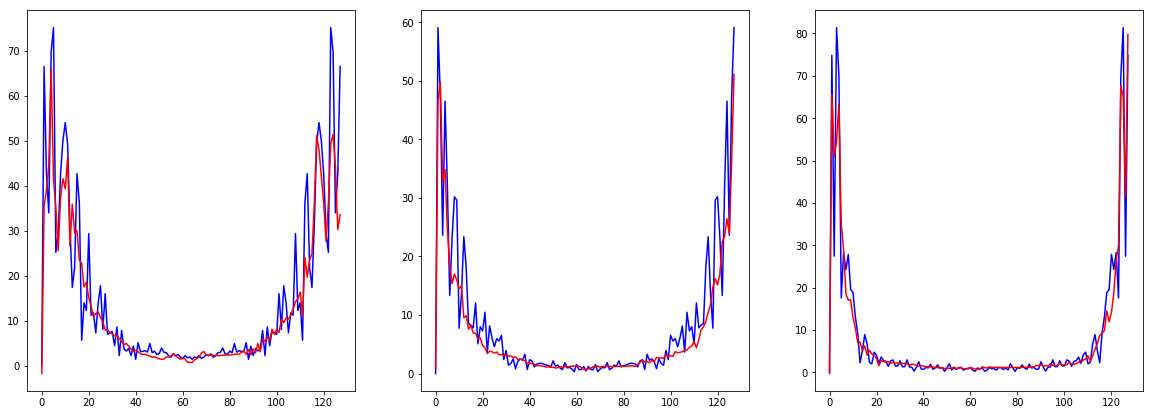

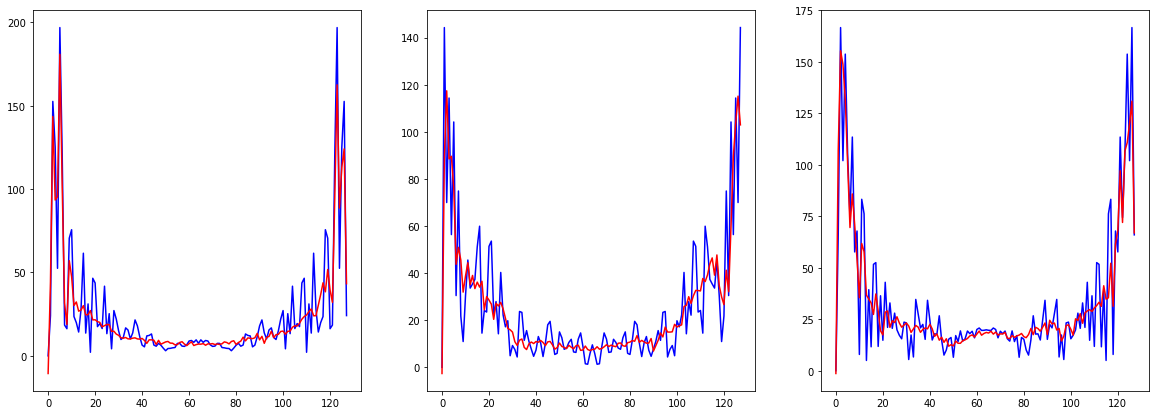

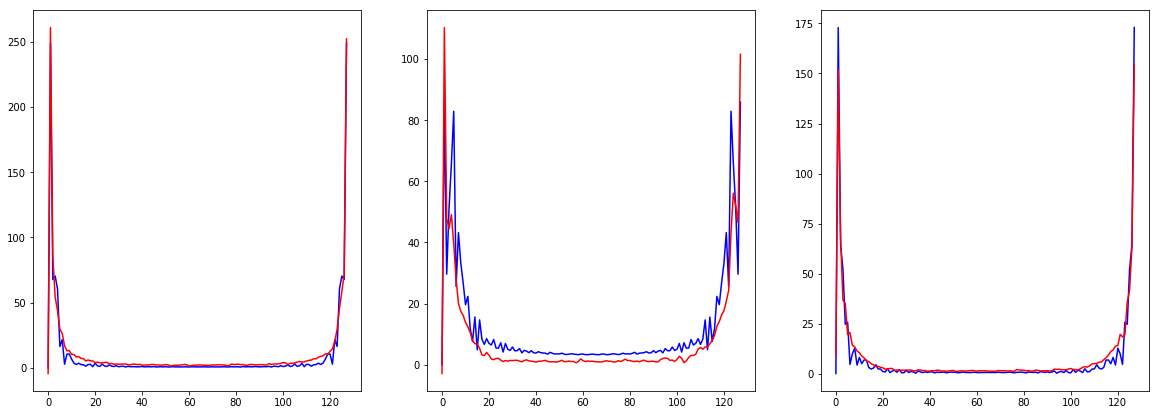

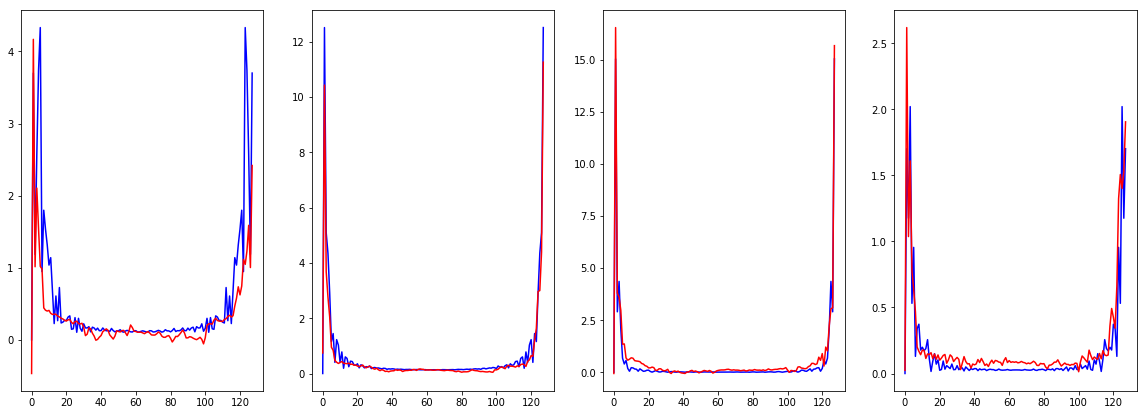

In [94]:
sample = 32
gyroy = gyroModel.predict(gyro_train[sample].reshape(1,128,3))
fig=plt.figure(figsize=(20,7))
for channel in range(3):
    plt.subplot(1,3,channel+1)
    plot(gyro_train[sample,:,channel],'b')
    plot(gyroy[0,:,channel],'r')
linearAccy = linearAccModel.predict(linearAcc_train[sample].reshape(1,128,3))
fig=plt.figure(figsize=(20,7))
for channel in range(3):
    plt.subplot(1,3,channel+1)
    plot(linearAcc_train[sample,:,channel],'b')
    plot(linearAccy[0,:,channel],'r')
gravityy = gravityModel.predict(gravity_train[sample].reshape(1,128,3))
fig=plt.figure(figsize=(20,7))
for channel in range(3):
    plt.subplot(1,3,channel+1)
    plot(gravity_train[sample,:,channel],'b')
    plot(gravityy[0,:,channel],'r')
gameVecy = gameVecModel.predict(gameVec_train[sample].reshape(1,128,4))
fig=plt.figure(figsize=(20,7))
for channel in range(4):
    plt.subplot(1,4,channel+1)
    plot(gameVec_train[sample,:,channel],'b')
    plot(gameVecy[0,:,channel],'r')